In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''
import cv2
from sklearn.model_selection import train_test_split
from sklearn import datasets
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from torch.backends import cudnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import torchvision as tv
from torch.utils.data import TensorDataset,DataLoader

import torchvision
import torchvision.datasets as Dataset
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
import copy
import torchvision as tv
import cv2
from torch.utils.data import random_split
import pandas as pd
import os
from torch.utils.data import TensorDataset

import skimage.io as io
from tqdm import tqdm
from tensorboardX import SummaryWriter
from copy import deepcopy
import time

import sys

import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.optim.sgd import SGD
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import Image
from collections import Counter
from sklearn.metrics import f1_score,precision_score,recall_score
class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """
 
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)
 
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
 
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
 
    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)
 
    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)


In [2]:
import torchvision.models as models

In [3]:
!pip install thop

In [4]:
from torchvision.models import resnet50
from thop import profile
model = resnet50()
input = torch.randn(1, 3, 224, 224)


In [5]:
features = models.mobilenet_v2().features
base_flops, base_params = profile(features, inputs=(input, ))
print(base_flops, base_params)
for i in range(1,20):
    print(-i,features[:-i](torch.randn(1,3,224,224)).shape)
    flops, params = profile(features[:-i], inputs=(input, ))
    print(flops/base_flops, params/base_params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
326206720.0 2223872.0
-1 torch.Size([1, 320, 7, 7])
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
0.9377042876369929 0.814665592264303
-2 torch.Size([1, 160, 7, 7])
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.R

In [6]:
sub_ids = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
s = sub_ids['subject'].values.tolist()
c = sub_ids['classname'].values.tolist()
imgs = sub_ids['img'].values.tolist()
sub_dics = {}
for i in range(len(s)):
    temps = s[i]
    tempc = c[i]
    tempimgs = imgs[i]
    sub_dics[tempc+'/'+tempimgs] = temps
    '''if temps not in sub_dics:
        sub_dics[temps] = [tempc+'/'+tempimgs]
    else:
        sub_dics[temps].append(tempc+'/'+tempimgs)'''
train_annos = pd.read_csv('/kaggle/input/state-farm-annos/train_list_d_01.csv')
train_images = train_annos['img'].values.tolist()
train_cates = train_annos['classname'].values.tolist()
train_paths = [train_cates[i]+'/'+train_images[i] for i in range(len(train_images))]

test_annos = pd.read_csv('/kaggle/input/state-farm-annos/val_list_d_01.csv')
test_images = test_annos['img'].values.tolist()
test_cates = test_annos['classname'].values.tolist()
test_paths = [test_cates[i]+'/'+test_images[i] for i in range(len(test_images))]

globalpath = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
filepath = ['/c0','/c1','/c2','/c3','/c4','/c5','/c6','/c7','/c8','/c9']

trainset = []
validset = []
for label,f in enumerate(filepath):
    print(label,f)
    imgs = globalpath + f
    for dirname, _, filenames in os.walk(imgs):
        for filename in filenames:
            temppath = os.path.join(dirname, filename)
            im_o = Image.open(temppath)
            im_o = transforms.Resize([224,224])(im_o)

            anno = f + '/' +filename
            anno = anno[1:]
            if anno in train_paths:
                trainset.append([im_o,label,sub_dics[anno]])
            if anno in test_paths:
                validset.append([im_o,label,sub_dics[anno]])

        print(len(trainset),len(validset))
print('处理完成')
train_len = len(trainset)
valid_len = len(validset)
train_all = train_len

train_subs = []
for t in trainset:
    if t[2] not in train_subs:
        train_subs.append(t[2])
print(train_subs)

len_train_subs = len(train_subs)
train_sub_ids = {}
for i in range(len(train_subs)):
    train_sub_ids[train_subs[i]] = i
    

    
trainset2 = []
for t in trainset:
    trainset2.append([t[0],t[1],train_sub_ids[t[2]]])
trainset = trainset2

0 /c0
1766 723
1 /c1
3389 1367
2 /c2
5038 2035
3 /c3
6684 2735
4 /c4
8307 3438
5 /c5
9921 4136
6 /c6
11570 4812
7 /c7
12953 5431
8 /c8
14336 5959
9 /c9
15899 6525
处理完成
['p021', 'p081', 'p051', 'p061', 'p042', 'p024', 'p015', 'p014', 'p016', 'p064', 'p049', 'p022', 'p056', 'p052', 'p066', 'p039', 'p072', 'p047']


In [7]:
valid_len = len(validset)
train_len = len(trainset)
train_all = train_len

In [8]:
class MSFIN_teacher(nn.Module):
    def __init__(self):
        super(MSFIN_teacher,self).__init__()
        
        model = models.mobilenet_v2(pretrained=True)
        self.features = model.features
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=10, bias=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    def getGAP(self,f):
        return self.avgpool(f).squeeze(-1).squeeze(-1)
    def getCAM(self,y,f,w,bias):
        camlists = []
        
        for i in range(y.size(0)):
            idx = y[i]
            tempw = w[idx]
            tempf = f[i]
            tempbias = bias[idx]
            c,d,e = tempf.size()
            
            tempf = tempw.unsqueeze(1).unsqueeze(1) * tempf
            tempf = tempf.sum(0) + tempbias
            cam = tempf.reshape(-1)

            c,d = tempf.size()
            cam = tempf.reshape(-1)
            cam = (cam-cam.min())/(cam.max()-cam.min())
            cam = cam.reshape(d,e)
            camlists.append(cam)
        return torch.stack(camlists,0)
        
    def forward(self,x):
        f = self.features(x)
        avgf = self.getGAP(f)
        preds = self.fc(avgf)
        
        w = self.fc[1].weight
        b = self.fc[1].bias
        #print(f.shape,w.shape)
        cams = f.unsqueeze(1) * w.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        cams = cams.sum(2) + b.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

        return cams

In [9]:
class MSFIN(nn.Module):
    def __init__(self,teacher):
        super(MSFIN,self).__init__()
        
        self.teacher = teacher
        
        model = models.mobilenet_v2(pretrained=True)
        self.features = model.features[:-5]
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=96, out_features=10, bias=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    def getGAP(self,f):
        return self.avgpool(f).squeeze(-1).squeeze(-1)
    def getCAM(self,y,f,w,bias):
        camlists = []
        
        for i in range(y.size(0)):
            idx = y[i]
            tempw = w[idx]
            tempf = f[i]
            tempbias = bias[idx]
            c,d,e = tempf.size()
            
            tempf = tempw.unsqueeze(1).unsqueeze(1) * tempf
            tempf = tempf.sum(0) + tempbias
            cam = tempf.reshape(-1)

            c,d = tempf.size()
            cam = tempf.reshape(-1)
            cam = cam - cam.min().detach()
            cam = cam / cam.max().detach()
            #cam = (cam-cam.min())/(cam.max()-cam.min())
            cam = cam.reshape(d,e)
            camlists.append(cam)
        return torch.stack(camlists,0)
        
    def forward(self,x,y):
        
        f = self.features(x)
        avgf = self.getGAP(f)
        preds = self.fc(avgf)
        
        self.teacher.eval()
        cams_t = self.teacher(x).detach()
        
        
        w = self.fc[1].weight
        b = self.fc[1].bias
        cams = f.unsqueeze(1) * w.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        cams_s = cams.sum(2) + b.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

        a,b,c,d = cams_t.size()
        cams_t = cams_t.reshape(a*b,1,c,d)
        #print(cams_t.shape,cams_s.shape)
        #print(cams_t.shape)
        cams_t = F.interpolate(cams_t, size=(cams_s.size(2), cams_s.size(3)), mode='bilinear', align_corners=False)
        #print(cams_t.shape)
        cams_t = cams_t.squeeze(1)
        #print(cams_t.shape)
        cams_t = cams_t.reshape(a,b,cams_s.size(2), cams_s.size(3))
        
        #print(cams_s.shape,cams_t.shape)
        loss = nn.MSELoss()(cams_s,cams_t)
        return preds,loss

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 79.8MB/s]
  0%|          | 0/400 [00:00<?, ?it/s]

***训练集***
0.095
valid-f1: 0.032310219654920626
valid-precision: 0.03343704580086233
valid-recall: 0.10965176479339458
process: 1  loss: 57.648951053619385  train_correct: 0.004780174853764388 valid_loss 469.4130311012268  val_correct: 0.10896551724137932


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/400 [00:16<1:52:52, 16.97s/it]

The model has been saved!!
The best val_acc is  0.10896551724137932
***训练集***
0.115


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/400 [00:32<1:46:59, 16.13s/it]

valid-f1: 0.03974515771670913
valid-precision: 0.09991500587857027
valid-recall: 0.11185797111395746
process: 2  loss: 57.405742168426514  train_correct: 0.00578652745455689 valid_loss 466.5762288570404  val_correct: 0.11126436781609196
The model has been saved!!
The best val_acc is  0.11126436781609196
***训练集***
0.155


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/400 [00:48<1:45:05, 15.88s/it]

valid-f1: 0.054079711552776334
valid-precision: 0.36369127198136136
valid-recall: 0.12355125389121882
process: 3  loss: 56.86412239074707  train_correct: 0.007799232656141896 valid_loss 461.41916370391846  val_correct: 0.1232183908045977
The model has been saved!!
The best val_acc is  0.1232183908045977
***训练集***
0.2175


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/400 [01:03<1:44:13, 15.79s/it]

valid-f1: 0.09128514271359942
valid-precision: 0.34932624926446426
valid-recall: 0.16455586771397196
process: 4  loss: 56.09071373939514  train_correct: 0.010944084533618467 valid_loss 449.71875751018524  val_correct: 0.16796934865900384
The model has been saved!!
The best val_acc is  0.16796934865900384
***训练集***
0.2775


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▏         | 5/400 [01:19<1:43:37, 15.74s/it]

valid-f1: 0.32975802062575577
valid-precision: 0.4556221359416653
valid-recall: 0.37144871685439107
process: 5  loss: 54.334564447402954  train_correct: 0.013963142335995975 valid_loss 419.4161351919174  val_correct: 0.37057471264367814
The model has been saved!!
The best val_acc is  0.37057471264367814
***训练集***
0.36375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/400 [01:34<1:42:59, 15.69s/it]

valid-f1: 0.3122590104100206
valid-precision: 0.43138289889737746
valid-recall: 0.37006919882752365
process: 6  loss: 50.37265479564667  train_correct: 0.01830303792691364 valid_loss 366.67262476682663  val_correct: 0.3776245210727969
The model has been saved!!
The best val_acc is  0.3776245210727969
***训练集***
0.43


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 7/400 [01:50<1:42:32, 15.66s/it]

valid-f1: 0.4458629287668601
valid-precision: 0.5461540397779527
valid-recall: 0.5021598741752441
process: 7  loss: 44.296815633773804  train_correct: 0.02163658091703881 valid_loss 314.53510212898254  val_correct: 0.503448275862069
The model has been saved!!
The best val_acc is  0.503448275862069
***训练集***
0.51


  2%|▏         | 8/400 [02:06<1:42:12, 15.64s/it]

valid-f1: 0.5470073117002086
valid-precision: 0.6479267581311687
valid-recall: 0.5851896122423559
process: 8  loss: 38.63689136505127  train_correct: 0.02566199132020882 valid_loss 264.23064425587654  val_correct: 0.5932567049808429
The model has been saved!!
The best val_acc is  0.5932567049808429
***训练集***
0.57375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 9/400 [02:21<1:41:49, 15.62s/it]

valid-f1: 0.4616141115308072
valid-precision: 0.5652987914076941
valid-recall: 0.5107339841920953
process: 9  loss: 34.08780658245087  train_correct: 0.02886974023523492 valid_loss 280.23469557613134  val_correct: 0.5158620689655172
***训练集***
0.64625


  2%|▎         | 10/400 [02:37<1:41:42, 15.65s/it]

valid-f1: 0.6982144531126193
valid-precision: 0.7771121837854436
valid-recall: 0.7222543709882283
process: 10  loss: 29.256471991539  train_correct: 0.032517768413107745 valid_loss 193.687397018075  val_correct: 0.7350191570881226
The model has been saved!!
The best val_acc is  0.7350191570881226
***训练集***
0.635


  3%|▎         | 11/400 [02:53<1:41:29, 15.65s/it]

valid-f1: 0.6903522311169292
valid-precision: 0.7542976305992157
valid-recall: 0.6990482314842926
process: 11  loss: 27.760158717632294  train_correct: 0.03195169507516196 valid_loss 191.29914917051792  val_correct: 0.7101915708812261
***训练集***
0.655


  3%|▎         | 12/400 [03:08<1:41:03, 15.63s/it]

valid-f1: 0.7489689824620079
valid-precision: 0.7868995601754369
valid-recall: 0.7577259019403451
process: 12  loss: 25.889384984970093  train_correct: 0.03295804767595446 valid_loss 169.4016260355711  val_correct: 0.7604597701149425
The model has been saved!!
The best val_acc is  0.7604597701149425
***训练集***
0.71875


  3%|▎         | 13/400 [03:24<1:40:35, 15.59s/it]

valid-f1: 0.7271208565695758
valid-precision: 0.7960410133821849
valid-recall: 0.7498043115811734
process: 13  loss: 23.434013783931732  train_correct: 0.03616579659098056 valid_loss 149.27281156927347  val_correct: 0.7684291187739464
The model has been saved!!
The best val_acc is  0.7684291187739464
***训练集***
0.73875


  4%|▎         | 14/400 [03:40<1:40:49, 15.67s/it]

valid-f1: 0.7826860866541772
valid-precision: 0.8292115813915089
valid-recall: 0.7887992537109894
process: 14  loss: 21.6137615442276  train_correct: 0.037172149191773064 valid_loss 137.47426131367683  val_correct: 0.8018390804597701
The model has been saved!!
The best val_acc is  0.8018390804597701
***训练集***
0.76


  4%|▍         | 15/400 [03:55<1:40:14, 15.62s/it]

valid-f1: 0.7410745848812932
valid-precision: 0.7690316380715352
valid-recall: 0.7537401246551084
process: 15  loss: 19.550298988819122  train_correct: 0.038241398830115104 valid_loss 143.2286540493369  val_correct: 0.7616858237547893
***训练集***
0.7275


  4%|▍         | 16/400 [04:11<1:40:10, 15.65s/it]

valid-f1: 0.801152172776521
valid-precision: 0.8215404818325254
valid-recall: 0.8021445858740242
process: 16  loss: 20.666389852762222  train_correct: 0.03660607585382728 valid_loss 127.7713750898838  val_correct: 0.8104214559386973
The model has been saved!!
The best val_acc is  0.8104214559386973
***训练集***
0.745


  4%|▍         | 17/400 [04:26<1:39:47, 15.63s/it]

valid-f1: 0.8349419945053421
valid-precision: 0.8449591467207703
valid-recall: 0.8388118845345867
process: 17  loss: 19.428716897964478  train_correct: 0.037486634379520725 valid_loss 96.6501399204135  val_correct: 0.8513409961685824
The model has been saved!!
The best val_acc is  0.8513409961685824
***训练集***
0.7675


  4%|▍         | 18/400 [04:42<1:39:33, 15.64s/it]

valid-f1: 0.7817850448630115
valid-precision: 0.8254071404677766
valid-recall: 0.785414029081072
process: 18  loss: 19.00052100419998  train_correct: 0.03861878105541229 valid_loss 125.80912793334574  val_correct: 0.7831417624521073
***训练集***
0.775


  5%|▍         | 19/400 [04:57<1:38:56, 15.58s/it]

valid-f1: 0.7930669864880026
valid-precision: 0.8137876824907565
valid-recall: 0.7965808179188525
process: 19  loss: 17.447899281978607  train_correct: 0.03899616328070948 valid_loss 123.1527214050293  val_correct: 0.8022988505747126
***训练集***
0.7775


  5%|▌         | 20/400 [05:13<1:38:54, 15.62s/it]

valid-f1: 0.7880070703876665
valid-precision: 0.8114000436472727
valid-recall: 0.7909216255591348
process: 20  loss: 17.115482479333878  train_correct: 0.03912195735580854 valid_loss 127.71183209866285  val_correct: 0.7944827586206896
***训练集***
0.80375


  5%|▌         | 21/400 [05:29<1:38:29, 15.59s/it]

valid-f1: 0.866072830958857
valid-precision: 0.8859631374096238
valid-recall: 0.8655212001048831
process: 21  loss: 15.378861039876938  train_correct: 0.0404427951443487 valid_loss 92.35421891883016  val_correct: 0.8737164750957854
The model has been saved!!
The best val_acc is  0.8737164750957854
***训练集***
0.835


  6%|▌         | 22/400 [05:44<1:38:16, 15.60s/it]

valid-f1: 0.8789826121486435
valid-precision: 0.881656254657457
valid-recall: 0.8794509735368858
process: 22  loss: 14.20063602924347  train_correct: 0.04201522108308699 valid_loss 85.90717639774084  val_correct: 0.8850574712643678
The model has been saved!!
The best val_acc is  0.8850574712643678
***训练集***
0.81375


  6%|▌         | 23/400 [06:00<1:38:01, 15.60s/it]

valid-f1: 0.8334153845566303
valid-precision: 0.8532752641388874
valid-recall: 0.8364943803121279
process: 23  loss: 14.861830651760101  train_correct: 0.040945971444744954 valid_loss 108.06252947449684  val_correct: 0.835095785440613
***训练集***
0.81375


  6%|▌         | 24/400 [06:16<1:37:40, 15.59s/it]

valid-f1: 0.8464971728341775
valid-precision: 0.8558567372908626
valid-recall: 0.8469368482883762
process: 24  loss: 14.522000014781952  train_correct: 0.040945971444744954 valid_loss 90.53664197120816  val_correct: 0.8522605363984674
***训练集***
0.81375


  6%|▋         | 25/400 [06:31<1:37:12, 15.55s/it]

valid-f1: 0.8728906050877789
valid-precision: 0.8811768388802529
valid-recall: 0.8695846396731131
process: 25  loss: 14.39650011062622  train_correct: 0.040945971444744954 valid_loss 87.51124447211623  val_correct: 0.8763218390804598
***训练集***
0.81125


  6%|▋         | 26/400 [06:47<1:36:57, 15.56s/it]

valid-f1: 0.8318955510317331
valid-precision: 0.842192244217191
valid-recall: 0.8404078490659599
process: 26  loss: 14.33195823431015  train_correct: 0.04082017736964589 valid_loss 99.61667134426534  val_correct: 0.8455172413793104
***训练集***
0.83125


  7%|▋         | 27/400 [07:02<1:36:42, 15.56s/it]

valid-f1: 0.865333550572705
valid-precision: 0.879216695485405
valid-recall: 0.8647375129345903
process: 27  loss: 12.715398728847504  train_correct: 0.04182652997043839 valid_loss 90.11591016687453  val_correct: 0.8760153256704981
***训练集***
0.81125


  7%|▋         | 28/400 [07:18<1:36:32, 15.57s/it]

valid-f1: 0.8023138053955023
valid-precision: 0.8245995616161803
valid-recall: 0.8081237533014869
process: 28  loss: 14.304699301719666  train_correct: 0.04082017736964589 valid_loss 116.23992904275656  val_correct: 0.807816091954023
***训练集***
0.83375


  7%|▋         | 29/400 [07:33<1:36:05, 15.54s/it]

valid-f1: 0.8638414886345588
valid-precision: 0.8733729916974259
valid-recall: 0.8637007491057508
process: 29  loss: 12.343108385801315  train_correct: 0.041952324045537455 valid_loss 84.25091325351968  val_correct: 0.8711111111111111
***训练集***
0.83875


  8%|▊         | 30/400 [07:49<1:36:27, 15.64s/it]

valid-f1: 0.7862101617443891
valid-precision: 0.816433548261782
valid-recall: 0.7897948524740888
process: 30  loss: 13.196371793746948  train_correct: 0.042203912195735584 valid_loss 137.46161506325006  val_correct: 0.7886590038314176
***训练集***
0.82375


  8%|▊         | 31/400 [08:05<1:36:02, 15.62s/it]

valid-f1: 0.8661968452760842
valid-precision: 0.8790486630119277
valid-recall: 0.8648132687256529
process: 31  loss: 13.817174553871155  train_correct: 0.041449147745141204 valid_loss 89.52309024054557  val_correct: 0.8698850574712643
***训练集***
0.84


  8%|▊         | 32/400 [08:20<1:35:39, 15.60s/it]

valid-f1: 0.8668477338675391
valid-precision: 0.8709423764945872
valid-recall: 0.8699877913707155
process: 32  loss: 12.837820410728455  train_correct: 0.04226680923328511 valid_loss 80.80793704465032  val_correct: 0.8706513409961686
***训练集***
0.83625


  8%|▊         | 33/400 [08:36<1:35:17, 15.58s/it]

valid-f1: 0.88354660690136
valid-precision: 0.8886602888975716
valid-recall: 0.8833240766542563
process: 33  loss: 11.699176907539368  train_correct: 0.04207811812063652 valid_loss 75.46480795927346  val_correct: 0.8882758620689655
The model has been saved!!
The best val_acc is  0.8882758620689655
***训练集***
0.84625


  8%|▊         | 34/400 [08:51<1:35:00, 15.58s/it]

valid-f1: 0.839679628759753
valid-precision: 0.8561649991588187
valid-recall: 0.8478752692497034
process: 34  loss: 11.327619165182114  train_correct: 0.04258129442103277 valid_loss 93.09090353362262  val_correct: 0.8444444444444444
***训练集***
0.845


  9%|▉         | 35/400 [09:07<1:34:42, 15.57s/it]

valid-f1: 0.8930070267364558
valid-precision: 0.9006854540059568
valid-recall: 0.8923615031517791
process: 35  loss: 11.806031093001366  train_correct: 0.04251839738348324 valid_loss 71.83394808182493  val_correct: 0.8986973180076628
The model has been saved!!
The best val_acc is  0.8986973180076628
***训练集***
0.855


  9%|▉         | 36/400 [09:22<1:34:20, 15.55s/it]

valid-f1: 0.8932868659659171
valid-precision: 0.8949711573899931
valid-recall: 0.8946795433867918
process: 36  loss: 11.22749049961567  train_correct: 0.04302157368387949 valid_loss 65.44134625419974  val_correct: 0.8980842911877395
***训练集***
0.87375


  9%|▉         | 37/400 [09:38<1:33:54, 15.52s/it]

valid-f1: 0.8484676321875261
valid-precision: 0.8678152663151302
valid-recall: 0.854340929667224
process: 37  loss: 10.073927134275436  train_correct: 0.04396502924712246 valid_loss 96.01611159252934  val_correct: 0.8525670498084291
***训练集***
0.85625


 10%|▉         | 38/400 [09:53<1:33:46, 15.54s/it]

valid-f1: 0.8609989726318663
valid-precision: 0.8818827272734626
valid-recall: 0.8587673968378036
process: 38  loss: 11.157647892832756  train_correct: 0.04308447072142902 valid_loss 96.68503379821777  val_correct: 0.8671264367816092
***训练集***
0.84625


 10%|▉         | 39/400 [10:09<1:33:20, 15.51s/it]

valid-f1: 0.8393244925058111
valid-precision: 0.8508128993379993
valid-recall: 0.8412819524270148
process: 39  loss: 11.453726768493652  train_correct: 0.04258129442103277 valid_loss 104.27355123846792  val_correct: 0.8444444444444444
***训练集***
0.8425


 10%|█         | 40/400 [10:24<1:33:22, 15.56s/it]

valid-f1: 0.8721907114840259
valid-precision: 0.8748040831264229
valid-recall: 0.8749142405169286
process: 40  loss: 12.234008699655533  train_correct: 0.04239260330838417 valid_loss 77.62299830233678  val_correct: 0.8796934865900383
***训练集***
0.855


 10%|█         | 41/400 [10:40<1:32:50, 15.52s/it]

valid-f1: 0.8743415647529555
valid-precision: 0.8798381172477854
valid-recall: 0.8760420655407206
process: 41  loss: 11.746854171156883  train_correct: 0.04302157368387949 valid_loss 80.76148987747729  val_correct: 0.8793869731800766
***训练集***
0.85625


 10%|█         | 42/400 [10:55<1:32:35, 15.52s/it]

valid-f1: 0.8716630354513463
valid-precision: 0.8785465680021641
valid-recall: 0.873509648576077
process: 42  loss: 10.875378489494324  train_correct: 0.04308447072142902 valid_loss 80.96368167642504  val_correct: 0.877088122605364
***训练集***
0.8625


 11%|█         | 43/400 [11:11<1:32:06, 15.48s/it]

valid-f1: 0.8693199592862868
valid-precision: 0.8801071818948353
valid-recall: 0.8708067711059402
process: 43  loss: 10.612279891967773  train_correct: 0.043398955909176674 valid_loss 82.83440258540213  val_correct: 0.8723371647509579
***训练集***
0.86625


 11%|█         | 44/400 [11:26<1:31:53, 15.49s/it]

valid-f1: 0.8732647070407996
valid-precision: 0.8860619220487143
valid-recall: 0.8722326528769972
process: 44  loss: 9.801493756473064  train_correct: 0.04358764702182527 valid_loss 85.07273410819471  val_correct: 0.8767816091954023
***训练集***
0.89375


 11%|█▏        | 45/400 [11:42<1:31:47, 15.52s/it]

valid-f1: 0.8709825974300504
valid-precision: 0.8817177267431748
valid-recall: 0.8722434613296679
process: 45  loss: 8.488864973187447  train_correct: 0.044971381847914965 valid_loss 77.89741769060493  val_correct: 0.8726436781609196
***训练集***
0.88125


 12%|█▏        | 46/400 [11:57<1:31:37, 15.53s/it]

valid-f1: 0.8402670202312088
valid-precision: 0.8642892616107339
valid-recall: 0.8409858505731199
process: 46  loss: 9.543833002448082  train_correct: 0.04434241147241965 valid_loss 95.88236281927675  val_correct: 0.8458237547892721
***训练集***
0.8575


 12%|█▏        | 47/400 [12:13<1:31:11, 15.50s/it]

valid-f1: 0.8820211958974111
valid-precision: 0.8920659233832291
valid-recall: 0.8812849172750905
process: 47  loss: 9.759878873825073  train_correct: 0.04314736775897855 valid_loss 76.88223900459707  val_correct: 0.887816091954023
***训练集***
0.875


 12%|█▏        | 48/400 [12:29<1:31:07, 15.53s/it]

valid-f1: 0.8969646643789864
valid-precision: 0.9039657172438277
valid-recall: 0.8965903729059945
process: 48  loss: 9.24841945618391  train_correct: 0.04402792628467199 valid_loss 69.8633991656825  val_correct: 0.9025287356321839
The model has been saved!!
The best val_acc is  0.9025287356321839
***训练集***
0.8825


 12%|█▏        | 49/400 [12:44<1:30:38, 15.49s/it]

valid-f1: 0.8196763470139203
valid-precision: 0.8551554132081982
valid-recall: 0.8162329092453351
process: 49  loss: 9.209743320941925  train_correct: 0.04440530850996918 valid_loss 111.3337454230059  val_correct: 0.8160919540229885
***训练集***
0.8775


 12%|█▎        | 50/400 [12:59<1:30:28, 15.51s/it]

valid-f1: 0.8763171485576683
valid-precision: 0.884079817439889
valid-recall: 0.8801782327087573
process: 50  loss: 8.97442327439785  train_correct: 0.044153720359771054 valid_loss 75.33423976413906  val_correct: 0.8792337164750957
***训练集***
0.87


 13%|█▎        | 51/400 [13:15<1:29:53, 15.45s/it]

valid-f1: 0.8954128680076231
valid-precision: 0.9012685286408739
valid-recall: 0.8946712916504163
process: 51  loss: 8.845578283071518  train_correct: 0.04377633813447387 valid_loss 68.0515187936835  val_correct: 0.8988505747126436
***训练集***
0.88125


 13%|█▎        | 52/400 [13:30<1:29:35, 15.45s/it]

valid-f1: 0.8497068628683422
valid-precision: 0.8750906024978615
valid-recall: 0.8541549462682271
process: 52  loss: 9.89853622019291  train_correct: 0.04434241147241965 valid_loss 96.4164603156969  val_correct: 0.8613026819923372
***训练集***
0.8425


 13%|█▎        | 53/400 [13:46<1:29:13, 15.43s/it]

valid-f1: 0.8035574838993046
valid-precision: 0.8618811002123078
valid-recall: 0.797915346495423
process: 53  loss: 10.760850876569748  train_correct: 0.04239260330838417 valid_loss 131.6137311179191  val_correct: 0.7984674329501916
***训练集***
0.86


 14%|█▎        | 54/400 [14:01<1:29:09, 15.46s/it]

valid-f1: 0.8961550490347886
valid-precision: 0.9029347374449699
valid-recall: 0.8962287694861188
process: 54  loss: 10.541025787591934  train_correct: 0.04327316183407762 valid_loss 68.52183792134747  val_correct: 0.9000766283524905
***训练集***
0.8725
开始蒸馏


 14%|█▍        | 55/400 [14:17<1:28:49, 15.45s/it]

valid-f1: 0.867151845383078
valid-precision: 0.8842073016024002
valid-recall: 0.8713308706169606
process: 55  loss: 9.825777247548103  train_correct: 0.04390213220957293 valid_loss 87.4689678158611  val_correct: 0.8795402298850574
***训练集***
0.78375


 14%|█▍        | 56/400 [14:32<1:28:48, 15.49s/it]

valid-f1: 0.7724013970791348
valid-precision: 0.8670486483698155
valid-recall: 0.7787295740974969
process: 56  loss: 1111.2080516815186  train_correct: 0.039436442543556195 valid_loss 150.54008424200583  val_correct: 0.7964750957854406
***训练集***
0.77625


 14%|█▍        | 57/400 [14:47<1:28:19, 15.45s/it]

valid-f1: 0.8868475280587225
valid-precision: 0.9178664051860272
valid-recall: 0.8780808088979922
process: 57  loss: 666.9608135223389  train_correct: 0.03905906031825901 valid_loss 90.11208925279789  val_correct: 0.8885823754789272
***训练集***
0.8225


 14%|█▍        | 58/400 [15:03<1:28:18, 15.49s/it]

valid-f1: 0.9106046135756758
valid-precision: 0.913765065750788
valid-recall: 0.9112629211995446
process: 58  loss: 531.6289100646973  train_correct: 0.04138625070759167 valid_loss 65.18091920248116  val_correct: 0.9134099616858238
The model has been saved!!
The best val_acc is  0.9134099616858238
***训练集***
0.84375


 15%|█▍        | 59/400 [15:19<1:27:58, 15.48s/it]

valid-f1: 0.9155625852977719
valid-precision: 0.9164681928924008
valid-recall: 0.9154137514007203
process: 59  loss: 426.2047233581543  train_correct: 0.042455500345933705 valid_loss 54.21646547952696  val_correct: 0.9196934865900384
The model has been saved!!
The best val_acc is  0.9196934865900384
***训练集***
0.83


 15%|█▌        | 60/400 [15:34<1:27:49, 15.50s/it]

valid-f1: 0.9217733095519446
valid-precision: 0.9266508685228227
valid-recall: 0.9205972473321887
process: 60  loss: 424.87178230285645  train_correct: 0.04176363293288886 valid_loss 56.13472102670494  val_correct: 0.9267432950191571
The model has been saved!!
The best val_acc is  0.9267432950191571
***训练集***
0.84125


 15%|█▌        | 61/400 [15:50<1:27:36, 15.51s/it]

valid-f1: 0.9267077072013825
valid-precision: 0.9279035778742137
valid-recall: 0.9261811604645637
process: 61  loss: 389.2708616256714  train_correct: 0.04232970627083464 valid_loss 48.52498437149916  val_correct: 0.9305747126436782
The model has been saved!!
The best val_acc is  0.9305747126436782
***训练集***
0.86875


 16%|█▌        | 62/400 [16:05<1:27:14, 15.49s/it]

valid-f1: 0.9044151661158603
valid-precision: 0.9210865675301477
valid-recall: 0.9057204914618285
process: 62  loss: 384.5706434249878  train_correct: 0.043713441096924335 valid_loss 80.52842229716043  val_correct: 0.9144827586206896
***训练集***
0.86375


 16%|█▌        | 63/400 [16:21<1:27:02, 15.50s/it]

valid-f1: 0.9312433287140104
valid-precision: 0.9346295374755638
valid-recall: 0.9302129048381627
process: 63  loss: 372.27484798431396  train_correct: 0.04346185294672621 valid_loss 50.635806899113504  val_correct: 0.9353256704980842
The model has been saved!!
The best val_acc is  0.9353256704980842
***训练集***
0.8725


 16%|█▌        | 64/400 [16:36<1:26:49, 15.51s/it]

valid-f1: 0.9234501148564203
valid-precision: 0.9281058868454467
valid-recall: 0.9220279966489457
process: 64  loss: 346.89366340637207  train_correct: 0.04390213220957293 valid_loss 53.79259841081148  val_correct: 0.9253639846743295
***训练集***
0.86125


 16%|█▋        | 65/400 [16:52<1:26:32, 15.50s/it]

valid-f1: 0.9355325152016626
valid-precision: 0.9412166666950286
valid-recall: 0.9344952925451103
process: 65  loss: 344.66801834106445  train_correct: 0.04333605887162715 valid_loss 50.51307284008362  val_correct: 0.9399233716475096
The model has been saved!!
The best val_acc is  0.9399233716475096
***训练集***
0.885


 16%|█▋        | 66/400 [17:07<1:26:30, 15.54s/it]

valid-f1: 0.9407420690750541
valid-precision: 0.9453516199383477
valid-recall: 0.9400767603219764
process: 66  loss: 305.65316104888916  train_correct: 0.04453110258506824 valid_loss 46.500701515175024  val_correct: 0.9446743295019157
The model has been saved!!
The best val_acc is  0.9446743295019157
***训练集***
0.86


 17%|█▋        | 67/400 [17:23<1:26:03, 15.51s/it]

valid-f1: 0.9388478948058697
valid-precision: 0.9434491760823679
valid-recall: 0.9377443588086057
process: 67  loss: 301.99381923675537  train_correct: 0.04327316183407762 valid_loss 48.224105836656236  val_correct: 0.9426819923371648
***训练集***
0.86625


 17%|█▋        | 68/400 [17:38<1:25:40, 15.48s/it]

valid-f1: 0.9295152008111399
valid-precision: 0.9310916943674332
valid-recall: 0.9289441839601912
process: 68  loss: 304.2991991043091  train_correct: 0.04358764702182527 valid_loss 53.65278499267697  val_correct: 0.93272030651341
***训练集***
0.89125


 17%|█▋        | 69/400 [17:54<1:25:28, 15.49s/it]

valid-f1: 0.9333120116073544
valid-precision: 0.9372338103511284
valid-recall: 0.9316762173223723
process: 69  loss: 300.0621690750122  train_correct: 0.0448455877728159 valid_loss 50.09843924847155  val_correct: 0.9368582375478928
***训练集***
0.9075


 18%|█▊        | 70/400 [18:09<1:25:14, 15.50s/it]

valid-f1: 0.9343573469490455
valid-precision: 0.9363834877986085
valid-recall: 0.9340412660759609
process: 70  loss: 285.44590282440186  train_correct: 0.045663249260959805 valid_loss 47.819719084347525  val_correct: 0.9382375478927203
***训练集***
0.88875


 18%|█▊        | 71/400 [18:25<1:24:53, 15.48s/it]

valid-f1: 0.930556019882655
valid-precision: 0.9313300492989729
valid-recall: 0.9315100098835325
process: 71  loss: 275.84010314941406  train_correct: 0.044719793697716836 valid_loss 52.016673743342835  val_correct: 0.9337931034482758
***训练集***
0.87


 18%|█▊        | 72/400 [18:40<1:24:36, 15.48s/it]

valid-f1: 0.940917608874652
valid-precision: 0.9409035050647206
valid-recall: 0.9413543928042964
process: 72  loss: 270.21262073516846  train_correct: 0.04377633813447387 valid_loss 46.93126273068992  val_correct: 0.9436015325670498
***训练集***
0.87625


 18%|█▊        | 73/400 [18:56<1:24:24, 15.49s/it]

valid-f1: 0.9394174113145153
valid-precision: 0.9396896610894366
valid-recall: 0.939628751230663
process: 73  loss: 263.00961685180664  train_correct: 0.04409082332222152 valid_loss 46.03153688105522  val_correct: 0.9425287356321839
***训练集***
0.90125


 18%|█▊        | 74/400 [19:11<1:24:23, 15.53s/it]

valid-f1: 0.9211686503613065
valid-precision: 0.9308676253736904
valid-recall: 0.9198004371631019
process: 74  loss: 277.0648136138916  train_correct: 0.04534876407321215 valid_loss 59.87932871953262  val_correct: 0.9262835249042145
***训练集***
0.89125


 19%|█▉        | 75/400 [19:27<1:24:04, 15.52s/it]

valid-f1: 0.9320807661423419
valid-precision: 0.9352792997020656
valid-recall: 0.9315125052489897
process: 75  loss: 269.02655029296875  train_correct: 0.0448455877728159 valid_loss 48.06990222888999  val_correct: 0.9365517241379311
***训练集***
0.88125


 19%|█▉        | 76/400 [19:42<1:23:40, 15.49s/it]

valid-f1: 0.9313926437807419
valid-precision: 0.9345117116651057
valid-recall: 0.9305245951106151
process: 76  loss: 269.7819423675537  train_correct: 0.04434241147241965 valid_loss 48.37511407571583  val_correct: 0.9356321839080459
***训练集***
0.88375


 19%|█▉        | 77/400 [19:58<1:23:37, 15.53s/it]

valid-f1: 0.9127441147768721
valid-precision: 0.9285773860745159
valid-recall: 0.9126503072437453
process: 77  loss: 261.8055257797241  train_correct: 0.044468205547518715 valid_loss 70.81048459658632  val_correct: 0.9212260536398468
***训练集***
0.89625


 20%|█▉        | 78/400 [20:13<1:23:07, 15.49s/it]

valid-f1: 0.9347862556873168
valid-precision: 0.9365875144378777
valid-recall: 0.934160352658117
process: 78  loss: 247.10670280456543  train_correct: 0.04509717592301402 valid_loss 47.084959837797214  val_correct: 0.9383908045977012
***训练集***
0.89125


 20%|█▉        | 79/400 [20:29<1:23:02, 15.52s/it]

valid-f1: 0.9382741335660724
valid-precision: 0.939461058667159
valid-recall: 0.9380326331900448
process: 79  loss: 248.62162590026855  train_correct: 0.0448455877728159 valid_loss 47.99767645772954  val_correct: 0.9409961685823754
***训练集***
0.88375
开始蒸馏


 20%|██        | 80/400 [20:44<1:22:32, 15.48s/it]

valid-f1: 0.9319387350449853
valid-precision: 0.9362937051325279
valid-recall: 0.9314515282272117
process: 80  loss: 250.56181526184082  train_correct: 0.044468205547518715 valid_loss 53.528097193688154  val_correct: 0.9359386973180077
***训练集***
0.8775


 20%|██        | 81/400 [21:00<1:22:31, 15.52s/it]

valid-f1: 0.9269668487152043
valid-precision: 0.9327428307257598
valid-recall: 0.9256301952733867
process: 81  loss: 247.1662015914917  train_correct: 0.044153720359771054 valid_loss 55.22098084933896  val_correct: 0.9302681992337165
***训练集***
0.905


 20%|██        | 82/400 [21:15<1:22:02, 15.48s/it]

valid-f1: 0.934864994339063
valid-precision: 0.9377364054075434
valid-recall: 0.9340085481473495
process: 82  loss: 245.10141324996948  train_correct: 0.04553745518586075 valid_loss 51.208845719796955  val_correct: 0.938544061302682
***训练集***
0.8975


 21%|██        | 83/400 [21:31<1:21:43, 15.47s/it]

valid-f1: 0.9254768889146623
valid-precision: 0.9306590289827534
valid-recall: 0.9245889669386992
process: 83  loss: 228.40820026397705  train_correct: 0.045160072960563555 valid_loss 55.31081526669186  val_correct: 0.9304214559386973
***训练集***
0.89875


 21%|██        | 84/400 [21:46<1:21:17, 15.44s/it]

valid-f1: 0.9330493655701705
valid-precision: 0.9340964912457993
valid-recall: 0.933363652371827
process: 84  loss: 230.5125651359558  train_correct: 0.04522296999811309 valid_loss 48.54500740842195  val_correct: 0.9357854406130268
***训练集***
0.8975


 21%|██▏       | 85/400 [22:01<1:21:19, 15.49s/it]

valid-f1: 0.9365192346470952
valid-precision: 0.941344638379174
valid-recall: 0.9355375813947473
process: 85  loss: 238.39023733139038  train_correct: 0.045160072960563555 valid_loss 48.845786405639956  val_correct: 0.9408429118773947
***训练集***
0.89125


 22%|██▏       | 86/400 [22:17<1:20:59, 15.48s/it]

valid-f1: 0.9354116701957305
valid-precision: 0.9361866435890258
valid-recall: 0.936375357587736
process: 86  loss: 225.592839717865  train_correct: 0.0448455877728159 valid_loss 49.08074766770005  val_correct: 0.9380842911877395
***训练集***
0.89125


 22%|██▏       | 87/400 [22:32<1:20:48, 15.49s/it]

valid-f1: 0.9298287181402308
valid-precision: 0.9302016129166398
valid-recall: 0.9304166783651547
process: 87  loss: 243.5929388999939  train_correct: 0.0448455877728159 valid_loss 51.44712723268458  val_correct: 0.9334865900383141
***训练集***
0.9025


 22%|██▏       | 88/400 [22:48<1:20:31, 15.49s/it]

valid-f1: 0.9306151882015467
valid-precision: 0.9379721319345233
valid-recall: 0.9295582003810031
process: 88  loss: 228.80444812774658  train_correct: 0.045411661110761684 valid_loss 51.73624560481767  val_correct: 0.9363984674329502
***训练集***
0.88875


 22%|██▏       | 89/400 [23:04<1:20:28, 15.53s/it]

valid-f1: 0.9312868474857655
valid-precision: 0.9353495484143608
valid-recall: 0.9306411054736712
process: 89  loss: 233.39645671844482  train_correct: 0.044719793697716836 valid_loss 54.91115141373302  val_correct: 0.9357854406130268
***训练集***
0.9075


 22%|██▎       | 90/400 [23:19<1:20:03, 15.50s/it]

valid-f1: 0.9314819110772798
valid-precision: 0.9331415333699489
valid-recall: 0.9316209998710171
process: 90  loss: 231.97301530838013  train_correct: 0.045663249260959805 valid_loss 52.858515103498576  val_correct: 0.9351724137931035
***训练集***
0.9


 23%|██▎       | 91/400 [23:35<1:20:07, 15.56s/it]

valid-f1: 0.9446756702513431
valid-precision: 0.9457191289613169
valid-recall: 0.9442114341464107
process: 91  loss: 224.86221170425415  train_correct: 0.04528586703566262 valid_loss 43.48114599065775  val_correct: 0.9481992337164751
The model has been saved!!
The best val_acc is  0.9481992337164751
***训练集***
0.8975


 23%|██▎       | 92/400 [23:50<1:19:49, 15.55s/it]

valid-f1: 0.9456066738272144
valid-precision: 0.9463036361540864
valid-recall: 0.9454456455856365
process: 92  loss: 232.00252294540405  train_correct: 0.045160072960563555 valid_loss 43.613157379077165  val_correct: 0.949272030651341
The model has been saved!!
The best val_acc is  0.949272030651341
***训练集***
0.9075


 23%|██▎       | 93/400 [24:06<1:19:28, 15.53s/it]

valid-f1: 0.9401767685904538
valid-precision: 0.9412799000606709
valid-recall: 0.9401138526708925
process: 93  loss: 215.3869013786316  train_correct: 0.045663249260959805 valid_loss 47.347723712722654  val_correct: 0.9440613026819923
***训练集***
0.905


 24%|██▎       | 94/400 [24:21<1:19:03, 15.50s/it]

valid-f1: 0.9417314538476921
valid-precision: 0.944582139657391
valid-recall: 0.9405982119333254
process: 94  loss: 214.65053033828735  train_correct: 0.04553745518586075 valid_loss 45.11938233548426  val_correct: 0.9451340996168582
***训练集***
0.9025


 24%|██▍       | 95/400 [24:37<1:18:47, 15.50s/it]

valid-f1: 0.9351162266931178
valid-precision: 0.9355601401463172
valid-recall: 0.9351092790909101
process: 95  loss: 224.11702823638916  train_correct: 0.045411661110761684 valid_loss 46.40823202688807  val_correct: 0.9386973180076629
***训练集***
0.88625


 24%|██▍       | 96/400 [24:52<1:18:26, 15.48s/it]

valid-f1: 0.9287943837334588
valid-precision: 0.935341650751495
valid-recall: 0.9275110506124704
process: 96  loss: 220.94772911071777  train_correct: 0.04459399962261777 valid_loss 50.9310459559274  val_correct: 0.933639846743295
***训练集***
0.9025


 24%|██▍       | 97/400 [25:08<1:18:14, 15.49s/it]

valid-f1: 0.9405657399674994
valid-precision: 0.9418278335593598
valid-recall: 0.9399150005424861
process: 97  loss: 217.87902069091797  train_correct: 0.045411661110761684 valid_loss 41.68877178525872  val_correct: 0.9432950191570881
***训练集***
0.8875


 24%|██▍       | 98/400 [25:23<1:17:50, 15.47s/it]

valid-f1: 0.9308893678019834
valid-precision: 0.9351014139261942
valid-recall: 0.9300180068111834
process: 98  loss: 212.14845275878906  train_correct: 0.044656896660167304 valid_loss 50.21634831568008  val_correct: 0.9347126436781609
***训练集***
0.90875


 25%|██▍       | 99/400 [25:39<1:17:46, 15.50s/it]

valid-f1: 0.9384965354554182
valid-precision: 0.9447363006932716
valid-recall: 0.9364375687460968
process: 99  loss: 210.54931497573853  train_correct: 0.04572614629850934 valid_loss 45.30456946335471  val_correct: 0.9423754789272031
***训练集***
0.8825


 25%|██▌       | 100/400 [25:54<1:17:21, 15.47s/it]

valid-f1: 0.9343404098446815
valid-precision: 0.938417478536155
valid-recall: 0.9333971439335297
process: 100  loss: 204.8179111480713  train_correct: 0.04440530850996918 valid_loss 47.18879600155924  val_correct: 0.9383908045977012
***训练集***
0.9225


 25%|██▌       | 101/400 [26:10<1:17:14, 15.50s/it]

valid-f1: 0.9286402187469441
valid-precision: 0.9361985374583064
valid-recall: 0.9267341918763847
process: 101  loss: 208.1900191307068  train_correct: 0.046418013711554185 valid_loss 49.68702834079522  val_correct: 0.9328735632183908
***训练集***
0.9


 26%|██▌       | 102/400 [26:25<1:16:46, 15.46s/it]

valid-f1: 0.9425686228274897
valid-precision: 0.943476796780876
valid-recall: 0.9423270382694418
process: 102  loss: 200.80643606185913  train_correct: 0.04528586703566262 valid_loss 43.19149905905215  val_correct: 0.9459003831417625
***训练集***
0.89875


 26%|██▌       | 103/400 [26:40<1:16:33, 15.47s/it]

valid-f1: 0.9370219635813395
valid-precision: 0.9375617084909103
valid-recall: 0.9373821225476162
process: 103  loss: 209.42687225341797  train_correct: 0.04522296999811309 valid_loss 47.07230363557028  val_correct: 0.9399233716475096
***训练集***
0.91625


 26%|██▌       | 104/400 [26:56<1:16:08, 15.44s/it]

valid-f1: 0.93650921719059
valid-precision: 0.9389812508018368
valid-recall: 0.9356405115486035
process: 104  loss: 216.2741837501526  train_correct: 0.04610352852380653 valid_loss 51.00060901269171  val_correct: 0.9396168582375479
***训练集***
0.9075


 26%|██▋       | 105/400 [27:11<1:16:05, 15.48s/it]

valid-f1: 0.9319690333796755
valid-precision: 0.9371245241081262
valid-recall: 0.9320187823492108
process: 105  loss: 208.384352684021  train_correct: 0.045663249260959805 valid_loss 51.05295180648318  val_correct: 0.9374712643678161
***训练集***
0.9075


 26%|██▋       | 106/400 [27:27<1:15:39, 15.44s/it]

valid-f1: 0.9412398637676966
valid-precision: 0.9472358536081495
valid-recall: 0.9395481148518454
process: 106  loss: 210.04182815551758  train_correct: 0.045663249260959805 valid_loss 46.342564454185776  val_correct: 0.9446743295019157
***训练集***
0.8975


 27%|██▋       | 107/400 [27:42<1:15:31, 15.47s/it]

valid-f1: 0.9409474648577225
valid-precision: 0.9418685273105994
valid-recall: 0.9408974809233038
process: 107  loss: 206.83940410614014  train_correct: 0.045160072960563555 valid_loss 46.59654181949736  val_correct: 0.9445210727969349
***训练集***
0.9025


 27%|██▋       | 108/400 [27:58<1:15:17, 15.47s/it]

valid-f1: 0.935038463449151
valid-precision: 0.9378668704054004
valid-recall: 0.934257525691699
process: 108  loss: 209.51648664474487  train_correct: 0.045411661110761684 valid_loss 50.32329805329482  val_correct: 0.9391570881226053
***训练集***
0.9025


 27%|██▋       | 109/400 [28:13<1:15:16, 15.52s/it]

valid-f1: 0.9321947535602417
valid-precision: 0.933912982217028
valid-recall: 0.9318893437758143
process: 109  loss: 205.8500199317932  train_correct: 0.045411661110761684 valid_loss 49.090462074429524  val_correct: 0.9357854406130268
***训练集***
0.89125


 28%|██▊       | 110/400 [28:29<1:14:52, 15.49s/it]

valid-f1: 0.9354626323607838
valid-precision: 0.9387632610943095
valid-recall: 0.9345810194383786
process: 110  loss: 196.80204057693481  train_correct: 0.0448455877728159 valid_loss 45.17701155558461  val_correct: 0.939463601532567
***训练集***
0.8775
开始蒸馏


 28%|██▊       | 111/400 [28:44<1:14:41, 15.51s/it]

valid-f1: 0.9350036389816381
valid-precision: 0.9376988400623851
valid-recall: 0.9336984166329815
process: 111  loss: 201.64759159088135  train_correct: 0.044153720359771054 valid_loss 46.36607093398197  val_correct: 0.9377777777777778
***训练集***
0.90375


 28%|██▊       | 112/400 [29:00<1:14:24, 15.50s/it]

valid-f1: 0.9374607493229437
valid-precision: 0.9387756049648978
valid-recall: 0.9369343760291817
process: 112  loss: 205.15889072418213  train_correct: 0.045474558148311216 valid_loss 45.34763198692599  val_correct: 0.940536398467433
***训练集***
0.9025


 28%|██▊       | 113/400 [29:15<1:14:13, 15.52s/it]

valid-f1: 0.9392718023595684
valid-precision: 0.94017729628024
valid-recall: 0.9393535553453057
process: 113  loss: 197.22489595413208  train_correct: 0.045411661110761684 valid_loss 43.61720974105992  val_correct: 0.9423754789272031
***训练集***
0.88875


 28%|██▊       | 114/400 [29:31<1:13:51, 15.49s/it]

valid-f1: 0.9330487158374684
valid-precision: 0.9352663171109405
valid-recall: 0.932853693981591
process: 114  loss: 198.27373886108398  train_correct: 0.044719793697716836 valid_loss 51.9895454653888  val_correct: 0.9367049808429119
***训练集***
0.905


 29%|██▉       | 115/400 [29:46<1:13:32, 15.48s/it]

valid-f1: 0.9194970884291356
valid-precision: 0.9319970678340624
valid-recall: 0.9179898536181341
process: 115  loss: 198.22411584854126  train_correct: 0.04553745518586075 valid_loss 65.32756564890224  val_correct: 0.9250574712643678
***训练集***
0.91125


 29%|██▉       | 116/400 [30:02<1:13:28, 15.52s/it]

valid-f1: 0.9350976665012112
valid-precision: 0.9400945230106762
valid-recall: 0.9341396004166626
process: 116  loss: 202.19615840911865  train_correct: 0.0458519403736084 valid_loss 52.91361543908715  val_correct: 0.9393103448275862
***训练集***
0.8975


 29%|██▉       | 117/400 [30:17<1:13:05, 15.50s/it]

valid-f1: 0.935747426314683
valid-precision: 0.9418759926483637
valid-recall: 0.9336015341136168
process: 117  loss: 186.4767165184021  train_correct: 0.045160072960563555 valid_loss 48.64293523694505  val_correct: 0.9393103448275862
***训练集***
0.90125


 30%|██▉       | 118/400 [30:33<1:12:38, 15.46s/it]

valid-f1: 0.9406584745101163
valid-precision: 0.9425958211732484
valid-recall: 0.9399684840232609
process: 118  loss: 203.08945608139038  train_correct: 0.04534876407321215 valid_loss 45.527110971859656  val_correct: 0.9440613026819923
***训练集***
0.91375


 30%|██▉       | 119/400 [30:48<1:12:22, 15.45s/it]

valid-f1: 0.9449158149094048
valid-precision: 0.9469363740813469
valid-recall: 0.944140984220909
process: 119  loss: 204.57418155670166  train_correct: 0.045977734448707466 valid_loss 41.78176847306895  val_correct: 0.948352490421456
***训练集***
0.91875


 30%|███       | 120/400 [31:04<1:12:07, 15.46s/it]

valid-f1: 0.9382898629873913
valid-precision: 0.9422067136921296
valid-recall: 0.9368068629683026
process: 120  loss: 200.7402787208557  train_correct: 0.04622932259890559 valid_loss 47.22539225693072  val_correct: 0.9419157088122605
***训练集***
0.92375


 30%|███       | 121/400 [31:19<1:11:59, 15.48s/it]

valid-f1: 0.9379202014427441
valid-precision: 0.939132148494412
valid-recall: 0.9376188579968646
process: 121  loss: 189.3501501083374  train_correct: 0.04648091074910372 valid_loss 46.63070900315506  val_correct: 0.9413026819923371
***训练集***
0.9175


 30%|███       | 122/400 [31:35<1:11:38, 15.46s/it]

valid-f1: 0.9234656566402935
valid-precision: 0.9351114713581807
valid-recall: 0.9232914978893104
process: 122  loss: 186.06714296340942  train_correct: 0.04616642556135606 valid_loss 59.55472276117871  val_correct: 0.9310344827586207
***训练集***
0.9


 31%|███       | 123/400 [31:50<1:11:31, 15.49s/it]

valid-f1: 0.9307144901098185
valid-precision: 0.9345730577739401
valid-recall: 0.9298338091955693
process: 123  loss: 194.55990743637085  train_correct: 0.04528586703566262 valid_loss 50.16764895722736  val_correct: 0.9351724137931035
***训练集***
0.91125


 31%|███       | 124/400 [32:06<1:11:13, 15.49s/it]

valid-f1: 0.9435709583331034
valid-precision: 0.9479052796961092
valid-recall: 0.9422979026916776
process: 124  loss: 186.24089288711548  train_correct: 0.0458519403736084 valid_loss 46.319738693035106  val_correct: 0.9475862068965517
***训练集***
0.89375


 31%|███▏      | 125/400 [32:21<1:11:11, 15.53s/it]

valid-f1: 0.9257085085904091
valid-precision: 0.9347829766301798
valid-recall: 0.9240342991891908
process: 125  loss: 199.1276683807373  train_correct: 0.044971381847914965 valid_loss 53.151452925514604  val_correct: 0.9304214559386973
***训练集***
0.90375


 32%|███▏      | 126/400 [32:37<1:10:43, 15.49s/it]

valid-f1: 0.9325672801368918
valid-precision: 0.9410496723564501
valid-recall: 0.9308011524328774
process: 126  loss: 201.39266347885132  train_correct: 0.045474558148311216 valid_loss 52.76038557031279  val_correct: 0.9373180076628352
***训练集***
0.9


 32%|███▏      | 127/400 [32:52<1:10:40, 15.53s/it]

valid-f1: 0.9307481068567951
valid-precision: 0.9356570600105041
valid-recall: 0.9292149082699813
process: 127  loss: 184.36339139938354  train_correct: 0.04528586703566262 valid_loss 50.514140710733045  val_correct: 0.9350191570881226
***训练集***
0.92375


 32%|███▏      | 128/400 [33:08<1:10:17, 15.50s/it]

valid-f1: 0.9370710443352713
valid-precision: 0.9373935842520196
valid-recall: 0.93766540288536
process: 128  loss: 192.4332251548767  train_correct: 0.04648091074910372 valid_loss 45.62574747700273  val_correct: 0.9403831417624521
***训练集***
0.895


 32%|███▏      | 129/400 [33:23<1:10:09, 15.53s/it]

valid-f1: 0.9399586087968952
valid-precision: 0.9408955163393055
valid-recall: 0.9395318229105074
process: 129  loss: 193.20447444915771  train_correct: 0.0450342788854645 valid_loss 45.21699882984831  val_correct: 0.9426819923371648
***训练集***
0.90125


 32%|███▎      | 130/400 [33:39<1:09:40, 15.48s/it]

valid-f1: 0.9338190683872943
valid-precision: 0.9390463596214703
valid-recall: 0.9325841769018874
process: 130  loss: 192.86490488052368  train_correct: 0.04534876407321215 valid_loss 47.54735299924505  val_correct: 0.9377777777777778
***训练集***
0.91875


 33%|███▎      | 131/400 [33:54<1:09:29, 15.50s/it]

valid-f1: 0.9352986482961049
valid-precision: 0.9381433297780752
valid-recall: 0.9342304412361111
process: 131  loss: 193.48952770233154  train_correct: 0.04622932259890559 valid_loss 50.03445688291504  val_correct: 0.9390038314176246
***训练集***
0.90625


 33%|███▎      | 132/400 [34:10<1:09:13, 15.50s/it]

valid-f1: 0.9359710375705484
valid-precision: 0.9391742953791908
valid-recall: 0.9349754563189367
process: 132  loss: 189.1131706237793  train_correct: 0.04560035222341028 valid_loss 45.78631078941544  val_correct: 0.9397701149425287
***训练集***
0.92125


 33%|███▎      | 133/400 [34:25<1:09:07, 15.53s/it]

valid-f1: 0.9350726678605824
valid-precision: 0.9383253401323446
valid-recall: 0.9343595828810928
process: 133  loss: 185.59135913848877  train_correct: 0.04635511667400465 valid_loss 46.822498667796026  val_correct: 0.9393103448275862
***训练集***
0.915


 34%|███▎      | 134/400 [34:41<1:08:43, 15.50s/it]

valid-f1: 0.9372136505249404
valid-precision: 0.9392248367151229
valid-recall: 0.9365564434151837
process: 134  loss: 176.65029191970825  train_correct: 0.046040631486257 valid_loss 46.66981132618821  val_correct: 0.9406896551724138
***训练集***
0.9175


 34%|███▍      | 135/400 [34:56<1:08:41, 15.55s/it]

valid-f1: 0.9347924089308183
valid-precision: 0.9379740388635612
valid-recall: 0.9340786891733819
process: 135  loss: 188.40075397491455  train_correct: 0.04616642556135606 valid_loss 48.295592519061756  val_correct: 0.9386973180076629
***训练集***
0.9275


 34%|███▍      | 136/400 [35:12<1:08:09, 15.49s/it]

valid-f1: 0.9282137465532403
valid-precision: 0.9381845803283715
valid-recall: 0.927615727110048
process: 136  loss: 183.95533990859985  train_correct: 0.04666960186175231 valid_loss 54.35217111908423  val_correct: 0.9344061302681992
***训练集***
0.90375


 34%|███▍      | 137/400 [35:27<1:07:58, 15.51s/it]

valid-f1: 0.9400964654571353
valid-precision: 0.9406321576251331
valid-recall: 0.9400879555583149
process: 137  loss: 179.84604740142822  train_correct: 0.045474558148311216 valid_loss 44.0245538114832  val_correct: 0.9426819923371648
***训练集***
0.90875


 34%|███▍      | 138/400 [35:43<1:07:40, 15.50s/it]

valid-f1: 0.9379183551197728
valid-precision: 0.9389077218090736
valid-recall: 0.937888486811531
process: 138  loss: 187.40748167037964  train_correct: 0.04572614629850934 valid_loss 46.72929335885783  val_correct: 0.9406896551724138
***训练集***
0.9125


 35%|███▍      | 139/400 [35:58<1:07:31, 15.52s/it]

valid-f1: 0.9406847565459164
valid-precision: 0.9447097437423757
valid-recall: 0.9398178051056016
process: 139  loss: 173.5515866279602  train_correct: 0.045914837411157934 valid_loss 43.977721117997135  val_correct: 0.9446743295019157
***训练集***
0.92


 35%|███▌      | 140/400 [36:14<1:07:09, 15.50s/it]

valid-f1: 0.942562021218764
valid-precision: 0.9445242502695589
valid-recall: 0.9419383428209919
process: 140  loss: 181.19692707061768  train_correct: 0.04629221963645512 valid_loss 46.25484009342472  val_correct: 0.9462068965517242
***训练集***
0.92


 35%|███▌      | 141/400 [36:29<1:07:01, 15.53s/it]

valid-f1: 0.9212897766393133
valid-precision: 0.9314724302947356
valid-recall: 0.9197225809508958
process: 141  loss: 177.57306432724  train_correct: 0.04629221963645512 valid_loss 58.1970131364651  val_correct: 0.9265900383141762
***训练集***
0.90375


 36%|███▌      | 142/400 [36:45<1:07:03, 15.60s/it]

valid-f1: 0.9361249468646253
valid-precision: 0.9365848020953443
valid-recall: 0.9364942302551518
process: 142  loss: 183.35795783996582  train_correct: 0.045474558148311216 valid_loss 45.47936957512866  val_correct: 0.9390038314176246
***训练集***
0.92


 36%|███▌      | 143/400 [37:01<1:06:46, 15.59s/it]

valid-f1: 0.9211423414586692
valid-precision: 0.9328610292180632
valid-recall: 0.9200304016558516
process: 143  loss: 186.0041127204895  train_correct: 0.04629221963645512 valid_loss 55.354664075464825  val_correct: 0.9275095785440614
***训练集***
0.90375


 36%|███▌      | 144/400 [37:16<1:06:15, 15.53s/it]

valid-f1: 0.9309380269177344
valid-precision: 0.9340730370845453
valid-recall: 0.9298963560330182
process: 144  loss: 185.5697102546692  train_correct: 0.045474558148311216 valid_loss 48.312788462193566  val_correct: 0.9350191570881226
***训练集***
0.9025


 36%|███▋      | 145/400 [37:32<1:06:05, 15.55s/it]

valid-f1: 0.9264164650626278
valid-precision: 0.9274347919817106
valid-recall: 0.9265070662635608
process: 145  loss: 182.63999128341675  train_correct: 0.045411661110761684 valid_loss 50.8992257821792  val_correct: 0.9290421455938698
***训练集***
0.9275


 36%|███▋      | 146/400 [37:47<1:05:34, 15.49s/it]

valid-f1: 0.9301726580728433
valid-precision: 0.9327757705787846
valid-recall: 0.9298345666613296
process: 146  loss: 173.7999005317688  train_correct: 0.04666960186175231 valid_loss 50.70699221298855  val_correct: 0.9348659003831418
***训练集***
0.90625


 37%|███▋      | 147/400 [38:03<1:05:18, 15.49s/it]

valid-f1: 0.9324514285280701
valid-precision: 0.9375157352003113
valid-recall: 0.9310053921894333
process: 147  loss: 177.4837589263916  train_correct: 0.04560035222341028 valid_loss 49.72360337949067  val_correct: 0.9363984674329502
***训练集***
0.9


 37%|███▋      | 148/400 [38:18<1:04:58, 15.47s/it]

valid-f1: 0.9373843998312488
valid-precision: 0.9390128059620124
valid-recall: 0.9371162353333032
process: 148  loss: 174.79126358032227  train_correct: 0.04528586703566262 valid_loss 47.7301868123468  val_correct: 0.9413026819923371
***训练集***
0.905


 37%|███▋      | 149/400 [38:33<1:04:43, 15.47s/it]

valid-f1: 0.928094605239191
valid-precision: 0.9359249522056269
valid-recall: 0.9273367229452625
process: 149  loss: 171.8186492919922  train_correct: 0.04553745518586075 valid_loss 52.13631709924812  val_correct: 0.9340996168582375
***训练集***
0.90375


 38%|███▊      | 150/400 [38:49<1:04:24, 15.46s/it]

valid-f1: 0.9324200229289564
valid-precision: 0.9382941647748702
valid-recall: 0.9310768911040099
process: 150  loss: 174.5355634689331  train_correct: 0.045474558148311216 valid_loss 47.38704085092013  val_correct: 0.9368582375478928
***训练集***
0.91


 38%|███▊      | 151/400 [39:04<1:04:10, 15.46s/it]

valid-f1: 0.9285041386960093
valid-precision: 0.9328015281731797
valid-recall: 0.9280741875374565
process: 151  loss: 186.19397974014282  train_correct: 0.04578904333605887 valid_loss 52.311895158551124  val_correct: 0.9337931034482758
***训练集***
0.9175


 38%|███▊      | 152/400 [39:20<1:03:52, 15.45s/it]

valid-f1: 0.9286330214491553
valid-precision: 0.9323217841237392
valid-recall: 0.9287469097470463
process: 152  loss: 176.24970149993896  train_correct: 0.04616642556135606 valid_loss 48.41410037876631  val_correct: 0.9345593869731801
***训练集***
0.91875


 38%|███▊      | 153/400 [39:35<1:03:34, 15.44s/it]

valid-f1: 0.9349378487116444
valid-precision: 0.9359064999403477
valid-recall: 0.9352512774780367
process: 153  loss: 170.84487533569336  train_correct: 0.04622932259890559 valid_loss 45.951817171357106  val_correct: 0.9399233716475096
***训练集***
0.91875


 38%|███▊      | 154/400 [39:51<1:03:19, 15.44s/it]

valid-f1: 0.9345906306238827
valid-precision: 0.9354070827924597
valid-recall: 0.935260222705025
process: 154  loss: 170.13250827789307  train_correct: 0.04622932259890559 valid_loss 45.274490235198755  val_correct: 0.9397701149425287
***训练集***
0.91125


 39%|███▉      | 155/400 [40:06<1:03:07, 15.46s/it]

valid-f1: 0.9368038894618923
valid-precision: 0.9400248621398333
valid-recall: 0.9359934463238784
process: 155  loss: 166.26545429229736  train_correct: 0.0458519403736084 valid_loss 47.26312693118234  val_correct: 0.9411494252873563
***训练集***
0.9025
开始蒸馏


 39%|███▉      | 156/400 [40:21<1:02:45, 15.43s/it]

valid-f1: 0.9334526246405813
valid-precision: 0.9363945136639759
valid-recall: 0.9328446364417078
process: 156  loss: 177.28580617904663  train_correct: 0.045411661110761684 valid_loss 48.19168033389724  val_correct: 0.9379310344827586
***训练集***
0.91125


 39%|███▉      | 157/400 [40:37<1:02:29, 15.43s/it]

valid-f1: 0.9374108481771819
valid-precision: 0.93819107534925
valid-recall: 0.9371077439758754
process: 157  loss: 173.8876667022705  train_correct: 0.0458519403736084 valid_loss 46.350699166308914  val_correct: 0.9409961685823754
***训练集***
0.91125


 40%|███▉      | 158/400 [40:52<1:02:12, 15.42s/it]

valid-f1: 0.9361008651575669
valid-precision: 0.9378762119562121
valid-recall: 0.935313066484228
process: 158  loss: 169.9101004600525  train_correct: 0.0458519403736084 valid_loss 46.3843548073346  val_correct: 0.9396168582375479
***训练集***
0.91625


 40%|███▉      | 159/400 [41:08<1:01:58, 15.43s/it]

valid-f1: 0.9351006586076697
valid-precision: 0.9390419806064418
valid-recall: 0.9338437478841535
process: 159  loss: 174.46482467651367  train_correct: 0.04610352852380653 valid_loss 46.38199286677627  val_correct: 0.9393103448275862
***训练集***
0.91625


 40%|████      | 160/400 [41:23<1:01:40, 15.42s/it]

valid-f1: 0.9414055146721332
valid-precision: 0.9418187869158263
valid-recall: 0.9415822960538985
process: 160  loss: 171.2318878173828  train_correct: 0.04610352852380653 valid_loss 42.85050720877916  val_correct: 0.9445210727969349
***训练集***
0.91375


 40%|████      | 161/400 [41:39<1:01:24, 15.42s/it]

valid-f1: 0.9300676054596947
valid-precision: 0.9315116408524382
valid-recall: 0.9298118739055056
process: 161  loss: 179.74633884429932  train_correct: 0.045977734448707466 valid_loss 50.135367517323175  val_correct: 0.9337931034482758
***训练集***
0.90125


 40%|████      | 162/400 [41:54<1:01:15, 15.44s/it]

valid-f1: 0.9331846411627908
valid-precision: 0.9383214094156311
valid-recall: 0.9322360921662047
process: 162  loss: 174.24023246765137  train_correct: 0.04534876407321215 valid_loss 48.0633196925628  val_correct: 0.9382375478927203
***训练集***
0.90625


 41%|████      | 163/400 [42:10<1:01:00, 15.45s/it]

valid-f1: 0.9359260309800697
valid-precision: 0.9374276729402281
valid-recall: 0.9352619073753189
process: 163  loss: 176.9019775390625  train_correct: 0.04560035222341028 valid_loss 47.10368424352782  val_correct: 0.939463601532567
***训练集***
0.91


 41%|████      | 164/400 [42:25<1:00:39, 15.42s/it]

valid-f1: 0.9249535131964635
valid-precision: 0.9295673745801591
valid-recall: 0.9236550987891576
process: 164  loss: 171.28291034698486  train_correct: 0.04578904333605887 valid_loss 52.75786192322994  val_correct: 0.9290421455938698
***训练集***
0.90375


 41%|████▏     | 165/400 [42:40<1:00:34, 15.47s/it]

valid-f1: 0.9257549001069256
valid-precision: 0.9308267575535358
valid-recall: 0.924496352067162
process: 165  loss: 174.06748294830322  train_correct: 0.045474558148311216 valid_loss 51.20710197958397  val_correct: 0.9302681992337165
***训练集***
0.92125


 42%|████▏     | 166/400 [42:56<1:00:19, 15.47s/it]

valid-f1: 0.9293789694724692
valid-precision: 0.9373947448945008
valid-recall: 0.92773598220206
process: 166  loss: 167.35278987884521  train_correct: 0.04635511667400465 valid_loss 51.444791546276974  val_correct: 0.9340996168582375
***训练集***
0.92


 42%|████▏     | 167/400 [43:11<1:00:03, 15.46s/it]

valid-f1: 0.9372232855559341
valid-precision: 0.9384068851200592
valid-recall: 0.9368606773323288
process: 167  loss: 176.28978538513184  train_correct: 0.04629221963645512 valid_loss 48.17781105839458  val_correct: 0.9408429118773947
***训练集***
0.91375


 42%|████▏     | 168/400 [43:27<59:39, 15.43s/it]  

valid-f1: 0.9327228510900751
valid-precision: 0.9394113963201294
valid-recall: 0.930699545632136
process: 168  loss: 174.8343734741211  train_correct: 0.045977734448707466 valid_loss 51.08778369821266  val_correct: 0.9368582375478928
***训练集***
0.925


 42%|████▏     | 169/400 [43:42<59:20, 15.41s/it]

valid-f1: 0.9401289926808293
valid-precision: 0.9427994388723333
valid-recall: 0.9388383499858423
process: 169  loss: 171.46399545669556  train_correct: 0.04654380778665325 valid_loss 47.05542234268614  val_correct: 0.9432950191570881
***训练集***
0.91375


 42%|████▎     | 170/400 [43:58<59:09, 15.43s/it]

valid-f1: 0.9376825250870289
valid-precision: 0.9424132326990069
valid-recall: 0.9364755430522369
process: 170  loss: 176.68362379074097  train_correct: 0.045977734448707466 valid_loss 44.91476882249117  val_correct: 0.9422222222222222
***训练集***
0.9225


 43%|████▎     | 171/400 [44:13<58:59, 15.45s/it]

valid-f1: 0.9379230101711663
valid-precision: 0.9390562098727685
valid-recall: 0.9377179754537524
process: 171  loss: 168.5099902153015  train_correct: 0.046418013711554185 valid_loss 42.39700435746636  val_correct: 0.9411494252873563
***训练集***
0.91875


 43%|████▎     | 172/400 [44:28<58:37, 15.43s/it]

valid-f1: 0.9360986365760935
valid-precision: 0.9364818935638206
valid-recall: 0.9361992990341996
process: 172  loss: 159.93619298934937  train_correct: 0.04622932259890559 valid_loss 44.856320036997204  val_correct: 0.9393103448275862
***训练集***
0.93


 43%|████▎     | 173/400 [44:44<58:27, 15.45s/it]

valid-f1: 0.9354745810084996
valid-precision: 0.9396239313979556
valid-recall: 0.9344579742282084
process: 173  loss: 163.1780276298523  train_correct: 0.04679539593685137 valid_loss 48.78575908025232  val_correct: 0.939463601532567
***训练集***
0.93375


 44%|████▎     | 174/400 [44:59<58:11, 15.45s/it]

valid-f1: 0.9326267682646643
valid-precision: 0.9374434263051713
valid-recall: 0.9317123330065238
process: 174  loss: 169.38243770599365  train_correct: 0.04698408704949997 valid_loss 49.7945638367255  val_correct: 0.9371647509578545
***训练集***
0.90875


 44%|████▍     | 175/400 [45:15<57:53, 15.44s/it]

valid-f1: 0.9341285402873062
valid-precision: 0.9375302251678029
valid-recall: 0.9344063491523789
process: 175  loss: 166.10259199142456  train_correct: 0.04572614629850934 valid_loss 46.525167811363644  val_correct: 0.9399233716475096
***训练集***
0.90625


 44%|████▍     | 176/400 [45:30<57:34, 15.42s/it]

valid-f1: 0.9360401143838277
valid-precision: 0.9377213192739717
valid-recall: 0.9357658331173431
process: 176  loss: 166.11076498031616  train_correct: 0.04560035222341028 valid_loss 46.35948757121514  val_correct: 0.9400766283524904
***训练集***
0.91


 44%|████▍     | 177/400 [45:46<57:26, 15.46s/it]

valid-f1: 0.9371073187728095
valid-precision: 0.93820749239813
valid-recall: 0.9367724249616556
process: 177  loss: 165.6582751274109  train_correct: 0.04578904333605887 valid_loss 47.7277564136748  val_correct: 0.9399233716475096
***训练集***
0.91375


 44%|████▍     | 178/400 [46:01<57:17, 15.49s/it]

valid-f1: 0.939056326321505
valid-precision: 0.9416169264313968
valid-recall: 0.9378737396173087
process: 178  loss: 169.23547220230103  train_correct: 0.045977734448707466 valid_loss 44.3415260821821  val_correct: 0.9423754789272031
***训练集***
0.9025


 45%|████▍     | 179/400 [46:17<57:09, 15.52s/it]

valid-f1: 0.9340504338503353
valid-precision: 0.93848775665033
valid-recall: 0.9329528068695885
process: 179  loss: 168.74373817443848  train_correct: 0.045411661110761684 valid_loss 47.89746688853484  val_correct: 0.9380842911877395
***训练集***
0.91


 45%|████▌     | 180/400 [46:32<56:47, 15.49s/it]

valid-f1: 0.9387590830038672
valid-precision: 0.9428439805540789
valid-recall: 0.9371681397505414
process: 180  loss: 163.915931224823  train_correct: 0.04578904333605887 valid_loss 45.20179338756134  val_correct: 0.9423754789272031
***训练集***
0.91375


 45%|████▌     | 181/400 [46:48<56:25, 15.46s/it]

valid-f1: 0.928318131466367
valid-precision: 0.934087869155446
valid-recall: 0.9277532065481704
process: 181  loss: 172.75647068023682  train_correct: 0.045977734448707466 valid_loss 51.34768470696508  val_correct: 0.9340996168582375
***训练集***
0.9175


 46%|████▌     | 182/400 [47:03<56:14, 15.48s/it]

valid-f1: 0.9313996950325516
valid-precision: 0.9336576152368876
valid-recall: 0.9310302034269353
process: 182  loss: 163.03294277191162  train_correct: 0.04616642556135606 valid_loss 48.41633708410518  val_correct: 0.9357854406130268
***训练集***
0.925


 46%|████▌     | 183/400 [47:19<56:06, 15.51s/it]

valid-f1: 0.9324849031240852
valid-precision: 0.9350278892949037
valid-recall: 0.9321594652682361
process: 183  loss: 160.23356437683105  train_correct: 0.04654380778665325 valid_loss 48.43640051202965  val_correct: 0.9368582375478928
***训练集***
0.92
开始蒸馏


 46%|████▌     | 184/400 [47:34<55:44, 15.48s/it]

valid-f1: 0.933350809050735
valid-precision: 0.9350761447064023
valid-recall: 0.9331660919351397
process: 184  loss: 151.7513918876648  train_correct: 0.04629221963645512 valid_loss 46.97359732070254  val_correct: 0.9379310344827586
***训练集***
0.925


 46%|████▋     | 185/400 [47:50<55:39, 15.53s/it]

valid-f1: 0.9365767353654759
valid-precision: 0.9384752770601426
valid-recall: 0.9360308329192936
process: 185  loss: 166.18079566955566  train_correct: 0.04654380778665325 valid_loss 44.2713411058794  val_correct: 0.940536398467433
***训练集***
0.91125


 46%|████▋     | 186/400 [48:05<55:14, 15.49s/it]

valid-f1: 0.9234179988059541
valid-precision: 0.9352122712209365
valid-recall: 0.9229289215700271
process: 186  loss: 174.4344606399536  train_correct: 0.0458519403736084 valid_loss 52.64300068150624  val_correct: 0.930727969348659
***训练集***
0.91875


 47%|████▋     | 187/400 [48:21<55:04, 15.51s/it]

valid-f1: 0.9381547142395894
valid-precision: 0.9395519637386875
valid-recall: 0.9377648784908355
process: 187  loss: 158.7373309135437  train_correct: 0.04622932259890559 valid_loss 45.338483238319895  val_correct: 0.9419157088122605
***训练集***
0.93


 47%|████▋     | 188/400 [48:36<54:43, 15.49s/it]

valid-f1: 0.9370767228118512
valid-precision: 0.938164195477403
valid-recall: 0.93690978281423
process: 188  loss: 164.97216939926147  train_correct: 0.04679539593685137 valid_loss 46.12956434035732  val_correct: 0.9409961685823754
***训练集***
0.92


 47%|████▋     | 189/400 [48:52<54:28, 15.49s/it]

valid-f1: 0.9396561417459397
valid-precision: 0.9419371879064616
valid-recall: 0.9384861943871685
process: 189  loss: 158.71345376968384  train_correct: 0.04629221963645512 valid_loss 45.23670343460435  val_correct: 0.9429885057471264
***训练集***
0.9125


 48%|████▊     | 190/400 [49:07<54:10, 15.48s/it]

valid-f1: 0.9373072334413418
valid-precision: 0.9398515097774789
valid-recall: 0.936804268197219
process: 190  loss: 159.6291961669922  train_correct: 0.045914837411157934 valid_loss 46.74642948402834  val_correct: 0.9417624521072797
***训练集***
0.9


 48%|████▊     | 191/400 [49:23<53:51, 15.46s/it]

valid-f1: 0.9361740545993318
valid-precision: 0.93970173929795
valid-recall: 0.9351425880456039
process: 191  loss: 162.98391914367676  train_correct: 0.04528586703566262 valid_loss 47.01910076408603  val_correct: 0.9403831417624521
***训练集***
0.9225


 48%|████▊     | 192/400 [49:38<53:27, 15.42s/it]

valid-f1: 0.9183946456501607
valid-precision: 0.9339163944125735
valid-recall: 0.9180939933714611
process: 192  loss: 164.25598812103271  train_correct: 0.046418013711554185 valid_loss 63.57385803643774  val_correct: 0.9262835249042145
***训练集***
0.93


 48%|████▊     | 193/400 [49:53<53:10, 15.41s/it]

valid-f1: 0.9372261371528511
valid-precision: 0.9411930502124406
valid-recall: 0.9364937565930621
process: 193  loss: 166.13257694244385  train_correct: 0.04679539593685137 valid_loss 43.75561881194881  val_correct: 0.9416091954022988
***训练集***
0.91625


 48%|████▊     | 194/400 [50:09<53:01, 15.44s/it]

valid-f1: 0.9311370515969811
valid-precision: 0.9378490141873167
valid-recall: 0.9294666304123995
process: 194  loss: 158.040789604187  train_correct: 0.04610352852380653 valid_loss 51.488288775908586  val_correct: 0.9354789272030651
***训练集***
0.9225


 49%|████▉     | 195/400 [50:24<52:41, 15.42s/it]

valid-f1: 0.9271274228993857
valid-precision: 0.9403130315741468
valid-recall: 0.9259060733785736
process: 195  loss: 154.02976036071777  train_correct: 0.046418013711554185 valid_loss 57.32311028470576  val_correct: 0.9334865900383141
***训练集***
0.92125


 49%|████▉     | 196/400 [50:40<52:34, 15.46s/it]

valid-f1: 0.9347150378968655
valid-precision: 0.9437524436669594
valid-recall: 0.9331485951037879
process: 196  loss: 156.24275922775269  train_correct: 0.04635511667400465 valid_loss 49.59035476188001  val_correct: 0.9397701149425287
***训练集***
0.9025


 49%|████▉     | 197/400 [50:55<52:18, 15.46s/it]

valid-f1: 0.9468194266992667
valid-precision: 0.9472234649885802
valid-recall: 0.9467746693518053
process: 197  loss: 159.7553768157959  train_correct: 0.045411661110761684 valid_loss 42.27290782173077  val_correct: 0.9495785440613027
The model has been saved!!
The best val_acc is  0.9495785440613027
***训练集***
0.91625


 50%|████▉     | 198/400 [51:11<52:03, 15.46s/it]

valid-f1: 0.9353602355060243
valid-precision: 0.9367311454081555
valid-recall: 0.9352165572561304
process: 198  loss: 163.2821397781372  train_correct: 0.04610352852380653 valid_loss 45.921448682871414  val_correct: 0.9396168582375479
***训练集***
0.915


 50%|████▉     | 199/400 [51:26<51:41, 15.43s/it]

valid-f1: 0.9340897271294075
valid-precision: 0.9421006594144045
valid-recall: 0.9325387322526433
process: 199  loss: 153.62113618850708  train_correct: 0.046040631486257 valid_loss 49.45464142919809  val_correct: 0.9390038314176246
***训练集***
0.9125


 50%|█████     | 200/400 [51:42<51:28, 15.44s/it]

valid-f1: 0.9351830675427545
valid-precision: 0.9389505556701836
valid-recall: 0.9346501338889134
process: 200  loss: 158.60701990127563  train_correct: 0.045914837411157934 valid_loss 46.54578077148108  val_correct: 0.9400766283524904
***训练集***
0.92625


 50%|█████     | 201/400 [51:57<51:17, 15.46s/it]

valid-f1: 0.9337334574145156
valid-precision: 0.9397875540343026
valid-recall: 0.9330167156511904
process: 201  loss: 153.83935928344727  train_correct: 0.04660670482420278 valid_loss 47.289403704955475  val_correct: 0.9388505747126437
***训练集***
0.8975


 50%|█████     | 202/400 [52:13<51:02, 15.47s/it]

valid-f1: 0.9348109158077869
valid-precision: 0.9378749971158473
valid-recall: 0.934196995942003
process: 202  loss: 164.6450891494751  train_correct: 0.045160072960563555 valid_loss 48.50448001017503  val_correct: 0.9386973180076629
***训练集***
0.9075


 51%|█████     | 203/400 [52:28<50:45, 15.46s/it]

valid-f1: 0.929267003164021
valid-precision: 0.933605132544414
valid-recall: 0.92839142810111
process: 203  loss: 155.4432611465454  train_correct: 0.045663249260959805 valid_loss 51.8182098736288  val_correct: 0.9333333333333333
***训练集***
0.91375


 51%|█████     | 204/400 [52:43<50:26, 15.44s/it]

valid-f1: 0.9303418269632676
valid-precision: 0.9332703743576664
valid-recall: 0.9298764942613635
process: 204  loss: 160.5930495262146  train_correct: 0.045977734448707466 valid_loss 48.9888336519798  val_correct: 0.9351724137931035
***训练集***
0.90625


 51%|█████▏    | 205/400 [52:59<50:11, 15.45s/it]

valid-f1: 0.9308574813075344
valid-precision: 0.937722492493344
valid-recall: 0.9305002157222468
process: 205  loss: 155.83429050445557  train_correct: 0.04560035222341028 valid_loss 49.0112631838565  val_correct: 0.9368582375478928
***训练集***
0.9175


 52%|█████▏    | 206/400 [53:14<50:04, 15.49s/it]

valid-f1: 0.9311311721844276
valid-precision: 0.9391512295757041
valid-recall: 0.9291379578688235
process: 206  loss: 151.69719791412354  train_correct: 0.04616642556135606 valid_loss 52.03076286576834  val_correct: 0.9354789272030651
***训练集***
0.9125


 52%|█████▏    | 207/400 [53:30<49:52, 15.51s/it]

valid-f1: 0.9383390945511341
valid-precision: 0.9413597835961716
valid-recall: 0.9369913189721688
process: 207  loss: 156.06347560882568  train_correct: 0.045914837411157934 valid_loss 45.02461250514352  val_correct: 0.9420689655172414
***训练集***
0.91625


 52%|█████▏    | 208/400 [53:45<49:39, 15.52s/it]

valid-f1: 0.9312769895449321
valid-precision: 0.9408428540134507
valid-recall: 0.9298149211872332
process: 208  loss: 158.76391077041626  train_correct: 0.04610352852380653 valid_loss 54.06752275058898  val_correct: 0.9362452107279694
***训练集***
0.91


 52%|█████▏    | 209/400 [54:01<49:19, 15.50s/it]

valid-f1: 0.9367676762147831
valid-precision: 0.9394566714947234
valid-recall: 0.9357729505618785
process: 209  loss: 157.31866645812988  train_correct: 0.04578904333605887 valid_loss 45.835606663662475  val_correct: 0.9406896551724138
***训练集***
0.91125


 52%|█████▎    | 210/400 [54:16<49:02, 15.49s/it]

valid-f1: 0.9302824391913054
valid-precision: 0.9400538977452275
valid-recall: 0.9287384832990192
process: 210  loss: 162.2752766609192  train_correct: 0.0458519403736084 valid_loss 52.77253927492711  val_correct: 0.9356321839080459
***训练集***
0.92


 53%|█████▎    | 211/400 [54:32<48:51, 15.51s/it]

valid-f1: 0.9389126737967507
valid-precision: 0.9403498586269879
valid-recall: 0.9381903550336661
process: 211  loss: 157.69019508361816  train_correct: 0.04629221963645512 valid_loss 44.76077293314847  val_correct: 0.9423754789272031
***训练集***
0.9275


 53%|█████▎    | 212/400 [54:47<48:36, 15.51s/it]

valid-f1: 0.930685613130603
valid-precision: 0.9397506654094002
valid-recall: 0.9299228656395575
process: 212  loss: 164.74811363220215  train_correct: 0.04666960186175231 valid_loss 51.082934598092834  val_correct: 0.9367049808429119
***训练集***
0.92


 53%|█████▎    | 213/400 [55:03<48:18, 15.50s/it]

valid-f1: 0.9386404599279391
valid-precision: 0.9414747792431536
valid-recall: 0.9372639531816229
process: 213  loss: 167.1019730567932  train_correct: 0.04629221963645512 valid_loss 43.94245761233833  val_correct: 0.9419157088122605
***训练集***
0.9225


 54%|█████▎    | 214/400 [55:18<48:03, 15.50s/it]

valid-f1: 0.9324485413176349
valid-precision: 0.9443230015471439
valid-recall: 0.9304681033925466
process: 214  loss: 158.66436290740967  train_correct: 0.046418013711554185 valid_loss 51.83484069908445  val_correct: 0.9374712643678161
***训练集***
0.92375


 54%|█████▍    | 215/400 [55:34<47:49, 15.51s/it]

valid-f1: 0.9290226991193278
valid-precision: 0.9358839946580637
valid-recall: 0.9281527098726627
process: 215  loss: 154.5525722503662  train_correct: 0.04648091074910372 valid_loss 50.12895249303983  val_correct: 0.9344061302681992
***训练集***
0.91375


 54%|█████▍    | 216/400 [55:50<47:39, 15.54s/it]

valid-f1: 0.9268467019302529
valid-precision: 0.9370974020432887
valid-recall: 0.9260596756913999
process: 216  loss: 148.85224390029907  train_correct: 0.045977734448707466 valid_loss 54.18127639981685  val_correct: 0.9333333333333333
***训练集***
0.925


 54%|█████▍    | 217/400 [56:05<47:20, 15.52s/it]

valid-f1: 0.9264962600821403
valid-precision: 0.9379273539653038
valid-recall: 0.924747939789883
process: 217  loss: 155.46951627731323  train_correct: 0.04654380778665325 valid_loss 54.646584012363746  val_correct: 0.9321072796934866
***训练集***
0.905


 55%|█████▍    | 218/400 [56:21<47:00, 15.50s/it]

valid-f1: 0.9366427119949998
valid-precision: 0.9415040452891532
valid-recall: 0.9359296197020001
process: 218  loss: 155.41860723495483  train_correct: 0.04553745518586075 valid_loss 45.065441143422504  val_correct: 0.9413026819923371
***训练集***
0.92


 55%|█████▍    | 219/400 [56:36<46:42, 15.48s/it]

valid-f1: 0.9372734748482671
valid-precision: 0.9377731558990243
valid-recall: 0.9372550561586916
process: 219  loss: 156.46512842178345  train_correct: 0.04629221963645512 valid_loss 44.266806601728604  val_correct: 0.9406896551724138
***训练集***
0.94


 55%|█████▌    | 220/400 [56:51<46:27, 15.49s/it]

valid-f1: 0.9327705482360906
valid-precision: 0.9406341603432699
valid-recall: 0.930682791183078
process: 220  loss: 155.90135765075684  train_correct: 0.04729857223724763 valid_loss 50.44169408491871  val_correct: 0.9368582375478928
***训练集***
0.91


 55%|█████▌    | 221/400 [57:07<46:09, 15.47s/it]

valid-f1: 0.9338635403843322
valid-precision: 0.9367391336100266
valid-recall: 0.9331970950047502
process: 221  loss: 151.97347354888916  train_correct: 0.04578904333605887 valid_loss 45.17246042066472  val_correct: 0.9383908045977012
***训练集***
0.905


 56%|█████▌    | 222/400 [57:23<46:02, 15.52s/it]

valid-f1: 0.9359328269710574
valid-precision: 0.9419701380538857
valid-recall: 0.9342417991494788
process: 222  loss: 153.61888980865479  train_correct: 0.04553745518586075 valid_loss 47.64595582176116  val_correct: 0.9399233716475096
***训练集***
0.9275


 56%|█████▌    | 223/400 [57:38<45:44, 15.51s/it]

valid-f1: 0.9317373015329402
valid-precision: 0.9393834661407177
valid-recall: 0.9302648912980389
process: 223  loss: 148.28128290176392  train_correct: 0.04666960186175231 valid_loss 49.17531735733064  val_correct: 0.9368582375478928
***训练集***
0.91375


 56%|█████▌    | 224/400 [57:54<45:31, 15.52s/it]

valid-f1: 0.9329621206414339
valid-precision: 0.938978772905792
valid-recall: 0.9314795874824974
process: 224  loss: 156.89353227615356  train_correct: 0.045977734448707466 valid_loss 50.11832278344082  val_correct: 0.9373180076628352
***训练集***
0.93375


 56%|█████▋    | 225/400 [58:09<45:15, 15.52s/it]

valid-f1: 0.9316389183967668
valid-precision: 0.9370824583319814
valid-recall: 0.9305934999796319
process: 225  loss: 150.38356924057007  train_correct: 0.04698408704949997 valid_loss 47.78877201193245  val_correct: 0.9360919540229885
***训练集***
0.9325


 56%|█████▋    | 226/400 [58:25<45:10, 15.58s/it]

valid-f1: 0.9373812020791343
valid-precision: 0.9416301782444613
valid-recall: 0.9363966439023346
process: 226  loss: 151.54992866516113  train_correct: 0.046921190011950435 valid_loss 46.986326751582965  val_correct: 0.9413026819923371
***训练集***
0.92125


 57%|█████▋    | 227/400 [58:40<44:42, 15.51s/it]

valid-f1: 0.9381350102696209
valid-precision: 0.9404886018805392
valid-recall: 0.9375218076121351
process: 227  loss: 151.1988034248352  train_correct: 0.04635511667400465 valid_loss 47.61506633707177  val_correct: 0.9417624521072797
***训练集***
0.90375


 57%|█████▋    | 228/400 [58:56<44:24, 15.49s/it]

valid-f1: 0.9279561679337587
valid-precision: 0.9403863199222224
valid-recall: 0.9265549428251585
process: 228  loss: 163.4254412651062  train_correct: 0.045474558148311216 valid_loss 52.94368046398449  val_correct: 0.9342528735632184
***训练集***
0.91625


 57%|█████▋    | 229/400 [59:11<44:02, 15.45s/it]

valid-f1: 0.939973620022295
valid-precision: 0.9448340826708346
valid-recall: 0.9384235269677138
process: 229  loss: 163.60382795333862  train_correct: 0.04610352852380653 valid_loss 45.01300879606788  val_correct: 0.9437547892720306
***训练集***
0.9225
开始蒸馏


 57%|█████▊    | 230/400 [59:26<43:48, 15.46s/it]

valid-f1: 0.9344738152100872
valid-precision: 0.9430603406575463
valid-recall: 0.9333539971079926
process: 230  loss: 151.2512264251709  train_correct: 0.046418013711554185 valid_loss 51.637590846963576  val_correct: 0.9396168582375479
***训练集***
0.92125


 58%|█████▊    | 231/400 [59:42<43:29, 15.44s/it]

valid-f1: 0.9373968667276886
valid-precision: 0.94174232667254
valid-recall: 0.9366383340053746
process: 231  loss: 143.7240972518921  train_correct: 0.04635511667400465 valid_loss 46.754075020166056  val_correct: 0.9417624521072797
***训练集***
0.93


 58%|█████▊    | 232/400 [59:57<43:11, 15.43s/it]

valid-f1: 0.936492118641081
valid-precision: 0.9389471505993783
valid-recall: 0.9356592787048473
process: 232  loss: 151.6153426170349  train_correct: 0.04679539593685137 valid_loss 43.1070862016968  val_correct: 0.9402298850574713
***训练集***
0.9125


 58%|█████▊    | 233/400 [1:00:13<42:51, 15.40s/it]

valid-f1: 0.9413500589239506
valid-precision: 0.9423982537482167
valid-recall: 0.9411502408052111
process: 233  loss: 152.05672073364258  train_correct: 0.045914837411157934 valid_loss 43.123420360167074  val_correct: 0.9451340996168582
***训练集***
0.90625


 58%|█████▊    | 234/400 [1:00:28<42:40, 15.43s/it]

valid-f1: 0.925629342231083
valid-precision: 0.9352579039088154
valid-recall: 0.9242344753079497
process: 234  loss: 154.67882919311523  train_correct: 0.04560035222341028 valid_loss 55.33742183505092  val_correct: 0.9310344827586207
***训练集***
0.915


 59%|█████▉    | 235/400 [1:00:43<42:22, 15.41s/it]

valid-f1: 0.93678575615664
valid-precision: 0.9442732203357718
valid-recall: 0.9349971750877207
process: 235  loss: 150.20504093170166  train_correct: 0.046040631486257 valid_loss 48.05814727324287  val_correct: 0.9413026819923371
***训练集***
0.9225


 59%|█████▉    | 236/400 [1:00:59<42:12, 15.44s/it]

valid-f1: 0.9355487865258082
valid-precision: 0.9374968513011177
valid-recall: 0.9345870667206293
process: 236  loss: 151.7407865524292  train_correct: 0.046418013711554185 valid_loss 45.64519399647543  val_correct: 0.9386973180076629
***训练集***
0.9125


 59%|█████▉    | 237/400 [1:01:14<42:01, 15.47s/it]

valid-f1: 0.9260730003241777
valid-precision: 0.9350705547475456
valid-recall: 0.9253102022013711
process: 237  loss: 152.716890335083  train_correct: 0.045914837411157934 valid_loss 53.11801197396926  val_correct: 0.9325670498084291
***训练集***
0.925


 60%|█████▉    | 238/400 [1:01:30<41:50, 15.50s/it]

valid-f1: 0.945723382594652
valid-precision: 0.9470302730025375
valid-recall: 0.9450257217130925
process: 238  loss: 155.06822395324707  train_correct: 0.04654380778665325 valid_loss 42.12717518065983  val_correct: 0.9486590038314177
***训练集***
0.925


 60%|█████▉    | 239/400 [1:01:45<41:27, 15.45s/it]

valid-f1: 0.9308825549702588
valid-precision: 0.9404108445154961
valid-recall: 0.9298072557283674
process: 239  loss: 157.4727201461792  train_correct: 0.04654380778665325 valid_loss 49.4039253192459  val_correct: 0.9363984674329502
***训练集***
0.91625


 60%|██████    | 240/400 [1:02:01<41:22, 15.51s/it]

valid-f1: 0.9324354958911301
valid-precision: 0.9374285472883814
valid-recall: 0.9309632213107975
process: 240  loss: 152.51615524291992  train_correct: 0.04610352852380653 valid_loss 46.8740740702342  val_correct: 0.9365517241379311
***训练集***
0.92


 60%|██████    | 241/400 [1:02:16<41:02, 15.49s/it]

valid-f1: 0.9410047665824269
valid-precision: 0.9447661008629835
valid-recall: 0.9401204528356704
process: 241  loss: 150.428936958313  train_correct: 0.04629221963645512 valid_loss 42.84433105119024  val_correct: 0.9449808429118774
***训练集***
0.91375


 60%|██████    | 242/400 [1:02:32<40:51, 15.52s/it]

valid-f1: 0.9231618475428947
valid-precision: 0.9383197714650302
valid-recall: 0.9217593910966364
process: 242  loss: 149.60524559020996  train_correct: 0.045977734448707466 valid_loss 57.692622170538016  val_correct: 0.9298084291187739
***训练集***
0.91625


 61%|██████    | 243/400 [1:02:47<40:29, 15.48s/it]

valid-f1: 0.939388829022257
valid-precision: 0.9433010678774479
valid-recall: 0.937956404888005
process: 243  loss: 150.76964950561523  train_correct: 0.04610352852380653 valid_loss 44.56549520506269  val_correct: 0.9426819923371648
***训练集***
0.9275


 61%|██████    | 244/400 [1:03:03<40:19, 15.51s/it]

valid-f1: 0.9348294010208926
valid-precision: 0.9414599180491585
valid-recall: 0.934010410791409
process: 244  loss: 149.940936088562  train_correct: 0.04666960186175231 valid_loss 48.45815116564336  val_correct: 0.9397701149425287
***训练集***
0.92375


 61%|██████▏   | 245/400 [1:03:18<40:01, 15.49s/it]

valid-f1: 0.9393007890102367
valid-precision: 0.9410714682823436
valid-recall: 0.9385530199753622
process: 245  loss: 148.56758499145508  train_correct: 0.04648091074910372 valid_loss 43.80070421217897  val_correct: 0.9426819923371648
***训练集***
0.9025


 62%|██████▏   | 246/400 [1:03:34<39:46, 15.50s/it]

valid-f1: 0.933995884752402
valid-precision: 0.9394356850741048
valid-recall: 0.9329022686517293
process: 246  loss: 150.49026203155518  train_correct: 0.045411661110761684 valid_loss 44.89357806767657  val_correct: 0.9383908045977012
***训练集***
0.92125


 62%|██████▏   | 247/400 [1:03:49<39:26, 15.47s/it]

valid-f1: 0.9332260352854375
valid-precision: 0.9375953654145961
valid-recall: 0.9325175799089148
process: 247  loss: 152.58086967468262  train_correct: 0.04635511667400465 valid_loss 47.07834790538982  val_correct: 0.9379310344827586
***训练集***
0.91


 62%|██████▏   | 248/400 [1:04:05<39:18, 15.51s/it]

valid-f1: 0.9411269785455001
valid-precision: 0.9474000545192871
valid-recall: 0.9396366837023807
process: 248  loss: 151.1089210510254  train_correct: 0.04578904333605887 valid_loss 44.74168385184748  val_correct: 0.9451340996168582
***训练集***
0.91375


 62%|██████▏   | 249/400 [1:04:20<38:59, 15.49s/it]

valid-f1: 0.9350189478323925
valid-precision: 0.9424387604127406
valid-recall: 0.9341325124940288
process: 249  loss: 145.5343565940857  train_correct: 0.045977734448707466 valid_loss 47.7189461246744  val_correct: 0.9402298850574713
***训练集***
0.91625


 62%|██████▎   | 250/400 [1:04:36<38:42, 15.48s/it]

valid-f1: 0.9348103889887762
valid-precision: 0.941132023225246
valid-recall: 0.9330271568106477
process: 250  loss: 156.02411556243896  train_correct: 0.04610352852380653 valid_loss 45.812037258496275  val_correct: 0.9393103448275862
***训练集***
0.91875


 63%|██████▎   | 251/400 [1:04:51<38:23, 15.46s/it]

valid-f1: 0.9377525147373598
valid-precision: 0.9445598456602571
valid-recall: 0.9366579534898621
process: 251  loss: 147.50502014160156  train_correct: 0.04622932259890559 valid_loss 46.564063700436236  val_correct: 0.9429885057471264
***训练集***
0.93


 63%|██████▎   | 252/400 [1:05:07<38:07, 15.46s/it]

valid-f1: 0.9330338279777951
valid-precision: 0.9387835885164868
valid-recall: 0.9318412974173513
process: 252  loss: 146.9023323059082  train_correct: 0.04679539593685137 valid_loss 52.67748000494612  val_correct: 0.9371647509578545
***训练集***
0.92125


 63%|██████▎   | 253/400 [1:05:22<37:49, 15.44s/it]

valid-f1: 0.9382985847397405
valid-precision: 0.9434115380328641
valid-recall: 0.9371096683648588
process: 253  loss: 142.29533052444458  train_correct: 0.04635511667400465 valid_loss 45.177381998735655  val_correct: 0.9423754789272031
***训练集***
0.9075


 64%|██████▎   | 254/400 [1:05:38<37:34, 15.44s/it]

valid-f1: 0.9463323811590326
valid-precision: 0.9487201071603122
valid-recall: 0.9452493098951378
process: 254  loss: 154.00588989257812  train_correct: 0.045663249260959805 valid_loss 40.466229886893416  val_correct: 0.9495785440613027
***训练集***
0.9025


 64%|██████▍   | 255/400 [1:05:53<37:18, 15.44s/it]

valid-f1: 0.936477284973958
valid-precision: 0.9424811319256416
valid-recall: 0.9348026489287997
process: 255  loss: 147.05640506744385  train_correct: 0.045411661110761684 valid_loss 50.696485180691525  val_correct: 0.9403831417624521
***训练集***
0.915


 64%|██████▍   | 256/400 [1:06:09<37:09, 15.48s/it]

valid-f1: 0.9411388827040208
valid-precision: 0.9437718334405224
valid-recall: 0.9400238670766115
process: 256  loss: 157.36026620864868  train_correct: 0.046040631486257 valid_loss 45.6299536282022  val_correct: 0.9446743295019157
***训练集***
0.92125


 64%|██████▍   | 257/400 [1:06:24<36:54, 15.49s/it]

valid-f1: 0.927930458141644
valid-precision: 0.9418387188380501
valid-recall: 0.9263949059580124
process: 257  loss: 145.06594514846802  train_correct: 0.04635511667400465 valid_loss 52.99348108518461  val_correct: 0.9339463601532567
***训练集***
0.92875


 64%|██████▍   | 258/400 [1:06:40<36:38, 15.48s/it]

valid-f1: 0.9392348235821306
valid-precision: 0.941651194162979
valid-recall: 0.9385194420620907
process: 258  loss: 146.77331256866455  train_correct: 0.046732498899301846 valid_loss 46.542529481208476  val_correct: 0.9425287356321839
***训练集***
0.90625


 65%|██████▍   | 259/400 [1:06:55<36:22, 15.48s/it]

valid-f1: 0.9409412840675684
valid-precision: 0.9452983132077929
valid-recall: 0.9399287543991189
process: 259  loss: 146.36564826965332  train_correct: 0.04560035222341028 valid_loss 44.276931897722534  val_correct: 0.9449808429118774
***训练集***
0.92875


 65%|██████▌   | 260/400 [1:07:11<36:08, 15.49s/it]

valid-f1: 0.9457553118751502
valid-precision: 0.947155793493246
valid-recall: 0.9451054944319411
process: 260  loss: 145.884343624115  train_correct: 0.046732498899301846 valid_loss 41.29896425087645  val_correct: 0.9491187739463601
***训练集***
0.91125


 65%|██████▌   | 261/400 [1:07:26<35:49, 15.46s/it]

valid-f1: 0.9342543857825399
valid-precision: 0.9412767597131924
valid-recall: 0.9323587942515219
process: 261  loss: 143.10344648361206  train_correct: 0.0458519403736084 valid_loss 48.64698485781628  val_correct: 0.938544061302682
***训练集***
0.92625


 66%|██████▌   | 262/400 [1:07:42<35:38, 15.49s/it]

valid-f1: 0.937753048413305
valid-precision: 0.9435819257271575
valid-recall: 0.9368233746478698
process: 262  loss: 139.12894868850708  train_correct: 0.04660670482420278 valid_loss 47.298053472282845  val_correct: 0.9429885057471264
***训练集***
0.9225


 66%|██████▌   | 263/400 [1:07:57<35:19, 15.47s/it]

valid-f1: 0.9346758708332257
valid-precision: 0.9402392265027963
valid-recall: 0.9335625412756068
process: 263  loss: 155.30034971237183  train_correct: 0.046418013711554185 valid_loss 46.52626955951382  val_correct: 0.9396168582375479
***训练集***
0.925


 66%|██████▌   | 264/400 [1:08:12<35:04, 15.47s/it]

valid-f1: 0.9379933600472882
valid-precision: 0.9438855547348309
valid-recall: 0.9363275621439151
process: 264  loss: 159.20796585083008  train_correct: 0.04654380778665325 valid_loss 46.50492126611789  val_correct: 0.9419157088122605
***训练集***
0.91875


 66%|██████▋   | 265/400 [1:08:28<34:48, 15.47s/it]

valid-f1: 0.936492616970886
valid-precision: 0.9398915277470694
valid-recall: 0.9356685168005076
process: 265  loss: 147.79062700271606  train_correct: 0.04622932259890559 valid_loss 46.526843412917515  val_correct: 0.9406896551724138
***训练集***
0.89


 66%|██████▋   | 266/400 [1:08:43<34:35, 15.49s/it]

valid-f1: 0.9337351776772816
valid-precision: 0.9353751044250087
valid-recall: 0.9332095157143365
process: 266  loss: 151.5319972038269  train_correct: 0.04478269073526637 valid_loss 48.18396639011917  val_correct: 0.9371647509578545
***训练集***
0.92125


 67%|██████▋   | 267/400 [1:08:59<34:18, 15.48s/it]

valid-f1: 0.9383011796389539
valid-precision: 0.9413629648063064
valid-recall: 0.9374797171035626
process: 267  loss: 143.14003801345825  train_correct: 0.04635511667400465 valid_loss 44.156670931348344  val_correct: 0.9425287356321839
***训练集***
0.925


 67%|██████▋   | 268/400 [1:09:14<34:00, 15.46s/it]

valid-f1: 0.9287015067081292
valid-precision: 0.9333752317666673
valid-recall: 0.928357348104338
process: 268  loss: 154.05123138427734  train_correct: 0.04654380778665325 valid_loss 49.78989462554455  val_correct: 0.9339463601532567
***训练集***
0.90625


 67%|██████▋   | 269/400 [1:09:30<33:45, 15.46s/it]

valid-f1: 0.9297888031230581
valid-precision: 0.9389075510276987
valid-recall: 0.9293132021362531
process: 269  loss: 142.12222242355347  train_correct: 0.04560035222341028 valid_loss 53.86032571223768  val_correct: 0.9359386973180077
***训练集***
0.9175


 68%|██████▊   | 270/400 [1:09:45<33:35, 15.50s/it]

valid-f1: 0.9363784755873183
valid-precision: 0.9397740382438144
valid-recall: 0.93555373454439
process: 270  loss: 144.98080921173096  train_correct: 0.04616642556135606 valid_loss 45.279466594802216  val_correct: 0.9403831417624521
***训练集***
0.90625


 68%|██████▊   | 271/400 [1:10:01<33:18, 15.49s/it]

valid-f1: 0.9321188041928586
valid-precision: 0.9402070519206976
valid-recall: 0.9308202481943206
process: 271  loss: 145.71725130081177  train_correct: 0.04560035222341028 valid_loss 48.46031990643405  val_correct: 0.9371647509578545
***训练集***
0.91625


 68%|██████▊   | 272/400 [1:10:16<33:05, 15.51s/it]

valid-f1: 0.9327424510019912
valid-precision: 0.9431733596301484
valid-recall: 0.9306637142718543
process: 272  loss: 145.27228116989136  train_correct: 0.04610352852380653 valid_loss 51.23502283639391  val_correct: 0.9374712643678161
***训练集***
0.91375


 68%|██████▊   | 273/400 [1:10:32<32:48, 15.50s/it]

valid-f1: 0.9374391167231785
valid-precision: 0.9454650185585163
valid-recall: 0.9359176079408286
process: 273  loss: 147.70906591415405  train_correct: 0.045977734448707466 valid_loss 50.511707169833244  val_correct: 0.9419157088122605
***训练集***
0.91125


 68%|██████▊   | 274/400 [1:10:47<32:34, 15.51s/it]

valid-f1: 0.9314946629998093
valid-precision: 0.9411811780664188
valid-recall: 0.9311334776057517
process: 274  loss: 144.55969762802124  train_correct: 0.0458519403736084 valid_loss 51.36180088280162  val_correct: 0.9379310344827586
***训练集***
0.91125


 69%|██████▉   | 275/400 [1:11:03<32:16, 15.49s/it]

valid-f1: 0.9363075677781971
valid-precision: 0.9442495221669798
valid-recall: 0.934436744128738
process: 275  loss: 146.994282245636  train_correct: 0.0458519403736084 valid_loss 47.37002749087151  val_correct: 0.9403831417624521
***训练集***
0.91375


 69%|██████▉   | 276/400 [1:11:18<32:04, 15.52s/it]

valid-f1: 0.9339530753402489
valid-precision: 0.9449987328513961
valid-recall: 0.9326157578291682
process: 276  loss: 147.0007758140564  train_correct: 0.045977734448707466 valid_loss 50.98645043837314  val_correct: 0.939463601532567
***训练集***
0.91


 69%|██████▉   | 277/400 [1:11:34<31:46, 15.50s/it]

valid-f1: 0.9406541560772517
valid-precision: 0.9435810901502956
valid-recall: 0.939475112008482
process: 277  loss: 141.51409244537354  train_correct: 0.04578904333605887 valid_loss 45.46688946515496  val_correct: 0.9439080459770115
***训练集***
0.925


 70%|██████▉   | 278/400 [1:11:49<31:31, 15.50s/it]

valid-f1: 0.9419353788385333
valid-precision: 0.9463861629781013
valid-recall: 0.940373197346411
process: 278  loss: 140.43285846710205  train_correct: 0.04654380778665325 valid_loss 43.72749120947992  val_correct: 0.9452873563218391
***训练集***
0.92125


 70%|██████▉   | 279/400 [1:12:05<31:13, 15.48s/it]

valid-f1: 0.9424180885075906
valid-precision: 0.9450114883089924
valid-recall: 0.9414100173739
process: 279  loss: 147.20757389068604  train_correct: 0.04635511667400465 valid_loss 44.927204440788046  val_correct: 0.9457471264367816
***训练集***
0.9275


 70%|███████   | 280/400 [1:12:20<31:01, 15.51s/it]

valid-f1: 0.9333894240511931
valid-precision: 0.9436646155018952
valid-recall: 0.9318710231739804
process: 280  loss: 149.1949644088745  train_correct: 0.04666960186175231 valid_loss 51.28661449989522  val_correct: 0.938544061302682
***训练集***
0.91


 70%|███████   | 281/400 [1:12:36<30:42, 15.48s/it]

valid-f1: 0.9406654561014735
valid-precision: 0.9457781029675733
valid-recall: 0.9388969968029859
process: 281  loss: 148.42111539840698  train_correct: 0.04578904333605887 valid_loss 46.95050128448929  val_correct: 0.944367816091954
***训练集***
0.93375


 70%|███████   | 282/400 [1:12:51<30:26, 15.48s/it]

valid-f1: 0.9408630990108767
valid-precision: 0.9451369421611127
valid-recall: 0.9393095063829259
process: 282  loss: 142.08375549316406  train_correct: 0.04698408704949997 valid_loss 44.633710799902474  val_correct: 0.944367816091954
***训练集***
0.91875


 71%|███████   | 283/400 [1:13:07<30:08, 15.46s/it]

valid-f1: 0.9396176124924048
valid-precision: 0.9465830588952666
valid-recall: 0.9372813475697876
process: 283  loss: 142.28933334350586  train_correct: 0.04622932259890559 valid_loss 46.75316723749711  val_correct: 0.9431417624521072
***训练集***
0.93


 71%|███████   | 284/400 [1:13:22<29:56, 15.49s/it]

valid-f1: 0.9431830853566836
valid-precision: 0.949090934164983
valid-recall: 0.9409846618969979
process: 284  loss: 146.54106330871582  train_correct: 0.04679539593685137 valid_loss 44.05541458944572  val_correct: 0.9466666666666667
***训练集***
0.92125


 71%|███████▏  | 285/400 [1:13:38<29:39, 15.47s/it]

valid-f1: 0.9378065322537624
valid-precision: 0.9477553224511708
valid-recall: 0.936447664438964
process: 285  loss: 140.73840618133545  train_correct: 0.04635511667400465 valid_loss 50.77836056279557  val_correct: 0.9428352490421456
***训练集***
0.90375


 72%|███████▏  | 286/400 [1:13:53<29:24, 15.48s/it]

valid-f1: 0.9464526503216163
valid-precision: 0.948699721079328
valid-recall: 0.9454863160751275
process: 286  loss: 144.10392427444458  train_correct: 0.045474558148311216 valid_loss 40.42058147733769  val_correct: 0.9495785440613027
***训练集***
0.91


 72%|███████▏  | 287/400 [1:14:09<29:06, 15.45s/it]

valid-f1: 0.9360363171737459
valid-precision: 0.9432774495644756
valid-recall: 0.9341097753750282
process: 287  loss: 149.4327883720398  train_correct: 0.04578904333605887 valid_loss 48.124961832145345  val_correct: 0.9402298850574713
***训练集***
0.8975


 72%|███████▏  | 288/400 [1:14:24<28:52, 15.47s/it]

valid-f1: 0.9362418062305091
valid-precision: 0.9439871049964706
valid-recall: 0.9347259717781263
process: 288  loss: 146.32658624649048  train_correct: 0.045160072960563555 valid_loss 45.32596040601493  val_correct: 0.9408429118773947
***训练集***
0.93125


 72%|███████▏  | 289/400 [1:14:40<28:36, 15.46s/it]

valid-f1: 0.9344191545224266
valid-precision: 0.9385389840238455
valid-recall: 0.9331520280843868
process: 289  loss: 143.36159801483154  train_correct: 0.0468582929744009 valid_loss 48.079742680893105  val_correct: 0.9382375478927203
***训练集***
0.92625


 72%|███████▎  | 290/400 [1:14:55<28:20, 15.46s/it]

valid-f1: 0.9389775961987346
valid-precision: 0.9462632902622934
valid-recall: 0.9371985364422333
process: 290  loss: 140.96793270111084  train_correct: 0.04660670482420278 valid_loss 44.53878309665015  val_correct: 0.9431417624521072
***训练集***
0.925


 73%|███████▎  | 291/400 [1:15:10<28:05, 15.47s/it]

valid-f1: 0.9286699811204979
valid-precision: 0.9402763207139317
valid-recall: 0.9268417075580413
process: 291  loss: 142.31140184402466  train_correct: 0.04654380778665325 valid_loss 53.636782333414885  val_correct: 0.9344061302681992
***训练集***
0.93125


 73%|███████▎  | 292/400 [1:15:26<27:53, 15.50s/it]

valid-f1: 0.9341675153457955
valid-precision: 0.9390043050725095
valid-recall: 0.9328713751483064
process: 292  loss: 137.00033950805664  train_correct: 0.0468582929744009 valid_loss 49.16398559840309  val_correct: 0.938544061302682
***训练集***
0.9275


 73%|███████▎  | 293/400 [1:15:41<27:34, 15.46s/it]

valid-f1: 0.9412137539279802
valid-precision: 0.9428429711114557
valid-recall: 0.9407383499769022
process: 293  loss: 138.833336353302  train_correct: 0.04666960186175231 valid_loss 43.24986670028011  val_correct: 0.9446743295019157
***训练集***
0.93125


 74%|███████▎  | 294/400 [1:15:57<27:22, 15.49s/it]

valid-f1: 0.9427734484680826
valid-precision: 0.9443658610143724
valid-recall: 0.942078152854023
process: 294  loss: 144.42114734649658  train_correct: 0.0468582929744009 valid_loss 43.46313310738333  val_correct: 0.9460536398467433
***训练集***
0.9125


 74%|███████▍  | 295/400 [1:16:12<27:06, 15.49s/it]

valid-f1: 0.9379419571033957
valid-precision: 0.9451811540036157
valid-recall: 0.93724172598881
process: 295  loss: 141.74924182891846  train_correct: 0.045914837411157934 valid_loss 43.424335140258336  val_correct: 0.9436015325670498
***训练集***
0.92


 74%|███████▍  | 296/400 [1:16:28<26:51, 15.50s/it]

valid-f1: 0.9430186013578684
valid-precision: 0.9464434735949581
valid-recall: 0.9415848184030194
process: 296  loss: 142.23705863952637  train_correct: 0.04629221963645512 valid_loss 42.05774189839576  val_correct: 0.9462068965517242
***训练集***
0.93625


 74%|███████▍  | 297/400 [1:16:43<26:32, 15.46s/it]

valid-f1: 0.9386840303861872
valid-precision: 0.9425429647631983
valid-recall: 0.9375177655129712
process: 297  loss: 143.158549785614  train_correct: 0.04710988112459903 valid_loss 45.07859263306818  val_correct: 0.9426819923371648
***训练集***
0.91


 74%|███████▍  | 298/400 [1:16:59<26:16, 15.46s/it]

valid-f1: 0.9372577583195145
valid-precision: 0.9441248510307639
valid-recall: 0.9364526108071363
process: 298  loss: 148.63856744766235  train_correct: 0.04578904333605887 valid_loss 48.14739718976489  val_correct: 0.9422222222222222
***训练集***
0.93875


 75%|███████▍  | 299/400 [1:17:14<25:58, 15.43s/it]

valid-f1: 0.9351603489010781
valid-precision: 0.942579866591727
valid-recall: 0.9341573914153851
process: 299  loss: 134.78362703323364  train_correct: 0.047235675199698096 valid_loss 51.233166762693145  val_correct: 0.940536398467433
***训练集***
0.9075


 75%|███████▌  | 300/400 [1:17:30<25:45, 15.46s/it]

valid-f1: 0.9346119269660251
valid-precision: 0.9424995442738805
valid-recall: 0.932799524435511
process: 300  loss: 141.67787742614746  train_correct: 0.045663249260959805 valid_loss 48.151590333043714  val_correct: 0.9391570881226053
***训练集***
0.91625


 75%|███████▌  | 301/400 [1:17:45<25:27, 15.43s/it]

valid-f1: 0.9357507794871147
valid-precision: 0.9384734457785502
valid-recall: 0.9351624237586631
process: 301  loss: 141.4091501235962  train_correct: 0.04610352852380653 valid_loss 45.59001746854483  val_correct: 0.9399233716475096
***训练集***
0.92375


 76%|███████▌  | 302/400 [1:18:01<25:17, 15.49s/it]

valid-f1: 0.9314275666341316
valid-precision: 0.936653931369278
valid-recall: 0.9305534996392334
process: 302  loss: 147.106680393219  train_correct: 0.04648091074910372 valid_loss 49.548767619766295  val_correct: 0.9363984674329502
***训练集***
0.9175


 76%|███████▌  | 303/400 [1:18:16<25:02, 15.49s/it]

valid-f1: 0.9307961273141405
valid-precision: 0.9388986351433651
valid-recall: 0.9293620481298882
process: 303  loss: 138.76518726348877  train_correct: 0.04616642556135606 valid_loss 50.35140922360006  val_correct: 0.9357854406130268
***训练集***
0.90375


 76%|███████▌  | 304/400 [1:18:32<24:46, 15.49s/it]

valid-f1: 0.9409957286813947
valid-precision: 0.944922108012513
valid-recall: 0.9397846330519195
process: 304  loss: 147.884783744812  train_correct: 0.045474558148311216 valid_loss 44.34688124093009  val_correct: 0.9449808429118774
***训练集***
0.93


 76%|███████▋  | 305/400 [1:18:47<24:36, 15.54s/it]

valid-f1: 0.9402217156652828
valid-precision: 0.9444256256526936
valid-recall: 0.9390527447584066
process: 305  loss: 134.01409792900085  train_correct: 0.04679539593685137 valid_loss 43.697583937195304  val_correct: 0.944367816091954
***训练集***
0.91125


 76%|███████▋  | 306/400 [1:19:03<24:23, 15.57s/it]

valid-f1: 0.9409049189662536
valid-precision: 0.9450812530228656
valid-recall: 0.9396115429257446
process: 306  loss: 141.9874725341797  train_correct: 0.0458519403736084 valid_loss 42.013002434501686  val_correct: 0.9449808429118774
***训练集***
0.92


 77%|███████▋  | 307/400 [1:19:18<24:04, 15.54s/it]

valid-f1: 0.931272602276118
valid-precision: 0.9395938126418886
valid-recall: 0.9305616110861997
process: 307  loss: 142.87173128128052  train_correct: 0.04629221963645512 valid_loss 49.880164323327335  val_correct: 0.9371647509578545
***训练集***
0.90625


 77%|███████▋  | 308/400 [1:19:34<23:48, 15.52s/it]

valid-f1: 0.939176856171291
valid-precision: 0.9433333552303113
valid-recall: 0.9381035449896677
process: 308  loss: 143.93155193328857  train_correct: 0.04560035222341028 valid_loss 43.81796966670663  val_correct: 0.9432950191570881
***训练集***
0.90875


 77%|███████▋  | 309/400 [1:19:49<23:31, 15.51s/it]

valid-f1: 0.9348335665672265
valid-precision: 0.9370893304816933
valid-recall: 0.9348881161159612
process: 309  loss: 140.4452567100525  train_correct: 0.04572614629850934 valid_loss 45.04947355927288  val_correct: 0.9400766283524904
***训练集***
0.94125


 78%|███████▊  | 310/400 [1:20:05<23:16, 15.51s/it]

valid-f1: 0.9342468671074009
valid-precision: 0.9436407672818093
valid-recall: 0.9324007887547895
process: 310  loss: 135.21800327301025  train_correct: 0.04736146927479716 valid_loss 50.08610600979591  val_correct: 0.9390038314176246
***训练集***
0.93125


 78%|███████▊  | 311/400 [1:20:20<22:59, 15.50s/it]

valid-f1: 0.9338207500550444
valid-precision: 0.9410223945604084
valid-recall: 0.9324104258934632
process: 311  loss: 139.0906503200531  train_correct: 0.0468582929744009 valid_loss 51.554206041990255  val_correct: 0.9383908045977012
***训练集***
0.91875


 78%|███████▊  | 312/400 [1:20:36<22:43, 15.49s/it]

valid-f1: 0.9363753784813802
valid-precision: 0.9444482145118778
valid-recall: 0.9348952132584809
process: 312  loss: 147.988365650177  train_correct: 0.04622932259890559 valid_loss 48.71429245414038  val_correct: 0.9409961685823754
***训练集***
0.9025


 78%|███████▊  | 313/400 [1:20:51<22:28, 15.50s/it]

valid-f1: 0.9334407867132052
valid-precision: 0.9409134187845101
valid-recall: 0.9323943613231631
process: 313  loss: 142.41881370544434  train_correct: 0.045411661110761684 valid_loss 50.06206265504079  val_correct: 0.938544061302682
***训练集***
0.90625


 78%|███████▊  | 314/400 [1:21:07<22:13, 15.51s/it]

valid-f1: 0.9410541548204321
valid-precision: 0.941890611290258
valid-recall: 0.940791967655232
process: 314  loss: 144.13372945785522  train_correct: 0.04560035222341028 valid_loss 44.3587271948345  val_correct: 0.944367816091954
***训练集***
0.91625


 79%|███████▉  | 315/400 [1:21:22<21:59, 15.52s/it]

valid-f1: 0.9339698112494093
valid-precision: 0.9442582926761138
valid-recall: 0.9324996478185842
process: 315  loss: 144.9828896522522  train_correct: 0.04610352852380653 valid_loss 50.469921177023934  val_correct: 0.9393103448275862
***训练集***
0.93625


 79%|███████▉  | 316/400 [1:21:38<21:42, 15.50s/it]

valid-f1: 0.9413050443690583
valid-precision: 0.9449818493225504
valid-recall: 0.9399699762331789
process: 316  loss: 140.31741762161255  train_correct: 0.04710988112459903 valid_loss 44.54577110979517  val_correct: 0.9449808429118774
***训练集***
0.92875


 79%|███████▉  | 317/400 [1:21:53<21:26, 15.50s/it]

valid-f1: 0.9347066899430677
valid-precision: 0.9424547655209385
valid-recall: 0.9330545865337043
process: 317  loss: 135.68227672576904  train_correct: 0.046732498899301846 valid_loss 48.698056598874246  val_correct: 0.939463601532567
***训练集***
0.9175


 80%|███████▉  | 318/400 [1:22:09<21:11, 15.51s/it]

valid-f1: 0.9321592015280784
valid-precision: 0.9383778959972627
valid-recall: 0.9308480061279655
process: 318  loss: 133.7767300605774  train_correct: 0.04616642556135606 valid_loss 50.045992424766155  val_correct: 0.9365517241379311
***训练集***
0.91875


 80%|███████▉  | 319/400 [1:22:25<20:58, 15.54s/it]

valid-f1: 0.9302203939954179
valid-precision: 0.9348055694594166
valid-recall: 0.9298093594752013
process: 319  loss: 140.49715375900269  train_correct: 0.04622932259890559 valid_loss 52.04134831056945  val_correct: 0.9353256704980842
***训练集***
0.9375
开始蒸馏


 80%|████████  | 320/400 [1:22:40<20:41, 15.51s/it]

valid-f1: 0.9306119880889158
valid-precision: 0.9447860861742287
valid-recall: 0.929096471079979
process: 320  loss: 145.33688354492188  train_correct: 0.047172778162148564 valid_loss 51.168134020736034  val_correct: 0.9368582375478928
***训练集***
0.91125


 80%|████████  | 321/400 [1:22:56<20:28, 15.55s/it]

valid-f1: 0.9350871136403553
valid-precision: 0.9426599129075225
valid-recall: 0.9338243223839067
process: 321  loss: 140.80015993118286  train_correct: 0.0458519403736084 valid_loss 48.619461855454574  val_correct: 0.9400766283524904
***训练集***
0.9225


 80%|████████  | 322/400 [1:23:11<20:10, 15.52s/it]

valid-f1: 0.9343997266691366
valid-precision: 0.9424865506046929
valid-recall: 0.9334541652109187
process: 322  loss: 143.24655485153198  train_correct: 0.046418013711554185 valid_loss 49.422167435441224  val_correct: 0.9397701149425287
***训练集***
0.90875


 81%|████████  | 323/400 [1:23:27<19:57, 15.55s/it]

valid-f1: 0.9410416942732527
valid-precision: 0.9447603870589714
valid-recall: 0.939846782719097
process: 323  loss: 138.90649271011353  train_correct: 0.04572614629850934 valid_loss 43.742814335244475  val_correct: 0.9449808429118774
***训练集***
0.905


 81%|████████  | 324/400 [1:23:42<19:38, 15.50s/it]

valid-f1: 0.930455529245154
valid-precision: 0.9425772415829379
valid-recall: 0.9285636171008935
process: 324  loss: 143.89684438705444  train_correct: 0.04553745518586075 valid_loss 55.55077197623177  val_correct: 0.9359386973180077
***训练集***
0.92125


 81%|████████▏ | 325/400 [1:23:58<19:26, 15.55s/it]

valid-f1: 0.9379619638626414
valid-precision: 0.9413694511540853
valid-recall: 0.9368256763980668
process: 325  loss: 140.04568910598755  train_correct: 0.04635511667400465 valid_loss 47.29080299186171  val_correct: 0.9417624521072797
***训练集***
0.92625


 82%|████████▏ | 326/400 [1:24:13<19:12, 15.57s/it]

valid-f1: 0.9333311943234935
valid-precision: 0.9407083074023763
valid-recall: 0.9320642070434184
process: 326  loss: 141.7105507850647  train_correct: 0.04660670482420278 valid_loss 47.94527088542236  val_correct: 0.9382375478927203
***训练集***
0.9275


 82%|████████▏ | 327/400 [1:24:29<18:54, 15.55s/it]

valid-f1: 0.9356959014781049
valid-precision: 0.9441743523838262
valid-recall: 0.9338185616323734
process: 327  loss: 137.34129810333252  train_correct: 0.04666960186175231 valid_loss 48.203221310308436  val_correct: 0.9400766283524904
***训练集***
0.91625


 82%|████████▏ | 328/400 [1:24:44<18:35, 15.50s/it]

valid-f1: 0.9368902396950192
valid-precision: 0.9433107608526026
valid-recall: 0.9348224516250978
process: 328  loss: 135.64174461364746  train_correct: 0.04610352852380653 valid_loss 45.32732212031624  val_correct: 0.940536398467433
***训练集***
0.915


 82%|████████▏ | 329/400 [1:25:00<18:23, 15.54s/it]

valid-f1: 0.9372054744362351
valid-precision: 0.9445045630921112
valid-recall: 0.9359290944351759
process: 329  loss: 142.92122220993042  train_correct: 0.046040631486257 valid_loss 47.51476331295362  val_correct: 0.9422222222222222
***训练集***
0.93125


 82%|████████▎ | 330/400 [1:25:15<18:05, 15.51s/it]

valid-f1: 0.9368408925618977
valid-precision: 0.9397453526144265
valid-recall: 0.9362491009202898
process: 330  loss: 135.37366437911987  train_correct: 0.0468582929744009 valid_loss 48.566181790680275  val_correct: 0.940536398467433
***训练集***
0.91375


 83%|████████▎ | 331/400 [1:25:31<17:50, 15.52s/it]

valid-f1: 0.9392276938396545
valid-precision: 0.9411715752837555
valid-recall: 0.9388933616704307
process: 331  loss: 144.71435022354126  train_correct: 0.045977734448707466 valid_loss 42.83256669627008  val_correct: 0.9434482758620689
***训练集***
0.91875


 83%|████████▎ | 332/400 [1:25:46<17:32, 15.48s/it]

valid-f1: 0.9360486622323588
valid-precision: 0.9418858167962023
valid-recall: 0.9344967523724478
process: 332  loss: 143.39456272125244  train_correct: 0.04622932259890559 valid_loss 46.9625087938839  val_correct: 0.9402298850574713
***训练集***
0.9275


 83%|████████▎ | 333/400 [1:26:02<17:19, 15.52s/it]

valid-f1: 0.9360343648057375
valid-precision: 0.9419222208585148
valid-recall: 0.9348183457054076
process: 333  loss: 143.33980989456177  train_correct: 0.04666960186175231 valid_loss 47.13850938527321  val_correct: 0.940536398467433
***训练集***
0.93875


 84%|████████▎ | 334/400 [1:26:17<17:03, 15.50s/it]

valid-f1: 0.9383364022883395
valid-precision: 0.9442752070279665
valid-recall: 0.9369933590148867
process: 334  loss: 137.06643295288086  train_correct: 0.047235675199698096 valid_loss 44.21482416136496  val_correct: 0.9428352490421456
***训练集***
0.93125


 84%|████████▍ | 335/400 [1:26:33<16:48, 15.52s/it]

valid-f1: 0.9390454416079643
valid-precision: 0.9432470423580751
valid-recall: 0.9375819873031039
process: 335  loss: 138.86653184890747  train_correct: 0.0468582929744009 valid_loss 45.14722785311824  val_correct: 0.9426819923371648
***训练集***
0.92375


 84%|████████▍ | 336/400 [1:26:48<16:30, 15.48s/it]

valid-f1: 0.9388980658391863
valid-precision: 0.9470736751054588
valid-recall: 0.9366496516921868
process: 336  loss: 136.01793384552002  train_correct: 0.04648091074910372 valid_loss 46.42827559761554  val_correct: 0.9429885057471264
***训练集***
0.93


 84%|████████▍ | 337/400 [1:27:04<16:16, 15.50s/it]

valid-f1: 0.9419991514830738
valid-precision: 0.9440492456737581
valid-recall: 0.94106840527751
process: 337  loss: 139.03652620315552  train_correct: 0.04679539593685137 valid_loss 41.73980790262249  val_correct: 0.9452873563218391
***训练集***
0.925


 84%|████████▍ | 338/400 [1:27:19<15:59, 15.48s/it]

valid-f1: 0.9425610435497991
valid-precision: 0.9451401043144336
valid-recall: 0.9416248609247854
process: 338  loss: 141.36719942092896  train_correct: 0.04654380778665325 valid_loss 42.91809843574447  val_correct: 0.9460536398467433
***训练集***
0.92375


 85%|████████▍ | 339/400 [1:27:35<15:48, 15.54s/it]

valid-f1: 0.9375013024668218
valid-precision: 0.943023123819778
valid-recall: 0.936454737923957
process: 339  loss: 145.91000986099243  train_correct: 0.04648091074910372 valid_loss 47.4407736782814  val_correct: 0.9422222222222222
***训练集***
0.915


 85%|████████▌ | 340/400 [1:27:50<15:31, 15.52s/it]

valid-f1: 0.9302735831290876
valid-precision: 0.935955475020287
valid-recall: 0.9297873776332883
process: 340  loss: 137.5844054222107  train_correct: 0.046040631486257 valid_loss 49.55848220016196  val_correct: 0.9359386973180077
***训练集***
0.91625


 85%|████████▌ | 341/400 [1:28:06<15:17, 15.55s/it]

valid-f1: 0.9379356189165696
valid-precision: 0.9428759537284277
valid-recall: 0.9368185601149577
process: 341  loss: 144.9934482574463  train_correct: 0.04610352852380653 valid_loss 46.97619705685065  val_correct: 0.9422222222222222
***训练集***
0.92625


 86%|████████▌ | 342/400 [1:28:21<14:59, 15.50s/it]

valid-f1: 0.9266645962081539
valid-precision: 0.9365258335959913
valid-recall: 0.9259683272426915
process: 342  loss: 138.7465524673462  train_correct: 0.04660670482420278 valid_loss 51.76840535135125  val_correct: 0.9330268199233717
***训练集***
0.91


 86%|████████▌ | 343/400 [1:28:37<14:44, 15.52s/it]

valid-f1: 0.9369082520854309
valid-precision: 0.9406777845148901
valid-recall: 0.9357031377381879
process: 343  loss: 140.69522428512573  train_correct: 0.04578904333605887 valid_loss 44.31292440849211  val_correct: 0.9406896551724138
***训练集***
0.945


 86%|████████▌ | 344/400 [1:28:52<14:28, 15.51s/it]

valid-f1: 0.9375703288482009
valid-precision: 0.9399040517206846
valid-recall: 0.9366890948825132
process: 344  loss: 127.51616525650024  train_correct: 0.04755016038744575 valid_loss 44.775095208664425  val_correct: 0.9409961685823754
***训练集***
0.92


 86%|████████▋ | 345/400 [1:29:08<14:14, 15.54s/it]

valid-f1: 0.9316146651663104
valid-precision: 0.9376717272575213
valid-recall: 0.9307718513584285
process: 345  loss: 138.6456241607666  train_correct: 0.04629221963645512 valid_loss 50.03916344717436  val_correct: 0.9368582375478928
***训练集***
0.93375


 86%|████████▋ | 346/400 [1:29:23<13:57, 15.51s/it]

valid-f1: 0.9382401813046215
valid-precision: 0.944133387462666
valid-recall: 0.9366903756226608
process: 346  loss: 139.30186462402344  train_correct: 0.04698408704949997 valid_loss 44.35024565901949  val_correct: 0.9423754789272031
***训练集***
0.9325


 87%|████████▋ | 347/400 [1:29:39<13:44, 15.55s/it]

valid-f1: 0.935228874631869
valid-precision: 0.9434018479562896
valid-recall: 0.9339653267604368
process: 347  loss: 137.4009895324707  train_correct: 0.046921190011950435 valid_loss 46.63904409943643  val_correct: 0.9400766283524904
***训练集***
0.93125


 87%|████████▋ | 348/400 [1:29:55<13:28, 15.54s/it]

valid-f1: 0.9469346627651654
valid-precision: 0.9486197766797215
valid-recall: 0.9462168904450834
process: 348  loss: 140.31566953659058  train_correct: 0.0468582929744009 valid_loss 38.86873709852807  val_correct: 0.9501915708812261
The model has been saved!!
The best val_acc is  0.9501915708812261
***训练集***
0.91625


 87%|████████▋ | 349/400 [1:30:10<13:12, 15.54s/it]

valid-f1: 0.936676612000889
valid-precision: 0.9444348649536766
valid-recall: 0.9346524328022434
process: 349  loss: 133.99740934371948  train_correct: 0.04610352852380653 valid_loss 46.06118942358444  val_correct: 0.9408429118773947
***训练集***
0.93


 88%|████████▊ | 350/400 [1:30:26<12:54, 15.49s/it]

valid-f1: 0.9405117788072562
valid-precision: 0.9450938310290254
valid-recall: 0.9392241096234416
process: 350  loss: 135.53200340270996  train_correct: 0.04679539593685137 valid_loss 43.31218546915261  val_correct: 0.944367816091954
***训练集***
0.9175


 88%|████████▊ | 351/400 [1:30:41<12:39, 15.50s/it]

valid-f1: 0.9444274345143766
valid-precision: 0.9451125325793024
valid-recall: 0.9442565204536775
process: 351  loss: 134.26216435432434  train_correct: 0.04616642556135606 valid_loss 41.448440381191176  val_correct: 0.9474329501915709
***训练集***
0.93


 88%|████████▊ | 352/400 [1:30:56<12:22, 15.46s/it]

valid-f1: 0.9406275568680857
valid-precision: 0.94399518791703
valid-recall: 0.93952632143904
process: 352  loss: 137.9144253730774  train_correct: 0.04679539593685137 valid_loss 40.8487130675785  val_correct: 0.9442145593869732
***训练集***
0.93


 88%|████████▊ | 353/400 [1:31:12<12:10, 15.54s/it]

valid-f1: 0.9350590650670785
valid-precision: 0.940406402615884
valid-recall: 0.933609915175157
process: 353  loss: 127.4388337135315  train_correct: 0.04679539593685137 valid_loss 45.942838579867384  val_correct: 0.9391570881226053
***训练集***
0.9125
开始蒸馏


 88%|████████▊ | 354/400 [1:31:28<11:53, 15.50s/it]

valid-f1: 0.940972312973585
valid-precision: 0.9459500784766487
valid-recall: 0.9391313041997835
process: 354  loss: 130.01846075057983  train_correct: 0.045914837411157934 valid_loss 43.13596368049912  val_correct: 0.9445210727969349
***训练集***
0.94


 89%|████████▉ | 355/400 [1:31:43<11:37, 15.51s/it]

valid-f1: 0.9389494202220741
valid-precision: 0.9413754318753205
valid-recall: 0.9380452190358788
process: 355  loss: 131.2688751220703  train_correct: 0.04729857223724763 valid_loss 42.39673010299157  val_correct: 0.9423754789272031
***训练集***
0.9


 89%|████████▉ | 356/400 [1:31:59<11:21, 15.48s/it]

valid-f1: 0.9373245319694334
valid-precision: 0.9411582295769463
valid-recall: 0.9362762333455242
process: 356  loss: 140.00931787490845  train_correct: 0.04528586703566262 valid_loss 43.93110108732435  val_correct: 0.9416091954022988
***训练集***
0.93


 89%|████████▉ | 357/400 [1:32:14<11:06, 15.50s/it]

valid-f1: 0.9363106509525524
valid-precision: 0.9427904835943638
valid-recall: 0.9346036049156494
process: 357  loss: 131.42727136611938  train_correct: 0.04679539593685137 valid_loss 48.215828488092484  val_correct: 0.9406896551724138
***训练集***
0.91875


 90%|████████▉ | 358/400 [1:32:30<10:50, 15.48s/it]

valid-f1: 0.9362228625181283
valid-precision: 0.9408559899206811
valid-recall: 0.9352250973362398
process: 358  loss: 140.956768989563  train_correct: 0.04622932259890559 valid_loss 43.28145154503818  val_correct: 0.9409961685823754
***训练集***
0.92125


 90%|████████▉ | 359/400 [1:32:45<10:36, 15.52s/it]

valid-f1: 0.9313001738389526
valid-precision: 0.9355343462216222
valid-recall: 0.9303708798089042
process: 359  loss: 145.13091468811035  train_correct: 0.04635511667400465 valid_loss 47.79877785285498  val_correct: 0.9356321839080459
***训练集***
0.91875


 90%|█████████ | 360/400 [1:33:01<10:20, 15.52s/it]

valid-f1: 0.9327920533321027
valid-precision: 0.9402770419837697
valid-recall: 0.9315718689052697
process: 360  loss: 139.0525016784668  train_correct: 0.04622932259890559 valid_loss 46.37295002292012  val_correct: 0.9376245210727969
***训练集***
0.93125


 90%|█████████ | 361/400 [1:33:16<10:05, 15.54s/it]

valid-f1: 0.9437902038157426
valid-precision: 0.9468414017896409
valid-recall: 0.9425603677158303
process: 361  loss: 134.13995599746704  train_correct: 0.0468582929744009 valid_loss 40.85003623770899  val_correct: 0.9469731800766283
***训练集***
0.9275


 90%|█████████ | 362/400 [1:33:32<09:49, 15.52s/it]

valid-f1: 0.9328378921989234
valid-precision: 0.9375556333604168
valid-recall: 0.93167157471687
process: 362  loss: 134.51831674575806  train_correct: 0.04666960186175231 valid_loss 47.56122602575306  val_correct: 0.9370114942528736
***训练集***
0.9225


 91%|█████████ | 363/400 [1:33:47<09:34, 15.54s/it]

valid-f1: 0.9387808984044135
valid-precision: 0.9431482568697203
valid-recall: 0.9375713869973172
process: 363  loss: 140.42687940597534  train_correct: 0.046418013711554185 valid_loss 44.589480388571246  val_correct: 0.9429885057471264
***训练集***
0.9275


 91%|█████████ | 364/400 [1:34:03<09:18, 15.51s/it]

valid-f1: 0.9395058250881043
valid-precision: 0.94401671546841
valid-recall: 0.9380506409634053
process: 364  loss: 136.1969428062439  train_correct: 0.04666960186175231 valid_loss 44.36683806488145  val_correct: 0.9431417624521072
***训练集***
0.915


 91%|█████████▏| 365/400 [1:34:18<09:03, 15.52s/it]

valid-f1: 0.9373223888201492
valid-precision: 0.941780473028747
valid-recall: 0.9365433426879936
process: 365  loss: 135.56798934936523  train_correct: 0.046040631486257 valid_loss 45.53321330082326  val_correct: 0.9417624521072797
***训练集***
0.92


 92%|█████████▏| 366/400 [1:34:34<08:46, 15.48s/it]

valid-f1: 0.9338460813639697
valid-precision: 0.9385291636986253
valid-recall: 0.9330614049485805
process: 366  loss: 140.23159289360046  train_correct: 0.04629221963645512 valid_loss 46.200498213049286  val_correct: 0.9383908045977012
***训练集***
0.92


 92%|█████████▏| 367/400 [1:34:49<08:33, 15.55s/it]

valid-f1: 0.9348257807513809
valid-precision: 0.9417779320459738
valid-recall: 0.9338179043242973
process: 367  loss: 131.92146015167236  train_correct: 0.04629221963645512 valid_loss 48.742107732357  val_correct: 0.9397701149425287
***训练集***
0.935


 92%|█████████▏| 368/400 [1:35:05<08:16, 15.51s/it]

valid-f1: 0.9320882911424155
valid-precision: 0.9417582069819682
valid-recall: 0.9313756163011806
process: 368  loss: 135.17741632461548  train_correct: 0.0470469840870495 valid_loss 50.3899067153161  val_correct: 0.9380842911877395
***训练集***
0.89375


 92%|█████████▏| 369/400 [1:35:20<08:02, 15.55s/it]

valid-f1: 0.9313072416739804
valid-precision: 0.9423890866933997
valid-recall: 0.9293532566797638
process: 369  loss: 136.74963569641113  train_correct: 0.044971381847914965 valid_loss 51.20090939140391  val_correct: 0.9362452107279694
***训练集***
0.90375


 92%|█████████▎| 370/400 [1:35:36<07:46, 15.55s/it]

valid-f1: 0.9409292990109457
valid-precision: 0.9417098632099291
valid-recall: 0.9407885576964266
process: 370  loss: 146.98827838897705  train_correct: 0.045474558148311216 valid_loss 42.37684113112482  val_correct: 0.944367816091954
***训练集***
0.93


 93%|█████████▎| 371/400 [1:35:51<07:29, 15.51s/it]

valid-f1: 0.9362171612645851
valid-precision: 0.9448225600587843
valid-recall: 0.9349364533036647
process: 371  loss: 143.06083631515503  train_correct: 0.04679539593685137 valid_loss 49.8267307525457  val_correct: 0.9413026819923371
***训练集***
0.915


 93%|█████████▎| 372/400 [1:36:07<07:16, 15.58s/it]

valid-f1: 0.94061689378546
valid-precision: 0.9480060937753656
valid-recall: 0.938960356059483
process: 372  loss: 141.22588634490967  train_correct: 0.046040631486257 valid_loss 45.62552603314907  val_correct: 0.9449808429118774
***训练集***
0.92375


 93%|█████████▎| 373/400 [1:36:23<07:00, 15.56s/it]

valid-f1: 0.9387480242065079
valid-precision: 0.9427499927255344
valid-recall: 0.938068335907334
process: 373  loss: 142.1710867881775  train_correct: 0.04648091074910372 valid_loss 46.06465805173502  val_correct: 0.9432950191570881
***训练集***
0.93125


 94%|█████████▎| 374/400 [1:36:38<06:44, 15.54s/it]

valid-f1: 0.9337545802044799
valid-precision: 0.9414604623710823
valid-recall: 0.9330736673599098
process: 374  loss: 133.8759307861328  train_correct: 0.0468582929744009 valid_loss 47.8608221067625  val_correct: 0.939463601532567
***训练集***
0.915


 94%|█████████▍| 375/400 [1:36:54<06:27, 15.51s/it]

valid-f1: 0.940815469343922
valid-precision: 0.9428051004258728
valid-recall: 0.9403218509462992
process: 375  loss: 136.94107341766357  train_correct: 0.046040631486257 valid_loss 43.10507995666558  val_correct: 0.9445210727969349
***训练集***
0.92875


 94%|█████████▍| 376/400 [1:37:09<06:11, 15.48s/it]

valid-f1: 0.9300816969461809
valid-precision: 0.9371666620274108
valid-recall: 0.9296209250913169
process: 376  loss: 145.02048587799072  train_correct: 0.046732498899301846 valid_loss 49.70149787467744  val_correct: 0.9359386973180077
***训练集***
0.92125


 94%|█████████▍| 377/400 [1:37:25<05:55, 15.47s/it]

valid-f1: 0.9432544019965825
valid-precision: 0.9453858685469012
valid-recall: 0.9423548856397723
process: 377  loss: 134.60694551467896  train_correct: 0.04635511667400465 valid_loss 40.661640277470724  val_correct: 0.9466666666666667
***训练集***
0.935


 94%|█████████▍| 378/400 [1:37:40<05:39, 15.45s/it]

valid-f1: 0.927894520488729
valid-precision: 0.9351133973305293
valid-recall: 0.926946755157067
process: 378  loss: 134.79830503463745  train_correct: 0.0470469840870495 valid_loss 51.25136847276008  val_correct: 0.9331800766283525
***训练集***
0.925


 95%|█████████▍| 379/400 [1:37:56<05:25, 15.52s/it]

valid-f1: 0.9312299048146752
valid-precision: 0.940280439741311
valid-recall: 0.9303357840214387
process: 379  loss: 133.30673217773438  train_correct: 0.04654380778665325 valid_loss 47.33833455736749  val_correct: 0.9371647509578545
***训练集***
0.9175


 95%|█████████▌| 380/400 [1:38:11<05:09, 15.49s/it]

valid-f1: 0.9367808193188252
valid-precision: 0.944439239793067
valid-recall: 0.9357150695463485
process: 380  loss: 135.86611652374268  train_correct: 0.04616642556135606 valid_loss 45.428973371461325  val_correct: 0.9417624521072797
***训练集***
0.91375


 95%|█████████▌| 381/400 [1:38:26<04:54, 15.48s/it]

valid-f1: 0.9457226543602142
valid-precision: 0.9485208824503243
valid-recall: 0.9447976516260537
process: 381  loss: 131.84307861328125  train_correct: 0.045977734448707466 valid_loss 41.715747646288946  val_correct: 0.9494252873563218
***训练集***
0.93


 96%|█████████▌| 382/400 [1:38:42<04:38, 15.46s/it]

valid-f1: 0.9362833096454946
valid-precision: 0.9423032260580723
valid-recall: 0.9355018252228454
process: 382  loss: 131.09804701805115  train_correct: 0.04679539593685137 valid_loss 46.9027310572601  val_correct: 0.9416091954022988
***训练集***
0.91375


 96%|█████████▌| 383/400 [1:38:57<04:22, 15.47s/it]

valid-f1: 0.9350706776128737
valid-precision: 0.9438309119524325
valid-recall: 0.9343137457246758
process: 383  loss: 126.01931667327881  train_correct: 0.045977734448707466 valid_loss 49.56047265370216  val_correct: 0.9409961685823754
***训练集***
0.93375


 96%|█████████▌| 384/400 [1:39:13<04:06, 15.44s/it]

valid-f1: 0.9382281261310716
valid-precision: 0.9430977974707346
valid-recall: 0.9369993622443031
process: 384  loss: 137.6719126701355  train_correct: 0.04698408704949997 valid_loss 45.91948057652189  val_correct: 0.9423754789272031
***训练集***
0.93375


 96%|█████████▋| 385/400 [1:39:28<03:52, 15.49s/it]

valid-f1: 0.9311029459483677
valid-precision: 0.941681693481816
valid-recall: 0.9305847232438248
process: 385  loss: 135.65104579925537  train_correct: 0.04698408704949997 valid_loss 49.533136172034574  val_correct: 0.9376245210727969
***训练集***
0.93


 96%|█████████▋| 386/400 [1:39:44<03:36, 15.46s/it]

valid-f1: 0.9356182368947532
valid-precision: 0.9407858968301085
valid-recall: 0.9347572437124507
process: 386  loss: 128.8708028793335  train_correct: 0.04679539593685137 valid_loss 46.36603227988962  val_correct: 0.9406896551724138
***训练集***
0.9275


 97%|█████████▋| 387/400 [1:39:59<03:21, 15.50s/it]

valid-f1: 0.9387026201972322
valid-precision: 0.9431324972997516
valid-recall: 0.9380796498692294
process: 387  loss: 129.0615611076355  train_correct: 0.04666960186175231 valid_loss 42.48956601102691  val_correct: 0.9436015325670498
***训练集***
0.93125


 97%|█████████▋| 388/400 [1:40:15<03:05, 15.47s/it]

valid-f1: 0.9378920803163036
valid-precision: 0.9438931335780604
valid-recall: 0.9369715512423774
process: 388  loss: 128.36764240264893  train_correct: 0.0468582929744009 valid_loss 45.96382171531877  val_correct: 0.9429885057471264
***训练集***
0.94125


 97%|█████████▋| 389/400 [1:40:30<02:50, 15.49s/it]

valid-f1: 0.93603679477032
valid-precision: 0.941644628997374
valid-recall: 0.9350247439391067
process: 389  loss: 132.11110591888428  train_correct: 0.04736146927479716 valid_loss 47.174945000879234  val_correct: 0.940536398467433
***训练集***
0.95125


 98%|█████████▊| 390/400 [1:40:46<02:34, 15.48s/it]

valid-f1: 0.9313706046522938
valid-precision: 0.9358895519920998
valid-recall: 0.9311297362416445
process: 390  loss: 131.43142700195312  train_correct: 0.04786464557519341 valid_loss 46.67707176767726  val_correct: 0.9370114942528736
***训练集***
0.91625


 98%|█████████▊| 391/400 [1:41:01<02:19, 15.47s/it]

valid-f1: 0.9385757828575603
valid-precision: 0.942812657233669
valid-recall: 0.9377281596315024
process: 391  loss: 126.5285108089447  train_correct: 0.04610352852380653 valid_loss 44.237963283099816  val_correct: 0.9429885057471264
***训练集***
0.925


 98%|█████████▊| 392/400 [1:41:17<02:03, 15.45s/it]

valid-f1: 0.9391421308816547
valid-precision: 0.9438739832277534
valid-recall: 0.937914561096315
process: 392  loss: 129.75474786758423  train_correct: 0.04654380778665325 valid_loss 43.05029022627423  val_correct: 0.9429885057471264
***训练集***
0.9175


 98%|█████████▊| 393/400 [1:41:32<01:48, 15.46s/it]

valid-f1: 0.9381241473253485
valid-precision: 0.9441275930617788
valid-recall: 0.9371703646291758
process: 393  loss: 137.40344524383545  train_correct: 0.04616642556135606 valid_loss 46.277820096605865  val_correct: 0.9429885057471264
***训练集***
0.915


 98%|█████████▊| 394/400 [1:41:47<01:32, 15.43s/it]

valid-f1: 0.9389274658993194
valid-precision: 0.9433815624223175
valid-recall: 0.9382505138880786
process: 394  loss: 137.10674285888672  train_correct: 0.046040631486257 valid_loss 44.45762348903736  val_correct: 0.9436015325670498
***训练集***
0.925


 99%|█████████▉| 395/400 [1:42:03<01:17, 15.45s/it]

valid-f1: 0.9297253139509076
valid-precision: 0.9413044948999184
valid-recall: 0.9287518101453042
process: 395  loss: 133.29806089401245  train_correct: 0.04654380778665325 valid_loss 51.85018613742159  val_correct: 0.9360919540229885
***训练集***
0.93375


 99%|█████████▉| 396/400 [1:42:18<01:01, 15.45s/it]

valid-f1: 0.9476711720938722
valid-precision: 0.9497943934205763
valid-recall: 0.9468911040526304
process: 396  loss: 128.4316759109497  train_correct: 0.04698408704949997 valid_loss 41.06636047073698  val_correct: 0.9512643678160919
The model has been saved!!
The best val_acc is  0.9512643678160919
***训练集***
0.9125


 99%|█████████▉| 397/400 [1:42:34<00:46, 15.46s/it]

valid-f1: 0.9251734262740439
valid-precision: 0.9367430317136872
valid-recall: 0.9247495341859298
process: 397  loss: 128.56166172027588  train_correct: 0.045914837411157934 valid_loss 53.163820049863716  val_correct: 0.9318007662835249
***训练集***
0.925


100%|█████████▉| 398/400 [1:42:49<00:30, 15.42s/it]

valid-f1: 0.9273812282174063
valid-precision: 0.9384936893475315
valid-recall: 0.9265761229057027
process: 398  loss: 140.87519216537476  train_correct: 0.04654380778665325 valid_loss 51.15954271321607  val_correct: 0.9337931034482758
***训练集***
0.93125


100%|█████████▉| 399/400 [1:43:05<00:15, 15.47s/it]

valid-f1: 0.9347943918052884
valid-precision: 0.9399885331469668
valid-recall: 0.9338275436722465
process: 399  loss: 131.92767667770386  train_correct: 0.0468582929744009 valid_loss 45.11979569273899  val_correct: 0.9397701149425287
***训练集***
0.91625
开始蒸馏


100%|██████████| 400/400 [1:43:20<00:00, 15.50s/it]

valid-f1: 0.939324107757089
valid-precision: 0.9469210786559854
valid-recall: 0.938302695650334
process: 400  loss: 130.88363313674927  train_correct: 0.04610352852380653 valid_loss 45.187527226538805  val_correct: 0.9445210727969349


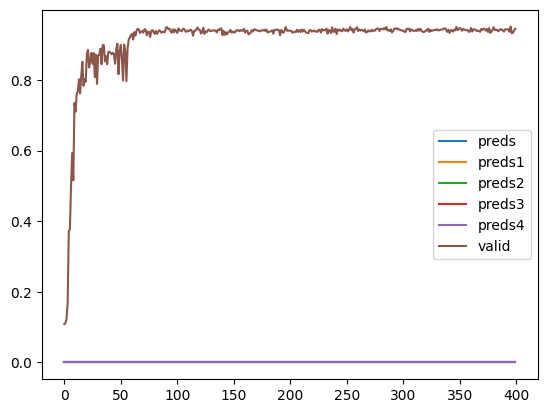

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/400 [00:00<?, ?it/s]

***训练集***
0.115


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/400 [00:15<1:44:22, 15.69s/it]

valid-f1: 0.07262815954827315
valid-precision: 0.10480957027768137
valid-recall: 0.13883288954315315
process: 1  loss: 57.464760541915894  train_correct: 0.00578652745455689 valid_loss 468.46860933303833  val_correct: 0.13409961685823754
The model has been saved!!
The best val_acc is  0.13409961685823754
***训练集***
0.13625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/400 [00:31<1:43:25, 15.59s/it]

valid-f1: 0.12654556779112727
valid-precision: 0.19684305826060372
valid-recall: 0.2134645840103727
process: 2  loss: 57.263872146606445  train_correct: 0.006855777092898924 valid_loss 465.552951335907  val_correct: 0.20429118773946361
The model has been saved!!
The best val_acc is  0.20429118773946361
***训练集***
0.18125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/400 [00:46<1:43:10, 15.59s/it]

valid-f1: 0.1698992070241217
valid-precision: 0.23060089364093997
valid-recall: 0.2597646007316974
process: 3  loss: 56.761749267578125  train_correct: 0.009120070444682056 valid_loss 459.12991738319397  val_correct: 0.258544061302682
The model has been saved!!
The best val_acc is  0.258544061302682
***训练集***
0.255


  1%|          | 4/400 [01:02<1:42:45, 15.57s/it]

valid-f1: 0.2719869018429321
valid-precision: 0.36790157549470215
valid-recall: 0.2926734835040631
process: 4  loss: 55.9125816822052  train_correct: 0.01283099566010441 valid_loss 443.80072462558746  val_correct: 0.2934865900383142
The model has been saved!!
The best val_acc is  0.2934865900383142
***训练集***
0.30875


  1%|▏         | 5/400 [01:18<1:42:56, 15.64s/it]

valid-f1: 0.22008663977642878
valid-precision: 0.395604937070901
valid-recall: 0.24984202683102605
process: 5  loss: 53.778770208358765  train_correct: 0.01553556827473426 valid_loss 421.4690697193146  val_correct: 0.2496551724137931
***训练集***
0.35875


  2%|▏         | 6/400 [01:33<1:42:34, 15.62s/it]

valid-f1: 0.30076178707105844
valid-precision: 0.3924750784539809
valid-recall: 0.3492430888727075
process: 6  loss: 49.42083251476288  train_correct: 0.018051449776715515 valid_loss 366.93493485450745  val_correct: 0.35908045977011493
The model has been saved!!
The best val_acc is  0.35908045977011493
***训练集***
0.4075


  2%|▏         | 7/400 [01:49<1:42:17, 15.62s/it]

valid-f1: 0.36260432749630206
valid-precision: 0.44505673355724973
valid-recall: 0.411480006416748
process: 7  loss: 44.008681297302246  train_correct: 0.020504434241147243 valid_loss 351.0949058532715  val_correct: 0.41977011494252875
The model has been saved!!
The best val_acc is  0.41977011494252875
***训练集***
0.4725


  2%|▏         | 8/400 [02:04<1:41:49, 15.59s/it]

valid-f1: 0.406283207897563
valid-precision: 0.5951714871752692
valid-recall: 0.46774944717604255
process: 8  loss: 40.40896165370941  train_correct: 0.023775080193722875 valid_loss 275.93349208682775  val_correct: 0.47478927203065135
The model has been saved!!
The best val_acc is  0.47478927203065135
***训练集***
0.5225


  2%|▏         | 9/400 [02:20<1:41:40, 15.60s/it]

valid-f1: 0.5347379309788585
valid-precision: 0.6434349196415907
valid-recall: 0.5868410803058506
process: 9  loss: 35.73882353305817  train_correct: 0.02629096169570413 valid_loss 242.2347509264946  val_correct: 0.5981609195402299
The model has been saved!!
The best val_acc is  0.5981609195402299
***训练集***
0.57125


  2%|▎         | 10/400 [02:35<1:41:15, 15.58s/it]

valid-f1: 0.6219105152422638
valid-precision: 0.6680249221988187
valid-recall: 0.6328362612731825
process: 10  loss: 32.293933510780334  train_correct: 0.02874394616013586 valid_loss 223.2480714097619  val_correct: 0.6386206896551724
The model has been saved!!
The best val_acc is  0.6386206896551724
***训练集***
0.625


  3%|▎         | 11/400 [02:51<1:41:16, 15.62s/it]

valid-f1: 0.6969616938686052
valid-precision: 0.7274786844268124
valid-recall: 0.7050719930229824
process: 11  loss: 29.1006618142128  train_correct: 0.03144851877476571 valid_loss 183.65714693069458  val_correct: 0.7109578544061302
The model has been saved!!
The best val_acc is  0.7109578544061302
***训练集***
0.66375


  3%|▎         | 12/400 [03:07<1:40:53, 15.60s/it]

valid-f1: 0.7562208615816886
valid-precision: 0.7748313393255104
valid-recall: 0.7578939210966267
process: 12  loss: 26.717963337898254  train_correct: 0.03339832693880118 valid_loss 170.67363719642162  val_correct: 0.7633716475095785
The model has been saved!!
The best val_acc is  0.7633716475095785
***训练集***
0.725


  3%|▎         | 13/400 [03:22<1:40:28, 15.58s/it]

valid-f1: 0.732291828866748
valid-precision: 0.7843161488773659
valid-recall: 0.7300168201244269
process: 13  loss: 23.66109037399292  train_correct: 0.036480281778728224 valid_loss 175.23512737452984  val_correct: 0.7373180076628353
***训练集***
0.72


  4%|▎         | 14/400 [03:38<1:40:02, 15.55s/it]

valid-f1: 0.7339052552303994
valid-precision: 0.7843606433302935
valid-recall: 0.7334473858074546
process: 14  loss: 22.629090785980225  train_correct: 0.036228693628530095 valid_loss 152.23117649555206  val_correct: 0.7437547892720306
***训练集***
0.73375


  4%|▍         | 15/400 [03:53<1:39:52, 15.56s/it]

valid-f1: 0.7555551403482497
valid-precision: 0.8335471603900686
valid-recall: 0.7464117654025059
process: 15  loss: 21.27860677242279  train_correct: 0.03692056104157494 valid_loss 170.2415000293404  val_correct: 0.7557088122605364
***训练集***
0.7575


  4%|▍         | 16/400 [04:09<1:39:34, 15.56s/it]

valid-f1: 0.7858492627079144
valid-precision: 0.7971525953747319
valid-recall: 0.7941487310998809
process: 16  loss: 20.336742877960205  train_correct: 0.03811560475501604 valid_loss 125.57040337845683  val_correct: 0.7986206896551724
The model has been saved!!
The best val_acc is  0.7986206896551724
***训练集***
0.76


  4%|▍         | 17/400 [04:25<1:39:25, 15.58s/it]

valid-f1: 0.8192427790296108
valid-precision: 0.8478696692911217
valid-recall: 0.8233792372387162
process: 17  loss: 19.274175465106964  train_correct: 0.038241398830115104 valid_loss 119.27349495515227  val_correct: 0.8398467432950192
The model has been saved!!
The best val_acc is  0.8398467432950192
***训练集***
0.76125


  4%|▍         | 18/400 [04:40<1:38:53, 15.53s/it]

valid-f1: 0.8136840740611943
valid-precision: 0.8305536620234626
valid-recall: 0.8237615151661298
process: 18  loss: 18.468669831752777  train_correct: 0.03830429586766463 valid_loss 120.61958115175366  val_correct: 0.8277394636015326
***训练集***
0.76625


  5%|▍         | 19/400 [04:56<1:38:46, 15.56s/it]

valid-f1: 0.8264776007255488
valid-precision: 0.8379682212454199
valid-recall: 0.8281729670728195
process: 19  loss: 17.46660742163658  train_correct: 0.03855588401786276 valid_loss 108.6202581115067  val_correct: 0.8424521072796934
The model has been saved!!
The best val_acc is  0.8424521072796934
***训练集***
0.77625


  5%|▌         | 20/400 [05:11<1:38:27, 15.55s/it]

valid-f1: 0.8648751394604657
valid-precision: 0.8755275739007183
valid-recall: 0.8639644873520037
process: 20  loss: 17.171952337026596  train_correct: 0.03905906031825901 valid_loss 96.22416834905744  val_correct: 0.8717241379310345
The model has been saved!!
The best val_acc is  0.8717241379310345
***训练集***
0.80375


  5%|▌         | 21/400 [05:27<1:38:12, 15.55s/it]

valid-f1: 0.7754063494039517
valid-precision: 0.8208700032376548
valid-recall: 0.778340795369618
process: 21  loss: 15.690146535634995  train_correct: 0.0404427951443487 valid_loss 127.73383012786508  val_correct: 0.788199233716475
***训练集***
0.8125


  6%|▌         | 22/400 [05:42<1:37:43, 15.51s/it]

valid-f1: 0.806578540670652
valid-precision: 0.8392187254516894
valid-recall: 0.8196514918372451
process: 22  loss: 14.748393207788467  train_correct: 0.04088307440719542 valid_loss 112.99480948597193  val_correct: 0.8190038314176246
***训练集***
0.8


  6%|▌         | 23/400 [05:58<1:37:34, 15.53s/it]

valid-f1: 0.82475899113062
valid-precision: 0.867601930400703
valid-recall: 0.8336957818352257
process: 23  loss: 15.235107988119125  train_correct: 0.04025410403170011 valid_loss 111.60019592288882  val_correct: 0.8479693486590039
***训练集***
0.79375


  6%|▌         | 24/400 [06:13<1:37:04, 15.49s/it]

valid-f1: 0.7618761069920299
valid-precision: 0.798887055648237
valid-recall: 0.7621280321198066
process: 24  loss: 15.683031499385834  train_correct: 0.03993961884395245 valid_loss 136.2129721357487  val_correct: 0.7701149425287356
***训练集***
0.82625


  6%|▋         | 25/400 [06:29<1:37:03, 15.53s/it]

valid-f1: 0.8039370142689204
valid-precision: 0.835538022127771
valid-recall: 0.8058439735745011
process: 25  loss: 13.733585119247437  train_correct: 0.04157494182024027 valid_loss 118.68104315176606  val_correct: 0.8053639846743295
***训练集***
0.845


  6%|▋         | 26/400 [06:44<1:36:36, 15.50s/it]

valid-f1: 0.8538208584719751
valid-precision: 0.871145709372662
valid-recall: 0.8526339895628808
process: 26  loss: 13.017363905906677  train_correct: 0.04251839738348324 valid_loss 91.20697062183172  val_correct: 0.8568582375478927
***训练集***
0.8375


  7%|▋         | 27/400 [07:00<1:36:40, 15.55s/it]

valid-f1: 0.8827924511050813
valid-precision: 0.8883152467268374
valid-recall: 0.8821811788474164
process: 27  loss: 13.069191336631775  train_correct: 0.04214101515818605 valid_loss 75.49395747110248  val_correct: 0.8896551724137931
The model has been saved!!
The best val_acc is  0.8896551724137931
***训练集***
0.83625


  7%|▋         | 28/400 [07:15<1:36:21, 15.54s/it]

valid-f1: 0.8485412586626172
valid-precision: 0.86045739008503
valid-recall: 0.8502971779630419
process: 28  loss: 12.924852728843689  train_correct: 0.04207811812063652 valid_loss 97.54977727099322  val_correct: 0.8586973180076628
***训练集***
0.83


  7%|▋         | 29/400 [07:31<1:36:13, 15.56s/it]

valid-f1: 0.8461318935683367
valid-precision: 0.8788695185512628
valid-recall: 0.8523105152432242
process: 29  loss: 13.310463041067123  train_correct: 0.04176363293288886 valid_loss 92.74120601266623  val_correct: 0.8626819923371648
***训练集***
0.82


  8%|▊         | 30/400 [07:46<1:35:43, 15.52s/it]

valid-f1: 0.8736171827133713
valid-precision: 0.8799630466037962
valid-recall: 0.8790567994395942
process: 30  loss: 13.579665288329124  train_correct: 0.04126045663249261 valid_loss 77.47563392855227  val_correct: 0.8809195402298851
***训练集***
0.83875


  8%|▊         | 31/400 [08:02<1:35:36, 15.55s/it]

valid-f1: 0.8697581767900632
valid-precision: 0.8762247619936364
valid-recall: 0.8716775672595446
process: 31  loss: 12.879723027348518  train_correct: 0.042203912195735584 valid_loss 78.88714240654372  val_correct: 0.8793869731800766
***训练集***
0.84875


  8%|▊         | 32/400 [08:17<1:35:14, 15.53s/it]

valid-f1: 0.8248914586772431
valid-precision: 0.8609732214623126
valid-recall: 0.8298386251948864
process: 32  loss: 11.799747869372368  train_correct: 0.042707088496131834 valid_loss 95.21434181183577  val_correct: 0.8275862068965517
***训练集***
0.85875


  8%|▊         | 33/400 [08:33<1:35:05, 15.55s/it]

valid-f1: 0.7900219461096395
valid-precision: 0.8197275087114984
valid-recall: 0.7953503767423189
process: 33  loss: 11.386361673474312  train_correct: 0.043210264796528085 valid_loss 123.24033098993823  val_correct: 0.8021455938697318
***训练集***
0.83625


  8%|▊         | 34/400 [08:48<1:34:41, 15.52s/it]

valid-f1: 0.8476351176943782
valid-precision: 0.8773279150677901
valid-recall: 0.848645707564029
process: 34  loss: 12.270282343029976  train_correct: 0.04207811812063652 valid_loss 99.04070410772692  val_correct: 0.8605363984674329
***训练集***
0.81875


  9%|▉         | 35/400 [09:04<1:34:24, 15.52s/it]

valid-f1: 0.8597181168507919
valid-precision: 0.8756265837629611
valid-recall: 0.863483026090732
process: 35  loss: 13.114917784929276  train_correct: 0.041197559594943076 valid_loss 87.46291116531938  val_correct: 0.8704980842911877
***训练集***
0.8525


  9%|▉         | 36/400 [09:19<1:34:07, 15.51s/it]

valid-f1: 0.85989509728329
valid-precision: 0.8739153779986506
valid-recall: 0.8611895648171988
process: 36  loss: 11.454164564609528  train_correct: 0.042895779608780424 valid_loss 91.81674992060289  val_correct: 0.8706513409961686
***训练集***
0.85875


  9%|▉         | 37/400 [09:35<1:33:56, 15.53s/it]

valid-f1: 0.8515372953248143
valid-precision: 0.8628254046695962
valid-recall: 0.8577893385952227
process: 37  loss: 11.723530948162079  train_correct: 0.043210264796528085 valid_loss 99.85305827856064  val_correct: 0.8632950191570882
***训练集***
0.83375


 10%|▉         | 38/400 [09:51<1:33:38, 15.52s/it]

valid-f1: 0.7814256812436661
valid-precision: 0.8199289308041978
valid-recall: 0.7951089762406496
process: 38  loss: 12.337177574634552  train_correct: 0.041952324045537455 valid_loss 138.11515127657913  val_correct: 0.7946360153256705
***训练集***
0.85125


 10%|▉         | 39/400 [10:06<1:33:33, 15.55s/it]

valid-f1: 0.8596989627111957
valid-precision: 0.8789212106369211
valid-recall: 0.8579333100679257
process: 39  loss: 11.091468781232834  train_correct: 0.04283288257123089 valid_loss 89.3103362089023  val_correct: 0.8628352490421456
***训练集***
0.86375


 10%|█         | 40/400 [10:22<1:33:08, 15.52s/it]

valid-f1: 0.850581763471928
valid-precision: 0.88920449261778
valid-recall: 0.85628769817397
process: 40  loss: 11.019035875797272  train_correct: 0.04346185294672621 valid_loss 99.86933155136649  val_correct: 0.869272030651341
***训练集***
0.87625


 10%|█         | 41/400 [10:37<1:32:50, 15.52s/it]

valid-f1: 0.8546312220907222
valid-precision: 0.8685761715312476
valid-recall: 0.8605014265600269
process: 41  loss: 9.454632058739662  train_correct: 0.04409082332222152 valid_loss 87.82374993152916  val_correct: 0.8608429118773946
***训练集***
0.85875


 10%|█         | 42/400 [10:53<1:32:26, 15.49s/it]

valid-f1: 0.8381016357175055
valid-precision: 0.8573420858812639
valid-recall: 0.8419977577163991
process: 42  loss: 11.452744901180267  train_correct: 0.043210264796528085 valid_loss 93.95926591288298  val_correct: 0.8458237547892721
***训练集***
0.86125


 11%|█         | 43/400 [11:08<1:32:28, 15.54s/it]

valid-f1: 0.8603816280760075
valid-precision: 0.8651572860148233
valid-recall: 0.865948081694178
process: 43  loss: 10.260825589299202  train_correct: 0.04333605887162715 valid_loss 77.1047470588237  val_correct: 0.8689655172413793
***训练集***
0.85625


 11%|█         | 44/400 [11:24<1:32:12, 15.54s/it]

valid-f1: 0.8899117709207843
valid-precision: 0.8939222937853272
valid-recall: 0.8899621399699049
process: 44  loss: 10.94589102268219  train_correct: 0.04308447072142902 valid_loss 75.15040220227093  val_correct: 0.8934865900383142
The model has been saved!!
The best val_acc is  0.8934865900383142
***训练集***
0.8625


 11%|█▏        | 45/400 [11:39<1:32:12, 15.58s/it]

valid-f1: 0.8488074902475923
valid-precision: 0.8606393760095383
valid-recall: 0.8541288784949334
process: 45  loss: 10.07531288266182  train_correct: 0.043398955909176674 valid_loss 95.28462347976165  val_correct: 0.8570114942528736
***训练集***
0.89125


 12%|█▏        | 46/400 [11:55<1:31:52, 15.57s/it]

valid-f1: 0.8990769701315677
valid-precision: 0.9091864241265055
valid-recall: 0.8981280050432574
process: 46  loss: 8.32516847550869  train_correct: 0.0448455877728159 valid_loss 63.86808296153322  val_correct: 0.9060536398467433
The model has been saved!!
The best val_acc is  0.9060536398467433
***训练集***
0.88


 12%|█▏        | 47/400 [12:11<1:31:59, 15.64s/it]

valid-f1: 0.907639567260755
valid-precision: 0.9094476509985696
valid-recall: 0.9079729942056349
process: 47  loss: 9.466611668467522  train_correct: 0.04427951443487012 valid_loss 63.23968322575092  val_correct: 0.9114176245210728
The model has been saved!!
The best val_acc is  0.9114176245210728
***训练集***
0.84625


 12%|█▏        | 48/400 [12:26<1:31:29, 15.59s/it]

valid-f1: 0.8557236110832187
valid-precision: 0.8660162355345609
valid-recall: 0.8582045254765202
process: 48  loss: 11.576700210571289  train_correct: 0.04258129442103277 valid_loss 94.81492366932798  val_correct: 0.8597701149425288
***训练集***
0.8725


 12%|█▏        | 49/400 [12:42<1:31:21, 15.62s/it]

valid-f1: 0.860862021778473
valid-precision: 0.8665671913973858
valid-recall: 0.8683179323481467
process: 49  loss: 10.239252045750618  train_correct: 0.04390213220957293 valid_loss 85.31696251151152  val_correct: 0.8694252873563219
***训练集***
0.86875


 12%|█▎        | 50/400 [12:57<1:30:53, 15.58s/it]

valid-f1: 0.8945316232296492
valid-precision: 0.8974605728951899
valid-recall: 0.8947210613957678
process: 50  loss: 9.766333118081093  train_correct: 0.043713441096924335 valid_loss 65.31069870246574  val_correct: 0.9013026819923372
***训练集***
0.84875


 13%|█▎        | 51/400 [13:13<1:30:35, 15.58s/it]

valid-f1: 0.844807473305524
valid-precision: 0.8509613142077479
valid-recall: 0.8504698710114262
process: 51  loss: 10.479779526591301  train_correct: 0.042707088496131834 valid_loss 91.75757285300642  val_correct: 0.8533333333333334
***训练集***
0.87375


 13%|█▎        | 52/400 [13:29<1:30:14, 15.56s/it]

valid-f1: 0.8619314060855136
valid-precision: 0.8655414648304536
valid-recall: 0.8631354347987186
process: 52  loss: 9.08300119638443  train_correct: 0.04396502924712246 valid_loss 81.93264544615522  val_correct: 0.8678927203065134
***训练集***
0.865


 13%|█▎        | 53/400 [13:44<1:30:00, 15.56s/it]

valid-f1: 0.8340082410067382
valid-precision: 0.8499462303990443
valid-recall: 0.8360744648934049
process: 53  loss: 9.750920981168747  train_correct: 0.04352474998427574 valid_loss 97.36119518335909  val_correct: 0.8377011494252874
***训练集***
0.85875


 14%|█▎        | 54/400 [14:00<1:29:39, 15.55s/it]

valid-f1: 0.8755795217862857
valid-precision: 0.8929165610623124
valid-recall: 0.87553454894508
process: 54  loss: 10.504334434866905  train_correct: 0.043210264796528085 valid_loss 80.21161373099312  val_correct: 0.8829118773946361
***训练集***
0.88375


 14%|█▍        | 55/400 [14:15<1:29:22, 15.54s/it]

valid-f1: 0.8536950985408499
valid-precision: 0.8622676722349916
valid-recall: 0.8577968099512567
process: 55  loss: 9.020713686943054  train_correct: 0.044468205547518715 valid_loss 78.98017719388008  val_correct: 0.8582375478927203
***训练集***
0.87375
开始蒸馏


 14%|█▍        | 56/400 [14:31<1:29:04, 15.54s/it]

valid-f1: 0.8640534700229144
valid-precision: 0.8893792918584671
valid-recall: 0.8688494433443008
process: 56  loss: 9.446618050336838  train_correct: 0.04396502924712246 valid_loss 83.42747011501342  val_correct: 0.8749425287356322
***训练集***
0.80625


 14%|█▍        | 57/400 [14:46<1:28:41, 15.51s/it]

valid-f1: 0.772316028503416
valid-precision: 0.8400692581083552
valid-recall: 0.7852154144149512
process: 57  loss: 2070.14266204834  train_correct: 0.04056858921944776 valid_loss 142.04888475774715  val_correct: 0.803831417624521
***训练集***
0.80875


 14%|█▍        | 58/400 [15:02<1:28:21, 15.50s/it]

valid-f1: 0.8860053485904734
valid-precision: 0.8931726984463463
valid-recall: 0.8860161270962031
process: 58  loss: 1237.510097503662  train_correct: 0.040694383294546825 valid_loss 78.43837644333144  val_correct: 0.8921072796934866
***训练集***
0.8025


 15%|█▍        | 59/400 [15:17<1:28:15, 15.53s/it]

valid-f1: 0.8740046194569994
valid-precision: 0.8779848712983729
valid-recall: 0.8811505586738203
process: 59  loss: 924.0963687896729  train_correct: 0.04037989810679917 valid_loss 84.48789661895717  val_correct: 0.8841379310344828
***训练集***
0.85875


 15%|█▌        | 60/400 [15:33<1:28:02, 15.54s/it]

valid-f1: 0.9226103170563059
valid-precision: 0.9292721450328966
valid-recall: 0.9229868900259726
process: 60  loss: 802.0727024078369  train_correct: 0.043210264796528085 valid_loss 55.35929638664675  val_correct: 0.9293486590038315
The model has been saved!!
The best val_acc is  0.9293486590038315
***训练集***
0.85125


 15%|█▌        | 61/400 [15:48<1:27:57, 15.57s/it]

valid-f1: 0.926771192321161
valid-precision: 0.9337813873111062
valid-recall: 0.9247784533660791
process: 61  loss: 684.9983940124512  train_correct: 0.04283288257123089 valid_loss 62.044795472618716  val_correct: 0.9318007662835249
The model has been saved!!
The best val_acc is  0.9318007662835249
***训练集***
0.8425


 16%|█▌        | 62/400 [16:04<1:27:26, 15.52s/it]

valid-f1: 0.9237760370389669
valid-precision: 0.9321313858731235
valid-recall: 0.9237271904481508
process: 62  loss: 671.0937519073486  train_correct: 0.04239260330838417 valid_loss 59.00284222925893  val_correct: 0.930727969348659
***训练集***
0.84875


 16%|█▌        | 63/400 [16:19<1:27:16, 15.54s/it]

valid-f1: 0.9189407923290458
valid-precision: 0.9382325917276019
valid-recall: 0.9163152111291492
process: 63  loss: 625.9704704284668  train_correct: 0.042707088496131834 valid_loss 81.97867189315798  val_correct: 0.9250574712643678
***训练集***
0.8475


 16%|█▌        | 64/400 [16:35<1:26:59, 15.53s/it]

valid-f1: 0.9047200087382825
valid-precision: 0.9268373644339679
valid-recall: 0.9044872117019486
process: 64  loss: 608.3607177734375  train_correct: 0.0426441914585823 valid_loss 82.87323270016896  val_correct: 0.9141762452107279
***训练集***
0.88


 16%|█▋        | 65/400 [16:51<1:27:08, 15.61s/it]

valid-f1: 0.9112585797359728
valid-precision: 0.9226936057910828
valid-recall: 0.9084645662294653
process: 65  loss: 550.8170108795166  train_correct: 0.04427951443487012 valid_loss 83.2652163372486  val_correct: 0.9158620689655173
***训练集***
0.8875


 16%|█▋        | 66/400 [17:06<1:26:36, 15.56s/it]

valid-f1: 0.9189245540190388
valid-precision: 0.931021918092193
valid-recall: 0.9191014444303629
process: 66  loss: 530.1485195159912  train_correct: 0.044656896660167304 valid_loss 70.06548928032134  val_correct: 0.9270498084291188
***训练集***
0.88125


 17%|█▋        | 67/400 [17:22<1:26:30, 15.59s/it]

valid-f1: 0.9230679512662772
valid-precision: 0.9333756573295513
valid-recall: 0.9228077823286638
process: 67  loss: 520.8795146942139  train_correct: 0.04434241147241965 valid_loss 67.00465369083076  val_correct: 0.9301149425287356
***训练集***
0.87875


 17%|█▋        | 68/400 [17:37<1:26:14, 15.59s/it]

valid-f1: 0.928582097763137
valid-precision: 0.9330511459911423
valid-recall: 0.9287354408424269
process: 68  loss: 524.3632640838623  train_correct: 0.044216617397320586 valid_loss 54.27483442812354  val_correct: 0.9340996168582375
The model has been saved!!
The best val_acc is  0.9340996168582375
***训练集***
0.89375


 17%|█▋        | 69/400 [17:53<1:26:01, 15.59s/it]

valid-f1: 0.9113081958213893
valid-precision: 0.9254475405311385
valid-recall: 0.9103264611479244
process: 69  loss: 503.95870208740234  train_correct: 0.044971381847914965 valid_loss 76.38224500210879  val_correct: 0.9189272030651341
***训练集***
0.88125


 18%|█▊        | 70/400 [18:09<1:25:43, 15.59s/it]

valid-f1: 0.9170207314716601
valid-precision: 0.9302192156679343
valid-recall: 0.9168652854366262
process: 70  loss: 478.0537509918213  train_correct: 0.04434241147241965 valid_loss 71.1987751758839  val_correct: 0.9247509578544061
***训练集***
0.8875


 18%|█▊        | 71/400 [18:24<1:25:25, 15.58s/it]

valid-f1: 0.9187320766262749
valid-precision: 0.9301127683255979
valid-recall: 0.9177126310865246
process: 71  loss: 466.57880210876465  train_correct: 0.044656896660167304 valid_loss 69.80848423450004  val_correct: 0.925823754789272
***训练集***
0.89


 18%|█▊        | 72/400 [18:40<1:24:55, 15.54s/it]

valid-f1: 0.9232361807578215
valid-precision: 0.9350976989631912
valid-recall: 0.9232503024703116
process: 72  loss: 449.2016267776489  train_correct: 0.04478269073526637 valid_loss 65.80054135972568  val_correct: 0.9310344827586207
***训练集***
0.885


 18%|█▊        | 73/400 [18:55<1:24:50, 15.57s/it]

valid-f1: 0.9381026645836069
valid-precision: 0.9405383880264875
valid-recall: 0.93709160433516
process: 73  loss: 454.273964881897  train_correct: 0.04453110258506824 valid_loss 49.80972255906818  val_correct: 0.9420689655172414
The model has been saved!!
The best val_acc is  0.9420689655172414
***训练集***
0.875


 18%|█▊        | 74/400 [19:11<1:24:25, 15.54s/it]

valid-f1: 0.9087918838616273
valid-precision: 0.9235739364472844
valid-recall: 0.9081950924952137
process: 74  loss: 468.434250831604  train_correct: 0.04402792628467199 valid_loss 76.53670583117349  val_correct: 0.9169348659003831
***训练集***
0.9


 19%|█▉        | 75/400 [19:26<1:24:16, 15.56s/it]

valid-f1: 0.9227639788703226
valid-precision: 0.9255489756015288
valid-recall: 0.9224951845065485
process: 75  loss: 430.6454658508301  train_correct: 0.04528586703566262 valid_loss 59.71977025815886  val_correct: 0.9282758620689655
***训练集***
0.895


 19%|█▉        | 76/400 [19:42<1:23:49, 15.52s/it]

valid-f1: 0.9109242847965986
valid-precision: 0.927363475276068
valid-recall: 0.9130908674971211
process: 76  loss: 435.1361675262451  train_correct: 0.0450342788854645 valid_loss 81.02274922458437  val_correct: 0.9212260536398468
***训练集***
0.895


 19%|█▉        | 77/400 [19:57<1:23:40, 15.54s/it]

valid-f1: 0.92546256378815
valid-precision: 0.9355750702698717
valid-recall: 0.925051414451864
process: 77  loss: 436.5133981704712  train_correct: 0.0450342788854645 valid_loss 61.125006214328096  val_correct: 0.9324137931034483
***训练集***
0.8975


 20%|█▉        | 78/400 [20:13<1:23:18, 15.52s/it]

valid-f1: 0.9203980281383293
valid-precision: 0.9251877577004569
valid-recall: 0.9210309101308013
process: 78  loss: 425.26289653778076  train_correct: 0.045160072960563555 valid_loss 58.30581853232525  val_correct: 0.9284291187739464
***训练集***
0.8775


 20%|█▉        | 79/400 [20:28<1:23:13, 15.56s/it]

valid-f1: 0.9171680586710791
valid-precision: 0.928872354824507
valid-recall: 0.9174471518127516
process: 79  loss: 412.54456901550293  train_correct: 0.044153720359771054 valid_loss 61.433782921251805  val_correct: 0.9255172413793104
***训练集***
0.90625


 20%|██        | 80/400 [20:44<1:22:45, 15.52s/it]

valid-f1: 0.909564456416627
valid-precision: 0.9245699853080381
valid-recall: 0.9089018270179213
process: 80  loss: 405.4095211029053  train_correct: 0.04560035222341028 valid_loss 77.23340558432145  val_correct: 0.9173946360153257
***训练集***
0.88125


 20%|██        | 81/400 [20:59<1:22:43, 15.56s/it]

valid-f1: 0.9299438281149893
valid-precision: 0.9374733662534208
valid-recall: 0.9293653399344729
process: 81  loss: 404.7186670303345  train_correct: 0.04434241147241965 valid_loss 63.34511751486525  val_correct: 0.9367049808429119
***训练集***
0.915


 20%|██        | 82/400 [21:15<1:22:18, 15.53s/it]

valid-f1: 0.932203333282907
valid-precision: 0.9422967930031161
valid-recall: 0.9318877320485317
process: 82  loss: 391.0548038482666  train_correct: 0.046040631486257 valid_loss 55.70961757199359  val_correct: 0.9393103448275862
***训练集***
0.91375


 21%|██        | 83/400 [21:31<1:22:11, 15.56s/it]

valid-f1: 0.9114777012100082
valid-precision: 0.9223869942293842
valid-recall: 0.9125893395186286
process: 83  loss: 382.5707721710205  train_correct: 0.045977734448707466 valid_loss 70.31662671450076  val_correct: 0.9204597701149425
***训练集***
0.8875


 21%|██        | 84/400 [21:46<1:21:45, 15.52s/it]

valid-f1: 0.9142865842097482
valid-precision: 0.92914610468166
valid-recall: 0.9155976165553428
process: 84  loss: 412.9616174697876  train_correct: 0.044656896660167304 valid_loss 68.64163610472121  val_correct: 0.9244444444444444
***训练集***
0.895


 21%|██▏       | 85/400 [22:02<1:21:44, 15.57s/it]

valid-f1: 0.9317089026554501
valid-precision: 0.9328237106649331
valid-recall: 0.9315183247331668
process: 85  loss: 389.1933488845825  train_correct: 0.0450342788854645 valid_loss 50.86241025390831  val_correct: 0.9360919540229885
***训练集***
0.89625


 22%|██▏       | 86/400 [22:17<1:21:18, 15.54s/it]

valid-f1: 0.9198652465155156
valid-precision: 0.9276062290599734
valid-recall: 0.9187166276428593
process: 86  loss: 387.0002393722534  train_correct: 0.04509717592301402 valid_loss 64.30944742975316  val_correct: 0.9261302681992337
***训练集***
0.90625


 22%|██▏       | 87/400 [22:33<1:21:05, 15.55s/it]

valid-f1: 0.9066649308065365
valid-precision: 0.9241448187588194
valid-recall: 0.9089464461783061
process: 87  loss: 393.51636695861816  train_correct: 0.04560035222341028 valid_loss 76.82707779297357  val_correct: 0.9175478927203066
***训练集***
0.90375


 22%|██▏       | 88/400 [22:48<1:20:47, 15.54s/it]

valid-f1: 0.9211752589047546
valid-precision: 0.9281383675000161
valid-recall: 0.9216084686625905
process: 88  loss: 368.1506881713867  train_correct: 0.045474558148311216 valid_loss 59.86014332278398  val_correct: 0.9287356321839081
***训练集***
0.9


 22%|██▏       | 89/400 [23:04<1:20:27, 15.52s/it]

valid-f1: 0.9125654919815993
valid-precision: 0.9235697176270584
valid-recall: 0.9136628335713448
process: 89  loss: 384.4950590133667  train_correct: 0.04528586703566262 valid_loss 64.40225724992195  val_correct: 0.9213793103448276
***训练集***
0.90125


 22%|██▎       | 90/400 [23:19<1:20:11, 15.52s/it]

valid-f1: 0.9155652973979784
valid-precision: 0.9192328630737603
valid-recall: 0.9160180051502109
process: 90  loss: 371.0135974884033  train_correct: 0.04534876407321215 valid_loss 59.545890223491824  val_correct: 0.9221455938697318
***训练集***
0.93125


 23%|██▎       | 91/400 [23:35<1:20:02, 15.54s/it]

valid-f1: 0.9226210654410384
valid-precision: 0.9305508876395576
valid-recall: 0.9239580681749603
process: 91  loss: 368.99517726898193  train_correct: 0.0468582929744009 valid_loss 60.20812055263241  val_correct: 0.9311877394636016
***训练集***
0.9025


 23%|██▎       | 92/400 [23:50<1:19:37, 15.51s/it]

valid-f1: 0.9264476618906989
valid-precision: 0.9313196367472385
valid-recall: 0.9261270878577005
process: 92  loss: 360.4926748275757  train_correct: 0.045411661110761684 valid_loss 57.14478254517917  val_correct: 0.931647509578544
***训练集***
0.9125


 23%|██▎       | 93/400 [24:06<1:19:36, 15.56s/it]

valid-f1: 0.9066092995119904
valid-precision: 0.9254973805097899
valid-recall: 0.9088464472392781
process: 93  loss: 368.67787742614746  train_correct: 0.045914837411157934 valid_loss 77.3374615014859  val_correct: 0.9181609195402299
***训练集***
0.9


 24%|██▎       | 94/400 [24:21<1:19:12, 15.53s/it]

valid-f1: 0.9203061184722904
valid-precision: 0.9289255304983334
valid-recall: 0.9176805994137297
process: 94  loss: 361.374342918396  train_correct: 0.04528586703566262 valid_loss 72.26270698159264  val_correct: 0.9247509578544061
***训练集***
0.89875


 24%|██▍       | 95/400 [24:37<1:18:58, 15.54s/it]

valid-f1: 0.9162531107299152
valid-precision: 0.9317737260291394
valid-recall: 0.9177938813981683
process: 95  loss: 360.0687322616577  train_correct: 0.04522296999811309 valid_loss 74.44231746827168  val_correct: 0.9259770114942528
***训练集***
0.91


 24%|██▍       | 96/400 [24:52<1:18:41, 15.53s/it]

valid-f1: 0.9027015391044847
valid-precision: 0.9231505142792751
valid-recall: 0.9043691248021088
process: 96  loss: 353.22503185272217  train_correct: 0.04578904333605887 valid_loss 89.63870625218104  val_correct: 0.9140229885057471
***训练集***
0.9025


 24%|██▍       | 97/400 [25:08<1:18:27, 15.54s/it]

valid-f1: 0.9111738621978811
valid-precision: 0.9298042888551302
valid-recall: 0.9130888838513436
process: 97  loss: 347.1705799102783  train_correct: 0.045411661110761684 valid_loss 77.52856197248934  val_correct: 0.9226053639846743
***训练集***
0.89375


 24%|██▍       | 98/400 [25:24<1:18:16, 15.55s/it]

valid-f1: 0.9145684237757628
valid-precision: 0.9296807482391619
valid-recall: 0.9152490044274468
process: 98  loss: 344.9944381713867  train_correct: 0.044971381847914965 valid_loss 69.7102224750272  val_correct: 0.9242911877394636
***训练集***
0.9325


 25%|██▍       | 99/400 [25:39<1:18:02, 15.56s/it]

valid-f1: 0.9174008401154703
valid-precision: 0.9342633860189007
valid-recall: 0.9191573790365857
process: 99  loss: 337.55144119262695  train_correct: 0.046921190011950435 valid_loss 72.6832352632797  val_correct: 0.9275095785440614
***训练集***
0.925


 25%|██▌       | 100/400 [25:55<1:17:48, 15.56s/it]

valid-f1: 0.9235231240532027
valid-precision: 0.9338033283033745
valid-recall: 0.924333624432351
process: 100  loss: 342.792516708374  train_correct: 0.04654380778665325 valid_loss 61.709368762268696  val_correct: 0.931647509578544
***训练集***
0.90625


 25%|██▌       | 101/400 [26:10<1:17:39, 15.58s/it]

valid-f1: 0.9295200970187054
valid-precision: 0.935010105432128
valid-recall: 0.9298055125224384
process: 101  loss: 346.92730617523193  train_correct: 0.04560035222341028 valid_loss 53.423634915129696  val_correct: 0.9368582375478928
***训练集***
0.91875


 26%|██▌       | 102/400 [26:26<1:17:10, 15.54s/it]

valid-f1: 0.9214348540617397
valid-precision: 0.9344408860494463
valid-recall: 0.9226801100794455
process: 102  loss: 338.60574436187744  train_correct: 0.04622932259890559 valid_loss 68.25749737026433  val_correct: 0.9310344827586207
***训练集***
0.8975


 26%|██▌       | 103/400 [26:41<1:17:04, 15.57s/it]

valid-f1: 0.9219512836590515
valid-precision: 0.9331581446889452
valid-recall: 0.9236541927155029
process: 103  loss: 344.9983949661255  train_correct: 0.045160072960563555 valid_loss 57.93252286010102  val_correct: 0.9314942528735632
***训练集***
0.91125


 26%|██▌       | 104/400 [26:57<1:16:50, 15.58s/it]

valid-f1: 0.9270041562601679
valid-precision: 0.9401401715666424
valid-recall: 0.9269995408687226
process: 104  loss: 346.94729232788086  train_correct: 0.0458519403736084 valid_loss 66.71923087878298  val_correct: 0.9353256704980842
***训练集***
0.9075


 26%|██▋       | 105/400 [27:13<1:16:48, 15.62s/it]

valid-f1: 0.9180894569207527
valid-precision: 0.9303153132869134
valid-recall: 0.9193483554147749
process: 105  loss: 348.0053195953369  train_correct: 0.045663249260959805 valid_loss 66.78488566722916  val_correct: 0.9276628352490421
***训练集***
0.91


 26%|██▋       | 106/400 [27:28<1:16:22, 15.59s/it]

valid-f1: 0.9197900203891199
valid-precision: 0.9349001142200208
valid-recall: 0.9223651189879192
process: 106  loss: 337.6693706512451  train_correct: 0.04578904333605887 valid_loss 70.45764888375288  val_correct: 0.9310344827586207
***训练集***
0.915


 27%|██▋       | 107/400 [27:44<1:16:03, 15.57s/it]

valid-f1: 0.9200239007038181
valid-precision: 0.9289701360495428
valid-recall: 0.9209076360503117
process: 107  loss: 334.26813220977783  train_correct: 0.046040631486257 valid_loss 63.49488088427137  val_correct: 0.9285823754789272
***训练集***
0.9125


 27%|██▋       | 108/400 [27:59<1:15:43, 15.56s/it]

valid-f1: 0.9233207276624402
valid-precision: 0.9318514883906692
valid-recall: 0.9231795052478565
process: 108  loss: 321.66234588623047  train_correct: 0.045914837411157934 valid_loss 64.58880890135708  val_correct: 0.9310344827586207
***训练集***
0.93125
开始蒸馏


 27%|██▋       | 109/400 [28:15<1:15:18, 15.53s/it]

valid-f1: 0.9072753407538239
valid-precision: 0.9223154734177001
valid-recall: 0.9095885190644438
process: 109  loss: 325.8415012359619  train_correct: 0.0468582929744009 valid_loss 74.37904238134325  val_correct: 0.9184674329501916
***训练集***
0.91625


 28%|██▊       | 110/400 [28:30<1:14:55, 15.50s/it]

valid-f1: 0.9156060223907817
valid-precision: 0.9310522290813742
valid-recall: 0.9184331842697633
process: 110  loss: 321.01130867004395  train_correct: 0.04610352852380653 valid_loss 71.6940075368475  val_correct: 0.9275095785440614
***训练集***
0.925


 28%|██▊       | 111/400 [28:46<1:14:44, 15.52s/it]

valid-f1: 0.912816227423596
valid-precision: 0.9236227770761113
valid-recall: 0.9144902935971395
process: 111  loss: 335.68354320526123  train_correct: 0.04654380778665325 valid_loss 67.49889441677578  val_correct: 0.9219923371647509
***训练集***
0.9175


 28%|██▊       | 112/400 [29:01<1:14:34, 15.54s/it]

valid-f1: 0.9099425458581332
valid-precision: 0.9199915998335714
valid-recall: 0.9110257260080754
process: 112  loss: 329.2826671600342  train_correct: 0.04616642556135606 valid_loss 67.32863255204165  val_correct: 0.9181609195402299
***训练集***
0.93375


 28%|██▊       | 113/400 [29:17<1:14:16, 15.53s/it]

valid-f1: 0.912130999592374
valid-precision: 0.9259572411560377
valid-recall: 0.9140153773934688
process: 113  loss: 318.36699199676514  train_correct: 0.04698408704949997 valid_loss 71.22222383693246  val_correct: 0.9219923371647509
***训练集***
0.90375


 28%|██▊       | 114/400 [29:32<1:14:09, 15.56s/it]

valid-f1: 0.9305597053683311
valid-precision: 0.9424049310754248
valid-recall: 0.9300874357563801
process: 114  loss: 329.4659643173218  train_correct: 0.045474558148311216 valid_loss 59.992939089212086  val_correct: 0.9377777777777778
***训练集***
0.92875


 29%|██▉       | 115/400 [29:48<1:13:56, 15.57s/it]

valid-f1: 0.9176054435782198
valid-precision: 0.9305727003939209
valid-recall: 0.9187504461079568
process: 115  loss: 317.2547731399536  train_correct: 0.046732498899301846 valid_loss 69.31491253446279  val_correct: 0.9275095785440614
***训练集***
0.92125


 29%|██▉       | 116/400 [30:04<1:13:43, 15.58s/it]

valid-f1: 0.929007529400079
valid-precision: 0.9340928004782413
valid-recall: 0.9278390814294075
process: 116  loss: 325.02710723876953  train_correct: 0.04635511667400465 valid_loss 57.0960480810507  val_correct: 0.933639846743295
***训练集***
0.9075


 29%|██▉       | 117/400 [30:19<1:13:23, 15.56s/it]

valid-f1: 0.911831153809118
valid-precision: 0.9269455058619167
valid-recall: 0.9126699227363086
process: 117  loss: 319.81457805633545  train_correct: 0.045663249260959805 valid_loss 73.21137768457379  val_correct: 0.9210727969348659
***训练集***
0.92125


 30%|██▉       | 118/400 [30:35<1:13:09, 15.57s/it]

valid-f1: 0.9232122863757688
valid-precision: 0.9331095345890192
valid-recall: 0.9234971281351335
process: 118  loss: 312.12435817718506  train_correct: 0.04635511667400465 valid_loss 63.77985866739277  val_correct: 0.9310344827586207
***训练集***
0.92375


 30%|██▉       | 119/400 [30:50<1:12:50, 15.55s/it]

valid-f1: 0.9209522607409262
valid-precision: 0.9327851471928282
valid-recall: 0.9220563292855906
process: 119  loss: 305.95643615722656  train_correct: 0.04648091074910372 valid_loss 66.46956455265513  val_correct: 0.930727969348659
***训练集***
0.92


 30%|███       | 120/400 [31:06<1:12:40, 15.57s/it]

valid-f1: 0.9196288363544873
valid-precision: 0.9308403035731546
valid-recall: 0.9207335857306995
process: 120  loss: 305.95576190948486  train_correct: 0.04629221963645512 valid_loss 69.85623280248228  val_correct: 0.9293486590038315
***训练集***
0.92


 30%|███       | 121/400 [31:21<1:12:17, 15.55s/it]

valid-f1: 0.9183587597743619
valid-precision: 0.9273447039713381
valid-recall: 0.919066500397224
process: 121  loss: 309.8919973373413  train_correct: 0.04629221963645512 valid_loss 62.21615799762128  val_correct: 0.9265900383141762
***训练集***
0.91875


 30%|███       | 122/400 [31:37<1:12:08, 15.57s/it]

valid-f1: 0.9244939286347517
valid-precision: 0.935161058726254
valid-recall: 0.9253274986940985
process: 122  loss: 312.86676025390625  train_correct: 0.04622932259890559 valid_loss 59.80060780887561  val_correct: 0.9331800766283525
***训练集***
0.9125
开始蒸馏


 31%|███       | 123/400 [31:52<1:11:41, 15.53s/it]

valid-f1: 0.919998704810053
valid-precision: 0.931286189587228
valid-recall: 0.9199448274787537
process: 123  loss: 306.4966707229614  train_correct: 0.045914837411157934 valid_loss 67.30381541106777  val_correct: 0.927816091954023
***训练集***
0.91625


 31%|███       | 124/400 [32:08<1:11:28, 15.54s/it]

valid-f1: 0.9251722667289373
valid-precision: 0.9333693639120355
valid-recall: 0.9262442558516881
process: 124  loss: 308.5443744659424  train_correct: 0.04610352852380653 valid_loss 58.255145170174956  val_correct: 0.933639846743295
***训练集***
0.94125


 31%|███▏      | 125/400 [32:24<1:11:18, 15.56s/it]

valid-f1: 0.9199941124681142
valid-precision: 0.9289701712908908
valid-recall: 0.9203071799211677
process: 125  loss: 312.68732833862305  train_correct: 0.04736146927479716 valid_loss 63.33128231041002  val_correct: 0.9275095785440614
***训练集***
0.92


 32%|███▏      | 126/400 [32:39<1:11:07, 15.58s/it]

valid-f1: 0.9181991468037192
valid-precision: 0.9329591134122722
valid-recall: 0.9191817362927599
process: 126  loss: 296.4848222732544  train_correct: 0.04629221963645512 valid_loss 69.83415478054326  val_correct: 0.9276628352490421
***训练集***
0.9175


 32%|███▏      | 127/400 [32:55<1:10:53, 15.58s/it]

valid-f1: 0.909868126755233
valid-precision: 0.9289165332261767
valid-recall: 0.9122718432416155
process: 127  loss: 305.6148748397827  train_correct: 0.04616642556135606 valid_loss 79.38953052647821  val_correct: 0.9218390804597701
***训练集***
0.91125


 32%|███▏      | 128/400 [33:10<1:10:37, 15.58s/it]

valid-f1: 0.9065427999468165
valid-precision: 0.928383306772942
valid-recall: 0.9099493380138759
process: 128  loss: 310.42094326019287  train_correct: 0.0458519403736084 valid_loss 79.24634125182956  val_correct: 0.9198467432950191
***训练集***
0.90875


 32%|███▏      | 129/400 [33:26<1:10:18, 15.57s/it]

valid-f1: 0.9224937015519694
valid-precision: 0.9318782743780529
valid-recall: 0.922756754907863
process: 129  loss: 300.7096834182739  train_correct: 0.04572614629850934 valid_loss 62.14216186021207  val_correct: 0.9299616858237548
***训练集***
0.915


 32%|███▎      | 130/400 [33:42<1:10:06, 15.58s/it]

valid-f1: 0.9207850876172035
valid-precision: 0.9319886222914624
valid-recall: 0.9212434616170885
process: 130  loss: 295.7430257797241  train_correct: 0.046040631486257 valid_loss 66.07331155825307  val_correct: 0.9287356321839081
***训练集***
0.93625


 33%|███▎      | 131/400 [33:57<1:09:48, 15.57s/it]

valid-f1: 0.9186018786598146
valid-precision: 0.9311218422732563
valid-recall: 0.919978033150344
process: 131  loss: 304.46045112609863  train_correct: 0.04710988112459903 valid_loss 72.91955951274485  val_correct: 0.9281226053639847
***训练集***
0.93


 33%|███▎      | 132/400 [34:13<1:09:32, 15.57s/it]

valid-f1: 0.9179716112726014
valid-precision: 0.9350082031407692
valid-recall: 0.9188758115920008
process: 132  loss: 302.28568935394287  train_correct: 0.04679539593685137 valid_loss 77.02562938661958  val_correct: 0.927816091954023
***训练集***
0.92625


 33%|███▎      | 133/400 [34:28<1:09:04, 15.52s/it]

valid-f1: 0.9252616392230519
valid-precision: 0.9333541458714139
valid-recall: 0.9248430199586913
process: 133  loss: 287.7696475982666  train_correct: 0.04660670482420278 valid_loss 60.34786078708703  val_correct: 0.9313409961685823
***训练集***
0.91625


 34%|███▎      | 134/400 [34:44<1:09:00, 15.57s/it]

valid-f1: 0.9244155396241384
valid-precision: 0.9342654624177168
valid-recall: 0.9255138969148435
process: 134  loss: 298.0977907180786  train_correct: 0.04610352852380653 valid_loss 59.033393959423506  val_correct: 0.9331800766283525
***训练集***
0.92125
开始蒸馏


 34%|███▍      | 135/400 [34:59<1:08:43, 15.56s/it]

valid-f1: 0.9145762727951879
valid-precision: 0.9305221499930149
valid-recall: 0.916180440725876
process: 135  loss: 295.90157890319824  train_correct: 0.04635511667400465 valid_loss 74.44379541500757  val_correct: 0.924904214559387
***训练集***
0.9275


 34%|███▍      | 136/400 [35:15<1:08:25, 15.55s/it]

valid-f1: 0.9264269881287325
valid-precision: 0.9363912108853155
valid-recall: 0.9269536621863921
process: 136  loss: 294.5268745422363  train_correct: 0.04666960186175231 valid_loss 57.90739754945275  val_correct: 0.9345593869731801
***训练集***
0.9225


 34%|███▍      | 137/400 [35:30<1:08:09, 15.55s/it]

valid-f1: 0.9300067730756506
valid-precision: 0.9380421343519302
valid-recall: 0.9276146297073466
process: 137  loss: 293.10510444641113  train_correct: 0.046418013711554185 valid_loss 56.657540746809445  val_correct: 0.9342528735632184
***训练集***
0.935


 34%|███▍      | 138/400 [35:46<1:07:56, 15.56s/it]

valid-f1: 0.9086171844450298
valid-precision: 0.9295840297236687
valid-recall: 0.9108025597587555
process: 138  loss: 319.6584720611572  train_correct: 0.0470469840870495 valid_loss 83.26111448128461  val_correct: 0.9212260536398468
***训练集***
0.905


 35%|███▍      | 139/400 [36:02<1:07:48, 15.59s/it]

valid-f1: 0.9119179938668497
valid-precision: 0.929902839977349
valid-recall: 0.9145318045502432
process: 139  loss: 308.0301294326782  train_correct: 0.04553745518586075 valid_loss 74.43088536452797  val_correct: 0.9242911877394636
***训练集***
0.92125


 35%|███▌      | 140/400 [36:18<1:08:22, 15.78s/it]

valid-f1: 0.9169552828688733
valid-precision: 0.9302512206436578
valid-recall: 0.9168283367951583
process: 140  loss: 288.21037006378174  train_correct: 0.04635511667400465 valid_loss 66.53936132166456  val_correct: 0.924904214559387
***训练集***
0.93125


 35%|███▌      | 141/400 [36:34<1:08:41, 15.91s/it]

valid-f1: 0.915008356944376
valid-precision: 0.9312303973044787
valid-recall: 0.9162824038012335
process: 141  loss: 285.3128824234009  train_correct: 0.0468582929744009 valid_loss 74.28346285595177  val_correct: 0.9247509578544061
***训练集***
0.93625


 36%|███▌      | 142/400 [36:50<1:08:00, 15.82s/it]

valid-f1: 0.9183744934922142
valid-precision: 0.9332005477378331
valid-recall: 0.9203532276617713
process: 142  loss: 285.27092838287354  train_correct: 0.04710988112459903 valid_loss 73.91837767174292  val_correct: 0.9288888888888889
***训练集***
0.905


 36%|███▌      | 143/400 [37:05<1:07:19, 15.72s/it]

valid-f1: 0.9257742025693275
valid-precision: 0.9337195989994337
valid-recall: 0.9262255956467914
process: 143  loss: 298.2778387069702  train_correct: 0.04553745518586075 valid_loss 58.66507541760575  val_correct: 0.933639846743295
***训练集***
0.9425


 36%|███▌      | 144/400 [37:21<1:06:55, 15.69s/it]

valid-f1: 0.9192453688214586
valid-precision: 0.932437099908938
valid-recall: 0.9205748371197732
process: 144  loss: 293.8742866516113  train_correct: 0.047424366312346686 valid_loss 68.83165866708669  val_correct: 0.9290421455938698
***训练集***
0.91625


 36%|███▋      | 145/400 [37:36<1:06:30, 15.65s/it]

valid-f1: 0.9218519723189523
valid-precision: 0.9285021592778016
valid-recall: 0.9221812174926081
process: 145  loss: 282.4252805709839  train_correct: 0.04610352852380653 valid_loss 59.513248310078154  val_correct: 0.9288888888888889
***训练集***
0.915


 36%|███▋      | 146/400 [37:52<1:06:15, 15.65s/it]

valid-f1: 0.9135924614200904
valid-precision: 0.9250561655298414
valid-recall: 0.9160452948811798
process: 146  loss: 281.32033348083496  train_correct: 0.046040631486257 valid_loss 72.66052362110594  val_correct: 0.923831417624521
***训练集***
0.90875


 37%|███▋      | 147/400 [38:07<1:05:45, 15.60s/it]

valid-f1: 0.913835881661082
valid-precision: 0.9302357873720369
valid-recall: 0.9164119065329466
process: 147  loss: 291.90442180633545  train_correct: 0.04572614629850934 valid_loss 75.72273617130554  val_correct: 0.9250574712643678
***训练集***
0.925


 37%|███▋      | 148/400 [38:23<1:05:32, 15.61s/it]

valid-f1: 0.9105509246669495
valid-precision: 0.925190857529485
valid-recall: 0.9125916246410757
process: 148  loss: 287.5955276489258  train_correct: 0.04654380778665325 valid_loss 74.31275807989368  val_correct: 0.9215325670498085
***训练集***
0.92875


 37%|███▋      | 149/400 [38:39<1:05:13, 15.59s/it]

valid-f1: 0.9231683816429465
valid-precision: 0.9297352795941419
valid-recall: 0.9243125630927205
process: 149  loss: 296.33934688568115  train_correct: 0.046732498899301846 valid_loss 58.09264829124436  val_correct: 0.9311877394636016
***训练集***
0.92125


 38%|███▊      | 150/400 [38:54<1:05:07, 15.63s/it]

valid-f1: 0.9139955278709444
valid-precision: 0.927948054076786
valid-recall: 0.915888861173914
process: 150  loss: 285.8850860595703  train_correct: 0.04635511667400465 valid_loss 72.63955683571746  val_correct: 0.924904214559387
***训练集***
0.92125


 38%|███▊      | 151/400 [39:10<1:04:47, 15.61s/it]

valid-f1: 0.9268830806586017
valid-precision: 0.9346648598771494
valid-recall: 0.9267052876143325
process: 151  loss: 277.4849634170532  train_correct: 0.04635511667400465 valid_loss 57.06605012150453  val_correct: 0.9337931034482758
***训练集***
0.9275


 38%|███▊      | 152/400 [39:25<1:04:27, 15.60s/it]

valid-f1: 0.9174270683466453
valid-precision: 0.9315732588057493
valid-recall: 0.9185644552683148
process: 152  loss: 281.2965974807739  train_correct: 0.04666960186175231 valid_loss 67.99937659702391  val_correct: 0.9272030651340997
***训练集***
0.90625


 38%|███▊      | 153/400 [39:41<1:04:05, 15.57s/it]

valid-f1: 0.918624393222576
valid-precision: 0.9285957577492023
valid-recall: 0.9186630516969163
process: 153  loss: 290.77909755706787  train_correct: 0.04560035222341028 valid_loss 66.9927974472858  val_correct: 0.9265900383141762
***训练集***
0.9
开始蒸馏


 38%|███▊      | 154/400 [39:57<1:03:55, 15.59s/it]

valid-f1: 0.9041577440879512
valid-precision: 0.9146821681941969
valid-recall: 0.9059116563938929
process: 154  loss: 279.21616077423096  train_correct: 0.04528586703566262 valid_loss 75.94120725997709  val_correct: 0.9138697318007662
***训练集***
0.9325


 39%|███▉      | 155/400 [40:12<1:03:28, 15.54s/it]

valid-f1: 0.9012752898627715
valid-precision: 0.9233657361085952
valid-recall: 0.9038555223394724
process: 155  loss: 301.98252391815186  train_correct: 0.046921190011950435 valid_loss 81.36836720107414  val_correct: 0.9135632183908046
***训练集***
0.92


 39%|███▉      | 156/400 [40:28<1:03:19, 15.57s/it]

valid-f1: 0.9228055254055393
valid-precision: 0.9284286874058585
valid-recall: 0.9231996385176782
process: 156  loss: 283.2120780944824  train_correct: 0.04629221963645512 valid_loss 59.79181818540917  val_correct: 0.9296551724137931
***训练集***
0.91375


 39%|███▉      | 157/400 [40:43<1:02:55, 15.54s/it]

valid-f1: 0.9281132659549287
valid-precision: 0.9316271954176905
valid-recall: 0.9289578938246675
process: 157  loss: 291.22764778137207  train_correct: 0.045977734448707466 valid_loss 54.02110131124124  val_correct: 0.9350191570881226
***训练集***
0.925


 40%|███▉      | 158/400 [40:59<1:02:50, 15.58s/it]

valid-f1: 0.9257507880361352
valid-precision: 0.9300257106978483
valid-recall: 0.9269203989378484
process: 158  loss: 283.74525356292725  train_correct: 0.04654380778665325 valid_loss 56.486790531143924  val_correct: 0.9333333333333333
***训练集***
0.93


 40%|███▉      | 159/400 [41:14<1:02:28, 15.56s/it]

valid-f1: 0.9091758358982936
valid-precision: 0.9290572188295407
valid-recall: 0.9118302380457826
process: 159  loss: 272.4065818786621  train_correct: 0.04679539593685137 valid_loss 74.39959771892312  val_correct: 0.9215325670498085
***训练集***
0.92625


 40%|████      | 160/400 [41:30<1:02:14, 15.56s/it]

valid-f1: 0.9198556907139759
valid-precision: 0.9326470258136388
valid-recall: 0.9200481882804616
process: 160  loss: 269.3806266784668  train_correct: 0.04660670482420278 valid_loss 67.7200672397421  val_correct: 0.9282758620689655
***训练集***
0.9375


 40%|████      | 161/400 [41:45<1:01:49, 15.52s/it]

valid-f1: 0.9156112787195566
valid-precision: 0.9325933728879997
valid-recall: 0.9176891531294034
process: 161  loss: 262.4741144180298  train_correct: 0.047172778162148564 valid_loss 73.5012917233438  val_correct: 0.9267432950191571
***训练集***
0.9125


 40%|████      | 162/400 [42:01<1:01:41, 15.55s/it]

valid-f1: 0.9169497232844469
valid-precision: 0.9331371146204418
valid-recall: 0.918768393492558
process: 162  loss: 275.1219482421875  train_correct: 0.045914837411157934 valid_loss 73.89894100849546  val_correct: 0.9279693486590038
***训练集***
0.9075


 41%|████      | 163/400 [42:16<1:01:21, 15.53s/it]

valid-f1: 0.9204454576353808
valid-precision: 0.9349341356055852
valid-recall: 0.9214116358047345
process: 163  loss: 290.08181285858154  train_correct: 0.045663249260959805 valid_loss 62.99862159322424  val_correct: 0.9299616858237548
***训练集***
0.9175


 41%|████      | 164/400 [42:32<1:01:11, 15.56s/it]

valid-f1: 0.9228843426300897
valid-precision: 0.9302327568852228
valid-recall: 0.923572868784927
process: 164  loss: 282.943660736084  train_correct: 0.04616642556135606 valid_loss 62.316838228677454  val_correct: 0.9310344827586207
***训练集***
0.935


 41%|████▏     | 165/400 [42:48<1:01:03, 15.59s/it]

valid-f1: 0.922909522822339
valid-precision: 0.9340479901605845
valid-recall: 0.9230789102002923
process: 165  loss: 273.3550052642822  train_correct: 0.0470469840870495 valid_loss 63.09486920322934  val_correct: 0.9311877394636016
***训练集***
0.91625


 42%|████▏     | 166/400 [43:03<1:00:40, 15.56s/it]

valid-f1: 0.916564767608077
valid-precision: 0.9268148281916944
valid-recall: 0.9191562627030754
process: 166  loss: 273.59152126312256  train_correct: 0.04610352852380653 valid_loss 67.96388458628161  val_correct: 0.926896551724138
***训练集***
0.92625


 42%|████▏     | 167/400 [43:19<1:00:23, 15.55s/it]

valid-f1: 0.9177624301956737
valid-precision: 0.9332307019364598
valid-recall: 0.9195248814249739
process: 167  loss: 267.75739097595215  train_correct: 0.04660670482420278 valid_loss 70.9111570299674  val_correct: 0.9287356321839081
***训练集***
0.9375


 42%|████▏     | 168/400 [43:34<1:00:02, 15.53s/it]

valid-f1: 0.9218913297715563
valid-precision: 0.9293545395160885
valid-recall: 0.9232021906513008
process: 168  loss: 271.960337638855  train_correct: 0.047172778162148564 valid_loss 63.580943894230245  val_correct: 0.9305747126436782
***训练集***
0.9225


 42%|████▏     | 169/400 [43:50<59:44, 15.52s/it]  

valid-f1: 0.9184397590053084
valid-precision: 0.9306357403931669
valid-recall: 0.9190008543505523
process: 169  loss: 272.1292715072632  train_correct: 0.046418013711554185 valid_loss 67.77762900657524  val_correct: 0.9275095785440614
***训练集***
0.92625


 42%|████▎     | 170/400 [44:05<59:30, 15.52s/it]

valid-f1: 0.913353958546694
valid-precision: 0.9280692408992011
valid-recall: 0.9155951530188406
process: 170  loss: 270.73479175567627  train_correct: 0.04660670482420278 valid_loss 70.49723684468302  val_correct: 0.9242911877394636
***训练集***
0.92125


 43%|████▎     | 171/400 [44:21<59:13, 15.52s/it]

valid-f1: 0.9096782610052007
valid-precision: 0.9198751354464066
valid-recall: 0.9119188703239131
process: 171  loss: 282.9958095550537  train_correct: 0.04635511667400465 valid_loss 72.0382420098008  val_correct: 0.9195402298850575
***训练集***
0.92125


 43%|████▎     | 172/400 [44:36<59:08, 15.56s/it]

valid-f1: 0.918506328935465
valid-precision: 0.932544765842691
valid-recall: 0.9204035222025112
process: 172  loss: 267.92867851257324  train_correct: 0.04635511667400465 valid_loss 69.43657614762208  val_correct: 0.9290421455938698
***训练集***
0.91375


 43%|████▎     | 173/400 [44:52<58:48, 15.54s/it]

valid-f1: 0.9125340520312202
valid-precision: 0.9228308773183451
valid-recall: 0.9142023324661604
process: 173  loss: 282.73881816864014  train_correct: 0.045977734448707466 valid_loss 71.6887731166517  val_correct: 0.9218390804597701
***训练集***
0.91


 44%|████▎     | 174/400 [45:07<58:30, 15.53s/it]

valid-f1: 0.9167133409724633
valid-precision: 0.9283093839212093
valid-recall: 0.9190459329549565
process: 174  loss: 270.99706745147705  train_correct: 0.04578904333605887 valid_loss 70.1685246659639  val_correct: 0.9272030651340997
***训练集***
0.93125


 44%|████▍     | 175/400 [45:23<58:11, 15.52s/it]

valid-f1: 0.9106396734235801
valid-precision: 0.9243139426147525
valid-recall: 0.912575922393739
process: 175  loss: 271.0359420776367  train_correct: 0.0468582929744009 valid_loss 73.37744236769777  val_correct: 0.9209195402298851
***训练集***
0.92


 44%|████▍     | 176/400 [45:39<58:00, 15.54s/it]

valid-f1: 0.9200818532194581
valid-precision: 0.9277037706613951
valid-recall: 0.9213150057028251
process: 176  loss: 261.8409767150879  train_correct: 0.04629221963645512 valid_loss 63.698126433483594  val_correct: 0.9288888888888889
***训练集***
0.9225


 44%|████▍     | 177/400 [45:54<57:42, 15.53s/it]

valid-f1: 0.9174755672183423
valid-precision: 0.9312721713966466
valid-recall: 0.9198111588006528
process: 177  loss: 270.81053924560547  train_correct: 0.046418013711554185 valid_loss 71.47979196340782  val_correct: 0.9284291187739464
***训练集***
0.915


 44%|████▍     | 178/400 [46:10<57:30, 15.54s/it]

valid-f1: 0.915856787781142
valid-precision: 0.9283815634857533
valid-recall: 0.9157051483770715
process: 178  loss: 268.2041349411011  train_correct: 0.046040631486257 valid_loss 73.74549665933978  val_correct: 0.9236781609195402
***训练集***
0.92375


 45%|████▍     | 179/400 [46:25<57:12, 15.53s/it]

valid-f1: 0.9152308140326078
valid-precision: 0.9248959506254844
valid-recall: 0.9156215414885847
process: 179  loss: 262.82480907440186  train_correct: 0.04648091074910372 valid_loss 69.12456489225738  val_correct: 0.9232183908045977
***训练集***
0.92375


 45%|████▌     | 180/400 [46:41<57:01, 15.55s/it]

valid-f1: 0.9086963875525186
valid-precision: 0.9256583196713869
valid-recall: 0.909059421046976
process: 180  loss: 270.76696395874023  train_correct: 0.04648091074910372 valid_loss 75.79897361181284  val_correct: 0.9184674329501916
***训练集***
0.92125


 45%|████▌     | 181/400 [46:56<56:40, 15.53s/it]

valid-f1: 0.9180863923364944
valid-precision: 0.925045963098104
valid-recall: 0.9188638358277246
process: 181  loss: 265.6539993286133  train_correct: 0.04635511667400465 valid_loss 62.58216078414944  val_correct: 0.925823754789272
***训练集***
0.9275


 46%|████▌     | 182/400 [47:12<56:28, 15.54s/it]

valid-f1: 0.9114564702531875
valid-precision: 0.9283715581417082
valid-recall: 0.9150587612897498
process: 182  loss: 271.89149951934814  train_correct: 0.04666960186175231 valid_loss 76.82052934947933  val_correct: 0.9241379310344827
***训练集***
0.9375


 46%|████▌     | 183/400 [47:27<56:12, 15.54s/it]

valid-f1: 0.9186548208081249
valid-precision: 0.9270332363995772
valid-recall: 0.919832705785824
process: 183  loss: 264.80155849456787  train_correct: 0.047172778162148564 valid_loss 65.91417556854293  val_correct: 0.9272030651340997
***训练集***
0.93625


 46%|████▌     | 184/400 [47:43<56:00, 15.56s/it]

valid-f1: 0.9152739458271737
valid-precision: 0.9282030392937829
valid-recall: 0.9164095052081208
process: 184  loss: 260.0489845275879  train_correct: 0.04710988112459903 valid_loss 71.31685630040693  val_correct: 0.9250574712643678
***训练集***
0.92125


 46%|████▋     | 185/400 [47:58<55:48, 15.58s/it]

valid-f1: 0.9070205396242041
valid-precision: 0.9248179229796414
valid-recall: 0.9106093025118517
process: 185  loss: 252.398175239563  train_correct: 0.04635511667400465 valid_loss 81.43711393584806  val_correct: 0.9198467432950191
***训练集***
0.91875


 46%|████▋     | 186/400 [48:14<55:29, 15.56s/it]

valid-f1: 0.9070015795413278
valid-precision: 0.9193455067633746
valid-recall: 0.908863534522158
process: 186  loss: 268.8029098510742  train_correct: 0.04622932259890559 valid_loss 75.73798654167251  val_correct: 0.9166283524904214
***训练集***
0.9125


 47%|████▋     | 187/400 [48:30<55:13, 15.56s/it]

valid-f1: 0.9192936452113653
valid-precision: 0.9277012830009908
valid-recall: 0.918773833720129
process: 187  loss: 262.0481128692627  train_correct: 0.045914837411157934 valid_loss 67.81477129308047  val_correct: 0.9256704980842911
***训练集***
0.9225


 47%|████▋     | 188/400 [48:45<54:58, 15.56s/it]

valid-f1: 0.9161138469908586
valid-precision: 0.9276963193545276
valid-recall: 0.9166718220450283
process: 188  loss: 273.37489652633667  train_correct: 0.046418013711554185 valid_loss 69.41745583558412  val_correct: 0.9245977011494253
***训练集***
0.94625


 47%|████▋     | 189/400 [49:01<54:40, 15.55s/it]

valid-f1: 0.9187885801813991
valid-precision: 0.9302797774390262
valid-recall: 0.9208536533270266
process: 189  loss: 263.4955778121948  train_correct: 0.04761305742499528 valid_loss 68.14483147883584  val_correct: 0.9290421455938698
***训练集***
0.92


 48%|████▊     | 190/400 [49:16<54:25, 15.55s/it]

valid-f1: 0.9237944837288314
valid-precision: 0.9325512587710497
valid-recall: 0.924429565868178
process: 190  loss: 254.66451358795166  train_correct: 0.04629221963645512 valid_loss 64.40384233730379  val_correct: 0.9314942528735632
***训练集***
0.92375


 48%|████▊     | 191/400 [49:32<54:08, 15.54s/it]

valid-f1: 0.9161813731862131
valid-precision: 0.9298319272578219
valid-recall: 0.9182809398825498
process: 191  loss: 255.19550132751465  train_correct: 0.04648091074910372 valid_loss 70.3966042515849  val_correct: 0.9270498084291188
***训练集***
0.935


 48%|████▊     | 192/400 [49:47<53:49, 15.53s/it]

valid-f1: 0.9199924495223548
valid-precision: 0.9288690692796628
valid-recall: 0.9203258863362279
process: 192  loss: 250.09938621520996  train_correct: 0.0470469840870495 valid_loss 68.38269529140882  val_correct: 0.927816091954023
***训练集***
0.92875


 48%|████▊     | 193/400 [50:03<53:36, 15.54s/it]

valid-f1: 0.9164140095333753
valid-precision: 0.923936217420813
valid-recall: 0.9181940692245222
process: 193  loss: 255.00562572479248  train_correct: 0.046732498899301846 valid_loss 64.96179154954211  val_correct: 0.9255172413793104
***训练集***
0.92625


 48%|████▊     | 194/400 [50:18<53:24, 15.56s/it]

valid-f1: 0.9153566386237093
valid-precision: 0.9263859648300944
valid-recall: 0.9177167517774867
process: 194  loss: 257.3536539077759  train_correct: 0.04660670482420278 valid_loss 71.920207977892  val_correct: 0.9255172413793104
***训练集***
0.93375


 49%|████▉     | 195/400 [50:34<53:04, 15.54s/it]

valid-f1: 0.913631284879048
valid-precision: 0.9290580901877137
valid-recall: 0.9158604785123343
process: 195  loss: 264.86828231811523  train_correct: 0.04698408704949997 valid_loss 75.14097617519741  val_correct: 0.9245977011494253
***训练集***
0.92125


 49%|████▉     | 196/400 [50:49<52:47, 15.53s/it]

valid-f1: 0.9132258622052749
valid-precision: 0.9277508577651951
valid-recall: 0.9157114968966658
process: 196  loss: 251.40093898773193  train_correct: 0.04635511667400465 valid_loss 75.55080706115962  val_correct: 0.9247509578544061
***训练集***
0.9275


 49%|████▉     | 197/400 [51:05<52:32, 15.53s/it]

valid-f1: 0.9232609232448471
valid-precision: 0.9332160935216376
valid-recall: 0.9232634031161421
process: 197  loss: 248.02782344818115  train_correct: 0.04666960186175231 valid_loss 64.45385232212499  val_correct: 0.9305747126436782
***训练集***
0.9275


 50%|████▉     | 198/400 [51:20<52:18, 15.54s/it]

valid-f1: 0.9111591907636134
valid-precision: 0.9248206690205194
valid-recall: 0.9126314397679736
process: 198  loss: 254.70431804656982  train_correct: 0.04666960186175231 valid_loss 75.59962533197472  val_correct: 0.9210727969348659
***训练集***
0.9225
开始蒸馏


 50%|████▉     | 199/400 [51:36<51:58, 15.51s/it]

valid-f1: 0.911185211878769
valid-precision: 0.926782560932016
valid-recall: 0.9140233989117983
process: 199  loss: 258.02349758148193  train_correct: 0.046418013711554185 valid_loss 74.7212421035203  val_correct: 0.9227586206896552
***训练集***
0.9375


 50%|█████     | 200/400 [51:52<51:49, 15.55s/it]

valid-f1: 0.9251808519419662
valid-precision: 0.9333909810092716
valid-recall: 0.9252465928142884
process: 200  loss: 243.1033821105957  train_correct: 0.047172778162148564 valid_loss 67.48255031426493  val_correct: 0.9321072796934866
***训练集***
0.94625


 50%|█████     | 201/400 [52:07<51:30, 15.53s/it]

valid-f1: 0.9080656015344521
valid-precision: 0.9240404375550192
valid-recall: 0.9106562240913624
process: 201  loss: 246.718599319458  train_correct: 0.04761305742499528 valid_loss 76.9360370259223  val_correct: 0.9195402298850575
***训练集***
0.93


 50%|█████     | 202/400 [52:23<51:21, 15.57s/it]

valid-f1: 0.9187764885514724
valid-precision: 0.9284356825113711
valid-recall: 0.9192069984234458
process: 202  loss: 253.18370246887207  train_correct: 0.04679539593685137 valid_loss 68.9438547338126  val_correct: 0.9267432950191571
***训练集***
0.9275


 51%|█████     | 203/400 [52:38<51:05, 15.56s/it]

valid-f1: 0.9177120574509781
valid-precision: 0.9281608160887158
valid-recall: 0.9178317894286169
process: 203  loss: 260.6286382675171  train_correct: 0.04666960186175231 valid_loss 71.55755705284764  val_correct: 0.9256704980842911
***训练集***
0.93875


 51%|█████     | 204/400 [52:54<50:55, 15.59s/it]

valid-f1: 0.9222352639864692
valid-precision: 0.9317202596536088
valid-recall: 0.9229875514462208
process: 204  loss: 244.29642581939697  train_correct: 0.047235675199698096 valid_loss 67.09127616414423  val_correct: 0.9302681992337165
***训练集***
0.92375


 51%|█████▏    | 205/400 [53:09<50:39, 15.59s/it]

valid-f1: 0.9205493684822429
valid-precision: 0.9292582105498663
valid-recall: 0.9209244596420991
process: 205  loss: 256.97711277008057  train_correct: 0.04648091074910372 valid_loss 68.2511205287916  val_correct: 0.9273563218390805
***训练集***
0.93625


 52%|█████▏    | 206/400 [53:25<50:22, 15.58s/it]

valid-f1: 0.9225701785562433
valid-precision: 0.9345615334508877
valid-recall: 0.924950238597171
process: 206  loss: 258.37666606903076  train_correct: 0.04710988112459903 valid_loss 67.01403057879133  val_correct: 0.9331800766283525
***训练集***
0.92


 52%|█████▏    | 207/400 [53:41<50:09, 15.59s/it]

valid-f1: 0.9224789584004196
valid-precision: 0.9313804348190688
valid-recall: 0.922743077312132
process: 207  loss: 253.98624515533447  train_correct: 0.04629221963645512 valid_loss 68.90352707443526  val_correct: 0.9299616858237548
***训练集***
0.92875


 52%|█████▏    | 208/400 [53:56<49:53, 15.59s/it]

valid-f1: 0.9201377551479135
valid-precision: 0.9320767020920601
valid-recall: 0.9201930468690958
process: 208  loss: 241.8546290397644  train_correct: 0.046732498899301846 valid_loss 71.42109701009417  val_correct: 0.9282758620689655
***训练集***
0.9375


 52%|█████▏    | 209/400 [54:12<49:33, 15.57s/it]

valid-f1: 0.9220182701315002
valid-precision: 0.9340255391274729
valid-recall: 0.9230470046906003
process: 209  loss: 247.99336767196655  train_correct: 0.047172778162148564 valid_loss 68.81655487709122  val_correct: 0.9311877394636016
***训练集***
0.9275


 52%|█████▎    | 210/400 [54:27<49:11, 15.54s/it]

valid-f1: 0.9187028986889839
valid-precision: 0.9253922807704031
valid-recall: 0.9187528098317014
process: 210  loss: 249.42407512664795  train_correct: 0.04666960186175231 valid_loss 71.17982788721477  val_correct: 0.924904214559387
***训练集***
0.93
开始蒸馏


 53%|█████▎    | 211/400 [54:43<48:49, 15.50s/it]

valid-f1: 0.9162441389172201
valid-precision: 0.9307263547991298
valid-recall: 0.9174863381515509
process: 211  loss: 248.37889099121094  train_correct: 0.04679539593685137 valid_loss 74.47257859413332  val_correct: 0.9255172413793104
***训练集***
0.9225


 53%|█████▎    | 212/400 [54:58<48:39, 15.53s/it]

valid-f1: 0.9189595028678754
valid-precision: 0.9302847755185626
valid-recall: 0.9195127888917604
process: 212  loss: 256.62252616882324  train_correct: 0.046418013711554185 valid_loss 72.83808129803853  val_correct: 0.9267432950191571
***训练集***
0.9375


 53%|█████▎    | 213/400 [55:14<48:21, 15.52s/it]

valid-f1: 0.9138320681309203
valid-precision: 0.9276168630899019
valid-recall: 0.9159851760537834
process: 213  loss: 249.5235047340393  train_correct: 0.047172778162148564 valid_loss 73.46935585899817  val_correct: 0.9239846743295019
***训练集***
0.9375


 54%|█████▎    | 214/400 [55:29<48:08, 15.53s/it]

valid-f1: 0.923270492117583
valid-precision: 0.9353637756197266
valid-recall: 0.9238257908690606
process: 214  loss: 246.45763206481934  train_correct: 0.047172778162148564 valid_loss 68.56833268127718  val_correct: 0.931647509578544
***训练集***
0.9275


 54%|█████▍    | 215/400 [55:45<47:47, 15.50s/it]

valid-f1: 0.9244398598398789
valid-precision: 0.9334931184460056
valid-recall: 0.9245639166814122
process: 215  loss: 241.25126600265503  train_correct: 0.04666960186175231 valid_loss 65.07133534347551  val_correct: 0.9319540229885057
***训练集***
0.92625


 54%|█████▍    | 216/400 [56:00<47:34, 15.51s/it]

valid-f1: 0.9269717716387929
valid-precision: 0.9364020143930238
valid-recall: 0.9268171632294562
process: 216  loss: 260.6890630722046  train_correct: 0.04660670482420278 valid_loss 65.90613906429667  val_correct: 0.9342528735632184
***训练集***
0.93125


 54%|█████▍    | 217/400 [56:16<47:15, 15.49s/it]

valid-f1: 0.9177365648497139
valid-precision: 0.9326739400789723
valid-recall: 0.9195818522584901
process: 217  loss: 258.2483253479004  train_correct: 0.0468582929744009 valid_loss 72.52516001989466  val_correct: 0.9282758620689655
***训练集***
0.925


 55%|█████▍    | 218/400 [56:31<47:01, 15.50s/it]

valid-f1: 0.9214870604799816
valid-precision: 0.9315369979941135
valid-recall: 0.9225991211949
process: 218  loss: 256.64692878723145  train_correct: 0.04654380778665325 valid_loss 69.87045686668827  val_correct: 0.9304214559386973
***训练集***
0.91


 55%|█████▍    | 219/400 [56:47<46:42, 15.48s/it]

valid-f1: 0.9294950786911794
valid-precision: 0.9368083406680725
valid-recall: 0.9301129349335178
process: 219  loss: 253.01117610931396  train_correct: 0.04578904333605887 valid_loss 59.728497843299465  val_correct: 0.9368582375478928
***训练集***
0.94


 55%|█████▌    | 220/400 [57:02<46:33, 15.52s/it]

valid-f1: 0.9138193617312715
valid-precision: 0.9276336426014845
valid-recall: 0.9153432966028694
process: 220  loss: 240.42109775543213  train_correct: 0.04729857223724763 valid_loss 75.02930139766102  val_correct: 0.9233716475095786
***训练集***
0.925


 55%|█████▌    | 221/400 [57:18<46:16, 15.51s/it]

valid-f1: 0.930962058591253
valid-precision: 0.9399744966973833
valid-recall: 0.9303848437333562
process: 221  loss: 248.85845375061035  train_correct: 0.04654380778665325 valid_loss 62.72696266294747  val_correct: 0.9371647509578545
***训练集***
0.94125


 56%|█████▌    | 222/400 [57:33<46:03, 15.53s/it]

valid-f1: 0.9278988766096041
valid-precision: 0.9353670137612458
valid-recall: 0.9275471251919394
process: 222  loss: 247.0943489074707  train_correct: 0.04736146927479716 valid_loss 64.81331401804593  val_correct: 0.9340996168582375
***训练集***
0.92


 56%|█████▌    | 223/400 [57:49<45:46, 15.52s/it]

valid-f1: 0.9246651991342046
valid-precision: 0.9342440815390708
valid-recall: 0.9253582678155816
process: 223  loss: 256.8070983886719  train_correct: 0.04629221963645512 valid_loss 62.89432293872869  val_correct: 0.9330268199233717
***训练集***
0.92


 56%|█████▌    | 224/400 [58:04<45:32, 15.53s/it]

valid-f1: 0.9232109465531902
valid-precision: 0.9322624953014428
valid-recall: 0.9230718094873204
process: 224  loss: 242.98418283462524  train_correct: 0.04629221963645512 valid_loss 69.55612965412263  val_correct: 0.9302681992337165
***训练集***
0.935


 56%|█████▋    | 225/400 [58:20<45:16, 15.52s/it]

valid-f1: 0.9282376414116642
valid-precision: 0.9364043725727328
valid-recall: 0.9281399609163559
process: 225  loss: 246.68090534210205  train_correct: 0.0470469840870495 valid_loss 61.08101513389022  val_correct: 0.9350191570881226
***训练集***
0.92875


 56%|█████▋    | 226/400 [58:35<45:01, 15.52s/it]

valid-f1: 0.9181063722971157
valid-precision: 0.9329120334995018
valid-recall: 0.9196384449421686
process: 226  loss: 238.59661293029785  train_correct: 0.046732498899301846 valid_loss 74.1024961338357  val_correct: 0.927816091954023
***训练集***
0.9375


 57%|█████▋    | 227/400 [58:51<44:44, 15.51s/it]

valid-f1: 0.916002918193277
valid-precision: 0.9263195870328615
valid-recall: 0.917473575373676
process: 227  loss: 237.49512338638306  train_correct: 0.047172778162148564 valid_loss 70.77994461837329  val_correct: 0.924904214559387
***训练集***
0.93625


 57%|█████▋    | 228/400 [59:07<44:32, 15.54s/it]

valid-f1: 0.9140177334835196
valid-precision: 0.9281267418881394
valid-recall: 0.9158465087361701
process: 228  loss: 239.19635009765625  train_correct: 0.04710988112459903 valid_loss 73.35749033663183  val_correct: 0.9241379310344827
***训练集***
0.92625


 57%|█████▋    | 229/400 [59:22<44:13, 15.52s/it]

valid-f1: 0.9192088220221567
valid-precision: 0.934076102562772
valid-recall: 0.9215599933564143
process: 229  loss: 242.85497903823853  train_correct: 0.04660670482420278 valid_loss 69.89605381352783  val_correct: 0.9301149425287356
***训练集***
0.92125


 57%|█████▊    | 230/400 [59:38<44:03, 15.55s/it]

valid-f1: 0.9227354213991086
valid-precision: 0.9316905750807752
valid-recall: 0.9228111992313386
process: 230  loss: 253.41021537780762  train_correct: 0.04635511667400465 valid_loss 60.78855032568026  val_correct: 0.9302681992337165
***训练集***
0.91625


 58%|█████▊    | 231/400 [59:53<43:43, 15.53s/it]

valid-f1: 0.9180602551035951
valid-precision: 0.9294753988729884
valid-recall: 0.9206096767958902
process: 231  loss: 244.28728818893433  train_correct: 0.04610352852380653 valid_loss 67.45385336496088  val_correct: 0.9287356321839081
***训练集***
0.92


 58%|█████▊    | 232/400 [1:00:09<43:37, 15.58s/it]

valid-f1: 0.9241646010047688
valid-precision: 0.9343081379192141
valid-recall: 0.9242329305643077
process: 232  loss: 241.53587818145752  train_correct: 0.04629221963645512 valid_loss 62.48871325398267  val_correct: 0.9318007662835249
***训练集***
0.92875


 58%|█████▊    | 233/400 [1:00:24<43:17, 15.56s/it]

valid-f1: 0.9195946440744098
valid-precision: 0.9333615227941967
valid-recall: 0.9209153019015073
process: 233  loss: 232.4070644378662  train_correct: 0.046732498899301846 valid_loss 68.51212476202662  val_correct: 0.9291954022988506
***训练集***
0.9325


 58%|█████▊    | 234/400 [1:00:40<43:00, 15.54s/it]

valid-f1: 0.9298217242368224
valid-precision: 0.9369110370627401
valid-recall: 0.9297318299211398
process: 234  loss: 238.788019657135  train_correct: 0.046921190011950435 valid_loss 61.083012120608714  val_correct: 0.9362452107279694
***训练集***
0.92


 59%|█████▉    | 235/400 [1:00:55<42:40, 15.52s/it]

valid-f1: 0.9277977343913923
valid-precision: 0.9359093166206985
valid-recall: 0.9264032854083879
process: 235  loss: 242.36798524856567  train_correct: 0.04629221963645512 valid_loss 64.46766430229167  val_correct: 0.9331800766283525
***训练集***
0.92125


 59%|█████▉    | 236/400 [1:01:11<42:29, 15.54s/it]

valid-f1: 0.9323284912393479
valid-precision: 0.9384055845469937
valid-recall: 0.9317074050385749
process: 236  loss: 240.5242486000061  train_correct: 0.04635511667400465 valid_loss 58.90173100227776  val_correct: 0.9380842911877395
***训练集***
0.91375


 59%|█████▉    | 237/400 [1:01:26<42:10, 15.52s/it]

valid-f1: 0.9245045437346953
valid-precision: 0.9332410293509685
valid-recall: 0.9244997343402044
process: 237  loss: 244.88846349716187  train_correct: 0.045977734448707466 valid_loss 66.88148502500553  val_correct: 0.9308812260536399
***训练集***
0.92875


 60%|█████▉    | 238/400 [1:01:42<42:01, 15.56s/it]

valid-f1: 0.9195961507174971
valid-precision: 0.9320188422301005
valid-recall: 0.919883901449676
process: 238  loss: 246.37051582336426  train_correct: 0.046732498899301846 valid_loss 73.64382370074804  val_correct: 0.9276628352490421
***训练集***
0.9275


 60%|█████▉    | 239/400 [1:01:57<41:42, 15.54s/it]

valid-f1: 0.922636100065735
valid-precision: 0.9338961146570373
valid-recall: 0.9236785343158875
process: 239  loss: 253.6972255706787  train_correct: 0.04666960186175231 valid_loss 70.3670652659697  val_correct: 0.9311877394636016
***训练集***
0.92375


 60%|██████    | 240/400 [1:02:13<41:26, 15.54s/it]

valid-f1: 0.9345108052241953
valid-precision: 0.9398908479929565
valid-recall: 0.9334001739302213
process: 240  loss: 255.58213710784912  train_correct: 0.04648091074910372 valid_loss 59.88245965545991  val_correct: 0.9396168582375479
***训练集***
0.94375


 60%|██████    | 241/400 [1:02:29<41:08, 15.53s/it]

valid-f1: 0.9324670080570454
valid-precision: 0.9383803691473414
valid-recall: 0.93205622332617
process: 241  loss: 255.05045223236084  train_correct: 0.04748726334989622 valid_loss 59.252376202999585  val_correct: 0.9380842911877395
***训练集***
0.9325


 60%|██████    | 242/400 [1:02:44<40:53, 15.53s/it]

valid-f1: 0.9223672728056433
valid-precision: 0.9315229702632282
valid-recall: 0.9230847286007535
process: 242  loss: 245.19644260406494  train_correct: 0.046921190011950435 valid_loss 69.41434193514095  val_correct: 0.9305747126436782
***训练集***
0.92625


 61%|██████    | 243/400 [1:03:00<40:38, 15.53s/it]

valid-f1: 0.9116695882714823
valid-precision: 0.9251655988902954
valid-recall: 0.9144095824376223
process: 243  loss: 247.86921644210815  train_correct: 0.04660670482420278 valid_loss 74.97355930054891  val_correct: 0.9227586206896552
***训练集***
0.93625


 61%|██████    | 244/400 [1:03:15<40:24, 15.54s/it]

valid-f1: 0.9128383538063994
valid-precision: 0.9287910370772275
valid-recall: 0.9145965402648806
process: 244  loss: 231.64656257629395  train_correct: 0.04710988112459903 valid_loss 76.66922209292511  val_correct: 0.9236781609195402
***训练集***
0.92875


 61%|██████▏   | 245/400 [1:03:31<40:12, 15.57s/it]

valid-f1: 0.9284205007817551
valid-precision: 0.9358781471460625
valid-recall: 0.929302276605554
process: 245  loss: 235.03641891479492  train_correct: 0.046732498899301846 valid_loss 61.54569706180155  val_correct: 0.9363984674329502
***训练集***
0.92125


 62%|██████▏   | 246/400 [1:03:46<39:54, 15.55s/it]

valid-f1: 0.9279194277639113
valid-precision: 0.9356849165543781
valid-recall: 0.9275452187505268
process: 246  loss: 251.1360445022583  train_correct: 0.04635511667400465 valid_loss 64.29297905348153  val_correct: 0.9345593869731801
***训练集***
0.94375


 62%|██████▏   | 247/400 [1:04:02<39:36, 15.53s/it]

valid-f1: 0.9115205659672553
valid-precision: 0.9251735932681612
valid-recall: 0.9135537624022794
process: 247  loss: 245.21498775482178  train_correct: 0.04748726334989622 valid_loss 74.02778129451389  val_correct: 0.9215325670498085
***训练集***
0.92375


 62%|██████▏   | 248/400 [1:04:17<39:18, 15.52s/it]

valid-f1: 0.9227413300836507
valid-precision: 0.9342598704582252
valid-recall: 0.9224428280419664
process: 248  loss: 236.28864288330078  train_correct: 0.04648091074910372 valid_loss 71.28848840836417  val_correct: 0.9298084291187739
***训练集***
0.9225


 62%|██████▏   | 249/400 [1:04:33<38:57, 15.48s/it]

valid-f1: 0.9216090615146589
valid-precision: 0.9246491138232376
valid-recall: 0.9232416291332358
process: 249  loss: 239.027925491333  train_correct: 0.046418013711554185 valid_loss 56.937427964969174  val_correct: 0.9293486590038315
***训练集***
0.93125


 62%|██████▎   | 250/400 [1:04:48<38:42, 15.48s/it]

valid-f1: 0.9248906694524933
valid-precision: 0.9348228031804069
valid-recall: 0.925210458637404
process: 250  loss: 242.3277907371521  train_correct: 0.0468582929744009 valid_loss 66.24229430885268  val_correct: 0.9325670498084291
***训练集***
0.93625


 63%|██████▎   | 251/400 [1:05:04<38:26, 15.48s/it]

valid-f1: 0.9179519210633773
valid-precision: 0.9284404678639285
valid-recall: 0.9195910174652779
process: 251  loss: 244.39192914962769  train_correct: 0.04710988112459903 valid_loss 68.98141598898474  val_correct: 0.9270498084291188
***训练集***
0.9275


 63%|██████▎   | 252/400 [1:05:19<38:17, 15.53s/it]

valid-f1: 0.9242023499389311
valid-precision: 0.933263574948356
valid-recall: 0.9252323023665479
process: 252  loss: 241.94753217697144  train_correct: 0.04666960186175231 valid_loss 62.94141356475666  val_correct: 0.9325670498084291
***训练集***
0.945


 63%|██████▎   | 253/400 [1:05:35<37:57, 15.49s/it]

valid-f1: 0.9274893055684632
valid-precision: 0.9365998255224071
valid-recall: 0.9272570660084936
process: 253  loss: 235.30429935455322  train_correct: 0.04755016038744575 valid_loss 66.37920932737075  val_correct: 0.9340996168582375
***训练集***
0.93625


 64%|██████▎   | 254/400 [1:05:50<37:40, 15.48s/it]

valid-f1: 0.9276522505791895
valid-precision: 0.9351492851552805
valid-recall: 0.9272088683226383
process: 254  loss: 242.034743309021  train_correct: 0.04710988112459903 valid_loss 65.03245627498148  val_correct: 0.9337931034482758
***训练集***
0.93625


 64%|██████▍   | 255/400 [1:06:06<37:22, 15.47s/it]

valid-f1: 0.9267269338835777
valid-precision: 0.9368118067215443
valid-recall: 0.926461311461362
process: 255  loss: 230.37058210372925  train_correct: 0.04710988112459903 valid_loss 61.61953679636508  val_correct: 0.9337931034482758
***训练集***
0.92375


 64%|██████▍   | 256/400 [1:06:21<37:07, 15.47s/it]

valid-f1: 0.9306380081636576
valid-precision: 0.9397233773807756
valid-recall: 0.9306960105818659
process: 256  loss: 240.62609386444092  train_correct: 0.04648091074910372 valid_loss 58.78669354001249  val_correct: 0.9379310344827586
***训练集***
0.91875


 64%|██████▍   | 257/400 [1:06:36<36:50, 15.46s/it]

valid-f1: 0.924351690481469
valid-precision: 0.9339709898964971
valid-recall: 0.9260264215871079
process: 257  loss: 240.6089391708374  train_correct: 0.04622932259890559 valid_loss 62.69273796649327  val_correct: 0.933639846743295
***训练集***
0.93875


 64%|██████▍   | 258/400 [1:06:52<36:37, 15.47s/it]

valid-f1: 0.9222517770512425
valid-precision: 0.9310074563144729
valid-recall: 0.9229095618231943
process: 258  loss: 233.2859926223755  train_correct: 0.047235675199698096 valid_loss 66.93276506296422  val_correct: 0.9296551724137931
***训练集***
0.92875


 65%|██████▍   | 259/400 [1:07:07<36:23, 15.49s/it]

valid-f1: 0.9202666663671473
valid-precision: 0.9271743399114598
valid-recall: 0.9220196561531792
process: 259  loss: 233.6519718170166  train_correct: 0.046732498899301846 valid_loss 59.93511824242705  val_correct: 0.9290421455938698
***训练集***
0.93625


 65%|██████▌   | 260/400 [1:07:23<36:12, 15.52s/it]

valid-f1: 0.9040885048602133
valid-precision: 0.9176924753963446
valid-recall: 0.908979225870015
process: 260  loss: 221.93965864181519  train_correct: 0.04710988112459903 valid_loss 77.06540964220676  val_correct: 0.9175478927203066
***训练集***
0.93375


 65%|██████▌   | 261/400 [1:07:39<35:58, 15.53s/it]

valid-f1: 0.9193934003982553
valid-precision: 0.927486387600406
valid-recall: 0.9214866977906734
process: 261  loss: 237.72404432296753  train_correct: 0.04698408704949997 valid_loss 65.5698090117694  val_correct: 0.9290421455938698
***训练集***
0.94


 66%|██████▌   | 262/400 [1:07:54<35:40, 15.51s/it]

valid-f1: 0.9141200100378717
valid-precision: 0.9236497435223885
valid-recall: 0.9166521187414849
process: 262  loss: 231.922589302063  train_correct: 0.04729857223724763 valid_loss 68.5311370917359  val_correct: 0.9244444444444444
***训练集***
0.93125


 66%|██████▌   | 263/400 [1:08:10<35:23, 15.50s/it]

valid-f1: 0.9250946594846781
valid-precision: 0.9328650193232715
valid-recall: 0.9265290661032184
process: 263  loss: 230.10569429397583  train_correct: 0.0468582929744009 valid_loss 63.39551738976752  val_correct: 0.9337931034482758
***训练集***
0.9275


 66%|██████▌   | 264/400 [1:08:25<35:09, 15.51s/it]

valid-f1: 0.9159233281082543
valid-precision: 0.930334984224659
valid-recall: 0.917952318498091
process: 264  loss: 244.28851127624512  train_correct: 0.04666960186175231 valid_loss 71.91465085115362  val_correct: 0.9264367816091954
***训练集***
0.93125


 66%|██████▋   | 265/400 [1:08:41<34:53, 15.51s/it]

valid-f1: 0.9169083300138603
valid-precision: 0.9296273021206222
valid-recall: 0.9187889413718757
process: 265  loss: 242.8316469192505  train_correct: 0.0468582929744009 valid_loss 72.38366794124704  val_correct: 0.9275095785440614
***训练集***
0.92875


 66%|██████▋   | 266/400 [1:08:56<34:39, 15.52s/it]

valid-f1: 0.9133625807586844
valid-precision: 0.9288959633365399
valid-recall: 0.9155011073827332
process: 266  loss: 243.6236753463745  train_correct: 0.046732498899301846 valid_loss 73.58250985900258  val_correct: 0.9239846743295019
***训练集***
0.94625


 67%|██████▋   | 267/400 [1:09:12<34:23, 15.52s/it]

valid-f1: 0.9215435361292057
valid-precision: 0.9294861273876945
valid-recall: 0.9212993447741692
process: 267  loss: 238.2610740661621  train_correct: 0.04761305742499528 valid_loss 66.9574696386976  val_correct: 0.927816091954023
***训练集***
0.92875


 67%|██████▋   | 268/400 [1:09:27<34:10, 15.53s/it]

valid-f1: 0.9135200342610977
valid-precision: 0.9245189233822757
valid-recall: 0.915447778141251
process: 268  loss: 237.11651229858398  train_correct: 0.046732498899301846 valid_loss 71.44755791729995  val_correct: 0.9235249042145594
***训练集***
0.93625


 67%|██████▋   | 269/400 [1:09:43<33:51, 15.51s/it]

valid-f1: 0.9213444388605382
valid-precision: 0.9303308006395017
valid-recall: 0.9221664122270175
process: 269  loss: 237.88201999664307  train_correct: 0.04710988112459903 valid_loss 67.72126460134729  val_correct: 0.9291954022988506
***训练集***
0.9325


 68%|██████▊   | 270/400 [1:09:58<33:39, 15.53s/it]

valid-f1: 0.916483180912478
valid-precision: 0.9304063484571831
valid-recall: 0.9194372395974089
process: 270  loss: 225.476309299469  train_correct: 0.046921190011950435 valid_loss 71.7864413236307  val_correct: 0.9279693486590038
***训练集***
0.9325


 68%|██████▊   | 271/400 [1:10:14<33:20, 15.51s/it]

valid-f1: 0.913659464079298
valid-precision: 0.9269677113764374
valid-recall: 0.914878490052667
process: 271  loss: 241.0723900794983  train_correct: 0.046921190011950435 valid_loss 72.43736633218026  val_correct: 0.922911877394636
***训练集***
0.91625


 68%|██████▊   | 272/400 [1:10:29<33:05, 15.51s/it]

valid-f1: 0.9261898092988801
valid-precision: 0.930360802128404
valid-recall: 0.9252109424182418
process: 272  loss: 238.92690181732178  train_correct: 0.04610352852380653 valid_loss 62.13136774907119  val_correct: 0.9302681992337165
***训练集***
0.9225


 68%|██████▊   | 273/400 [1:10:45<32:49, 15.50s/it]

valid-f1: 0.9206081797821393
valid-precision: 0.9319616999749598
valid-recall: 0.922837288922349
process: 273  loss: 239.6780128479004  train_correct: 0.046418013711554185 valid_loss 67.80243920048588  val_correct: 0.9310344827586207
***训练集***
0.9125


 68%|██████▊   | 274/400 [1:11:00<32:35, 15.52s/it]

valid-f1: 0.9260662955711645
valid-precision: 0.935686421345094
valid-recall: 0.9267345633232568
process: 274  loss: 231.43355131149292  train_correct: 0.045914837411157934 valid_loss 63.85068604894877  val_correct: 0.9342528735632184
***训练集***
0.92125


 69%|██████▉   | 275/400 [1:11:16<32:19, 15.52s/it]

valid-f1: 0.9239334777927148
valid-precision: 0.9346334101336298
valid-recall: 0.9234194059146237
process: 275  loss: 233.036235332489  train_correct: 0.04635511667400465 valid_loss 67.09584947837254  val_correct: 0.930727969348659
***训练集***
0.9325


 69%|██████▉   | 276/400 [1:11:31<32:08, 15.55s/it]

valid-f1: 0.9237145011617584
valid-precision: 0.9304323411425551
valid-recall: 0.9246214032880353
process: 276  loss: 237.17113304138184  train_correct: 0.046921190011950435 valid_loss 62.45215860198664  val_correct: 0.9311877394636016
***训练集***
0.93875
开始蒸馏


 69%|██████▉   | 277/400 [1:11:47<31:48, 15.51s/it]

valid-f1: 0.9253893139429282
valid-precision: 0.9331071564549605
valid-recall: 0.925486267890213
process: 277  loss: 228.81956434249878  train_correct: 0.047235675199698096 valid_loss 62.18571562149509  val_correct: 0.9324137931034483
***训练集***
0.9325


 70%|██████▉   | 278/400 [1:12:02<31:36, 15.54s/it]

valid-f1: 0.9267333201049114
valid-precision: 0.936314924268521
valid-recall: 0.9274065073122475
process: 278  loss: 240.55525588989258  train_correct: 0.046921190011950435 valid_loss 63.2906624568725  val_correct: 0.9348659003831418
***训练集***
0.92875


 70%|██████▉   | 279/400 [1:12:18<31:17, 15.52s/it]

valid-f1: 0.9216998802616592
valid-precision: 0.9290654881013627
valid-recall: 0.9230494798078555
process: 279  loss: 228.2673544883728  train_correct: 0.046732498899301846 valid_loss 62.65467705175979  val_correct: 0.9298084291187739
***训练集***
0.92875


 70%|███████   | 280/400 [1:12:33<31:02, 15.52s/it]

valid-f1: 0.934273737603112
valid-precision: 0.9411879184581242
valid-recall: 0.9337467353435873
process: 280  loss: 224.75530195236206  train_correct: 0.046732498899301846 valid_loss 61.60527438609097  val_correct: 0.9403831417624521
***训练集***
0.93375


 70%|███████   | 281/400 [1:12:49<30:47, 15.52s/it]

valid-f1: 0.9210360124018772
valid-precision: 0.9328073882197934
valid-recall: 0.9210278293300111
process: 281  loss: 228.85894870758057  train_correct: 0.04698408704949997 valid_loss 71.48665422546901  val_correct: 0.9288888888888889
***训练集***
0.92875


 70%|███████   | 282/400 [1:13:05<30:32, 15.53s/it]

valid-f1: 0.9282397446017194
valid-precision: 0.937719066804999
valid-recall: 0.928434369794316
process: 282  loss: 237.1130714416504  train_correct: 0.046732498899301846 valid_loss 66.43070564734012  val_correct: 0.9357854406130268
***训练集***
0.9275


 71%|███████   | 283/400 [1:13:20<30:15, 15.51s/it]

valid-f1: 0.9272576233736294
valid-precision: 0.9371210239928311
valid-recall: 0.9277434158860928
process: 283  loss: 232.28577089309692  train_correct: 0.04666960186175231 valid_loss 64.46066959197435  val_correct: 0.9356321839080459
***训练集***
0.93125


 71%|███████   | 284/400 [1:13:36<30:00, 15.52s/it]

valid-f1: 0.9273108206352021
valid-precision: 0.9369117273126927
valid-recall: 0.9278621947993113
process: 284  loss: 236.9783387184143  train_correct: 0.0468582929744009 valid_loss 64.9772247486228  val_correct: 0.9353256704980842
***训练集***
0.935


 71%|███████▏  | 285/400 [1:13:51<29:44, 15.52s/it]

valid-f1: 0.9339685713693185
valid-precision: 0.9426582253676117
valid-recall: 0.9332129734365164
process: 285  loss: 226.44885873794556  train_correct: 0.0470469840870495 valid_loss 61.56286193625169  val_correct: 0.9400766283524904
***训练集***
0.93


 72%|███████▏  | 286/400 [1:14:07<29:34, 15.57s/it]

valid-f1: 0.9295890957477233
valid-precision: 0.9354890751212024
valid-recall: 0.9291580718836581
process: 286  loss: 227.83429956436157  train_correct: 0.04679539593685137 valid_loss 57.88151556754178  val_correct: 0.9348659003831418
***训练集***
0.94125


 72%|███████▏  | 287/400 [1:14:22<29:18, 15.56s/it]

valid-f1: 0.923170485074962
valid-precision: 0.935168789338136
valid-recall: 0.923547485064397
process: 287  loss: 223.9180474281311  train_correct: 0.04736146927479716 valid_loss 68.20963318910367  val_correct: 0.9313409961685823
***训练集***
0.92


 72%|███████▏  | 288/400 [1:14:38<29:03, 15.56s/it]

valid-f1: 0.9179710444640312
valid-precision: 0.9268106814419683
valid-recall: 0.9189685033930568
process: 288  loss: 221.5571117401123  train_correct: 0.04629221963645512 valid_loss 65.0732059718357  val_correct: 0.9261302681992337
***训练集***
0.93625


 72%|███████▏  | 289/400 [1:14:53<28:48, 15.57s/it]

valid-f1: 0.9272026278883223
valid-precision: 0.9393273654198808
valid-recall: 0.9270245285064244
process: 289  loss: 232.9830231666565  train_correct: 0.04710988112459903 valid_loss 65.65795192656151  val_correct: 0.9345593869731801
***训练集***
0.925


 72%|███████▎  | 290/400 [1:15:09<28:33, 15.58s/it]

valid-f1: 0.9308502163595028
valid-precision: 0.9365771055556575
valid-recall: 0.9303594570126638
process: 290  loss: 239.18362998962402  train_correct: 0.04654380778665325 valid_loss 60.412043582584374  val_correct: 0.9365517241379311
***训练集***
0.93375


 73%|███████▎  | 291/400 [1:15:25<28:15, 15.55s/it]

valid-f1: 0.9326325048365585
valid-precision: 0.9374295745120831
valid-recall: 0.9320826711881672
process: 291  loss: 225.38379955291748  train_correct: 0.04698408704949997 valid_loss 58.977961468689045  val_correct: 0.9379310344827586
***训练集***
0.9425


 73%|███████▎  | 292/400 [1:15:40<28:06, 15.61s/it]

valid-f1: 0.9143838637571756
valid-precision: 0.9294676865488336
valid-recall: 0.9153816249041086
process: 292  loss: 223.77463626861572  train_correct: 0.047424366312346686 valid_loss 76.17661956371325  val_correct: 0.9236781609195402
***训练集***
0.93125


 73%|███████▎  | 293/400 [1:15:56<27:49, 15.61s/it]

valid-f1: 0.9240213679227068
valid-precision: 0.9376770687275948
valid-recall: 0.9231636817481252
process: 293  loss: 238.11370420455933  train_correct: 0.0468582929744009 valid_loss 70.58644255985473  val_correct: 0.931647509578544
***训练集***
0.915


 74%|███████▎  | 294/400 [1:16:11<27:34, 15.61s/it]

valid-f1: 0.9305189050549165
valid-precision: 0.9343602101008303
valid-recall: 0.929728279946999
process: 294  loss: 229.0311040878296  train_correct: 0.046040631486257 valid_loss 59.56424887742469  val_correct: 0.9353256704980842
***训练集***
0.92125


 74%|███████▍  | 295/400 [1:16:27<27:16, 15.58s/it]

valid-f1: 0.9270712696743315
valid-precision: 0.9369904866130547
valid-recall: 0.9264879271924563
process: 295  loss: 230.7985062599182  train_correct: 0.04635511667400465 valid_loss 63.67328357543283  val_correct: 0.933639846743295
***训练集***
0.94125


 74%|███████▍  | 296/400 [1:16:43<27:00, 15.58s/it]

valid-f1: 0.9348401042726856
valid-precision: 0.9442039502599376
valid-recall: 0.9339744967198793
process: 296  loss: 221.34031534194946  train_correct: 0.04736146927479716 valid_loss 64.60611603794712  val_correct: 0.9411494252873563
***训练集***
0.93125


 74%|███████▍  | 297/400 [1:16:58<26:46, 15.60s/it]

valid-f1: 0.913621426285605
valid-precision: 0.9298954695063804
valid-recall: 0.915790114002496
process: 297  loss: 225.66074228286743  train_correct: 0.0468582929744009 valid_loss 73.83318273316013  val_correct: 0.9250574712643678
***训练集***
0.915


 74%|███████▍  | 298/400 [1:17:14<26:30, 15.60s/it]

valid-f1: 0.9316583234239701
valid-precision: 0.9408668688644234
valid-recall: 0.930869303022706
process: 298  loss: 223.72567558288574  train_correct: 0.046040631486257 valid_loss 63.93067955589049  val_correct: 0.9382375478927203
***训练集***
0.9325


 75%|███████▍  | 299/400 [1:17:29<26:11, 15.56s/it]

valid-f1: 0.9207099984523841
valid-precision: 0.9308379858847443
valid-recall: 0.9221169248767855
process: 299  loss: 227.90504026412964  train_correct: 0.046921190011950435 valid_loss 64.53012892118153  val_correct: 0.9295019157088122
***训练集***
0.93


 75%|███████▌  | 300/400 [1:17:45<25:54, 15.54s/it]

valid-f1: 0.9283918651684052
valid-precision: 0.9373904010351714
valid-recall: 0.9279380627709317
process: 300  loss: 221.62345457077026  train_correct: 0.04679539593685137 valid_loss 66.06051409700694  val_correct: 0.9348659003831418
***训练集***
0.9325


 75%|███████▌  | 301/400 [1:18:00<25:40, 15.56s/it]

valid-f1: 0.9255487786930207
valid-precision: 0.9378363465188144
valid-recall: 0.9249580014274551
process: 301  loss: 218.8692364692688  train_correct: 0.046921190011950435 valid_loss 71.3145088255028  val_correct: 0.9330268199233717
***训练集***
0.92375


 76%|███████▌  | 302/400 [1:18:16<25:25, 15.57s/it]

valid-f1: 0.9251074771206517
valid-precision: 0.9333107448435927
valid-recall: 0.9262230381954838
process: 302  loss: 227.73236179351807  train_correct: 0.04648091074910372 valid_loss 63.943677019211464  val_correct: 0.9334865900383141
***训练集***
0.9475


 76%|███████▌  | 303/400 [1:18:32<25:09, 15.56s/it]

valid-f1: 0.9267219852955011
valid-precision: 0.9371444917977421
valid-recall: 0.9262659650863121
process: 303  loss: 225.18494272232056  train_correct: 0.047675954462544815 valid_loss 67.16813389702321  val_correct: 0.9337931034482758
***训练集***
0.93875


 76%|███████▌  | 304/400 [1:18:47<24:54, 15.57s/it]

valid-f1: 0.9206338485803089
valid-precision: 0.9298709129405971
valid-recall: 0.9223007622180461
process: 304  loss: 212.83841037750244  train_correct: 0.047235675199698096 valid_loss 66.64014805953184  val_correct: 0.9301149425287356
***训练集***
0.92375


 76%|███████▋  | 305/400 [1:19:03<24:39, 15.57s/it]

valid-f1: 0.9385483394431084
valid-precision: 0.946389781463493
valid-recall: 0.9375416641381115
process: 305  loss: 226.86493635177612  train_correct: 0.04648091074910372 valid_loss 60.17383546032397  val_correct: 0.9439080459770115
The model has been saved!!
The best val_acc is  0.9439080459770115
***训练集***
0.94125


 76%|███████▋  | 306/400 [1:19:18<24:24, 15.58s/it]

valid-f1: 0.933000935277815
valid-precision: 0.9396336905629232
valid-recall: 0.9329803263337075
process: 306  loss: 221.73059797286987  train_correct: 0.04736146927479716 valid_loss 59.58082270252817  val_correct: 0.9397701149425287
***训练集***
0.93


 77%|███████▋  | 307/400 [1:19:34<24:05, 15.54s/it]

valid-f1: 0.923171558022959
valid-precision: 0.9347778321070029
valid-recall: 0.9232431577308944
process: 307  loss: 225.70046854019165  train_correct: 0.04679539593685137 valid_loss 69.0115361899012  val_correct: 0.9310344827586207
***训练集***
0.93875


 77%|███████▋  | 308/400 [1:19:49<23:52, 15.57s/it]

valid-f1: 0.9288404460895556
valid-precision: 0.9390262693805086
valid-recall: 0.9284350758906269
process: 308  loss: 230.70498704910278  train_correct: 0.047235675199698096 valid_loss 66.88227906405831  val_correct: 0.9354789272030651
***训练集***
0.94


 77%|███████▋  | 309/400 [1:20:05<23:34, 15.54s/it]

valid-f1: 0.9188403516388661
valid-precision: 0.9338638291733453
valid-recall: 0.9200981836999617
process: 309  loss: 212.3492078781128  train_correct: 0.04729857223724763 valid_loss 75.87393686899108  val_correct: 0.9285823754789272
***训练集***
0.92625


 78%|███████▊  | 310/400 [1:20:20<23:19, 15.55s/it]

valid-f1: 0.9203280668267292
valid-precision: 0.9289099214557529
valid-recall: 0.9221148943338925
process: 310  loss: 225.24182987213135  train_correct: 0.04660670482420278 valid_loss 64.35996933244496  val_correct: 0.9293486590038315
***训练集***
0.94


 78%|███████▊  | 311/400 [1:20:36<23:01, 15.52s/it]

valid-f1: 0.9318644288713885
valid-precision: 0.941101974852225
valid-recall: 0.9309041528426414
process: 311  loss: 220.2689757347107  train_correct: 0.04729857223724763 valid_loss 65.42089347580952  val_correct: 0.9379310344827586
***训练集***
0.93875


 78%|███████▊  | 312/400 [1:20:52<22:49, 15.56s/it]

valid-f1: 0.9258856968830628
valid-precision: 0.9373406823858579
valid-recall: 0.9251049413947108
process: 312  loss: 223.0137481689453  train_correct: 0.047235675199698096 valid_loss 70.8113731330975  val_correct: 0.9330268199233717
***训练集***
0.93625
开始蒸馏


 78%|███████▊  | 313/400 [1:21:07<22:33, 15.55s/it]

valid-f1: 0.9261493807971295
valid-precision: 0.9371879781086871
valid-recall: 0.9263794412340409
process: 313  loss: 219.10441398620605  train_correct: 0.04710988112459903 valid_loss 69.57311269068487  val_correct: 0.9339463601532567
***训练集***
0.935


 78%|███████▊  | 314/400 [1:21:23<22:16, 15.54s/it]

valid-f1: 0.9182812797004116
valid-precision: 0.9311401827117555
valid-recall: 0.9199024032320523
process: 314  loss: 224.422456741333  train_correct: 0.0470469840870495 valid_loss 71.10082719380597  val_correct: 0.9279693486590038
***训练集***
0.91625


 79%|███████▉  | 315/400 [1:21:38<22:01, 15.54s/it]

valid-f1: 0.919719843728201
valid-precision: 0.9348856385737857
valid-recall: 0.9217104714375239
process: 315  loss: 227.3655858039856  train_correct: 0.04610352852380653 valid_loss 70.36477307681753  val_correct: 0.9301149425287356
***训练集***
0.94125


 79%|███████▉  | 316/400 [1:21:54<21:44, 15.53s/it]

valid-f1: 0.9292338302720433
valid-precision: 0.9349068311410867
valid-recall: 0.9289626074674846
process: 316  loss: 222.98500204086304  train_correct: 0.04736146927479716 valid_loss 61.23953905029657  val_correct: 0.9351724137931035
***训练集***
0.92375


 79%|███████▉  | 317/400 [1:22:09<21:30, 15.55s/it]

valid-f1: 0.9202736421374377
valid-precision: 0.9337476373450958
valid-recall: 0.9204718147267095
process: 317  loss: 233.53208351135254  train_correct: 0.04648091074910372 valid_loss 73.36239038441886  val_correct: 0.9281226053639847
***训练集***
0.94875


 80%|███████▉  | 318/400 [1:22:25<21:16, 15.57s/it]

valid-f1: 0.9229207275494314
valid-precision: 0.9316305457285609
valid-recall: 0.924500701095684
process: 318  loss: 217.09362506866455  train_correct: 0.04773885150009435 valid_loss 65.12186580605385  val_correct: 0.9318007662835249
***训练集***
0.94125


 80%|███████▉  | 319/400 [1:22:40<20:59, 15.55s/it]

valid-f1: 0.9305769812012524
valid-precision: 0.9379616874451381
valid-recall: 0.9293476169565903
process: 319  loss: 225.58851432800293  train_correct: 0.04736146927479716 valid_loss 63.77530384058764  val_correct: 0.9363984674329502
***训练集***
0.92375


 80%|████████  | 320/400 [1:22:56<20:44, 15.55s/it]

valid-f1: 0.9212484089025734
valid-precision: 0.9323021856510575
valid-recall: 0.9221140413286342
process: 320  loss: 222.96122455596924  train_correct: 0.04648091074910372 valid_loss 66.4614786276137  val_correct: 0.9298084291187739
***训练集***
0.945


 80%|████████  | 321/400 [1:23:11<20:27, 15.54s/it]

valid-f1: 0.927353318533122
valid-precision: 0.9392295043392712
valid-recall: 0.9258095761135545
process: 321  loss: 218.21854448318481  train_correct: 0.04755016038744575 valid_loss 68.96282530562792  val_correct: 0.933639846743295
***训练集***
0.93125


 80%|████████  | 322/400 [1:23:27<20:12, 15.54s/it]

valid-f1: 0.9218401951788092
valid-precision: 0.931776476892703
valid-recall: 0.9233207439343355
process: 322  loss: 219.81169366836548  train_correct: 0.0468582929744009 valid_loss 66.54936393220237  val_correct: 0.9308812260536399
***训练集***
0.94125


 81%|████████  | 323/400 [1:23:42<19:56, 15.54s/it]

valid-f1: 0.9241790907180958
valid-precision: 0.9350385106985726
valid-recall: 0.9252081881647177
process: 323  loss: 221.93702936172485  train_correct: 0.04736146927479716 valid_loss 65.7823507978951  val_correct: 0.9330268199233717
***训练集***
0.92875


 81%|████████  | 324/400 [1:23:58<19:42, 15.56s/it]

valid-f1: 0.9218075740167654
valid-precision: 0.9328053300092117
valid-recall: 0.9221065641026588
process: 324  loss: 216.37394380569458  train_correct: 0.046732498899301846 valid_loss 69.07780449814697  val_correct: 0.9299616858237548
***训练集***
0.93


 81%|████████▏ | 325/400 [1:24:14<19:26, 15.56s/it]

valid-f1: 0.9218696324205464
valid-precision: 0.9334513492975244
valid-recall: 0.9233241568531415
process: 325  loss: 214.0041275024414  train_correct: 0.04679539593685137 valid_loss 66.85425447342459  val_correct: 0.931647509578544
***训练集***
0.92375


 82%|████████▏ | 326/400 [1:24:29<19:12, 15.58s/it]

valid-f1: 0.9201156761061196
valid-precision: 0.9344251273942319
valid-recall: 0.9213024433620765
process: 326  loss: 217.16222047805786  train_correct: 0.04648091074910372 valid_loss 71.26418955472582  val_correct: 0.9295019157088122
***训练集***
0.94


 82%|████████▏ | 327/400 [1:24:45<18:54, 15.54s/it]

valid-f1: 0.9334293026388389
valid-precision: 0.9392619208240106
valid-recall: 0.9335457265524175
process: 327  loss: 216.0308198928833  train_correct: 0.04729857223724763 valid_loss 55.28754467428371  val_correct: 0.9396168582375479
***训练集***
0.9125
开始蒸馏


 82%|████████▏ | 328/400 [1:25:00<18:39, 15.55s/it]

valid-f1: 0.9195471670658689
valid-precision: 0.9307048968041378
valid-recall: 0.9199407049743449
process: 328  loss: 232.9671950340271  train_correct: 0.045914837411157934 valid_loss 68.34626879197424  val_correct: 0.9281226053639847
***训练集***
0.935


 82%|████████▏ | 329/400 [1:25:16<18:24, 15.56s/it]

valid-f1: 0.9270772743863469
valid-precision: 0.9393405235921042
valid-recall: 0.9272178238677329
process: 329  loss: 219.6547064781189  train_correct: 0.0470469840870495 valid_loss 71.99483219812464  val_correct: 0.9354789272030651
***训练集***
0.93125


 82%|████████▎ | 330/400 [1:25:32<18:11, 15.60s/it]

valid-f1: 0.9308540490404461
valid-precision: 0.9382964714257251
valid-recall: 0.9313118878019792
process: 330  loss: 224.58901643753052  train_correct: 0.0468582929744009 valid_loss 60.787662836764866  val_correct: 0.9380842911877395
***训练集***
0.9225


 83%|████████▎ | 331/400 [1:25:47<17:55, 15.59s/it]

valid-f1: 0.9252661297697753
valid-precision: 0.9392391381856257
valid-recall: 0.9253968339142551
process: 331  loss: 222.86431550979614  train_correct: 0.046418013711554185 valid_loss 74.28464104732166  val_correct: 0.9337931034482758
***训练集***
0.92375


 83%|████████▎ | 332/400 [1:26:03<17:39, 15.58s/it]

valid-f1: 0.9268923508716028
valid-precision: 0.9367809023505691
valid-recall: 0.9267371529690923
process: 332  loss: 219.90075731277466  train_correct: 0.04648091074910372 valid_loss 65.80842154871607  val_correct: 0.9339463601532567
***训练集***
0.93125


 83%|████████▎ | 333/400 [1:26:18<17:21, 15.54s/it]

valid-f1: 0.9282060693402728
valid-precision: 0.9402000304001359
valid-recall: 0.9273397006417534
process: 333  loss: 227.52953147888184  train_correct: 0.0468582929744009 valid_loss 68.8445292929191  val_correct: 0.9350191570881226
***训练集***
0.9275


 84%|████████▎ | 334/400 [1:26:34<17:05, 15.53s/it]

valid-f1: 0.9254762384971384
valid-precision: 0.9323209055081438
valid-recall: 0.9263795995613073
process: 334  loss: 211.2942328453064  train_correct: 0.04666960186175231 valid_loss 60.69602442848918  val_correct: 0.9337931034482758
***训练集***
0.95


 84%|████████▍ | 335/400 [1:26:49<16:49, 15.53s/it]

valid-f1: 0.934904628622778
valid-precision: 0.9448177762393206
valid-recall: 0.933119679004782
process: 335  loss: 232.53534936904907  train_correct: 0.04780174853764388 valid_loss 63.95486752647412  val_correct: 0.9402298850574713
***训练集***
0.9525


 84%|████████▍ | 336/400 [1:27:05<16:35, 15.55s/it]

valid-f1: 0.9183416420947145
valid-precision: 0.9296810699066539
valid-recall: 0.9189955182931419
process: 336  loss: 216.74618911743164  train_correct: 0.04792754261274294 valid_loss 67.24180445537502  val_correct: 0.9267432950191571
***训练集***
0.92125


 84%|████████▍ | 337/400 [1:27:20<16:18, 15.53s/it]

valid-f1: 0.9190966714565556
valid-precision: 0.9310297002422179
valid-recall: 0.9202483103381477
process: 337  loss: 214.9577660560608  train_correct: 0.04635511667400465 valid_loss 68.99708004718849  val_correct: 0.9281226053639847
***训练集***
0.94


 84%|████████▍ | 338/400 [1:27:36<16:03, 15.54s/it]

valid-f1: 0.9256933024702827
valid-precision: 0.9368738197262036
valid-recall: 0.9251998052701597
process: 338  loss: 217.21237754821777  train_correct: 0.04729857223724763 valid_loss 67.32147519311548  val_correct: 0.9328735632183908
***训练集***
0.93125


 85%|████████▍ | 339/400 [1:27:51<15:47, 15.54s/it]

valid-f1: 0.9282082138031716
valid-precision: 0.9363440696420948
valid-recall: 0.9278587847867014
process: 339  loss: 220.90924406051636  train_correct: 0.0468582929744009 valid_loss 63.87418511615232  val_correct: 0.9350191570881226
***训练集***
0.93


 85%|████████▌ | 340/400 [1:28:07<15:34, 15.57s/it]

valid-f1: 0.9387895727152106
valid-precision: 0.9444734645349928
valid-recall: 0.9380047253831947
process: 340  loss: 209.68801736831665  train_correct: 0.04679539593685137 valid_loss 53.822022201589334  val_correct: 0.9439080459770115
***训练集***
0.9325


 85%|████████▌ | 341/400 [1:28:23<15:17, 15.55s/it]

valid-f1: 0.9116073890793546
valid-precision: 0.9284355551849899
valid-recall: 0.9139078649752482
process: 341  loss: 220.48694896697998  train_correct: 0.046921190011950435 valid_loss 76.20504332079508  val_correct: 0.9230651340996169
***训练集***
0.93375


 86%|████████▌ | 342/400 [1:28:38<15:02, 15.56s/it]

valid-f1: 0.928986696699676
valid-precision: 0.9366207138332495
valid-recall: 0.9284428642662201
process: 342  loss: 212.31954145431519  train_correct: 0.04698408704949997 valid_loss 64.3209031272495  val_correct: 0.9350191570881226
***训练集***
0.91875


 86%|████████▌ | 343/400 [1:28:54<14:45, 15.54s/it]

valid-f1: 0.9332310024122294
valid-precision: 0.9377537036561987
valid-recall: 0.9326158908989841
process: 343  loss: 222.85741186141968  train_correct: 0.04622932259890559 valid_loss 61.32881860414784  val_correct: 0.938544061302682
***训练集***
0.94375


 86%|████████▌ | 344/400 [1:29:09<14:30, 15.55s/it]

valid-f1: 0.9340031523081077
valid-precision: 0.940712370488541
valid-recall: 0.9339757884280389
process: 344  loss: 223.39343643188477  train_correct: 0.04748726334989622 valid_loss 60.51039371796287  val_correct: 0.940536398467433
***训练集***
0.9225


 86%|████████▋ | 345/400 [1:29:25<14:13, 15.52s/it]

valid-f1: 0.927785462843657
valid-precision: 0.9367116703496366
valid-recall: 0.9274749995116004
process: 345  loss: 221.46120071411133  train_correct: 0.046418013711554185 valid_loss 65.76250053944011  val_correct: 0.9348659003831418
***训练集***
0.95
开始蒸馏


 86%|████████▋ | 346/400 [1:29:40<13:57, 15.51s/it]

valid-f1: 0.9283632384080687
valid-precision: 0.935825738850156
valid-recall: 0.9276930019159014
process: 346  loss: 212.90647220611572  train_correct: 0.04780174853764388 valid_loss 65.33939824921832  val_correct: 0.9339463601532567
***训练集***
0.9475


 87%|████████▋ | 347/400 [1:29:56<13:42, 15.51s/it]

valid-f1: 0.9295176476216633
valid-precision: 0.9372756895563048
valid-recall: 0.9286609809774611
process: 347  loss: 215.01697731018066  train_correct: 0.047675954462544815 valid_loss 64.49784464727242  val_correct: 0.9351724137931035
***训练集***
0.93375


 87%|████████▋ | 348/400 [1:30:11<13:26, 15.51s/it]

valid-f1: 0.9294960797699595
valid-precision: 0.9355747398222896
valid-recall: 0.929446310578234
process: 348  loss: 216.4023470878601  train_correct: 0.04698408704949997 valid_loss 60.55787306975708  val_correct: 0.9356321839080459
***训练集***
0.9325


 87%|████████▋ | 349/400 [1:30:27<13:12, 15.53s/it]

valid-f1: 0.9205499949303105
valid-precision: 0.9291851171108219
valid-recall: 0.9217137418423927
process: 349  loss: 222.7968373298645  train_correct: 0.046921190011950435 valid_loss 68.65714560532865  val_correct: 0.9293486590038315
***训练集***
0.92875


 88%|████████▊ | 350/400 [1:30:42<12:56, 15.52s/it]

valid-f1: 0.9177290411185066
valid-precision: 0.930356803395523
valid-recall: 0.9195955285583345
process: 350  loss: 220.83291006088257  train_correct: 0.046732498899301846 valid_loss 69.02912020371878  val_correct: 0.927816091954023
***训练集***
0.94


 88%|████████▊ | 351/400 [1:30:58<12:42, 15.55s/it]

valid-f1: 0.9273983499379881
valid-precision: 0.9375418590026723
valid-recall: 0.9277936308467908
process: 351  loss: 219.4645538330078  train_correct: 0.04729857223724763 valid_loss 65.89636903848401  val_correct: 0.9350191570881226
***训练集***
0.9275


 88%|████████▊ | 352/400 [1:31:13<12:26, 15.55s/it]

valid-f1: 0.9172272894704833
valid-precision: 0.929868360480316
valid-recall: 0.919460798252118
process: 352  loss: 221.86455059051514  train_correct: 0.04666960186175231 valid_loss 72.58505432180391  val_correct: 0.9279693486590038
***训练集***
0.94


 88%|████████▊ | 353/400 [1:31:29<12:11, 15.57s/it]

valid-f1: 0.9216400109625773
valid-precision: 0.9335142837528781
valid-recall: 0.9224464421295634
process: 353  loss: 213.87735271453857  train_correct: 0.04729857223724763 valid_loss 72.0433235999335  val_correct: 0.9304214559386973
***训练集***
0.93875


 88%|████████▊ | 354/400 [1:31:44<11:55, 15.55s/it]

valid-f1: 0.9277532241606737
valid-precision: 0.9353512027545487
valid-recall: 0.9279259240076666
process: 354  loss: 215.1124963760376  train_correct: 0.047235675199698096 valid_loss 66.90258529035816  val_correct: 0.9347126436781609
***训练集***
0.94625


 89%|████████▉ | 355/400 [1:32:00<11:40, 15.57s/it]

valid-f1: 0.9342073146730197
valid-precision: 0.9408240361388767
valid-recall: 0.9337545804715315
process: 355  loss: 209.27255058288574  train_correct: 0.04761305742499528 valid_loss 58.926678783466514  val_correct: 0.9403831417624521
***训练集***
0.92125


 89%|████████▉ | 356/400 [1:32:16<11:23, 15.53s/it]

valid-f1: 0.9203774295358871
valid-precision: 0.9317660824115095
valid-recall: 0.9220970857194594
process: 356  loss: 214.1761770248413  train_correct: 0.04635511667400465 valid_loss 68.61950874638342  val_correct: 0.9299616858237548
***训练集***
0.9425


 89%|████████▉ | 357/400 [1:32:31<11:08, 15.54s/it]

valid-f1: 0.9239708858704704
valid-precision: 0.9369526868487631
valid-recall: 0.9230174439304732
process: 357  loss: 211.76143836975098  train_correct: 0.047424366312346686 valid_loss 74.07637972197716  val_correct: 0.9313409961685823
***训练集***
0.93875


 90%|████████▉ | 358/400 [1:32:47<10:51, 15.51s/it]

valid-f1: 0.9340388044982634
valid-precision: 0.9414528448280303
valid-recall: 0.9329023020136684
process: 358  loss: 212.6563949584961  train_correct: 0.047235675199698096 valid_loss 61.78289870329354  val_correct: 0.939463601532567
***训练集***
0.9225


 90%|████████▉ | 359/400 [1:33:02<10:37, 15.55s/it]

valid-f1: 0.9241031560508624
valid-precision: 0.9344730722389357
valid-recall: 0.923429220998963
process: 359  loss: 223.1216950416565  train_correct: 0.046418013711554185 valid_loss 72.96577161220722  val_correct: 0.9311877394636016
***训练集***
0.935


 90%|█████████ | 360/400 [1:33:18<10:21, 15.53s/it]

valid-f1: 0.9303453900510092
valid-precision: 0.9367530734513018
valid-recall: 0.9295589858496595
process: 360  loss: 219.4651517868042  train_correct: 0.0470469840870495 valid_loss 60.429729699659674  val_correct: 0.9357854406130268
***训练集***
0.92


 90%|█████████ | 361/400 [1:33:33<10:05, 15.53s/it]

valid-f1: 0.929539291709544
valid-precision: 0.9388512037382059
valid-recall: 0.9282219926091498
process: 361  loss: 212.01964378356934  train_correct: 0.04629221963645512 valid_loss 66.01420362091983  val_correct: 0.9348659003831418
***训练集***
0.935


 90%|█████████ | 362/400 [1:33:49<09:48, 15.50s/it]

valid-f1: 0.9322313669315868
valid-precision: 0.9379395621339205
valid-recall: 0.9319129781417917
process: 362  loss: 231.93063735961914  train_correct: 0.0470469840870495 valid_loss 58.77907860146297  val_correct: 0.9382375478927203
***训练集***
0.94625


 91%|█████████ | 363/400 [1:34:04<09:33, 15.49s/it]

valid-f1: 0.9249948275732021
valid-precision: 0.9382660562322307
valid-recall: 0.925332941420408
process: 363  loss: 217.01743412017822  train_correct: 0.04761305742499528 valid_loss 72.10552996541992  val_correct: 0.933639846743295
***训练集***
0.9325


 91%|█████████ | 364/400 [1:34:20<09:17, 15.50s/it]

valid-f1: 0.9320896964490843
valid-precision: 0.9389909147999193
valid-recall: 0.9305450435997011
process: 364  loss: 209.6764063835144  train_correct: 0.046921190011950435 valid_loss 62.85090482320402  val_correct: 0.9374712643678161
***训练集***
0.94625


 91%|█████████▏| 365/400 [1:34:35<09:02, 15.50s/it]

valid-f1: 0.9259645991462495
valid-precision: 0.939925853322684
valid-recall: 0.9245219651909364
process: 365  loss: 214.2226390838623  train_correct: 0.04761305742499528 valid_loss 77.99030613948696  val_correct: 0.93272030651341
***训练集***
0.92625


 92%|█████████▏| 366/400 [1:34:51<08:46, 15.49s/it]

valid-f1: 0.9305195969236282
valid-precision: 0.9396234612177651
valid-recall: 0.9302709769924045
process: 366  loss: 219.2703080177307  train_correct: 0.04660670482420278 valid_loss 63.082745048289325  val_correct: 0.9374712643678161
***训练集***
0.9325


 92%|█████████▏| 367/400 [1:35:06<08:31, 15.49s/it]

valid-f1: 0.9328459627124103
valid-precision: 0.9385739705975343
valid-recall: 0.9326754493720099
process: 367  loss: 214.4808382987976  train_correct: 0.046921190011950435 valid_loss 55.93948773328975  val_correct: 0.9388505747126437
***训练集***
0.92


 92%|█████████▏| 368/400 [1:35:22<08:15, 15.48s/it]

valid-f1: 0.9359555145330269
valid-precision: 0.9429753210155178
valid-recall: 0.935036531666643
process: 368  loss: 203.41059350967407  train_correct: 0.04629221963645512 valid_loss 57.68508683992127  val_correct: 0.941455938697318
***训练集***
0.93375


 92%|█████████▏| 369/400 [1:35:37<08:00, 15.50s/it]

valid-f1: 0.9296059766176562
valid-precision: 0.9405650574834951
valid-recall: 0.9286478378360086
process: 369  loss: 208.23237562179565  train_correct: 0.04698408704949997 valid_loss 69.58967051770333  val_correct: 0.9362452107279694
***训练集***
0.93875


 92%|█████████▎| 370/400 [1:35:53<07:44, 15.48s/it]

valid-f1: 0.9299368782790817
valid-precision: 0.9411030497454205
valid-recall: 0.9288525786780216
process: 370  loss: 203.45360898971558  train_correct: 0.047235675199698096 valid_loss 65.33735920892946  val_correct: 0.9362452107279694
***训练集***
0.955


 93%|█████████▎| 371/400 [1:36:08<07:29, 15.48s/it]

valid-f1: 0.9246804117860243
valid-precision: 0.9365544231849503
valid-recall: 0.9244446978326248
process: 371  loss: 229.54566478729248  train_correct: 0.048053336687842 valid_loss 67.25935346934784  val_correct: 0.9324137931034483
***训练集***
0.93375


 93%|█████████▎| 372/400 [1:36:23<07:12, 15.46s/it]

valid-f1: 0.9299656662525013
valid-precision: 0.9349126351211975
valid-recall: 0.9292972943417128
process: 372  loss: 201.40406608581543  train_correct: 0.04698408704949997 valid_loss 59.84545622856194  val_correct: 0.9353256704980842
***训练集***
0.93375


 93%|█████████▎| 373/400 [1:36:39<06:58, 15.51s/it]

valid-f1: 0.9284059424723219
valid-precision: 0.9374970248330762
valid-recall: 0.9274706755750879
process: 373  loss: 208.8866319656372  train_correct: 0.04698408704949997 valid_loss 66.23865517934155  val_correct: 0.9344061302681992
***训练集***
0.92875


 94%|█████████▎| 374/400 [1:36:54<06:42, 15.49s/it]

valid-f1: 0.9344382596101823
valid-precision: 0.9423609561244437
valid-recall: 0.933688990106595
process: 374  loss: 213.2462658882141  train_correct: 0.046732498899301846 valid_loss 60.769603543822086  val_correct: 0.9402298850574713
***训练集***
0.92875


 94%|█████████▍| 375/400 [1:37:10<06:27, 15.52s/it]

valid-f1: 0.9241222631669975
valid-precision: 0.9351023395940773
valid-recall: 0.9244831494293783
process: 375  loss: 211.13047552108765  train_correct: 0.046732498899301846 valid_loss 67.26242806954633  val_correct: 0.9318007662835249
***训练集***
0.92875


 94%|█████████▍| 376/400 [1:37:25<06:11, 15.48s/it]

valid-f1: 0.9163304572023719
valid-precision: 0.9306055600438607
valid-recall: 0.9181187455497778
process: 376  loss: 216.9535312652588  train_correct: 0.046732498899301846 valid_loss 74.402821676249  val_correct: 0.9267432950191571
***训练集***
0.9325


 94%|█████████▍| 377/400 [1:37:41<05:57, 15.53s/it]

valid-f1: 0.919223863355308
valid-precision: 0.9271079027306021
valid-recall: 0.9202917566433022
process: 377  loss: 214.18785047531128  train_correct: 0.046921190011950435 valid_loss 67.12764738302076  val_correct: 0.9275095785440614
***训练集***
0.92


 94%|█████████▍| 378/400 [1:37:57<05:41, 15.50s/it]

valid-f1: 0.9322603688589316
valid-precision: 0.9399276227291145
valid-recall: 0.9313000033079198
process: 378  loss: 215.28714656829834  train_correct: 0.04629221963645512 valid_loss 63.115215937965786  val_correct: 0.9380842911877395
***训练集***
0.9425


 95%|█████████▍| 379/400 [1:38:12<05:27, 15.57s/it]

valid-f1: 0.9272628333110227
valid-precision: 0.9359961760413121
valid-recall: 0.9275549833929337
process: 379  loss: 210.26282787322998  train_correct: 0.047424366312346686 valid_loss 65.30165290964669  val_correct: 0.9348659003831418
***训练集***
0.93375


 95%|█████████▌| 380/400 [1:38:28<05:11, 15.55s/it]

valid-f1: 0.924890199562795
valid-precision: 0.9349895145955344
valid-recall: 0.925047209700075
process: 380  loss: 214.94597578048706  train_correct: 0.04698408704949997 valid_loss 65.30454148395211  val_correct: 0.9321072796934866
***训练集***
0.925
开始蒸馏


 95%|█████████▌| 381/400 [1:38:43<04:56, 15.59s/it]

valid-f1: 0.9240114061455958
valid-precision: 0.9325638702835505
valid-recall: 0.9238833389529661
process: 381  loss: 216.62509059906006  train_correct: 0.04654380778665325 valid_loss 63.18938328272088  val_correct: 0.9313409961685823
***训练集***
0.94375


 96%|█████████▌| 382/400 [1:38:59<04:40, 15.58s/it]

valid-f1: 0.9295448675239195
valid-precision: 0.939326733412773
valid-recall: 0.9283357307568607
process: 382  loss: 206.3338189125061  train_correct: 0.04748726334989622 valid_loss 64.59276418929949  val_correct: 0.9357854406130268
***训练集***
0.9325


 96%|█████████▌| 383/400 [1:39:15<04:24, 15.58s/it]

valid-f1: 0.919137976591095
valid-precision: 0.9332870286363807
valid-recall: 0.9192318622433044
process: 383  loss: 205.10382223129272  train_correct: 0.046921190011950435 valid_loss 74.56817742748353  val_correct: 0.9275095785440614
***训练集***
0.92375


 96%|█████████▌| 384/400 [1:39:30<04:09, 15.59s/it]

valid-f1: 0.9247924605429964
valid-precision: 0.9330751698183933
valid-recall: 0.9251565418077572
process: 384  loss: 212.1152949333191  train_correct: 0.04648091074910372 valid_loss 64.88639647129037  val_correct: 0.9319540229885057
***训练集***
0.94125


 96%|█████████▋| 385/400 [1:39:46<03:54, 15.60s/it]

valid-f1: 0.9268865700793629
valid-precision: 0.9357032092649753
valid-recall: 0.9268422048318825
process: 385  loss: 208.38238525390625  train_correct: 0.04736146927479716 valid_loss 64.18543920791342  val_correct: 0.9334865900383141
***训练集***
0.93625


 96%|█████████▋| 386/400 [1:40:01<03:38, 15.59s/it]

valid-f1: 0.9175767910593804
valid-precision: 0.9311719518334911
valid-recall: 0.9194265168356811
process: 386  loss: 211.68270111083984  train_correct: 0.04710988112459903 valid_loss 70.2116053605414  val_correct: 0.9281226053639847
***训练集***
0.93625


 97%|█████████▋| 387/400 [1:40:17<03:22, 15.57s/it]

valid-f1: 0.931879748285921
valid-precision: 0.9398925894018266
valid-recall: 0.9307160862101791
process: 387  loss: 207.95835781097412  train_correct: 0.04710988112459903 valid_loss 63.44280115427728  val_correct: 0.9376245210727969
***训练集***
0.9275


 97%|█████████▋| 388/400 [1:40:32<03:06, 15.56s/it]

valid-f1: 0.9326555892616784
valid-precision: 0.9440423807032051
valid-recall: 0.9321745581367225
process: 388  loss: 218.1595916748047  train_correct: 0.04666960186175231 valid_loss 65.3457931021203  val_correct: 0.939463601532567
***训练集***
0.9375


 97%|█████████▋| 389/400 [1:40:48<02:51, 15.61s/it]

valid-f1: 0.9299518661703121
valid-precision: 0.9380267189596792
valid-recall: 0.9287408536368723
process: 389  loss: 208.3328251838684  train_correct: 0.047172778162148564 valid_loss 62.41865725405307  val_correct: 0.9350191570881226
***训练集***
0.925


 98%|█████████▊| 390/400 [1:41:04<02:35, 15.58s/it]

valid-f1: 0.9195949971971459
valid-precision: 0.9334824319430529
valid-recall: 0.9218949890731836
process: 390  loss: 212.2978639602661  train_correct: 0.04654380778665325 valid_loss 67.34283376772783  val_correct: 0.9302681992337165
***训练集***
0.93875


 98%|█████████▊| 391/400 [1:41:19<02:20, 15.58s/it]

valid-f1: 0.9249223173798639
valid-precision: 0.938308217967123
valid-recall: 0.9260272630089099
process: 391  loss: 206.05591678619385  train_correct: 0.047235675199698096 valid_loss 67.48356787957346  val_correct: 0.9342528735632184
***训练集***
0.92625


 98%|█████████▊| 392/400 [1:41:35<02:04, 15.56s/it]

valid-f1: 0.9208128400766462
valid-precision: 0.9294117216517648
valid-recall: 0.9217670102497507
process: 392  loss: 218.24055194854736  train_correct: 0.04660670482420278 valid_loss 60.88552184841137  val_correct: 0.9293486590038315
***训练集***
0.93375


 98%|█████████▊| 393/400 [1:41:50<01:49, 15.61s/it]

valid-f1: 0.9240468127021144
valid-precision: 0.9352487405441667
valid-recall: 0.9245289222540757
process: 393  loss: 203.57011604309082  train_correct: 0.04698408704949997 valid_loss 68.48651652499927  val_correct: 0.9322605363984674
***训练集***
0.93


 98%|█████████▊| 394/400 [1:42:06<01:33, 15.59s/it]

valid-f1: 0.9276668862582733
valid-precision: 0.9368528579753705
valid-recall: 0.9269664460408557
process: 394  loss: 207.21346473693848  train_correct: 0.04679539593685137 valid_loss 66.66194812567574  val_correct: 0.9337931034482758
***训练集***
0.93125


 99%|█████████▉| 395/400 [1:42:22<01:17, 15.59s/it]

valid-f1: 0.927914415668609
valid-precision: 0.93923835278193
valid-recall: 0.9271225243572289
process: 395  loss: 219.94467306137085  train_correct: 0.0468582929744009 valid_loss 67.99617843695614  val_correct: 0.9348659003831418
***训练集***
0.9525


 99%|█████████▉| 396/400 [1:42:37<01:02, 15.57s/it]

valid-f1: 0.9209386237788335
valid-precision: 0.9350949721388622
valid-recall: 0.9224241969287496
process: 396  loss: 202.96588706970215  train_correct: 0.04792754261274294 valid_loss 74.76304844985407  val_correct: 0.9305747126436782
***训练集***
0.95


 99%|█████████▉| 397/400 [1:42:53<00:46, 15.57s/it]

valid-f1: 0.9311089256516075
valid-precision: 0.9388936465052877
valid-recall: 0.9303780953348951
process: 397  loss: 200.23551034927368  train_correct: 0.04780174853764388 valid_loss 63.5037313329849  val_correct: 0.9379310344827586
***训练集***
0.93875


100%|█████████▉| 398/400 [1:43:08<00:31, 15.56s/it]

valid-f1: 0.9192558117573857
valid-precision: 0.9329293550758896
valid-recall: 0.9217929115486763
process: 398  loss: 205.452712059021  train_correct: 0.047235675199698096 valid_loss 68.04783248043259  val_correct: 0.9302681992337165
***训练集***
0.935


100%|█████████▉| 399/400 [1:43:24<00:15, 15.58s/it]

valid-f1: 0.9269297192519709
valid-precision: 0.9356445955944727
valid-recall: 0.9277400950581528
process: 399  loss: 212.2663254737854  train_correct: 0.0470469840870495 valid_loss 59.38003970020145  val_correct: 0.9350191570881226
***训练集***
0.925


100%|██████████| 400/400 [1:43:39<00:00, 15.55s/it]

valid-f1: 0.9285438618370329
valid-precision: 0.9337180344316771
valid-recall: 0.9276784913943077
process: 400  loss: 207.79529094696045  train_correct: 0.04654380778665325 valid_loss 59.36673290154795  val_correct: 0.9340996168582375


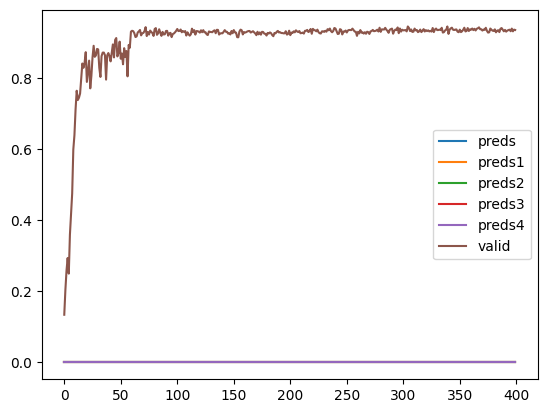

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/400 [00:00<?, ?it/s]

***训练集***
0.11


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/400 [00:15<1:44:02, 15.65s/it]

valid-f1: 0.05160953447561388
valid-precision: 0.05664730451138218
valid-recall: 0.12748125751834388
process: 1  loss: 57.53703808784485  train_correct: 0.005534939304358765 valid_loss 467.80416464805603  val_correct: 0.13379310344827586
The model has been saved!!
The best val_acc is  0.13379310344827586
***训练集***
0.12625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/400 [00:31<1:42:56, 15.52s/it]

valid-f1: 0.0423787968743129
valid-precision: 0.12108462043529075
valid-recall: 0.11519837379190852
process: 2  loss: 57.29841494560242  train_correct: 0.006352600792502673 valid_loss 465.13290572166443  val_correct: 0.12199233716475096
***训练集***
0.18375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/400 [00:46<1:43:02, 15.57s/it]

valid-f1: 0.12751223586041924
valid-precision: 0.22407757614194906
valid-recall: 0.215113250615825
process: 3  loss: 56.66232919692993  train_correct: 0.009245864519781119 valid_loss 458.12297916412354  val_correct: 0.22007662835249042
The model has been saved!!
The best val_acc is  0.22007662835249042
***训练集***
0.235


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/400 [01:02<1:42:46, 15.57s/it]

valid-f1: 0.20798912019865762
valid-precision: 0.4242905873506103
valid-recall: 0.23989886268663702
process: 4  loss: 55.70074415206909  train_correct: 0.011824643059311907 valid_loss 440.92020630836487  val_correct: 0.23080459770114942
The model has been saved!!
The best val_acc is  0.23080459770114942
***训练集***
0.30625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▏         | 5/400 [01:17<1:42:41, 15.60s/it]

valid-f1: 0.2851049813303425
valid-precision: 0.44447261611756145
valid-recall: 0.34060881656800374
process: 5  loss: 53.338433504104614  train_correct: 0.015409774199635197 valid_loss 403.00290644168854  val_correct: 0.3400766283524904
The model has been saved!!
The best val_acc is  0.3400766283524904
***训练集***
0.36875


  2%|▏         | 6/400 [01:33<1:42:03, 15.54s/it]

valid-f1: 0.2914823360814179
valid-precision: 0.4989490341233359
valid-recall: 0.32945725998907627
process: 6  loss: 48.47376275062561  train_correct: 0.01855462607711177 valid_loss 366.30672538280487  val_correct: 0.3363984674329502
***训练集***
0.42375


  2%|▏         | 7/400 [01:48<1:41:54, 15.56s/it]

valid-f1: 0.5131046778268652
valid-precision: 0.5679532615136581
valid-recall: 0.5361246001133274
process: 7  loss: 43.643662333488464  train_correct: 0.02132209572929115 valid_loss 302.45780715346336  val_correct: 0.5422222222222223
The model has been saved!!
The best val_acc is  0.5422222222222223
***训练集***
0.47375


  2%|▏         | 8/400 [02:04<1:41:20, 15.51s/it]

valid-f1: 0.5297622068910111
valid-precision: 0.6227192621978699
valid-recall: 0.5456956930202056
process: 8  loss: 39.517974495887756  train_correct: 0.023837977231272407 valid_loss 275.93956553936005  val_correct: 0.5436015325670498
The model has been saved!!
The best val_acc is  0.5436015325670498
***训练集***
0.56625


  2%|▏         | 9/400 [02:20<1:41:23, 15.56s/it]

valid-f1: 0.6055331546195373
valid-precision: 0.7106323489049478
valid-recall: 0.6396651099054178
process: 9  loss: 36.010979533195496  train_correct: 0.028492358009937734 valid_loss 224.21444955468178  val_correct: 0.6485823754789272
The model has been saved!!
The best val_acc is  0.6485823754789272
***训练集***
0.59875


  2%|▎         | 10/400 [02:35<1:40:46, 15.50s/it]

valid-f1: 0.5428082384545444
valid-precision: 0.7298059624416012
valid-recall: 0.5856068787852854
process: 10  loss: 31.320221543312073  train_correct: 0.03012768098622555 valid_loss 255.37161940336227  val_correct: 0.6016858237547893
***训练集***
0.63625


  3%|▎         | 11/400 [02:51<1:40:43, 15.54s/it]

valid-f1: 0.5783408973020097
valid-precision: 0.6631102504473229
valid-recall: 0.5923356830332873
process: 11  loss: 28.2176713347435  train_correct: 0.032014592112711494 valid_loss 221.15123895555735  val_correct: 0.6050574712643678
***训练集***
0.66875


  3%|▎         | 12/400 [03:06<1:40:26, 15.53s/it]

valid-f1: 0.6603179479509222
valid-precision: 0.6883282813485712
valid-recall: 0.6997168575389403
process: 12  loss: 25.863247513771057  train_correct: 0.03364991508899931 valid_loss 174.63847406581044  val_correct: 0.7137164750957854
The model has been saved!!
The best val_acc is  0.7137164750957854
***训练集***
0.72


  3%|▎         | 13/400 [03:22<1:40:23, 15.57s/it]

valid-f1: 0.6861486814934412
valid-precision: 0.7201964291402876
valid-recall: 0.7216728219125682
process: 13  loss: 23.13379693031311  train_correct: 0.036228693628530095 valid_loss 160.78555288165808  val_correct: 0.7431417624521073
The model has been saved!!
The best val_acc is  0.7431417624521073
***训练集***
0.71875


  4%|▎         | 14/400 [03:37<1:39:57, 15.54s/it]

valid-f1: 0.7682338949571463
valid-precision: 0.7945224681695504
valid-recall: 0.7751840823378482
process: 14  loss: 21.99183988571167  train_correct: 0.03616579659098056 valid_loss 151.3670329004526  val_correct: 0.7854406130268199
The model has been saved!!
The best val_acc is  0.7854406130268199
***训练集***
0.73625


  4%|▍         | 15/400 [03:53<1:39:39, 15.53s/it]

valid-f1: 0.6797058782160107
valid-precision: 0.7728448037784811
valid-recall: 0.6774506869849826
process: 15  loss: 21.14008867740631  train_correct: 0.03704635511667401 valid_loss 186.01141497958452  val_correct: 0.6919540229885057
***训练集***
0.74375


  4%|▍         | 16/400 [04:08<1:39:07, 15.49s/it]

valid-f1: 0.7772650744145728
valid-precision: 0.8004235559361123
valid-recall: 0.7846576307862178
process: 16  loss: 20.28153431415558  train_correct: 0.03742373734197119 valid_loss 137.93788190558553  val_correct: 0.7898850574712644
The model has been saved!!
The best val_acc is  0.7898850574712644
***训练集***
0.765


  4%|▍         | 17/400 [04:24<1:39:22, 15.57s/it]

valid-f1: 0.8209384611335265
valid-precision: 0.8280270531947517
valid-recall: 0.8222473141374371
process: 17  loss: 18.46910271048546  train_correct: 0.038492986980313226 valid_loss 120.29097612202168  val_correct: 0.8278927203065134
The model has been saved!!
The best val_acc is  0.8278927203065134
***训练集***
0.7775


  4%|▍         | 18/400 [04:39<1:38:56, 15.54s/it]

valid-f1: 0.7043179597578664
valid-precision: 0.7927031675551752
valid-recall: 0.7190423681016332
process: 18  loss: 18.00321078300476  train_correct: 0.03912195735580854 valid_loss 165.9691366078332  val_correct: 0.7293486590038314
***训练集***
0.7675


  5%|▍         | 19/400 [04:55<1:38:55, 15.58s/it]

valid-f1: 0.7693762144209814
valid-precision: 0.8136349594897571
valid-recall: 0.7633416896994862
process: 19  loss: 18.036101162433624  train_correct: 0.03861878105541229 valid_loss 135.2195358928293  val_correct: 0.7690421455938697
***训练集***
0.7625


  5%|▌         | 20/400 [05:10<1:38:20, 15.53s/it]

valid-f1: 0.8131120499649456
valid-precision: 0.8210197848849802
valid-recall: 0.8132703575186611
process: 20  loss: 17.974074840545654  train_correct: 0.03836719290521416 valid_loss 110.8727845903486  val_correct: 0.821455938697318
***训练集***
0.8


  5%|▌         | 21/400 [05:26<1:38:10, 15.54s/it]

valid-f1: 0.7906248708381558
valid-precision: 0.810654795937829
valid-recall: 0.79098793571866
process: 21  loss: 15.855260848999023  train_correct: 0.04025410403170011 valid_loss 118.65348391234875  val_correct: 0.8012260536398468
***训练集***
0.7875


  6%|▌         | 22/400 [05:41<1:37:42, 15.51s/it]

valid-f1: 0.7601775132247723
valid-precision: 0.8150196441734835
valid-recall: 0.773132081360866
process: 22  loss: 16.531099379062653  train_correct: 0.03962513365620479 valid_loss 129.78849570825696  val_correct: 0.788199233716475
***训练集***
0.79625


  6%|▌         | 23/400 [05:57<1:37:30, 15.52s/it]

valid-f1: 0.7932440898511931
valid-precision: 0.826921445993819
valid-recall: 0.8074147374375416
process: 23  loss: 15.543325081467628  train_correct: 0.04006541291905151 valid_loss 117.88926264643669  val_correct: 0.8219157088122605
***训练集***
0.79625


  6%|▌         | 24/400 [06:12<1:37:04, 15.49s/it]

valid-f1: 0.7993987944104548
valid-precision: 0.8150519996313887
valid-recall: 0.8101398152898017
process: 24  loss: 16.044236600399017  train_correct: 0.04006541291905151 valid_loss 115.13906584959477  val_correct: 0.8148659003831418
***训练集***
0.8175


  6%|▋         | 25/400 [06:28<1:37:01, 15.52s/it]

valid-f1: 0.7849462641053586
valid-precision: 0.8100860864839483
valid-recall: 0.7898897868905884
process: 25  loss: 14.73482558131218  train_correct: 0.04113466255739354 valid_loss 119.2479436538415  val_correct: 0.7978544061302681
***训练集***
0.83875


  6%|▋         | 26/400 [06:43<1:36:45, 15.52s/it]

valid-f1: 0.8563297655651528
valid-precision: 0.8600547047760931
valid-recall: 0.8576341621146941
process: 26  loss: 12.68489122390747  train_correct: 0.042203912195735584 valid_loss 83.1143051981926  val_correct: 0.8637547892720306
The model has been saved!!
The best val_acc is  0.8637547892720306
***训练集***
0.8225


  7%|▋         | 27/400 [06:59<1:36:38, 15.55s/it]

valid-f1: 0.8245180039115336
valid-precision: 0.8475025058767829
valid-recall: 0.8351917551307846
process: 27  loss: 14.359029978513718  train_correct: 0.04138625070759167 valid_loss 98.75178435817361  val_correct: 0.8453639846743295
***训练集***
0.84375


  7%|▋         | 28/400 [07:15<1:36:14, 15.52s/it]

valid-f1: 0.7745773331655063
valid-precision: 0.8070919083721082
valid-recall: 0.7839436291689218
process: 28  loss: 12.236414521932602  train_correct: 0.042455500345933705 valid_loss 136.123668753542  val_correct: 0.7888122605363984
***训练集***
0.81125


  7%|▋         | 29/400 [07:30<1:36:05, 15.54s/it]

valid-f1: 0.8192493831012806
valid-precision: 0.8351179556107173
valid-recall: 0.8244359674482735
process: 29  loss: 14.052963227033615  train_correct: 0.04082017736964589 valid_loss 104.4543416146189  val_correct: 0.833103448275862
***训练集***
0.83625


  8%|▊         | 30/400 [07:46<1:35:45, 15.53s/it]

valid-f1: 0.8750712762073786
valid-precision: 0.8842199344777459
valid-recall: 0.8761250799505907
process: 30  loss: 12.74839723110199  train_correct: 0.04207811812063652 valid_loss 80.640195639804  val_correct: 0.8801532567049808
The model has been saved!!
The best val_acc is  0.8801532567049808
***训练集***
0.83125


  8%|▊         | 31/400 [08:01<1:35:35, 15.54s/it]

valid-f1: 0.8798365946952156
valid-precision: 0.8948385290986831
valid-recall: 0.8781688191537407
process: 31  loss: 12.211050599813461  train_correct: 0.04182652997043839 valid_loss 81.35728565929458  val_correct: 0.8896551724137931
The model has been saved!!
The best val_acc is  0.8896551724137931
***训练集***
0.82625


  8%|▊         | 32/400 [08:17<1:35:04, 15.50s/it]

valid-f1: 0.855375701725811
valid-precision: 0.8615243064102136
valid-recall: 0.8572716616475438
process: 32  loss: 12.622817054390907  train_correct: 0.04157494182024027 valid_loss 83.46203527320176  val_correct: 0.8594636015325671
***训练集***
0.84


  8%|▊         | 33/400 [08:32<1:35:00, 15.53s/it]

valid-f1: 0.861422415548185
valid-precision: 0.8748061842969118
valid-recall: 0.8678153935976418
process: 33  loss: 12.263541236519814  train_correct: 0.04226680923328511 valid_loss 82.25189722515643  val_correct: 0.8677394636015325
***训练集***
0.84


  8%|▊         | 34/400 [08:48<1:34:34, 15.50s/it]

valid-f1: 0.871155766367249
valid-precision: 0.8756920285802302
valid-recall: 0.8729616024333223
process: 34  loss: 11.892157137393951  train_correct: 0.04226680923328511 valid_loss 75.94692698307335  val_correct: 0.8813793103448276
***训练集***
0.8425


  9%|▉         | 35/400 [09:03<1:34:18, 15.50s/it]

valid-f1: 0.8673729615979007
valid-precision: 0.8750720605355223
valid-recall: 0.8683444966352386
process: 35  loss: 11.785792261362076  train_correct: 0.04239260330838417 valid_loss 77.2355785658583  val_correct: 0.8700383141762452
***训练集***
0.85625


  9%|▉         | 36/400 [09:19<1:33:50, 15.47s/it]

valid-f1: 0.8821771898109916
valid-precision: 0.8822105224375468
valid-recall: 0.883794218131613
process: 36  loss: 11.723387092351913  train_correct: 0.04308447072142902 valid_loss 73.62398710753769  val_correct: 0.8895019157088122
***训练集***
0.8575


  9%|▉         | 37/400 [09:34<1:33:43, 15.49s/it]

valid-f1: 0.8354547746380965
valid-precision: 0.8458813614828078
valid-recall: 0.8451944080586917
process: 37  loss: 10.65353861451149  train_correct: 0.04314736775897855 valid_loss 92.48737571318634  val_correct: 0.8458237547892721
***训练集***
0.83875


 10%|▉         | 38/400 [09:49<1:33:16, 15.46s/it]

valid-f1: 0.8564762446617655
valid-precision: 0.8721100817477299
valid-recall: 0.8560435897885599
process: 38  loss: 12.12866348028183  train_correct: 0.042203912195735584 valid_loss 85.3251476213336  val_correct: 0.8602298850574712
***训练集***
0.865


 10%|▉         | 39/400 [10:05<1:33:03, 15.47s/it]

valid-f1: 0.8636407220741141
valid-precision: 0.8703676719775457
valid-recall: 0.8649234356363985
process: 39  loss: 10.485527217388153  train_correct: 0.04352474998427574 valid_loss 79.53653885284439  val_correct: 0.8694252873563219
***训练集***
0.85875


 10%|█         | 40/400 [10:20<1:32:46, 15.46s/it]

valid-f1: 0.8246883160882506
valid-precision: 0.8393925136054934
valid-recall: 0.8290507637014534
process: 40  loss: 10.532089442014694  train_correct: 0.043210264796528085 valid_loss 108.66740312008187  val_correct: 0.834176245210728
***训练集***
0.86
valid-f1: 0.8854354942784719
valid-precision: 0.8909799005212655
valid-recall: 0.8860661226931861
process: 41  loss: 10.949924245476723  train_correct: 0.04327316183407762 valid_loss 79.21304432209581  val_correct: 0.8924137931034483


 10%|█         | 41/400 [10:36<1:33:15, 15.59s/it]

The model has been saved!!
The best val_acc is  0.8924137931034483
***训练集***
0.8625


 10%|█         | 42/400 [10:52<1:32:41, 15.54s/it]

valid-f1: 0.8254633608906827
valid-precision: 0.8426975972538668
valid-recall: 0.8359894557915061
process: 42  loss: 10.215535372495651  train_correct: 0.043398955909176674 valid_loss 102.90934461774305  val_correct: 0.8445977011494253
***训练集***
0.85125


 11%|█         | 43/400 [11:07<1:32:40, 15.58s/it]

valid-f1: 0.8860060160360632
valid-precision: 0.8927390442940595
valid-recall: 0.8855961890788071
process: 43  loss: 11.55456206202507  train_correct: 0.04283288257123089 valid_loss 76.6313062403351  val_correct: 0.8939463601532567
The model has been saved!!
The best val_acc is  0.8939463601532567
***训练集***
0.8575


 11%|█         | 44/400 [11:23<1:32:18, 15.56s/it]

valid-f1: 0.8568143080539601
valid-precision: 0.8617530914515635
valid-recall: 0.8646290104394879
process: 44  loss: 10.962468475103378  train_correct: 0.04314736775897855 valid_loss 81.30227251024917  val_correct: 0.8666666666666667
***训练集***
0.8725


 11%|█▏        | 45/400 [11:38<1:31:56, 15.54s/it]

valid-f1: 0.8331943534508456
valid-precision: 0.8631023895460943
valid-recall: 0.8447073649825262
process: 45  loss: 9.99653573334217  train_correct: 0.04390213220957293 valid_loss 105.11314033996314  val_correct: 0.842911877394636
***训练集***
0.85875


 12%|█▏        | 46/400 [11:54<1:31:28, 15.50s/it]

valid-f1: 0.8730101045925862
valid-precision: 0.8763671597778744
valid-recall: 0.8752914436882646
process: 46  loss: 10.624603658914566  train_correct: 0.043210264796528085 valid_loss 82.35472904116614  val_correct: 0.8807662835249043
***训练集***
0.86875


 12%|█▏        | 47/400 [12:09<1:31:16, 15.52s/it]

valid-f1: 0.8502992922113188
valid-precision: 0.8611701672923318
valid-recall: 0.8523849577088021
process: 47  loss: 10.442400798201561  train_correct: 0.043713441096924335 valid_loss 96.91673554386944  val_correct: 0.8548659003831418
***训练集***
0.86125


 12%|█▏        | 48/400 [12:25<1:30:55, 15.50s/it]

valid-f1: 0.8521649725530482
valid-precision: 0.8658106698037111
valid-recall: 0.8565639936684851
process: 48  loss: 10.440034851431847  train_correct: 0.04333605887162715 valid_loss 93.59850385645404  val_correct: 0.863448275862069
***训练集***
0.89


 12%|█▏        | 49/400 [12:40<1:30:42, 15.51s/it]

valid-f1: 0.8549361224405251
valid-precision: 0.87901181811461
valid-recall: 0.8641799098828965
process: 49  loss: 9.406952857971191  train_correct: 0.04478269073526637 valid_loss 92.582311891485  val_correct: 0.8746360153256705
***训练集***
0.8675


 12%|█▎        | 50/400 [12:56<1:30:16, 15.48s/it]

valid-f1: 0.8849381652557178
valid-precision: 0.8927350146889367
valid-recall: 0.8859864851080493
process: 50  loss: 9.919873625040054  train_correct: 0.0436505440593748 valid_loss 81.58836637018248  val_correct: 0.893639846743295
***训练集***
0.855


 13%|█▎        | 51/400 [13:11<1:30:06, 15.49s/it]

valid-f1: 0.8655791459619762
valid-precision: 0.8827874042565392
valid-recall: 0.8697779965971074
process: 51  loss: 10.679491490125656  train_correct: 0.04302157368387949 valid_loss 87.0830251374282  val_correct: 0.8744827586206897
***训练集***
0.88


 13%|█▎        | 52/400 [13:27<1:29:41, 15.46s/it]

valid-f1: 0.8780017078187656
valid-precision: 0.8840031032082709
valid-recall: 0.8800486671884238
process: 52  loss: 9.372932597994804  train_correct: 0.04427951443487012 valid_loss 80.44742679363117  val_correct: 0.8815325670498084
***训练集***
0.86


 13%|█▎        | 53/400 [13:42<1:29:32, 15.48s/it]

valid-f1: 0.8685915442901824
valid-precision: 0.8768312415987033
valid-recall: 0.8723157700263867
process: 53  loss: 10.310413628816605  train_correct: 0.04327316183407762 valid_loss 74.6320581928594  val_correct: 0.8784674329501916
***训练集***
0.87875


 14%|█▎        | 54/400 [13:58<1:29:13, 15.47s/it]

valid-f1: 0.8882671560250627
valid-precision: 0.8884653682398934
valid-recall: 0.8901472337052209
process: 54  loss: 9.840075753629208  train_correct: 0.044216617397320586 valid_loss 69.99868903472088  val_correct: 0.8931800766283525
***训练集***
0.865


 14%|█▍        | 55/400 [14:13<1:29:06, 15.50s/it]

valid-f1: 0.8902356494165655
valid-precision: 0.8934458342505014
valid-recall: 0.8920842235388381
process: 55  loss: 9.138262540102005  train_correct: 0.04352474998427574 valid_loss 68.20528742484748  val_correct: 0.896551724137931
The model has been saved!!
The best val_acc is  0.896551724137931
***训练集***
0.88


 14%|█▍        | 56/400 [14:29<1:28:37, 15.46s/it]

valid-f1: 0.892937583493139
valid-precision: 0.9020255390959452
valid-recall: 0.8959037121863508
process: 56  loss: 9.528878197073936  train_correct: 0.04427951443487012 valid_loss 71.48066957155243  val_correct: 0.8959386973180077
***训练集***
0.885


 14%|█▍        | 57/400 [14:44<1:28:25, 15.47s/it]

valid-f1: 0.8591428814181585
valid-precision: 0.8771471924959682
valid-recall: 0.864199792643207
process: 57  loss: 9.604796394705772  train_correct: 0.04453110258506824 valid_loss 85.98060148023069  val_correct: 0.8711111111111111
***训练集***
0.88


 14%|█▍        | 58/400 [15:00<1:28:12, 15.47s/it]

valid-f1: 0.8795583304808432
valid-precision: 0.8965308967322864
valid-recall: 0.8790312931484022
process: 58  loss: 9.403407022356987  train_correct: 0.04427951443487012 valid_loss 79.04614894092083  val_correct: 0.886896551724138
***训练集***
0.88625
开始蒸馏


 15%|█▍        | 59/400 [15:15<1:28:04, 15.50s/it]

valid-f1: 0.835096110464162
valid-precision: 0.8486637693346181
valid-recall: 0.8416816920198826
process: 59  loss: 8.509860426187515  train_correct: 0.04459399962261777 valid_loss 94.87278888351284  val_correct: 0.8499616858237548
***训练集***
0.79375


 15%|█▌        | 60/400 [15:31<1:27:47, 15.49s/it]

valid-f1: 0.8004147658315605
valid-precision: 0.817616359292926
valid-recall: 0.803552485838711
process: 60  loss: 2215.493381500244  train_correct: 0.03993961884395245 valid_loss 143.36283193482086  val_correct: 0.8095019157088122
***训练集***
0.7775


 15%|█▌        | 61/400 [15:46<1:27:37, 15.51s/it]

valid-f1: 0.8711854078657698
valid-precision: 0.8789901266790603
valid-recall: 0.8729395074111835
process: 61  loss: 1353.1678504943848  train_correct: 0.03912195735580854 valid_loss 95.46447984243423  val_correct: 0.8761685823754789
***训练集***
0.815


 16%|█▌        | 62/400 [16:02<1:27:18, 15.50s/it]

valid-f1: 0.8907732082393821
valid-precision: 0.9085646733018866
valid-recall: 0.8964301787463167
process: 62  loss: 927.2738914489746  train_correct: 0.041008868482294486 valid_loss 89.83407325024018  val_correct: 0.9042145593869731
The model has been saved!!
The best val_acc is  0.9042145593869731
***训练集***
0.8375


 16%|█▌        | 63/400 [16:17<1:26:56, 15.48s/it]

valid-f1: 0.8585517893262228
valid-precision: 0.8667736183977466
valid-recall: 0.865614926854431
process: 63  loss: 822.701681137085  train_correct: 0.04214101515818605 valid_loss 87.59501155884936  val_correct: 0.8628352490421456
***训练集***
0.845


 16%|█▌        | 64/400 [16:33<1:26:53, 15.52s/it]

valid-f1: 0.901038056310618
valid-precision: 0.9023807849748897
valid-recall: 0.902905711953325
process: 64  loss: 741.346845626831  train_correct: 0.04251839738348324 valid_loss 76.66791711497899  val_correct: 0.9069731800766283
The model has been saved!!
The best val_acc is  0.9069731800766283
***训练集***
0.865


 16%|█▋        | 65/400 [16:48<1:26:51, 15.56s/it]

valid-f1: 0.902242532746048
valid-precision: 0.9072148170776673
valid-recall: 0.9043015126570835
process: 65  loss: 690.5389099121094  train_correct: 0.04352474998427574 valid_loss 86.79536771852145  val_correct: 0.9098850574712644
The model has been saved!!
The best val_acc is  0.9098850574712644
***训练集***
0.86125


 16%|█▋        | 66/400 [17:04<1:26:20, 15.51s/it]

valid-f1: 0.8724550457401439
valid-precision: 0.8886750233771368
valid-recall: 0.8758873015266797
process: 66  loss: 628.8292961120605  train_correct: 0.04333605887162715 valid_loss 111.23301718220637  val_correct: 0.8795402298850574
***训练集***
0.85375


 17%|█▋        | 67/400 [17:19<1:26:07, 15.52s/it]

valid-f1: 0.9216019214568263
valid-precision: 0.9245268696342152
valid-recall: 0.9219949424597829
process: 67  loss: 587.9924774169922  train_correct: 0.042958676646329956 valid_loss 74.84405919515848  val_correct: 0.9273563218390805
The model has been saved!!
The best val_acc is  0.9273563218390805
***训练集***
0.87125


 17%|█▋        | 68/400 [17:35<1:25:48, 15.51s/it]

valid-f1: 0.9244189920259016
valid-precision: 0.9261577930246119
valid-recall: 0.9239706515029255
process: 68  loss: 595.5806484222412  train_correct: 0.0438392351720234 valid_loss 69.36684902283741  val_correct: 0.927816091954023
The model has been saved!!
The best val_acc is  0.927816091954023
***训练集***
0.86


 17%|█▋        | 69/400 [17:50<1:25:39, 15.53s/it]

valid-f1: 0.9114977875982808
valid-precision: 0.9137119320470404
valid-recall: 0.9130728359903271
process: 69  loss: 539.9378337860107  train_correct: 0.04327316183407762 valid_loss 78.45223225367954  val_correct: 0.9157088122605364
***训练集***
0.8575


 18%|█▊        | 70/400 [18:06<1:25:13, 15.50s/it]

valid-f1: 0.90486570962604
valid-precision: 0.906663399815983
valid-recall: 0.908722123398016
process: 70  loss: 534.19664478302  train_correct: 0.04314736775897855 valid_loss 82.43639874736004  val_correct: 0.9098850574712644
***训练集***
0.87875


 18%|█▊        | 71/400 [18:21<1:25:03, 15.51s/it]

valid-f1: 0.9185556453619483
valid-precision: 0.9226461470521666
valid-recall: 0.9183382705059152
process: 71  loss: 551.3297958374023  train_correct: 0.044216617397320586 valid_loss 77.11877605851578  val_correct: 0.9235249042145594
***训练集***
0.865


 18%|█▊        | 72/400 [18:37<1:24:38, 15.48s/it]

valid-f1: 0.909552206425011
valid-precision: 0.9154131721599426
valid-recall: 0.9090971130691095
process: 72  loss: 537.2927341461182  train_correct: 0.04352474998427574 valid_loss 86.3797393338973  val_correct: 0.9127969348659004
***训练集***
0.8925


 18%|█▊        | 73/400 [18:52<1:24:32, 15.51s/it]

valid-f1: 0.9026391504906103
valid-precision: 0.9071781222806351
valid-recall: 0.9042222169033997
process: 73  loss: 536.3431062698364  train_correct: 0.04490848481036543 valid_loss 86.49889739898379  val_correct: 0.9075862068965517
***训练集***
0.8825


 18%|█▊        | 74/400 [19:08<1:24:11, 15.50s/it]

valid-f1: 0.9163572058095477
valid-precision: 0.9168023629859359
valid-recall: 0.9183696151773922
process: 74  loss: 495.85364818573  train_correct: 0.04440530850996918 valid_loss 75.99724810150656  val_correct: 0.9198467432950191
***训练集***
0.91


 19%|█▉        | 75/400 [19:23<1:24:08, 15.53s/it]

valid-f1: 0.9258202101534303
valid-precision: 0.9300051681007357
valid-recall: 0.9267569122720714
process: 75  loss: 471.9100036621094  train_correct: 0.04578904333605887 valid_loss 81.4076725041682  val_correct: 0.9321072796934866
The model has been saved!!
The best val_acc is  0.9321072796934866
***训练集***
0.8725


 19%|█▉        | 76/400 [19:39<1:23:44, 15.51s/it]

valid-f1: 0.9180044266541583
valid-precision: 0.9249279558736383
valid-recall: 0.9183395534323493
process: 76  loss: 496.8678798675537  train_correct: 0.04390213220957293 valid_loss 77.72587567650473  val_correct: 0.9232183908045977
***训练集***
0.87875


 19%|█▉        | 77/400 [19:54<1:23:25, 15.50s/it]

valid-f1: 0.917089458921309
valid-precision: 0.9180458582017643
valid-recall: 0.918079971250234
process: 77  loss: 491.6964464187622  train_correct: 0.044216617397320586 valid_loss 75.60451125649888  val_correct: 0.9209195402298851
***训练集***
0.8825


 20%|█▉        | 78/400 [20:10<1:23:00, 15.47s/it]

valid-f1: 0.9279952246988398
valid-precision: 0.9278935712637738
valid-recall: 0.9291050579930934
process: 78  loss: 477.87343406677246  train_correct: 0.04440530850996918 valid_loss 69.49629321345128  val_correct: 0.930727969348659
***训练集***
0.9025


 20%|█▉        | 79/400 [20:25<1:22:56, 15.50s/it]

valid-f1: 0.9318709691736968
valid-precision: 0.9364266558069085
valid-recall: 0.9316911096407056
process: 79  loss: 450.1467056274414  train_correct: 0.045411661110761684 valid_loss 73.88229304928973  val_correct: 0.9367049808429119
The model has been saved!!
The best val_acc is  0.9367049808429119
***训练集***
0.88875


 20%|██        | 80/400 [20:41<1:22:29, 15.47s/it]

valid-f1: 0.9164935647183328
valid-precision: 0.9185163673317323
valid-recall: 0.9189521252707953
process: 80  loss: 436.4434766769409  train_correct: 0.044719793697716836 valid_loss 83.37437141991722  val_correct: 0.9193869731800767
***训练集***
0.9025


 20%|██        | 81/400 [20:56<1:22:25, 15.50s/it]

valid-f1: 0.927717514592769
valid-precision: 0.9283861822977844
valid-recall: 0.9282601249868117
process: 81  loss: 439.7748031616211  train_correct: 0.045411661110761684 valid_loss 70.01765813233214  val_correct: 0.9318007662835249
***训练集***
0.86875


 20%|██        | 82/400 [21:12<1:22:06, 15.49s/it]

valid-f1: 0.9355617379721769
valid-precision: 0.9366301014331055
valid-recall: 0.935149967209656
process: 82  loss: 454.66698837280273  train_correct: 0.043713441096924335 valid_loss 60.40514841116965  val_correct: 0.9386973180076629
The model has been saved!!
The best val_acc is  0.9386973180076629
***训练集***
0.8975


 21%|██        | 83/400 [21:27<1:21:57, 15.51s/it]

valid-f1: 0.931848640262029
valid-precision: 0.9354007285494532
valid-recall: 0.9319350842362952
process: 83  loss: 426.8353862762451  train_correct: 0.045160072960563555 valid_loss 68.13118682798086  val_correct: 0.9363984674329502
***训练集***
0.88625


 21%|██        | 84/400 [21:43<1:21:33, 15.49s/it]

valid-f1: 0.9193938692845146
valid-precision: 0.9255666276795547
valid-recall: 0.9205903227975313
process: 84  loss: 430.2493257522583  train_correct: 0.04459399962261777 valid_loss 75.51173040919366  val_correct: 0.9255172413793104
***训练集***
0.885
开始蒸馏


 21%|██▏       | 85/400 [21:58<1:21:25, 15.51s/it]

valid-f1: 0.9253638610046752
valid-precision: 0.9319087349970261
valid-recall: 0.9256531124233888
process: 85  loss: 416.5801486968994  train_correct: 0.04453110258506824 valid_loss 71.74868046259508  val_correct: 0.9311877394636016
***训练集***
0.88875


 22%|██▏       | 86/400 [22:14<1:21:12, 15.52s/it]

valid-f1: 0.9350379861127761
valid-precision: 0.9369561847527118
valid-recall: 0.9352579538695236
process: 86  loss: 403.3610649108887  train_correct: 0.044719793697716836 valid_loss 70.71113304366463  val_correct: 0.9396168582375479
The model has been saved!!
The best val_acc is  0.9396168582375479
***训练集***
0.90625


 22%|██▏       | 87/400 [22:29<1:21:12, 15.57s/it]

valid-f1: 0.9342605214942022
valid-precision: 0.9390162096980637
valid-recall: 0.9341482958455858
process: 87  loss: 412.7811470031738  train_correct: 0.04560035222341028 valid_loss 67.63627583269135  val_correct: 0.9393103448275862
***训练集***
0.9025


 22%|██▏       | 88/400 [22:45<1:20:40, 15.51s/it]

valid-f1: 0.9271291695729058
valid-precision: 0.929106554379036
valid-recall: 0.927397561447202
process: 88  loss: 401.1372537612915  train_correct: 0.045411661110761684 valid_loss 68.2079880780002  val_correct: 0.9314942528735632
***训练集***
0.87875


 22%|██▏       | 89/400 [23:00<1:20:32, 15.54s/it]

valid-f1: 0.9053051335843957
valid-precision: 0.9236810077835139
valid-recall: 0.9097207524348605
process: 89  loss: 396.5830545425415  train_correct: 0.044216617397320586 valid_loss 92.34023397401779  val_correct: 0.9183141762452107
***训练集***
0.87125


 22%|██▎       | 90/400 [23:16<1:20:04, 15.50s/it]

valid-f1: 0.9149035233645293
valid-precision: 0.9205036154287143
valid-recall: 0.9179315323476265
process: 90  loss: 410.6565637588501  train_correct: 0.0438392351720234 valid_loss 77.21771812975203  val_correct: 0.9175478927203066
***训练集***
0.89375


 23%|██▎       | 91/400 [23:31<1:19:57, 15.53s/it]

valid-f1: 0.9358430195237532
valid-precision: 0.9400551326838487
valid-recall: 0.9357306432171516
process: 91  loss: 397.5010643005371  train_correct: 0.044971381847914965 valid_loss 66.37396924862878  val_correct: 0.9409961685823754
The model has been saved!!
The best val_acc is  0.9409961685823754
***训练集***
0.90875


 23%|██▎       | 92/400 [23:47<1:19:32, 15.49s/it]

valid-f1: 0.9358720117755187
valid-precision: 0.940094517749744
valid-recall: 0.9355341292217785
process: 92  loss: 392.9152612686157  train_correct: 0.04572614629850934 valid_loss 68.99817733732743  val_correct: 0.9403831417624521
***训练集***
0.8925


 23%|██▎       | 93/400 [24:02<1:19:19, 15.50s/it]

valid-f1: 0.9346110066744906
valid-precision: 0.9392327409388997
valid-recall: 0.9343742852003875
process: 93  loss: 395.6589288711548  train_correct: 0.04490848481036543 valid_loss 67.01560445610733  val_correct: 0.9396168582375479
***训练集***
0.9025


 24%|██▎       | 94/400 [24:18<1:18:55, 15.47s/it]

valid-f1: 0.9315921431731715
valid-precision: 0.9371938540082503
valid-recall: 0.931598750733824
process: 94  loss: 388.5770664215088  train_correct: 0.045411661110761684 valid_loss 75.67386267359461  val_correct: 0.9374712643678161
***训练集***
0.89375


 24%|██▍       | 95/400 [24:33<1:18:53, 15.52s/it]

valid-f1: 0.9375684261171375
valid-precision: 0.9386783394610685
valid-recall: 0.9376351646194662
process: 95  loss: 390.82567501068115  train_correct: 0.044971381847914965 valid_loss 64.87677495414391  val_correct: 0.9417624521072797
The model has been saved!!
The best val_acc is  0.9417624521072797
***训练集***
0.9025


 24%|██▍       | 96/400 [24:49<1:18:31, 15.50s/it]

valid-f1: 0.9378182850032424
valid-precision: 0.9422325300680845
valid-recall: 0.9378608729514921
process: 96  loss: 371.6430540084839  train_correct: 0.045411661110761684 valid_loss 68.18891692704801  val_correct: 0.9431417624521072
The model has been saved!!
The best val_acc is  0.9431417624521072
***训练集***
0.90375


 24%|██▍       | 97/400 [25:04<1:18:17, 15.50s/it]

valid-f1: 0.938919487426334
valid-precision: 0.9393565360572005
valid-recall: 0.9389402897566335
process: 97  loss: 380.4923210144043  train_correct: 0.045474558148311216 valid_loss 58.45915450983739  val_correct: 0.9422222222222222
***训练集***
0.91125


 24%|██▍       | 98/400 [25:20<1:17:59, 15.49s/it]

valid-f1: 0.9392071235381871
valid-precision: 0.9401225930344005
valid-recall: 0.9392449791390065
process: 98  loss: 359.61975955963135  train_correct: 0.0458519403736084 valid_loss 62.02725313924748  val_correct: 0.9432950191570881
The model has been saved!!
The best val_acc is  0.9432950191570881
***训练集***
0.9075


 25%|██▍       | 99/400 [25:35<1:17:40, 15.48s/it]

valid-f1: 0.9363930858191154
valid-precision: 0.9391114273990384
valid-recall: 0.9366092174283445
process: 99  loss: 366.15454387664795  train_correct: 0.045663249260959805 valid_loss 63.80590552106878  val_correct: 0.9417624521072797
***训练集***
0.88875


 25%|██▌       | 100/400 [25:51<1:17:24, 15.48s/it]

valid-f1: 0.934064192213879
valid-precision: 0.9380195246158565
valid-recall: 0.9343982206763553
process: 100  loss: 374.2555856704712  train_correct: 0.044719793697716836 valid_loss 70.63124708696932  val_correct: 0.9396168582375479
***训练集***
0.915


 25%|██▌       | 101/400 [26:06<1:17:18, 15.51s/it]

valid-f1: 0.9397776621554137
valid-precision: 0.9415395505310125
valid-recall: 0.9398653776184427
process: 101  loss: 372.5688419342041  train_correct: 0.046040631486257 valid_loss 65.09858643877669  val_correct: 0.9440613026819923
The model has been saved!!
The best val_acc is  0.9440613026819923
***训练集***
0.91125


 26%|██▌       | 102/400 [26:22<1:17:00, 15.50s/it]

valid-f1: 0.9396441794256669
valid-precision: 0.9425389263666843
valid-recall: 0.9397505995459395
process: 102  loss: 344.24398136138916  train_correct: 0.0458519403736084 valid_loss 65.85746150501654  val_correct: 0.944367816091954
The model has been saved!!
The best val_acc is  0.944367816091954
***训练集***
0.91


 26%|██▌       | 103/400 [26:37<1:16:48, 15.52s/it]

valid-f1: 0.9329387256594653
valid-precision: 0.935737501525875
valid-recall: 0.933203727557793
process: 103  loss: 361.0573453903198  train_correct: 0.04578904333605887 valid_loss 63.51465933362488  val_correct: 0.9377777777777778
***训练集***
0.915


 26%|██▌       | 104/400 [26:53<1:16:30, 15.51s/it]

valid-f1: 0.9329006777110816
valid-precision: 0.9336714424908324
valid-recall: 0.9338159989775882
process: 104  loss: 376.35682582855225  train_correct: 0.046040631486257 valid_loss 63.688425545402424  val_correct: 0.9380842911877395
***训练集***
0.8975


 26%|██▋       | 105/400 [27:08<1:16:18, 15.52s/it]

valid-f1: 0.9402220746872958
valid-precision: 0.9407953128102123
valid-recall: 0.9401483931273434
process: 105  loss: 358.61784648895264  train_correct: 0.045160072960563555 valid_loss 63.50232043564938  val_correct: 0.9439080459770115
***训练集***
0.89625


 26%|██▋       | 106/400 [27:24<1:15:55, 15.50s/it]

valid-f1: 0.9365339250790686
valid-precision: 0.9409867522144229
valid-recall: 0.9367398478481693
process: 106  loss: 354.0291233062744  train_correct: 0.04509717592301402 valid_loss 70.46426377757598  val_correct: 0.9420689655172414
***训练集***
0.92375


 27%|██▋       | 107/400 [27:39<1:15:38, 15.49s/it]

valid-f1: 0.9375930669204694
valid-precision: 0.9402397193448868
valid-recall: 0.9374852001483918
process: 107  loss: 352.9449996948242  train_correct: 0.04648091074910372 valid_loss 68.39437519770581  val_correct: 0.9422222222222222
***训练集***
0.9125


 27%|██▋       | 108/400 [27:55<1:15:18, 15.47s/it]

valid-f1: 0.9323561921631395
valid-precision: 0.9356663316193974
valid-recall: 0.9331312195525353
process: 108  loss: 359.38415813446045  train_correct: 0.045914837411157934 valid_loss 64.5312600164616  val_correct: 0.9383908045977012
***训练集***
0.91375


 27%|██▋       | 109/400 [28:10<1:15:05, 15.48s/it]

valid-f1: 0.9302763142464994
valid-precision: 0.9365708459148123
valid-recall: 0.9311919447757034
process: 109  loss: 343.14537525177  train_correct: 0.045977734448707466 valid_loss 68.88583112882588  val_correct: 0.9373180076628352
***训练集***
0.89125


 28%|██▊       | 110/400 [28:26<1:14:41, 15.45s/it]

valid-f1: 0.9321418149134114
valid-precision: 0.9324764565776322
valid-recall: 0.9329448445499283
process: 110  loss: 361.76351165771484  train_correct: 0.0448455877728159 valid_loss 68.04181323197554  val_correct: 0.9363984674329502
***训练集***
0.93125


 28%|██▊       | 111/400 [28:41<1:14:36, 15.49s/it]

valid-f1: 0.9279741328022755
valid-precision: 0.9301787354072282
valid-recall: 0.9293708879660783
process: 111  loss: 352.3644275665283  train_correct: 0.0468582929744009 valid_loss 69.0165381708357  val_correct: 0.9339463601532567
***训练集***
0.9175


 28%|██▊       | 112/400 [28:57<1:14:18, 15.48s/it]

valid-f1: 0.9362691353546995
valid-precision: 0.9385685518517102
valid-recall: 0.936701713668341
process: 112  loss: 348.7663793563843  train_correct: 0.04616642556135606 valid_loss 64.94606737747381  val_correct: 0.9411494252873563
***训练集***
0.92125


 28%|██▊       | 113/400 [29:12<1:13:56, 15.46s/it]

valid-f1: 0.934858594499485
valid-precision: 0.939607754891591
valid-recall: 0.9351359576095092
process: 113  loss: 325.35801219940186  train_correct: 0.04635511667400465 valid_loss 65.21711341117953  val_correct: 0.9403831417624521
***训练集***
0.90125


 28%|██▊       | 114/400 [29:27<1:13:35, 15.44s/it]

valid-f1: 0.9364497153038718
valid-precision: 0.9362895099768289
valid-recall: 0.9369843744818377
process: 114  loss: 330.41747665405273  train_correct: 0.04534876407321215 valid_loss 57.31638213638507  val_correct: 0.939463601532567
***训练集***
0.9125


 29%|██▉       | 115/400 [29:43<1:13:37, 15.50s/it]

valid-f1: 0.9329801313011219
valid-precision: 0.9364917679254292
valid-recall: 0.9333527884038787
process: 115  loss: 322.370813369751  train_correct: 0.045914837411157934 valid_loss 67.77106768634985  val_correct: 0.9380842911877395
***训练集***
0.90875


 29%|██▉       | 116/400 [29:59<1:13:23, 15.50s/it]

valid-f1: 0.9360451355891183
valid-precision: 0.936793861968729
valid-recall: 0.9363596114018498
process: 116  loss: 339.73656368255615  train_correct: 0.04572614629850934 valid_loss 61.96070440376934  val_correct: 0.9397701149425287
***训练集***
0.90375


 29%|██▉       | 117/400 [30:14<1:13:13, 15.52s/it]

valid-f1: 0.9274372147052572
valid-precision: 0.9295500612242362
valid-recall: 0.9286358329203404
process: 117  loss: 344.75425243377686  train_correct: 0.045474558148311216 valid_loss 73.12404818162122  val_correct: 0.9331800766283525
***训练集***
0.91125


 30%|██▉       | 118/400 [30:30<1:12:54, 15.51s/it]

valid-f1: 0.9266514908682494
valid-precision: 0.9315324721447862
valid-recall: 0.9278516634603029
process: 118  loss: 324.7093620300293  train_correct: 0.0458519403736084 valid_loss 74.89242110267514  val_correct: 0.9334865900383141
***训练集***
0.915


 30%|██▉       | 119/400 [30:45<1:12:40, 15.52s/it]

valid-f1: 0.9255934728108892
valid-precision: 0.9345119003940117
valid-recall: 0.9274252909004556
process: 119  loss: 333.8704137802124  train_correct: 0.046040631486257 valid_loss 75.74163348987713  val_correct: 0.9344061302681992
***训练集***
0.89625


 30%|███       | 120/400 [31:01<1:12:27, 15.53s/it]

valid-f1: 0.9306356213938528
valid-precision: 0.935013228093607
valid-recall: 0.9316343844540176
process: 120  loss: 325.390531539917  train_correct: 0.04509717592301402 valid_loss 65.75939722786461  val_correct: 0.9370114942528736
***训练集***
0.90375
开始蒸馏


 30%|███       | 121/400 [31:16<1:12:12, 15.53s/it]

valid-f1: 0.9261538136444172
valid-precision: 0.9331204589673037
valid-recall: 0.9277091145895169
process: 121  loss: 334.2352361679077  train_correct: 0.045474558148311216 valid_loss 71.7635205581164  val_correct: 0.9339463601532567
***训练集***
0.90625


 30%|███       | 122/400 [31:32<1:11:55, 15.52s/it]

valid-f1: 0.9396677490064897
valid-precision: 0.9419963937740287
valid-recall: 0.9393576990955923
process: 122  loss: 340.61826610565186  train_correct: 0.04560035222341028 valid_loss 60.2255175362493  val_correct: 0.9440613026819923
***训练集***
0.92875


 31%|███       | 123/400 [31:47<1:11:37, 15.51s/it]

valid-f1: 0.9371997051449521
valid-precision: 0.940394952777319
valid-recall: 0.9371795807764224
process: 123  loss: 303.6026077270508  train_correct: 0.046732498899301846 valid_loss 65.17628897060604  val_correct: 0.9422222222222222
***训练集***
0.93375


 31%|███       | 124/400 [32:03<1:11:17, 15.50s/it]

valid-f1: 0.9325564780759116
valid-precision: 0.9381245556730429
valid-recall: 0.9322429154160595
process: 124  loss: 326.85380935668945  train_correct: 0.04698408704949997 valid_loss 70.31111945408702  val_correct: 0.9379310344827586
***训练集***
0.92875


 31%|███▏      | 125/400 [32:18<1:11:04, 15.51s/it]

valid-f1: 0.9353721307529728
valid-precision: 0.9352227703223818
valid-recall: 0.9359188385661691
process: 125  loss: 319.71491718292236  train_correct: 0.046732498899301846 valid_loss 63.831966760648356  val_correct: 0.938544061302682
***训练集***
0.91125


 32%|███▏      | 126/400 [32:34<1:10:43, 15.49s/it]

valid-f1: 0.9288022890133169
valid-precision: 0.9307686526294878
valid-recall: 0.928835021897435
process: 126  loss: 337.82384395599365  train_correct: 0.0458519403736084 valid_loss 70.74562658472314  val_correct: 0.9325670498084291
***训练集***
0.92625


 32%|███▏      | 127/400 [32:49<1:10:33, 15.51s/it]

valid-f1: 0.9325746245909172
valid-precision: 0.9338130381096439
valid-recall: 0.9331030731965131
process: 127  loss: 318.95272159576416  train_correct: 0.04660670482420278 valid_loss 66.08457550260755  val_correct: 0.9370114942528736
***训练集***
0.91125


 32%|███▏      | 128/400 [33:05<1:10:16, 15.50s/it]

valid-f1: 0.9323082704415926
valid-precision: 0.933450263619138
valid-recall: 0.9330141048119944
process: 128  loss: 311.08685207366943  train_correct: 0.0458519403736084 valid_loss 65.6752493404856  val_correct: 0.9368582375478928
***训练集***
0.90125


 32%|███▏      | 129/400 [33:20<1:10:05, 15.52s/it]

valid-f1: 0.9350243224866936
valid-precision: 0.9351963955416094
valid-recall: 0.9357022856090115
process: 129  loss: 319.62671184539795  train_correct: 0.04534876407321215 valid_loss 63.87037771611358  val_correct: 0.9388505747126437
***训练集***
0.93


 32%|███▎      | 130/400 [33:36<1:09:50, 15.52s/it]

valid-f1: 0.9326090753247716
valid-precision: 0.9332711102976285
valid-recall: 0.9330952226080658
process: 130  loss: 314.36346530914307  train_correct: 0.04679539593685137 valid_loss 64.58628626103746  val_correct: 0.9371647509578545
***训练集***
0.90625


 33%|███▎      | 131/400 [33:51<1:09:34, 15.52s/it]

valid-f1: 0.937250441371907
valid-precision: 0.9392271989137931
valid-recall: 0.9370987304908132
process: 131  loss: 318.25007152557373  train_correct: 0.04560035222341028 valid_loss 60.07736578375625  val_correct: 0.9417624521072797
***训练集***
0.9225


 33%|███▎      | 132/400 [34:07<1:09:24, 15.54s/it]

valid-f1: 0.9334595479060634
valid-precision: 0.9363407044569069
valid-recall: 0.9340109624247706
process: 132  loss: 304.11235523223877  train_correct: 0.046418013711554185 valid_loss 63.354990227242524  val_correct: 0.9388505747126437
***训练集***
0.9225


 33%|███▎      | 133/400 [34:22<1:08:59, 15.50s/it]

valid-f1: 0.9311813108648197
valid-precision: 0.9340217401937501
valid-recall: 0.9317859415157803
process: 133  loss: 313.4338445663452  train_correct: 0.046418013711554185 valid_loss 64.82789317466813  val_correct: 0.9363984674329502
***训练集***
0.9225
开始蒸馏


 34%|███▎      | 134/400 [34:38<1:08:41, 15.49s/it]

valid-f1: 0.9356035157858417
valid-precision: 0.9390714091123522
valid-recall: 0.9351957030530414
process: 134  loss: 320.93620014190674  train_correct: 0.046418013711554185 valid_loss 64.05254949638038  val_correct: 0.9393103448275862
***训练集***
0.9125


 34%|███▍      | 135/400 [34:53<1:08:23, 15.49s/it]

valid-f1: 0.9337602922225704
valid-precision: 0.9356121919728985
valid-recall: 0.9337286868794477
process: 135  loss: 320.9835252761841  train_correct: 0.045914837411157934 valid_loss 65.33649534991127  val_correct: 0.9377777777777778
***训练集***
0.9075


 34%|███▍      | 136/400 [35:09<1:08:12, 15.50s/it]

valid-f1: 0.9351620308724907
valid-precision: 0.9385551017842942
valid-recall: 0.9356071614737429
process: 136  loss: 300.15535736083984  train_correct: 0.045663249260959805 valid_loss 62.82383021961141  val_correct: 0.940536398467433
***训练集***
0.91


 34%|███▍      | 137/400 [35:24<1:07:56, 15.50s/it]

valid-f1: 0.9374684513839805
valid-precision: 0.9403413708304548
valid-recall: 0.937710028570532
process: 137  loss: 308.19766330718994  train_correct: 0.04578904333605887 valid_loss 67.1826935947538  val_correct: 0.9425287356321839
***训练集***
0.925


 34%|███▍      | 138/400 [35:40<1:07:44, 15.51s/it]

valid-f1: 0.9295179008804455
valid-precision: 0.9364821643381382
valid-recall: 0.9307211073023824
process: 138  loss: 307.7418260574341  train_correct: 0.04654380778665325 valid_loss 67.70372578343813  val_correct: 0.9370114942528736
***训练集***
0.90625


 35%|███▍      | 139/400 [35:55<1:07:23, 15.49s/it]

valid-f1: 0.9374205268312655
valid-precision: 0.9388802971288361
valid-recall: 0.937954877301942
process: 139  loss: 310.2385673522949  train_correct: 0.04560035222341028 valid_loss 61.089992382105265  val_correct: 0.9423754789272031
***训练集***
0.9175


 35%|███▌      | 140/400 [36:11<1:07:08, 15.50s/it]

valid-f1: 0.9325561570261977
valid-precision: 0.9328125265224111
valid-recall: 0.9337540583010788
process: 140  loss: 317.9766454696655  train_correct: 0.04616642556135606 valid_loss 63.911950035893824  val_correct: 0.9379310344827586
***训练集***
0.92375


 35%|███▌      | 141/400 [36:26<1:06:55, 15.50s/it]

valid-f1: 0.9330856036509202
valid-precision: 0.9362901024790604
valid-recall: 0.9338461628339824
process: 141  loss: 306.64884757995605  train_correct: 0.04648091074910372 valid_loss 64.15413973299655  val_correct: 0.938544061302682
***训练集***
0.91375


 36%|███▌      | 142/400 [36:42<1:06:42, 15.51s/it]

valid-f1: 0.9335464642705696
valid-precision: 0.9381635590641283
valid-recall: 0.9342129388196406
process: 142  loss: 294.0773115158081  train_correct: 0.045977734448707466 valid_loss 66.78075447482115  val_correct: 0.9396168582375479
***训练集***
0.9125


 36%|███▌      | 143/400 [36:57<1:06:22, 15.50s/it]

valid-f1: 0.9368556968036715
valid-precision: 0.9377549480595814
valid-recall: 0.936975242094214
process: 143  loss: 291.65059185028076  train_correct: 0.045914837411157934 valid_loss 62.350544325181545  val_correct: 0.9402298850574713
***训练集***
0.92


 36%|███▌      | 144/400 [37:13<1:06:19, 15.55s/it]

valid-f1: 0.9420070916601112
valid-precision: 0.9426753354230237
valid-recall: 0.9421072073696883
process: 144  loss: 309.32277488708496  train_correct: 0.04629221963645512 valid_loss 57.20393216703087  val_correct: 0.9454406130268199
The model has been saved!!
The best val_acc is  0.9454406130268199
***训练集***
0.9125


 36%|███▋      | 145/400 [37:28<1:05:57, 15.52s/it]

valid-f1: 0.9324395837990425
valid-precision: 0.9350531863233424
valid-recall: 0.9332758157020906
process: 145  loss: 300.31796646118164  train_correct: 0.045914837411157934 valid_loss 66.12281764708223  val_correct: 0.9377777777777778
***训练集***
0.9275


 36%|███▋      | 146/400 [37:44<1:05:43, 15.53s/it]

valid-f1: 0.9380176531489566
valid-precision: 0.9417107829317057
valid-recall: 0.9376281413810098
process: 146  loss: 307.25064182281494  train_correct: 0.04666960186175231 valid_loss 62.59283351596969  val_correct: 0.9425287356321839
***训练集***
0.905


 37%|███▋      | 147/400 [38:00<1:05:26, 15.52s/it]

valid-f1: 0.9357701730683988
valid-precision: 0.9391358820797965
valid-recall: 0.9357745684956271
process: 147  loss: 305.47973251342773  train_correct: 0.04553745518586075 valid_loss 68.25238300178171  val_correct: 0.9403831417624521
***训练集***
0.92125


 37%|███▋      | 148/400 [38:15<1:05:12, 15.53s/it]

valid-f1: 0.9304614650262357
valid-precision: 0.9326980072254509
valid-recall: 0.9317111132716993
process: 148  loss: 300.72163009643555  train_correct: 0.04635511667400465 valid_loss 65.85395319588133  val_correct: 0.9363984674329502
***训练集***
0.9275


 37%|███▋      | 149/400 [38:31<1:04:53, 15.51s/it]

valid-f1: 0.9337932860256624
valid-precision: 0.9377217125335766
valid-recall: 0.9345891243810774
process: 149  loss: 299.80578994750977  train_correct: 0.04666960186175231 valid_loss 63.598254137741606  val_correct: 0.9397701149425287
***训练集***
0.90375


 38%|███▊      | 150/400 [38:46<1:04:35, 15.50s/it]

valid-f1: 0.9332486355767825
valid-precision: 0.9326956439501318
valid-recall: 0.934224543459524
process: 150  loss: 310.92171478271484  train_correct: 0.045474558148311216 valid_loss 61.07858947110799  val_correct: 0.9368582375478928
***训练集***
0.9275


 38%|███▊      | 151/400 [39:01<1:04:18, 15.49s/it]

valid-f1: 0.9328773906013261
valid-precision: 0.9342473595823222
valid-recall: 0.9336885018100922
process: 151  loss: 293.47185802459717  train_correct: 0.04666960186175231 valid_loss 60.386081511922384  val_correct: 0.9380842911877395
***训练集***
0.91875


 38%|███▊      | 152/400 [39:17<1:04:07, 15.51s/it]

valid-f1: 0.9376624296130938
valid-precision: 0.9392183483070411
valid-recall: 0.9378153685827961
process: 152  loss: 304.3127975463867  train_correct: 0.04622932259890559 valid_loss 62.46575021525496  val_correct: 0.9417624521072797
***训练集***
0.91


 38%|███▊      | 153/400 [39:33<1:03:53, 15.52s/it]

valid-f1: 0.9297994540797744
valid-precision: 0.9324091164607496
valid-recall: 0.930621447185859
process: 153  loss: 285.1624364852905  train_correct: 0.04578904333605887 valid_loss 68.65132889764936  val_correct: 0.9354789272030651
***训练集***
0.91875


 38%|███▊      | 154/400 [39:48<1:03:37, 15.52s/it]

valid-f1: 0.9344211414960342
valid-precision: 0.9391580732569416
valid-recall: 0.934884971065658
process: 154  loss: 301.5866928100586  train_correct: 0.04622932259890559 valid_loss 64.38318471911953  val_correct: 0.9403831417624521
***训练集***
0.92125


 39%|███▉      | 155/400 [40:04<1:03:15, 15.49s/it]

valid-f1: 0.9285312929604995
valid-precision: 0.9368779028374398
valid-recall: 0.9290291053977147
process: 155  loss: 310.36013412475586  train_correct: 0.04635511667400465 valid_loss 71.69522865794352  val_correct: 0.9347126436781609
***训练集***
0.93


 39%|███▉      | 156/400 [40:19<1:02:57, 15.48s/it]

valid-f1: 0.936164512593642
valid-precision: 0.9390011361305216
valid-recall: 0.9366003701043226
process: 156  loss: 293.56591510772705  train_correct: 0.04679539593685137 valid_loss 63.31177098682747  val_correct: 0.941455938697318
***训练集***
0.92


 39%|███▉      | 157/400 [40:34<1:02:41, 15.48s/it]

valid-f1: 0.9358593044621392
valid-precision: 0.9390360448553509
valid-recall: 0.9359834594274853
process: 157  loss: 294.03303623199463  train_correct: 0.04629221963645512 valid_loss 60.32491395938314  val_correct: 0.9409961685823754
***训练集***
0.92875


 40%|███▉      | 158/400 [40:50<1:02:30, 15.50s/it]

valid-f1: 0.9366561389844866
valid-precision: 0.9392320241140973
valid-recall: 0.9365548567814361
process: 158  loss: 292.2513246536255  train_correct: 0.046732498899301846 valid_loss 60.802722330472534  val_correct: 0.9402298850574713
***训练集***
0.92125


 40%|███▉      | 159/400 [41:05<1:02:13, 15.49s/it]

valid-f1: 0.9326665118319817
valid-precision: 0.9344167650117685
valid-recall: 0.9336047051514026
process: 159  loss: 293.9954605102539  train_correct: 0.04635511667400465 valid_loss 62.16257164822309  val_correct: 0.9380842911877395
***训练集***
0.9175


 40%|████      | 160/400 [41:21<1:02:13, 15.56s/it]

valid-f1: 0.9264649854128921
valid-precision: 0.9343756277210729
valid-recall: 0.927516110822026
process: 160  loss: 295.1520414352417  train_correct: 0.04616642556135606 valid_loss 69.50680125328836  val_correct: 0.9337931034482758
***训练集***
0.92375


 40%|████      | 161/400 [41:37<1:01:57, 15.55s/it]

valid-f1: 0.9175887754287186
valid-precision: 0.9299543405570423
valid-recall: 0.9193144382156738
process: 161  loss: 304.9593381881714  train_correct: 0.04648091074910372 valid_loss 76.87339734775742  val_correct: 0.9259770114942528
***训练集***
0.9375


 40%|████      | 162/400 [41:52<1:01:44, 15.57s/it]

valid-f1: 0.9374079759648335
valid-precision: 0.9385972186076528
valid-recall: 0.9377052075523435
process: 162  loss: 288.0744342803955  train_correct: 0.047172778162148564 valid_loss 55.508822391260765  val_correct: 0.9416091954022988
***训练集***
0.92125


 41%|████      | 163/400 [42:08<1:01:28, 15.56s/it]

valid-f1: 0.9351823794919081
valid-precision: 0.9388615101067727
valid-recall: 0.9356752631406315
process: 163  loss: 285.7141742706299  train_correct: 0.04635511667400465 valid_loss 58.209118087939714  val_correct: 0.9408429118773947
***训练集***
0.92625


 41%|████      | 164/400 [42:23<1:01:15, 15.58s/it]

valid-f1: 0.9289513333578474
valid-precision: 0.9331411647850425
valid-recall: 0.9291408078533105
process: 164  loss: 286.9325284957886  train_correct: 0.04660670482420278 valid_loss 64.64693866850575  val_correct: 0.9339463601532567
***训练集***
0.905


 41%|████▏     | 165/400 [42:39<1:00:58, 15.57s/it]

valid-f1: 0.9291381176385244
valid-precision: 0.9326016452587282
valid-recall: 0.93004362992783
process: 165  loss: 301.16805267333984  train_correct: 0.04553745518586075 valid_loss 67.54770562970953  val_correct: 0.9348659003831418
***训练集***
0.9425


 42%|████▏     | 166/400 [42:55<1:00:42, 15.57s/it]

valid-f1: 0.9310616035182921
valid-precision: 0.9367921582492604
valid-recall: 0.9318974797984119
process: 166  loss: 260.40981578826904  train_correct: 0.047424366312346686 valid_loss 64.31608862130088  val_correct: 0.9376245210727969
***训练集***
0.90125


 42%|████▏     | 167/400 [43:10<1:00:25, 15.56s/it]

valid-f1: 0.9263855928094777
valid-precision: 0.9348419845299549
valid-recall: 0.9270621306229823
process: 167  loss: 292.4059953689575  train_correct: 0.04534876407321215 valid_loss 64.58900359290419  val_correct: 0.9328735632183908
***训练集***
0.92


 42%|████▏     | 168/400 [43:26<1:00:08, 15.55s/it]

valid-f1: 0.9350165145678517
valid-precision: 0.9375004571766873
valid-recall: 0.9353608339582454
process: 168  loss: 274.6194896697998  train_correct: 0.04629221963645512 valid_loss 60.40553145816011  val_correct: 0.9397701149425287
***训练集***
0.91


 42%|████▏     | 169/400 [43:41<59:48, 15.54s/it]  

valid-f1: 0.9283737401371012
valid-precision: 0.932895816567837
valid-recall: 0.9290983517554408
process: 169  loss: 288.2802801132202  train_correct: 0.04578904333605887 valid_loss 62.644926626329834  val_correct: 0.9340996168582375
***训练集***
0.9125


 42%|████▎     | 170/400 [43:57<59:39, 15.56s/it]

valid-f1: 0.938459929935085
valid-precision: 0.9419122581321921
valid-recall: 0.9384761268667681
process: 170  loss: 279.5103807449341  train_correct: 0.045914837411157934 valid_loss 60.73241681500804  val_correct: 0.9431417624521072
***训练集***
0.925


 43%|████▎     | 171/400 [44:12<59:17, 15.53s/it]

valid-f1: 0.9309008648943109
valid-precision: 0.9374945285248163
valid-recall: 0.9319713424298515
process: 171  loss: 281.1754369735718  train_correct: 0.04654380778665325 valid_loss 63.50802201024635  val_correct: 0.9380842911877395
***训练集***
0.93125


 43%|████▎     | 172/400 [44:28<59:07, 15.56s/it]

valid-f1: 0.9417692565370646
valid-precision: 0.9435015031565328
valid-recall: 0.9417964974627164
process: 172  loss: 282.73385524749756  train_correct: 0.0468582929744009 valid_loss 58.175059916626196  val_correct: 0.9460536398467433
The model has been saved!!
The best val_acc is  0.9460536398467433
***训练集***
0.9175


 43%|████▎     | 173/400 [44:43<58:47, 15.54s/it]

valid-f1: 0.9258367436881496
valid-precision: 0.9329785225639867
valid-recall: 0.9272939158649592
process: 173  loss: 271.1204710006714  train_correct: 0.04616642556135606 valid_loss 69.5430825438034  val_correct: 0.9333333333333333
***训练集***
0.91375


 44%|████▎     | 174/400 [44:59<58:34, 15.55s/it]

valid-f1: 0.9307196145648872
valid-precision: 0.9340545538387923
valid-recall: 0.9318448830961019
process: 174  loss: 269.1010551452637  train_correct: 0.045977734448707466 valid_loss 66.23694320290087  val_correct: 0.9367049808429119
***训练集***
0.91625


 44%|████▍     | 175/400 [45:14<58:12, 15.52s/it]

valid-f1: 0.9387508081524463
valid-precision: 0.9401614033188054
valid-recall: 0.9393030608746666
process: 175  loss: 294.0504560470581  train_correct: 0.04610352852380653 valid_loss 63.16781560835807  val_correct: 0.9434482758620689
***训练集***
0.9125
开始蒸馏


 44%|████▍     | 176/400 [45:30<57:57, 15.53s/it]

valid-f1: 0.9330914289129282
valid-precision: 0.9384821024704953
valid-recall: 0.933549386457838
process: 176  loss: 284.3957853317261  train_correct: 0.045914837411157934 valid_loss 65.94370142777916  val_correct: 0.9386973180076629
***训练集***
0.91


 44%|████▍     | 177/400 [45:45<57:39, 15.51s/it]

valid-f1: 0.9408627687210614
valid-precision: 0.9412739390838307
valid-recall: 0.9411072740275751
process: 177  loss: 277.698224067688  train_correct: 0.04578904333605887 valid_loss 56.73836026183562  val_correct: 0.9446743295019157
***训练集***
0.9275


 44%|████▍     | 178/400 [46:01<57:31, 15.55s/it]

valid-f1: 0.9348213897447177
valid-precision: 0.9381725083138193
valid-recall: 0.9355433139453515
process: 178  loss: 278.7207679748535  train_correct: 0.04666960186175231 valid_loss 61.80976960303087  val_correct: 0.940536398467433
***训练集***
0.92


 45%|████▍     | 179/400 [46:17<57:16, 15.55s/it]

valid-f1: 0.9323055291389428
valid-precision: 0.9349622316729658
valid-recall: 0.9328743901820117
process: 179  loss: 284.0542240142822  train_correct: 0.04629221963645512 valid_loss 58.77276465241448  val_correct: 0.9379310344827586
***训练集***
0.91


 45%|████▌     | 180/400 [46:32<57:02, 15.56s/it]

valid-f1: 0.9218633369778914
valid-precision: 0.9301624806879346
valid-recall: 0.9235479867042541
process: 180  loss: 297.1281433105469  train_correct: 0.04578904333605887 valid_loss 74.12897931817133  val_correct: 0.9301149425287356
***训练集***
0.915


 45%|████▌     | 181/400 [46:48<56:43, 15.54s/it]

valid-f1: 0.9260058701416586
valid-precision: 0.9334846769015008
valid-recall: 0.9270863209219262
process: 181  loss: 281.16989612579346  train_correct: 0.046040631486257 valid_loss 67.55345378562924  val_correct: 0.9337931034482758
***训练集***
0.9275


 46%|████▌     | 182/400 [47:03<56:26, 15.54s/it]

valid-f1: 0.9349711706042365
valid-precision: 0.9360603873293311
valid-recall: 0.9349690973984164
process: 182  loss: 270.6828508377075  train_correct: 0.04666960186175231 valid_loss 57.83720335759426  val_correct: 0.9388505747126437
***训练集***
0.92375


 46%|████▌     | 183/400 [47:19<56:05, 15.51s/it]

valid-f1: 0.932485219065559
valid-precision: 0.9356661211618216
valid-recall: 0.9324717818002615
process: 183  loss: 287.99109840393066  train_correct: 0.04648091074910372 valid_loss 58.86110886698225  val_correct: 0.9370114942528736
***训练集***
0.91125


 46%|████▌     | 184/400 [47:34<55:56, 15.54s/it]

valid-f1: 0.932047471398063
valid-precision: 0.9351902893440543
valid-recall: 0.933148500687244
process: 184  loss: 284.56737995147705  train_correct: 0.0458519403736084 valid_loss 59.23263151804713  val_correct: 0.9380842911877395
***训练集***
0.93


 46%|████▋     | 185/400 [47:50<55:40, 15.54s/it]

valid-f1: 0.9245857742854755
valid-precision: 0.9344027162227302
valid-recall: 0.9261777937387784
process: 185  loss: 261.2195053100586  train_correct: 0.04679539593685137 valid_loss 71.56935858750694  val_correct: 0.9328735632183908
***训练集***
0.92625


 46%|████▋     | 186/400 [48:05<55:26, 15.54s/it]

valid-f1: 0.9273432956662611
valid-precision: 0.9322650277201999
valid-recall: 0.9283460253135865
process: 186  loss: 281.7465133666992  train_correct: 0.04660670482420278 valid_loss 69.09478276762457  val_correct: 0.9337931034482758
***训练集***
0.92


 47%|████▋     | 187/400 [48:21<55:07, 15.53s/it]

valid-f1: 0.9368581730981432
valid-precision: 0.9380110561251916
valid-recall: 0.9372586691241376
process: 187  loss: 277.9085464477539  train_correct: 0.04629221963645512 valid_loss 61.47549475758569  val_correct: 0.9409961685823754
***训练集***
0.925


 47%|████▋     | 188/400 [48:36<54:52, 15.53s/it]

valid-f1: 0.9247442422276674
valid-precision: 0.9298286882241907
valid-recall: 0.9262001361573098
process: 188  loss: 271.5188398361206  train_correct: 0.04654380778665325 valid_loss 68.48194662422975  val_correct: 0.9318007662835249
***训练集***
0.91


 47%|████▋     | 189/400 [48:52<54:34, 15.52s/it]

valid-f1: 0.9367149645559557
valid-precision: 0.9372330869801188
valid-recall: 0.9375479251546072
process: 189  loss: 285.39319038391113  train_correct: 0.04578904333605887 valid_loss 58.24239177349955  val_correct: 0.941455938697318
***训练集***
0.9125


 48%|████▊     | 190/400 [49:08<54:26, 15.55s/it]

valid-f1: 0.9312899575137547
valid-precision: 0.9328543249748418
valid-recall: 0.9321836545172211
process: 190  loss: 275.09139251708984  train_correct: 0.045914837411157934 valid_loss 63.948638629342895  val_correct: 0.9362452107279694
***训练集***
0.915


 48%|████▊     | 191/400 [49:23<54:05, 15.53s/it]

valid-f1: 0.9349407712378213
valid-precision: 0.937880323589655
valid-recall: 0.9356979993991846
process: 191  loss: 276.2176513671875  train_correct: 0.046040631486257 valid_loss 65.6954728331184  val_correct: 0.940536398467433
***训练集***
0.91375


 48%|████▊     | 192/400 [49:38<53:48, 15.52s/it]

valid-f1: 0.9318226591684574
valid-precision: 0.9323164746901458
valid-recall: 0.9325173173199304
process: 192  loss: 276.23349952697754  train_correct: 0.045977734448707466 valid_loss 60.7011218432599  val_correct: 0.9363984674329502
***训练集***
0.94625


 48%|████▊     | 193/400 [49:54<53:32, 15.52s/it]

valid-f1: 0.9263113469017586
valid-precision: 0.9343853101814906
valid-recall: 0.9273324975533536
process: 193  loss: 281.4834899902344  train_correct: 0.04761305742499528 valid_loss 68.78653355466668  val_correct: 0.9331800766283525
***训练集***
0.91875


 48%|████▊     | 194/400 [50:10<53:20, 15.54s/it]

valid-f1: 0.9335095600248137
valid-precision: 0.9365155378166097
valid-recall: 0.9335960762833937
process: 194  loss: 281.40106678009033  train_correct: 0.04622932259890559 valid_loss 62.919040259861504  val_correct: 0.9374712643678161
***训练集***
0.91875


 49%|████▉     | 195/400 [50:25<52:57, 15.50s/it]

valid-f1: 0.9295606831441541
valid-precision: 0.9349333542402019
valid-recall: 0.929206852107843
process: 195  loss: 273.9696569442749  train_correct: 0.04622932259890559 valid_loss 66.31372548613581  val_correct: 0.9339463601532567
***训练集***
0.93


 49%|████▉     | 196/400 [50:41<52:42, 15.50s/it]

valid-f1: 0.9364475051632024
valid-precision: 0.937083999220854
valid-recall: 0.9371942681412909
process: 196  loss: 286.8275852203369  train_correct: 0.04679539593685137 valid_loss 56.139010381142725  val_correct: 0.9413026819923371
***训练集***
0.92875


 49%|████▉     | 197/400 [50:56<52:24, 15.49s/it]

valid-f1: 0.9332546476453952
valid-precision: 0.936905419428825
valid-recall: 0.9334735252422147
process: 197  loss: 263.20081329345703  train_correct: 0.046732498899301846 valid_loss 61.963952686986886  val_correct: 0.9376245210727969
***训练集***
0.91875


 50%|████▉     | 198/400 [51:12<52:17, 15.53s/it]

valid-f1: 0.92725988878792
valid-precision: 0.935684204914488
valid-recall: 0.9282928443518603
process: 198  loss: 262.06826400756836  train_correct: 0.04622932259890559 valid_loss 69.12790388405847  val_correct: 0.9344061302681992
***训练集***
0.93375


 50%|████▉     | 199/400 [51:27<52:02, 15.53s/it]

valid-f1: 0.9338668803094456
valid-precision: 0.9364938747174326
valid-recall: 0.9345729737394928
process: 199  loss: 264.0408754348755  train_correct: 0.04698408704949997 valid_loss 62.521304955065716  val_correct: 0.9393103448275862
***训练集***
0.94


 50%|█████     | 200/400 [51:43<51:43, 15.52s/it]

valid-f1: 0.9312899909835883
valid-precision: 0.9367133938884955
valid-recall: 0.9308003932176577
process: 200  loss: 256.22030448913574  train_correct: 0.04729857223724763 valid_loss 63.17717828879904  val_correct: 0.9353256704980842
***训练集***
0.92375


 50%|█████     | 201/400 [51:58<51:22, 15.49s/it]

valid-f1: 0.9372091339218149
valid-precision: 0.9373576889751639
valid-recall: 0.9380122923493058
process: 201  loss: 262.404194355011  train_correct: 0.04648091074910372 valid_loss 60.51561640785076  val_correct: 0.941455938697318
***训练集***
0.91375


 50%|█████     | 202/400 [52:14<51:07, 15.49s/it]

valid-f1: 0.9292700252145085
valid-precision: 0.9354947397295492
valid-recall: 0.9290370167079913
process: 202  loss: 257.95639419555664  train_correct: 0.045977734448707466 valid_loss 64.98066112461674  val_correct: 0.9334865900383141
***训练集***
0.93375
开始蒸馏


 51%|█████     | 203/400 [52:29<50:51, 15.49s/it]

valid-f1: 0.9364982435192448
valid-precision: 0.9376773272838286
valid-recall: 0.936753883921521
process: 203  loss: 274.93842124938965  train_correct: 0.04698408704949997 valid_loss 61.156454741845664  val_correct: 0.9406896551724138
***训练集***
0.9225


 51%|█████     | 204/400 [52:45<50:42, 15.52s/it]

valid-f1: 0.9290192221247133
valid-precision: 0.9289697112899409
valid-recall: 0.9300160116599162
process: 204  loss: 273.63312339782715  train_correct: 0.046418013711554185 valid_loss 64.01041177207662  val_correct: 0.9330268199233717
***训练集***
0.92875


 51%|█████▏    | 205/400 [53:00<50:23, 15.51s/it]

valid-f1: 0.9323488176052954
valid-precision: 0.9358744262473643
valid-recall: 0.9329711808009359
process: 205  loss: 259.1946325302124  train_correct: 0.046732498899301846 valid_loss 61.029499031837986  val_correct: 0.9382375478927203
***训练集***
0.915


 52%|█████▏    | 206/400 [53:16<50:09, 15.51s/it]

valid-f1: 0.9279453124205645
valid-precision: 0.9318340992475201
valid-recall: 0.9284183449741586
process: 206  loss: 277.41058444976807  train_correct: 0.046040631486257 valid_loss 62.984568347164895  val_correct: 0.9328735632183908
***训练集***
0.925


 52%|█████▏    | 207/400 [53:31<49:57, 15.53s/it]

valid-f1: 0.932869893067069
valid-precision: 0.9374829487751283
valid-recall: 0.9333888605429894
process: 207  loss: 271.78894329071045  train_correct: 0.04654380778665325 valid_loss 64.72967857559706  val_correct: 0.938544061302682
***训练集***
0.93875


 52%|█████▏    | 208/400 [53:47<49:44, 15.54s/it]

valid-f1: 0.9352975931753127
valid-precision: 0.937455251610319
valid-recall: 0.9358410673358979
process: 208  loss: 272.7052240371704  train_correct: 0.047235675199698096 valid_loss 60.13429936616012  val_correct: 0.9403831417624521
***训练集***
0.9175


 52%|█████▏    | 209/400 [54:02<49:23, 15.52s/it]

valid-f1: 0.9360587881975748
valid-precision: 0.9383114342138171
valid-recall: 0.9363133480751369
process: 209  loss: 256.31579971313477  train_correct: 0.04616642556135606 valid_loss 57.77650333743077  val_correct: 0.9403831417624521
***训练集***
0.915


 52%|█████▎    | 210/400 [54:18<49:11, 15.53s/it]

valid-f1: 0.9375816924164516
valid-precision: 0.9410448049176386
valid-recall: 0.9378827529632989
process: 210  loss: 257.58051776885986  train_correct: 0.046040631486257 valid_loss 58.22081637222436  val_correct: 0.9426819923371648
***训练集***
0.91625


 53%|█████▎    | 211/400 [54:33<48:55, 15.53s/it]

valid-f1: 0.9310785344389751
valid-precision: 0.937586519889672
valid-recall: 0.9321994713426763
process: 211  loss: 262.8653554916382  train_correct: 0.04610352852380653 valid_loss 61.703791169216856  val_correct: 0.9380842911877395
***训练集***
0.935


 53%|█████▎    | 212/400 [54:49<48:42, 15.55s/it]

valid-f1: 0.936629049421445
valid-precision: 0.9412217274768627
valid-recall: 0.9366501710528274
process: 212  loss: 267.86524295806885  train_correct: 0.0470469840870495 valid_loss 59.16689608903107  val_correct: 0.9417624521072797
***训练集***
0.92375


 53%|█████▎    | 213/400 [55:04<48:24, 15.53s/it]

valid-f1: 0.9263844235350446
valid-precision: 0.9314650031588567
valid-recall: 0.9276594750334543
process: 213  loss: 263.1030616760254  train_correct: 0.04648091074910372 valid_loss 67.48730113203601  val_correct: 0.9328735632183908
***训练集***
0.9275


 54%|█████▎    | 214/400 [55:20<48:09, 15.53s/it]

valid-f1: 0.9367170894672334
valid-precision: 0.9372089616532204
valid-recall: 0.9372084485579968
process: 214  loss: 252.15428352355957  train_correct: 0.04666960186175231 valid_loss 59.16835606357199  val_correct: 0.940536398467433
***训练集***
0.9175


 54%|█████▍    | 215/400 [55:35<47:50, 15.52s/it]

valid-f1: 0.9339812561437952
valid-precision: 0.937522630006994
valid-recall: 0.9344865580146754
process: 215  loss: 254.88211822509766  train_correct: 0.04616642556135606 valid_loss 58.19588261022727  val_correct: 0.939463601532567
***训练集***
0.9075


 54%|█████▍    | 216/400 [55:51<47:40, 15.54s/it]

valid-f1: 0.9322530608016889
valid-precision: 0.9331975021434651
valid-recall: 0.9330880164991406
process: 216  loss: 269.04723167419434  train_correct: 0.045663249260959805 valid_loss 60.81515788674005  val_correct: 0.9368582375478928
***训练集***
0.93


 54%|█████▍    | 217/400 [56:06<47:19, 15.52s/it]

valid-f1: 0.9275851855579311
valid-precision: 0.9345026171464929
valid-recall: 0.9286140387252427
process: 217  loss: 259.7157826423645  train_correct: 0.04679539593685137 valid_loss 64.86707472418493  val_correct: 0.9344061302681992
***训练集***
0.91875


 55%|█████▍    | 218/400 [56:22<47:00, 15.50s/it]

valid-f1: 0.9381067604549402
valid-precision: 0.9397653645343474
valid-recall: 0.9382464704876037
process: 218  loss: 250.4943323135376  train_correct: 0.04622932259890559 valid_loss 55.20282995983143  val_correct: 0.9423754789272031
***训练集***
0.91125


 55%|█████▍    | 219/400 [56:37<46:44, 15.49s/it]

valid-f1: 0.9419175765002523
valid-precision: 0.943515317314038
valid-recall: 0.9419022413488845
process: 219  loss: 254.68057918548584  train_correct: 0.0458519403736084 valid_loss 57.045373651970294  val_correct: 0.9460536398467433
***训练集***
0.92375


 55%|█████▌    | 220/400 [56:53<46:26, 15.48s/it]

valid-f1: 0.9351005238407947
valid-precision: 0.935920435026105
valid-recall: 0.9359050877096482
process: 220  loss: 273.7274169921875  train_correct: 0.04648091074910372 valid_loss 59.00728238541342  val_correct: 0.9399233716475096
***训练集***
0.91875


 55%|█████▌    | 221/400 [57:08<46:06, 15.46s/it]

valid-f1: 0.9282278508486668
valid-precision: 0.9317468491324317
valid-recall: 0.929449094106461
process: 221  loss: 276.3797359466553  train_correct: 0.04622932259890559 valid_loss 64.46529384792666  val_correct: 0.9345593869731801
***训练集***
0.93


 56%|█████▌    | 222/400 [57:24<45:52, 15.46s/it]

valid-f1: 0.9240881314069066
valid-precision: 0.9332223759280162
valid-recall: 0.9263570143252023
process: 222  loss: 260.68316745758057  train_correct: 0.04679539593685137 valid_loss 72.02429988056429  val_correct: 0.9333333333333333
***训练集***
0.9275


 56%|█████▌    | 223/400 [57:39<45:37, 15.47s/it]

valid-f1: 0.9396899654938397
valid-precision: 0.9408420545052637
valid-recall: 0.9401317851950761
process: 223  loss: 254.47060585021973  train_correct: 0.04666960186175231 valid_loss 58.82445294329955  val_correct: 0.944367816091954
***训练集***
0.92875


 56%|█████▌    | 224/400 [57:55<45:27, 15.49s/it]

valid-f1: 0.9247570114796968
valid-precision: 0.9341499608952081
valid-recall: 0.9263367143745509
process: 224  loss: 266.886456489563  train_correct: 0.046732498899301846 valid_loss 69.77249863172938  val_correct: 0.9331800766283525
***训练集***
0.90375


 56%|█████▋    | 225/400 [58:10<45:11, 15.50s/it]

valid-f1: 0.9242951620168496
valid-precision: 0.932292116192917
valid-recall: 0.9251457356679392
process: 225  loss: 264.59337997436523  train_correct: 0.045474558148311216 valid_loss 66.12349874167558  val_correct: 0.9314942528735632
***训练集***
0.92375


 56%|█████▋    | 226/400 [58:26<44:57, 15.50s/it]

valid-f1: 0.9334731992963812
valid-precision: 0.9355645212958882
valid-recall: 0.9335817399137287
process: 226  loss: 265.7389841079712  train_correct: 0.04648091074910372 valid_loss 59.71904536301736  val_correct: 0.9374712643678161
***训练集***
0.94625


 57%|█████▋    | 227/400 [58:41<44:43, 15.51s/it]

valid-f1: 0.9314437580339575
valid-precision: 0.9372621385246193
valid-recall: 0.9317861881485815
process: 227  loss: 258.02616786956787  train_correct: 0.04761305742499528 valid_loss 62.23818422276963  val_correct: 0.9373180076628352
***训练集***
0.92375


 57%|█████▋    | 228/400 [58:57<44:22, 15.48s/it]

valid-f1: 0.9283073110964137
valid-precision: 0.9330523847956733
valid-recall: 0.9295104415466
process: 228  loss: 265.49242305755615  train_correct: 0.04648091074910372 valid_loss 62.157480201349244  val_correct: 0.9348659003831418
***训练集***
0.93875


 57%|█████▋    | 229/400 [59:12<43:59, 15.43s/it]

valid-f1: 0.9342146506325566
valid-precision: 0.9393389982842997
valid-recall: 0.9346808758373119
process: 229  loss: 252.7637767791748  train_correct: 0.047235675199698096 valid_loss 59.98632716800785  val_correct: 0.9399233716475096
***训练集***
0.93375


 57%|█████▊    | 230/400 [59:27<43:42, 15.43s/it]

valid-f1: 0.9350267255015579
valid-precision: 0.9356718460929541
valid-recall: 0.9354243781253071
process: 230  loss: 255.04808521270752  train_correct: 0.04698408704949997 valid_loss 59.58731310850999  val_correct: 0.9390038314176246
***训练集***
0.92875


 58%|█████▊    | 231/400 [59:43<43:22, 15.40s/it]

valid-f1: 0.9265831496802288
valid-precision: 0.9312398972170705
valid-recall: 0.927862916019713
process: 231  loss: 262.62092685699463  train_correct: 0.046732498899301846 valid_loss 63.36607128069227  val_correct: 0.9333333333333333
***训练集***
0.94125


 58%|█████▊    | 232/400 [59:58<43:06, 15.39s/it]

valid-f1: 0.928788424650584
valid-precision: 0.9353191072520362
valid-recall: 0.9293297394001765
process: 232  loss: 250.08978176116943  train_correct: 0.04736146927479716 valid_loss 63.06268019025447  val_correct: 0.9348659003831418
***训练集***
0.935


 58%|█████▊    | 233/400 [1:00:14<42:48, 15.38s/it]

valid-f1: 0.9361124059053937
valid-precision: 0.9375839176097671
valid-recall: 0.9358878796724396
process: 233  loss: 248.90952587127686  train_correct: 0.0470469840870495 valid_loss 57.836236626164464  val_correct: 0.9397701149425287
***训练集***
0.91625


 58%|█████▊    | 234/400 [1:00:29<42:32, 15.38s/it]

valid-f1: 0.9249719415591933
valid-precision: 0.9326073040502425
valid-recall: 0.9267261233029119
process: 234  loss: 259.57644748687744  train_correct: 0.04610352852380653 valid_loss 65.82773059095052  val_correct: 0.9333333333333333
***训练集***
0.9125


 59%|█████▉    | 235/400 [1:00:44<42:16, 15.37s/it]

valid-f1: 0.9250809085929251
valid-precision: 0.9350856701865403
valid-recall: 0.9252154088377862
process: 235  loss: 255.86028480529785  train_correct: 0.045914837411157934 valid_loss 70.47496497721659  val_correct: 0.9314942528735632
***训练集***
0.935


 59%|█████▉    | 236/400 [1:01:00<42:01, 15.37s/it]

valid-f1: 0.9238827348931181
valid-precision: 0.9302428405757237
valid-recall: 0.9253157880673367
process: 236  loss: 252.1238718032837  train_correct: 0.0470469840870495 valid_loss 67.2160081105103  val_correct: 0.9311877394636016
***训练集***
0.93
开始蒸馏


 59%|█████▉    | 237/400 [1:01:15<41:46, 15.38s/it]

valid-f1: 0.9303471860562537
valid-precision: 0.9320013376087877
valid-recall: 0.9316017285766923
process: 237  loss: 244.8653621673584  train_correct: 0.04679539593685137 valid_loss 64.07947106823849  val_correct: 0.9360919540229885
***训练集***
0.91875


 60%|█████▉    | 238/400 [1:01:30<41:34, 15.40s/it]

valid-f1: 0.927777984238468
valid-precision: 0.9364421601706203
valid-recall: 0.9275239981486569
process: 238  loss: 247.11099815368652  train_correct: 0.04622932259890559 valid_loss 64.58513824360853  val_correct: 0.933639846743295
***训练集***
0.935


 60%|█████▉    | 239/400 [1:01:46<41:19, 15.40s/it]

valid-f1: 0.9336507367282725
valid-precision: 0.934580416742875
valid-recall: 0.93402492794375
process: 239  loss: 247.25254344940186  train_correct: 0.0470469840870495 valid_loss 60.86122318320122  val_correct: 0.9379310344827586
***训练集***
0.9225


 60%|██████    | 240/400 [1:02:01<41:02, 15.39s/it]

valid-f1: 0.9407112940958513
valid-precision: 0.9427239905921437
valid-recall: 0.9409999639607705
process: 240  loss: 252.96534633636475  train_correct: 0.046418013711554185 valid_loss 55.71063840949864  val_correct: 0.9455938697318008
***训练集***
0.92125


 60%|██████    | 241/400 [1:02:17<40:44, 15.37s/it]

valid-f1: 0.9302227339560947
valid-precision: 0.9330570606122863
valid-recall: 0.9304363191342476
process: 241  loss: 244.32018613815308  train_correct: 0.04635511667400465 valid_loss 65.05042889465403  val_correct: 0.9347126436781609
***训练集***
0.92625


 60%|██████    | 242/400 [1:02:33<40:56, 15.55s/it]

valid-f1: 0.9343230874136891
valid-precision: 0.9343070448494929
valid-recall: 0.9351631477740898
process: 242  loss: 245.67739391326904  train_correct: 0.04660670482420278 valid_loss 59.21586338318593  val_correct: 0.9382375478927203
***训练集***
0.90625


 61%|██████    | 243/400 [1:02:48<40:47, 15.59s/it]

valid-f1: 0.9300980450257011
valid-precision: 0.933490432534929
valid-recall: 0.9308046781040638
process: 243  loss: 249.55739212036133  train_correct: 0.04560035222341028 valid_loss 60.08752454148271  val_correct: 0.9357854406130268
***训练集***
0.94


 61%|██████    | 244/400 [1:03:04<40:33, 15.60s/it]

valid-f1: 0.9277032596731273
valid-precision: 0.9320332562202562
valid-recall: 0.9284975946034215
process: 244  loss: 238.79194259643555  train_correct: 0.04729857223724763 valid_loss 62.744516254169866  val_correct: 0.9334865900383141
***训练集***
0.9225


 61%|██████▏   | 245/400 [1:03:19<40:15, 15.59s/it]

valid-f1: 0.9286847741354313
valid-precision: 0.9342334182306953
valid-recall: 0.92960535127276
process: 245  loss: 251.69903469085693  train_correct: 0.046418013711554185 valid_loss 61.96099340286855  val_correct: 0.9353256704980842
***训练集***
0.93


 62%|██████▏   | 246/400 [1:03:35<39:59, 15.58s/it]

valid-f1: 0.9288825897184525
valid-precision: 0.9324235307636304
valid-recall: 0.9294191081015916
process: 246  loss: 247.3539056777954  train_correct: 0.04679539593685137 valid_loss 65.47376559555414  val_correct: 0.9344061302681992
***训练集***
0.935


 62%|██████▏   | 247/400 [1:03:50<39:40, 15.56s/it]

valid-f1: 0.9215919011384459
valid-precision: 0.9312576302936618
valid-recall: 0.92331813945982
process: 247  loss: 244.2070665359497  train_correct: 0.0470469840870495 valid_loss 69.15647156079649  val_correct: 0.9296551724137931
***训练集***
0.935


 62%|██████▏   | 248/400 [1:04:06<39:29, 15.59s/it]

valid-f1: 0.9338373970766354
valid-precision: 0.935116948013096
valid-recall: 0.9344724055692202
process: 248  loss: 242.7499475479126  train_correct: 0.0470469840870495 valid_loss 60.49467880939483  val_correct: 0.9380842911877395
***训练集***
0.925


 62%|██████▏   | 249/400 [1:04:22<39:06, 15.54s/it]

valid-f1: 0.9355843995494656
valid-precision: 0.9403321696505722
valid-recall: 0.9353623256666562
process: 249  loss: 239.47457695007324  train_correct: 0.04654380778665325 valid_loss 57.486974724786705  val_correct: 0.9399233716475096
***训练集***
0.9325


 62%|██████▎   | 250/400 [1:04:37<38:44, 15.49s/it]

valid-f1: 0.9250980881562372
valid-precision: 0.9340602279274297
valid-recall: 0.9265448261273772
process: 250  loss: 250.19739151000977  train_correct: 0.046921190011950435 valid_loss 66.02842963776493  val_correct: 0.9325670498084291
***训练集***
0.9325


 63%|██████▎   | 251/400 [1:04:52<38:21, 15.45s/it]

valid-f1: 0.9245902647753234
valid-precision: 0.9339676845084378
valid-recall: 0.9264353210765878
process: 251  loss: 251.56788396835327  train_correct: 0.046921190011950435 valid_loss 69.6582474900988  val_correct: 0.9328735632183908
***训练集***
0.90875


 63%|██████▎   | 252/400 [1:05:08<38:06, 15.45s/it]

valid-f1: 0.9333363871697147
valid-precision: 0.9359804449194135
valid-recall: 0.9344949654413324
process: 252  loss: 254.63261604309082  train_correct: 0.04572614629850934 valid_loss 58.864250677404925  val_correct: 0.939463601532567
***训练集***
0.92


 63%|██████▎   | 253/400 [1:05:23<37:45, 15.41s/it]

valid-f1: 0.9318966748406318
valid-precision: 0.9365611028646509
valid-recall: 0.9328705064675524
process: 253  loss: 252.83361339569092  train_correct: 0.04629221963645512 valid_loss 62.77030020313396  val_correct: 0.938544061302682
***训练集***
0.92125


 64%|██████▎   | 254/400 [1:05:38<37:30, 15.41s/it]

valid-f1: 0.9200887474525029
valid-precision: 0.9305398764539135
valid-recall: 0.922749005327106
process: 254  loss: 247.9927806854248  train_correct: 0.04635511667400465 valid_loss 74.69749266032886  val_correct: 0.9302681992337165
***训练集***
0.91375


 64%|██████▍   | 255/400 [1:05:54<37:07, 15.37s/it]

valid-f1: 0.9254123231714063
valid-precision: 0.9334265793927606
valid-recall: 0.927075356732816
process: 255  loss: 267.65846490859985  train_correct: 0.045977734448707466 valid_loss 65.71621796275576  val_correct: 0.933639846743295
***训练集***
0.935


 64%|██████▍   | 256/400 [1:06:09<36:50, 15.35s/it]

valid-f1: 0.9355822254279321
valid-precision: 0.93979871286018
valid-recall: 0.9358444832277669
process: 256  loss: 235.6429328918457  train_correct: 0.0470469840870495 valid_loss 59.96536766774807  val_correct: 0.9411494252873563
***训练集***
0.93625


 64%|██████▍   | 257/400 [1:06:24<36:33, 15.34s/it]

valid-f1: 0.9222251058114157
valid-precision: 0.9285566989820475
valid-recall: 0.9234550199518914
process: 257  loss: 244.08813381195068  train_correct: 0.04710988112459903 valid_loss 70.18669344947557  val_correct: 0.9291954022988506
***训练集***
0.92125


 64%|██████▍   | 258/400 [1:06:40<36:18, 15.34s/it]

valid-f1: 0.9272008205640633
valid-precision: 0.9348556387867134
valid-recall: 0.9284778313156398
process: 258  loss: 253.27711582183838  train_correct: 0.04635511667400465 valid_loss 64.44676132445602  val_correct: 0.9347126436781609
***训练集***
0.9275


 65%|██████▍   | 259/400 [1:06:55<36:01, 15.33s/it]

valid-f1: 0.9315072150026291
valid-precision: 0.9386998411864816
valid-recall: 0.9316128801756453
process: 259  loss: 249.59836769104004  train_correct: 0.04666960186175231 valid_loss 65.15736467169336  val_correct: 0.9373180076628352
***训练集***
0.9325


 65%|██████▌   | 260/400 [1:07:10<35:46, 15.33s/it]

valid-f1: 0.9326685547154833
valid-precision: 0.9374875430229735
valid-recall: 0.9331973030854307
process: 260  loss: 252.8955421447754  train_correct: 0.046921190011950435 valid_loss 59.3220441471276  val_correct: 0.9386973180076629
***训练集***
0.92875


 65%|██████▌   | 261/400 [1:07:26<35:35, 15.36s/it]

valid-f1: 0.9374919620402867
valid-precision: 0.9374884000940653
valid-recall: 0.9381139844426037
process: 261  loss: 244.083477973938  train_correct: 0.046732498899301846 valid_loss 56.56221699946036  val_correct: 0.941455938697318
***训练集***
0.9175


 66%|██████▌   | 262/400 [1:07:41<35:17, 15.35s/it]

valid-f1: 0.9313515992673589
valid-precision: 0.9391143078496214
valid-recall: 0.9314753362290737
process: 262  loss: 261.53722190856934  train_correct: 0.04616642556135606 valid_loss 63.582063847563404  val_correct: 0.9371647509578545
***训练集***
0.91875


 66%|██████▌   | 263/400 [1:07:57<35:05, 15.37s/it]

valid-f1: 0.9353400741920936
valid-precision: 0.9362986915998335
valid-recall: 0.9360577186683244
process: 263  loss: 242.362464427948  train_correct: 0.04622932259890559 valid_loss 56.497903422317904  val_correct: 0.9399233716475096
***训练集***
0.93125


 66%|██████▌   | 264/400 [1:08:12<34:47, 15.35s/it]

valid-f1: 0.9299596918876769
valid-precision: 0.9337638798516096
valid-recall: 0.9309075462183868
process: 264  loss: 249.22545671463013  train_correct: 0.0468582929744009 valid_loss 58.650925157024176  val_correct: 0.9362452107279694
***训练集***
0.92625


 66%|██████▋   | 265/400 [1:08:27<34:37, 15.39s/it]

valid-f1: 0.9360695890682015
valid-precision: 0.9374955233955932
valid-recall: 0.9366178703003103
process: 265  loss: 235.6909589767456  train_correct: 0.04660670482420278 valid_loss 56.69819172334974  val_correct: 0.9403831417624521
***训练集***
0.92875


 66%|██████▋   | 266/400 [1:08:43<34:18, 15.36s/it]

valid-f1: 0.9311765540205647
valid-precision: 0.9384159042152984
valid-recall: 0.9316791026871438
process: 266  loss: 243.4991159439087  train_correct: 0.046732498899301846 valid_loss 60.899572670357884  val_correct: 0.9371647509578545
***训练集***
0.92375


 67%|██████▋   | 267/400 [1:08:58<34:07, 15.39s/it]

valid-f1: 0.9273581327455489
valid-precision: 0.936260762199049
valid-recall: 0.9279269176633239
process: 267  loss: 242.58807182312012  train_correct: 0.04648091074910372 valid_loss 70.27030756337535  val_correct: 0.9344061302681992
***训练集***
0.92125


 67%|██████▋   | 268/400 [1:09:13<33:46, 15.35s/it]

valid-f1: 0.9263966785129634
valid-precision: 0.930653245329035
valid-recall: 0.9272967189545611
process: 268  loss: 240.43770122528076  train_correct: 0.04635511667400465 valid_loss 62.48312488833835  val_correct: 0.9328735632183908
***训练集***
0.92375


 67%|██████▋   | 269/400 [1:09:29<33:35, 15.39s/it]

valid-f1: 0.9260547361671696
valid-precision: 0.9298110961273448
valid-recall: 0.927061847948746
process: 269  loss: 252.40425205230713  train_correct: 0.04648091074910372 valid_loss 59.19651550213166  val_correct: 0.9324137931034483
***训练集***
0.9225


 68%|██████▊   | 270/400 [1:09:44<33:16, 15.35s/it]

valid-f1: 0.929271573531705
valid-precision: 0.9328309778949307
valid-recall: 0.9299984169899013
process: 270  loss: 240.68010330200195  train_correct: 0.046418013711554185 valid_loss 60.9801708443847  val_correct: 0.9348659003831418
***训练集***
0.93375


 68%|██████▊   | 271/400 [1:10:00<33:04, 15.38s/it]

valid-f1: 0.9233666453937316
valid-precision: 0.9329901579876365
valid-recall: 0.9236477400864477
process: 271  loss: 250.18138980865479  train_correct: 0.04698408704949997 valid_loss 70.47701277775195  val_correct: 0.9296551724137931
***训练集***
0.92


 68%|██████▊   | 272/400 [1:10:15<32:45, 15.35s/it]

valid-f1: 0.929598986450778
valid-precision: 0.9364892129948281
valid-recall: 0.9304278715685674
process: 272  loss: 246.02675342559814  train_correct: 0.04629221963645512 valid_loss 67.05985999085533  val_correct: 0.9360919540229885
***训练集***
0.93625


 68%|██████▊   | 273/400 [1:10:30<32:28, 15.34s/it]

valid-f1: 0.930493168152914
valid-precision: 0.934371376578879
valid-recall: 0.931671807904703
process: 273  loss: 251.83198261260986  train_correct: 0.04710988112459903 valid_loss 62.77013133778382  val_correct: 0.9365517241379311
***训练集***
0.91625


 68%|██████▊   | 274/400 [1:10:46<32:14, 15.36s/it]

valid-f1: 0.9357653350869543
valid-precision: 0.9394537746612375
valid-recall: 0.935743044963288
process: 274  loss: 239.38841915130615  train_correct: 0.04610352852380653 valid_loss 56.94252516582492  val_correct: 0.9403831417624521
***训练集***
0.9375


 69%|██████▉   | 275/400 [1:11:01<32:17, 15.50s/it]

valid-f1: 0.9361256529431771
valid-precision: 0.9390770298980347
valid-recall: 0.9362470947224854
process: 275  loss: 252.83119010925293  train_correct: 0.047172778162148564 valid_loss 59.428223966024234  val_correct: 0.9409961685823754
***训练集***
0.91375


 69%|██████▉   | 276/400 [1:11:17<31:58, 15.47s/it]

valid-f1: 0.9348629009748176
valid-precision: 0.9386329088706151
valid-recall: 0.9348969550983328
process: 276  loss: 254.23085403442383  train_correct: 0.045977734448707466 valid_loss 58.53737541745795  val_correct: 0.9397701149425287
***训练集***
0.93375


 69%|██████▉   | 277/400 [1:11:32<31:45, 15.49s/it]

valid-f1: 0.9390678497256401
valid-precision: 0.9415924097401905
valid-recall: 0.9392340685319475
process: 277  loss: 244.98260974884033  train_correct: 0.04698408704949997 valid_loss 59.107216793818225  val_correct: 0.9434482758620689
***训练集***
0.93875


 70%|██████▉   | 278/400 [1:11:48<31:27, 15.47s/it]

valid-f1: 0.9194950879784098
valid-precision: 0.9280500488999005
valid-recall: 0.9202261025100971
process: 278  loss: 251.6805830001831  train_correct: 0.047235675199698096 valid_loss 75.10756219009272  val_correct: 0.925823754789272
***训练集***
0.9225


 70%|██████▉   | 279/400 [1:12:03<31:17, 15.52s/it]

valid-f1: 0.9254847374666989
valid-precision: 0.9336466294592155
valid-recall: 0.9271235523651145
process: 279  loss: 252.05422925949097  train_correct: 0.046418013711554185 valid_loss 68.26663206790181  val_correct: 0.9331800766283525
***训练集***
0.94375


 70%|███████   | 280/400 [1:12:19<31:02, 15.52s/it]

valid-f1: 0.927978123731003
valid-precision: 0.9340882276326345
valid-recall: 0.9288644993694959
process: 280  loss: 241.545645236969  train_correct: 0.04748726334989622 valid_loss 64.1574432207126  val_correct: 0.9347126436781609
***训练集***
0.91375


 70%|███████   | 281/400 [1:12:35<30:52, 15.57s/it]

valid-f1: 0.9369007237242085
valid-precision: 0.9387815796653639
valid-recall: 0.9371333519679961
process: 281  loss: 237.94930267333984  train_correct: 0.045977734448707466 valid_loss 59.08952317278454  val_correct: 0.941455938697318
***训练集***
0.93625


 70%|███████   | 282/400 [1:12:50<30:31, 15.52s/it]

valid-f1: 0.9341291875443763
valid-precision: 0.9377168016518102
valid-recall: 0.9350290767796805
process: 282  loss: 240.29049682617188  train_correct: 0.04710988112459903 valid_loss 58.4689635791583  val_correct: 0.9402298850574713
***训练集***
0.92125


 71%|███████   | 283/400 [1:13:05<30:13, 15.50s/it]

valid-f1: 0.9311581966416268
valid-precision: 0.933082901500141
valid-recall: 0.9321438781243682
process: 283  loss: 236.3203263282776  train_correct: 0.04635511667400465 valid_loss 60.45402965318499  val_correct: 0.9363984674329502
***训练集***
0.9175


 71%|███████   | 284/400 [1:13:21<29:53, 15.46s/it]

valid-f1: 0.9271467583204476
valid-precision: 0.9354418982899873
valid-recall: 0.9279751980888171
process: 284  loss: 241.61686420440674  train_correct: 0.04616642556135606 valid_loss 68.24455394483266  val_correct: 0.9344061302681992
***训练集***
0.92375


 71%|███████▏  | 285/400 [1:13:36<29:43, 15.51s/it]

valid-f1: 0.9423479160147101
valid-precision: 0.9432337321086223
valid-recall: 0.9426275315676014
process: 285  loss: 234.33295440673828  train_correct: 0.04648091074910372 valid_loss 55.82372479179321  val_correct: 0.9462068965517242
The model has been saved!!
The best val_acc is  0.9462068965517242
***训练集***
0.9375


 72%|███████▏  | 286/400 [1:13:52<29:24, 15.47s/it]

valid-f1: 0.9304961184185002
valid-precision: 0.9349955317880699
valid-recall: 0.9307823119038406
process: 286  loss: 247.75467205047607  train_correct: 0.047172778162148564 valid_loss 64.2379720470417  val_correct: 0.9354789272030651
***训练集***
0.9325


 72%|███████▏  | 287/400 [1:14:07<29:12, 15.51s/it]

valid-f1: 0.9351571688345846
valid-precision: 0.936844587566666
valid-recall: 0.9353442789740296
process: 287  loss: 245.14131355285645  train_correct: 0.046921190011950435 valid_loss 59.554861033306224  val_correct: 0.9393103448275862
***训练集***
0.9525


 72%|███████▏  | 288/400 [1:14:23<28:54, 15.49s/it]

valid-f1: 0.9314306860630459
valid-precision: 0.9353074952044025
valid-recall: 0.9318344060383955
process: 288  loss: 247.20418119430542  train_correct: 0.04792754261274294 valid_loss 60.9072289656433  val_correct: 0.9365517241379311
***训练集***
0.9325


 72%|███████▏  | 289/400 [1:14:38<28:41, 15.51s/it]

valid-f1: 0.9343791057482032
valid-precision: 0.9375279088042653
valid-recall: 0.9345136564750243
process: 289  loss: 235.7103295326233  train_correct: 0.046921190011950435 valid_loss 57.96778403066128  val_correct: 0.9393103448275862
***训练集***
0.91375


 72%|███████▎  | 290/400 [1:14:54<28:19, 15.45s/it]

valid-f1: 0.9283644636293802
valid-precision: 0.9339687170647577
valid-recall: 0.9288103894771009
process: 290  loss: 251.1350908279419  train_correct: 0.045977734448707466 valid_loss 66.67898325630813  val_correct: 0.9339463601532567
***训练集***
0.94375


 73%|███████▎  | 291/400 [1:15:09<28:10, 15.51s/it]

valid-f1: 0.9243112841834545
valid-precision: 0.9334342710649274
valid-recall: 0.9253626775969422
process: 291  loss: 234.0012035369873  train_correct: 0.04748726334989622 valid_loss 66.26430008429998  val_correct: 0.9319540229885057
***训练集***
0.9275


 73%|███████▎  | 292/400 [1:15:25<27:48, 15.45s/it]

valid-f1: 0.9329489517379791
valid-precision: 0.9376075169538298
valid-recall: 0.9331118394165843
process: 292  loss: 238.55783081054688  train_correct: 0.04666960186175231 valid_loss 56.19240701702256  val_correct: 0.9376245210727969
***训练集***
0.91125


 73%|███████▎  | 293/400 [1:15:40<27:36, 15.48s/it]

valid-f1: 0.9206135253193072
valid-precision: 0.9283995194338843
valid-recall: 0.922347807566773
process: 293  loss: 233.60867309570312  train_correct: 0.0458519403736084 valid_loss 71.03360871663608  val_correct: 0.9285823754789272
***训练集***
0.9325


 74%|███████▎  | 294/400 [1:15:56<27:19, 15.47s/it]

valid-f1: 0.9362239126591124
valid-precision: 0.9400661058402099
valid-recall: 0.9366765111139911
process: 294  loss: 250.8744602203369  train_correct: 0.046921190011950435 valid_loss 59.8048036820328  val_correct: 0.9413026819923371
***训练集***
0.9375


 74%|███████▍  | 295/400 [1:16:11<27:05, 15.48s/it]

valid-f1: 0.9235168769684284
valid-precision: 0.9346174256601977
valid-recall: 0.9257914852561259
process: 295  loss: 232.91654872894287  train_correct: 0.047172778162148564 valid_loss 66.83552854007212  val_correct: 0.93272030651341
***训练集***
0.94


 74%|███████▍  | 296/400 [1:16:27<26:48, 15.46s/it]

valid-f1: 0.9313712254923635
valid-precision: 0.9359420287292071
valid-recall: 0.9317160167738946
process: 296  loss: 238.33003425598145  train_correct: 0.04729857223724763 valid_loss 61.03120571196632  val_correct: 0.9367049808429119
***训练集***
0.915


 74%|███████▍  | 297/400 [1:16:42<26:32, 15.46s/it]

valid-f1: 0.9279614540116434
valid-precision: 0.9318858796209396
valid-recall: 0.9290163459280546
process: 297  loss: 238.71265029907227  train_correct: 0.046040631486257 valid_loss 63.0851801619865  val_correct: 0.9342528735632184
***训练集***
0.94125
开始蒸馏


 74%|███████▍  | 298/400 [1:16:57<26:15, 15.44s/it]

valid-f1: 0.9256806897773723
valid-precision: 0.92953706342017
valid-recall: 0.9270490357433406
process: 298  loss: 230.26932621002197  train_correct: 0.04736146927479716 valid_loss 67.72413432396934  val_correct: 0.9325670498084291
***训练集***
0.91625


 75%|███████▍  | 299/400 [1:17:13<26:00, 15.45s/it]

valid-f1: 0.9330930576369554
valid-precision: 0.9352232310011687
valid-recall: 0.9332831143141804
process: 299  loss: 234.33803367614746  train_correct: 0.04610352852380653 valid_loss 61.9760919264445  val_correct: 0.9377777777777778
***训练集***
0.92625


 75%|███████▌  | 300/400 [1:17:28<25:43, 15.43s/it]

valid-f1: 0.9237558796626588
valid-precision: 0.929164659200505
valid-recall: 0.9249170715196359
process: 300  loss: 254.63315629959106  train_correct: 0.04660670482420278 valid_loss 68.15793160374233  val_correct: 0.930727969348659
***训练集***
0.92125


 75%|███████▌  | 301/400 [1:17:44<25:29, 15.45s/it]

valid-f1: 0.9267585671374062
valid-precision: 0.9322346363969152
valid-recall: 0.9279100284646337
process: 301  loss: 235.33064365386963  train_correct: 0.04635511667400465 valid_loss 66.45851578237489  val_correct: 0.933639846743295
***训练集***
0.94375


 76%|███████▌  | 302/400 [1:17:59<25:13, 15.44s/it]

valid-f1: 0.9214759753519435
valid-precision: 0.927871156987818
valid-recall: 0.9230301812863404
process: 302  loss: 234.55251359939575  train_correct: 0.04748726334989622 valid_loss 69.3693570625328  val_correct: 0.9285823754789272
***训练集***
0.92875


 76%|███████▌  | 303/400 [1:18:15<24:59, 15.45s/it]

valid-f1: 0.9299938273571016
valid-precision: 0.930147825114398
valid-recall: 0.9307838732988616
process: 303  loss: 244.39402675628662  train_correct: 0.046732498899301846 valid_loss 64.76463997515384  val_correct: 0.9334865900383141
***训练集***
0.93625


 76%|███████▌  | 304/400 [1:18:30<24:41, 15.43s/it]

valid-f1: 0.9326350376326598
valid-precision: 0.9353971769720557
valid-recall: 0.9333032437233101
process: 304  loss: 234.18811321258545  train_correct: 0.04710988112459903 valid_loss 58.83804292944842  val_correct: 0.9380842911877395
***训练集***
0.93625


 76%|███████▋  | 305/400 [1:18:46<24:29, 15.47s/it]

valid-f1: 0.9273416122579352
valid-precision: 0.9309647472393211
valid-recall: 0.928043400481843
process: 305  loss: 238.7908959388733  train_correct: 0.04710988112459903 valid_loss 66.81239428355912  val_correct: 0.93272030651341
***训练集***
0.93125


 76%|███████▋  | 306/400 [1:19:01<24:13, 15.46s/it]

valid-f1: 0.9211582704647396
valid-precision: 0.9298555515345658
valid-recall: 0.9219850911306189
process: 306  loss: 239.49659729003906  train_correct: 0.0468582929744009 valid_loss 77.32737194567744  val_correct: 0.9281226053639847
***训练集***
0.92375


 77%|███████▋  | 307/400 [1:19:17<23:57, 15.46s/it]

valid-f1: 0.926630606349601
valid-precision: 0.9318819239066588
valid-recall: 0.9272880315119746
process: 307  loss: 236.7403564453125  train_correct: 0.04648091074910372 valid_loss 66.28885885587079  val_correct: 0.9325670498084291
***训练集***
0.94125


 77%|███████▋  | 308/400 [1:19:32<23:40, 15.44s/it]

valid-f1: 0.9253250754024955
valid-precision: 0.9298291101862693
valid-recall: 0.9254827551713838
process: 308  loss: 240.95698308944702  train_correct: 0.04736146927479716 valid_loss 71.91404202904232  val_correct: 0.9302681992337165
***训练集***
0.94


 77%|███████▋  | 309/400 [1:19:47<23:24, 15.43s/it]

valid-f1: 0.9361119674367018
valid-precision: 0.9376623735830915
valid-recall: 0.9366633076689161
process: 309  loss: 229.2820611000061  train_correct: 0.04729857223724763 valid_loss 60.923621117188304  val_correct: 0.9411494252873563
***训练集***
0.9025


 78%|███████▊  | 310/400 [1:20:03<23:07, 15.41s/it]

valid-f1: 0.9318395559015272
valid-precision: 0.9373029196019613
valid-recall: 0.9323134294407213
process: 310  loss: 244.9810094833374  train_correct: 0.045411661110761684 valid_loss 63.52575059248193  val_correct: 0.9374712643678161
***训练集***
0.9125


 78%|███████▊  | 311/400 [1:20:18<22:55, 15.45s/it]

valid-f1: 0.9298404607832704
valid-precision: 0.9347628137012688
valid-recall: 0.9298796167029947
process: 311  loss: 248.83039093017578  train_correct: 0.045914837411157934 valid_loss 61.74106878467137  val_correct: 0.9347126436781609
***训练集***
0.91375


 78%|███████▊  | 312/400 [1:20:34<22:43, 15.49s/it]

valid-f1: 0.933982618814747
valid-precision: 0.934493476406922
valid-recall: 0.9345343397294694
process: 312  loss: 233.95953178405762  train_correct: 0.045977734448707466 valid_loss 62.977604814470396  val_correct: 0.9380842911877395
***训练集***
0.93875


 78%|███████▊  | 313/400 [1:20:50<22:34, 15.57s/it]

valid-f1: 0.9277508607116678
valid-precision: 0.9326320029807773
valid-recall: 0.9283859592197208
process: 313  loss: 233.15369319915771  train_correct: 0.047235675199698096 valid_loss 67.70962690084707  val_correct: 0.9330268199233717
***训练集***
0.9325


 78%|███████▊  | 314/400 [1:21:05<22:19, 15.58s/it]

valid-f1: 0.9331313266446516
valid-precision: 0.9358254717649415
valid-recall: 0.933418798714421
process: 314  loss: 240.76941299438477  train_correct: 0.046921190011950435 valid_loss 61.428752521504066  val_correct: 0.9376245210727969
***训练集***
0.925


 79%|███████▉  | 315/400 [1:21:21<22:08, 15.63s/it]

valid-f1: 0.932067998247972
valid-precision: 0.9342160551935608
valid-recall: 0.9322018782121558
process: 315  loss: 229.59984397888184  train_correct: 0.04654380778665325 valid_loss 62.609549273882294  val_correct: 0.9357854406130268
***训练集***
0.92375


 79%|███████▉  | 316/400 [1:21:37<21:51, 15.62s/it]

valid-f1: 0.9285047707644425
valid-precision: 0.9316403011319793
valid-recall: 0.9288987690153847
process: 316  loss: 235.3770956993103  train_correct: 0.04648091074910372 valid_loss 61.17972106783418  val_correct: 0.9330268199233717
***训练集***
0.9375


 79%|███████▉  | 317/400 [1:21:52<21:33, 15.59s/it]

valid-f1: 0.9240669077973498
valid-precision: 0.9299627192176283
valid-recall: 0.925851845703144
process: 317  loss: 245.17877674102783  train_correct: 0.047172778162148564 valid_loss 67.24062330096058  val_correct: 0.9313409961685823
***训练集***
0.9275


 80%|███████▉  | 318/400 [1:22:07<21:13, 15.53s/it]

valid-f1: 0.9223008466795033
valid-precision: 0.9302057289147033
valid-recall: 0.9236135858540843
process: 318  loss: 237.81244659423828  train_correct: 0.04666960186175231 valid_loss 68.13923849351704  val_correct: 0.9293486590038315
***训练集***
0.92375


 80%|███████▉  | 319/400 [1:22:23<20:57, 15.52s/it]

valid-f1: 0.9228340788714133
valid-precision: 0.9315935455021283
valid-recall: 0.9243410422195126
process: 319  loss: 227.2147068977356  train_correct: 0.04648091074910372 valid_loss 67.27554927265737  val_correct: 0.9302681992337165
***训练集***
0.93375


 80%|████████  | 320/400 [1:22:38<20:38, 15.48s/it]

valid-f1: 0.9327704468801501
valid-precision: 0.9364477781305045
valid-recall: 0.9331851160306958
process: 320  loss: 225.25950860977173  train_correct: 0.04698408704949997 valid_loss 61.94053087435168  val_correct: 0.9382375478927203
***训练集***
0.91875


 80%|████████  | 321/400 [1:22:54<20:23, 15.49s/it]

valid-f1: 0.933226596703331
valid-precision: 0.93495515455096
valid-recall: 0.9340921364156507
process: 321  loss: 235.5488486289978  train_correct: 0.04622932259890559 valid_loss 62.53257504323847  val_correct: 0.938544061302682
***训练集***
0.93


 80%|████████  | 322/400 [1:23:09<20:06, 15.47s/it]

valid-f1: 0.9258364540608574
valid-precision: 0.9311637412172733
valid-recall: 0.9271807047579926
process: 322  loss: 228.20810270309448  train_correct: 0.04679539593685137 valid_loss 63.956787793547846  val_correct: 0.93272030651341
***训练集***
0.9425


 81%|████████  | 323/400 [1:23:25<19:52, 15.49s/it]

valid-f1: 0.921035806331156
valid-precision: 0.9313754366607261
valid-recall: 0.9229046933571661
process: 323  loss: 223.66305780410767  train_correct: 0.047424366312346686 valid_loss 73.21066502964322  val_correct: 0.9296551724137931
***训练集***
0.92625


 81%|████████  | 324/400 [1:23:40<19:36, 15.48s/it]

valid-f1: 0.9314615328097808
valid-precision: 0.9349497438751632
valid-recall: 0.9323639555867121
process: 324  loss: 240.76864099502563  train_correct: 0.04660670482420278 valid_loss 64.20851750186011  val_correct: 0.9370114942528736
***训练集***
0.92625


 81%|████████▏ | 325/400 [1:23:56<19:22, 15.50s/it]

valid-f1: 0.9344139956314852
valid-precision: 0.937072497744718
valid-recall: 0.9346965021820429
process: 325  loss: 240.18427658081055  train_correct: 0.04660670482420278 valid_loss 60.41789694702311  val_correct: 0.9391570881226053
***训练集***
0.9275


 82%|████████▏ | 326/400 [1:24:11<19:05, 15.48s/it]

valid-f1: 0.9281468540844703
valid-precision: 0.9352458338839394
valid-recall: 0.9288297801341354
process: 326  loss: 222.38389539718628  train_correct: 0.04666960186175231 valid_loss 63.66420312660557  val_correct: 0.9347126436781609
***训练集***
0.94125


 82%|████████▏ | 327/400 [1:24:27<18:51, 15.51s/it]

valid-f1: 0.9300325090892592
valid-precision: 0.9347396796451722
valid-recall: 0.9307351631417274
process: 327  loss: 223.81430196762085  train_correct: 0.04736146927479716 valid_loss 62.56045106408419  val_correct: 0.9360919540229885
***训练集***
0.9325


 82%|████████▏ | 328/400 [1:24:42<18:33, 15.47s/it]

valid-f1: 0.9326177894595766
valid-precision: 0.9329582248910901
valid-recall: 0.9333130162521242
process: 328  loss: 227.0938458442688  train_correct: 0.046921190011950435 valid_loss 61.736814244126435  val_correct: 0.9367049808429119
***训练集***
0.92375


 82%|████████▏ | 329/400 [1:24:58<18:19, 15.48s/it]

valid-f1: 0.9217501252751088
valid-precision: 0.930066035475158
valid-recall: 0.9231542791088352
process: 329  loss: 233.83258247375488  train_correct: 0.04648091074910372 valid_loss 70.05314137923051  val_correct: 0.9291954022988506
***训练集***
0.91875


 82%|████████▎ | 330/400 [1:25:13<18:01, 15.45s/it]

valid-f1: 0.9295069921308581
valid-precision: 0.9316567691153661
valid-recall: 0.9304983559954382
process: 330  loss: 223.06474351882935  train_correct: 0.04622932259890559 valid_loss 65.18773391588184  val_correct: 0.9351724137931035
***训练集***
0.92375


 83%|████████▎ | 331/400 [1:25:29<17:47, 15.47s/it]

valid-f1: 0.9173101268838886
valid-precision: 0.9289028623792163
valid-recall: 0.9202665277640252
process: 331  loss: 227.97728443145752  train_correct: 0.04648091074910372 valid_loss 76.81870213826369  val_correct: 0.9276628352490421
***训练集***
0.9325


 83%|████████▎ | 332/400 [1:25:44<17:30, 15.45s/it]

valid-f1: 0.9285946445074632
valid-precision: 0.9319596771043404
valid-recall: 0.9294810226537104
process: 332  loss: 225.70619106292725  train_correct: 0.046921190011950435 valid_loss 62.748664784368884  val_correct: 0.9348659003831418
***训练集***
0.9325


 83%|████████▎ | 333/400 [1:26:00<17:16, 15.47s/it]

valid-f1: 0.9192834105791554
valid-precision: 0.9236761486514494
valid-recall: 0.9208396549602827
process: 333  loss: 220.3001003265381  train_correct: 0.046921190011950435 valid_loss 70.03172578282101  val_correct: 0.925823754789272
***训练集***
0.93


 84%|████████▎ | 334/400 [1:26:15<17:00, 15.46s/it]

valid-f1: 0.9293302661571243
valid-precision: 0.9325278977497728
valid-recall: 0.9305102086599794
process: 334  loss: 230.87553215026855  train_correct: 0.04679539593685137 valid_loss 64.73199577321793  val_correct: 0.9354789272030651
***训练集***
0.925


 84%|████████▍ | 335/400 [1:26:30<16:44, 15.45s/it]

valid-f1: 0.9290856656524319
valid-precision: 0.9358691873839158
valid-recall: 0.9298555371892545
process: 335  loss: 243.62756061553955  train_correct: 0.04654380778665325 valid_loss 69.03920126966841  val_correct: 0.9357854406130268
***训练集***
0.92


 84%|████████▍ | 336/400 [1:26:46<16:27, 15.43s/it]

valid-f1: 0.927785666563989
valid-precision: 0.9344087705378513
valid-recall: 0.9287868680311545
process: 336  loss: 229.01613998413086  train_correct: 0.04629221963645512 valid_loss 66.20175059651956  val_correct: 0.9347126436781609
***训练集***
0.9175


 84%|████████▍ | 337/400 [1:27:01<16:14, 15.47s/it]

valid-f1: 0.9296763685222494
valid-precision: 0.9337015645409231
valid-recall: 0.9299516358029738
process: 337  loss: 231.50303840637207  train_correct: 0.04616642556135606 valid_loss 63.06948824524443  val_correct: 0.9348659003831418
***训练集***
0.91


 84%|████████▍ | 338/400 [1:27:17<15:57, 15.44s/it]

valid-f1: 0.9344287462668965
valid-precision: 0.9363096599021306
valid-recall: 0.9348382869906168
process: 338  loss: 237.00024223327637  train_correct: 0.04578904333605887 valid_loss 61.23604736083507  val_correct: 0.9391570881226053
***训练集***
0.92875


 85%|████████▍ | 339/400 [1:27:32<15:40, 15.42s/it]

valid-f1: 0.9317283139426709
valid-precision: 0.9351945475458019
valid-recall: 0.9325452129194616
process: 339  loss: 226.8918581008911  train_correct: 0.046732498899301846 valid_loss 64.59420464352661  val_correct: 0.9376245210727969
***训练集***
0.9375


 85%|████████▌ | 340/400 [1:27:47<15:24, 15.40s/it]

valid-f1: 0.930675680196923
valid-precision: 0.937248263876158
valid-recall: 0.93160934856931
process: 340  loss: 220.8491244316101  train_correct: 0.047172778162148564 valid_loss 64.70071088852274  val_correct: 0.9376245210727969
***训练集***
0.92625


 85%|████████▌ | 341/400 [1:28:03<15:09, 15.42s/it]

valid-f1: 0.9250799116420673
valid-precision: 0.9321204594792929
valid-recall: 0.9269174545987748
process: 341  loss: 216.03587818145752  train_correct: 0.04660670482420278 valid_loss 70.86675192851544  val_correct: 0.9331800766283525
***训练集***
0.93875


 86%|████████▌ | 342/400 [1:28:18<14:53, 15.41s/it]

valid-f1: 0.9331756753145942
valid-precision: 0.9384538873283811
valid-recall: 0.9331536610059212
process: 342  loss: 228.1304931640625  train_correct: 0.047235675199698096 valid_loss 64.36268338146328  val_correct: 0.9383908045977012
***训练集***
0.93375


 86%|████████▌ | 343/400 [1:28:34<14:39, 15.43s/it]

valid-f1: 0.9281241940673643
valid-precision: 0.9341016515720988
valid-recall: 0.9287989011652755
process: 343  loss: 221.08865070343018  train_correct: 0.04698408704949997 valid_loss 63.635775045418995  val_correct: 0.9342528735632184
***训练集***
0.91375


 86%|████████▌ | 344/400 [1:28:49<14:23, 15.42s/it]

valid-f1: 0.9290550956375879
valid-precision: 0.9352770655562554
valid-recall: 0.929887764125143
process: 344  loss: 229.12068796157837  train_correct: 0.045977734448707466 valid_loss 66.48538055082281  val_correct: 0.9354789272030651
***训练集***
0.925


 86%|████████▋ | 345/400 [1:29:05<14:10, 15.45s/it]

valid-f1: 0.9249095283436743
valid-precision: 0.9319940133901747
valid-recall: 0.9266207613899995
process: 345  loss: 218.8310947418213  train_correct: 0.04654380778665325 valid_loss 68.21295803474459  val_correct: 0.93272030651341
***训练集***
0.93875


 86%|████████▋ | 346/400 [1:29:20<13:53, 15.43s/it]

valid-f1: 0.9382689515363503
valid-precision: 0.939154551191448
valid-recall: 0.9387187236482146
process: 346  loss: 216.35370111465454  train_correct: 0.047235675199698096 valid_loss 58.315675060934154  val_correct: 0.9426819923371648
***训练集***
0.93625


 87%|████████▋ | 347/400 [1:29:36<13:38, 15.45s/it]

valid-f1: 0.9320872557785723
valid-precision: 0.9374516232564988
valid-recall: 0.932513039159271
process: 347  loss: 225.6154727935791  train_correct: 0.04710988112459903 valid_loss 61.303747441310406  val_correct: 0.9379310344827586
***训练集***
0.9275


 87%|████████▋ | 348/400 [1:29:51<13:21, 15.42s/it]

valid-f1: 0.9336770453753556
valid-precision: 0.9379442164557235
valid-recall: 0.933931359317229
process: 348  loss: 223.91040515899658  train_correct: 0.04666960186175231 valid_loss 61.934871683610254  val_correct: 0.9390038314176246
***训练集***
0.925


 87%|████████▋ | 349/400 [1:30:06<13:06, 15.43s/it]

valid-f1: 0.9267580401701749
valid-precision: 0.9308897558216704
valid-recall: 0.9281480401712561
process: 349  loss: 236.46623420715332  train_correct: 0.04654380778665325 valid_loss 61.48943359746045  val_correct: 0.933639846743295
***训练集***
0.93625


 88%|████████▊ | 350/400 [1:30:22<12:49, 15.39s/it]

valid-f1: 0.9271217122555407
valid-precision: 0.9309583935928274
valid-recall: 0.9281161559429032
process: 350  loss: 230.86098098754883  train_correct: 0.04710988112459903 valid_loss 66.6807323735311  val_correct: 0.9334865900383141
***训练集***
0.9225


 88%|████████▊ | 351/400 [1:30:37<12:35, 15.42s/it]

valid-f1: 0.9285233359156141
valid-precision: 0.9337749982195034
valid-recall: 0.9293536908385654
process: 351  loss: 229.76277494430542  train_correct: 0.046418013711554185 valid_loss 62.93184538332571  val_correct: 0.9348659003831418
***训练集***
0.92625


 88%|████████▊ | 352/400 [1:30:53<12:18, 15.40s/it]

valid-f1: 0.9286426146933298
valid-precision: 0.9315738676033535
valid-recall: 0.9293358348928145
process: 352  loss: 225.092426776886  train_correct: 0.04660670482420278 valid_loss 67.38654396446145  val_correct: 0.9337931034482758
***训练集***
0.92625


 88%|████████▊ | 353/400 [1:31:08<12:04, 15.42s/it]

valid-f1: 0.9279528091324585
valid-precision: 0.9289555922428153
valid-recall: 0.929179339155483
process: 353  loss: 234.27996730804443  train_correct: 0.04660670482420278 valid_loss 65.02383428220492  val_correct: 0.9334865900383141
***训练集***
0.9175


 88%|████████▊ | 354/400 [1:31:23<11:48, 15.40s/it]

valid-f1: 0.926569536479805
valid-precision: 0.9343615039826441
valid-recall: 0.9282517107465598
process: 354  loss: 230.01361894607544  train_correct: 0.04616642556135606 valid_loss 67.61167130327885  val_correct: 0.9345593869731801
***训练集***
0.94


 89%|████████▉ | 355/400 [1:31:39<11:34, 15.43s/it]

valid-f1: 0.9326729116595935
valid-precision: 0.9383192531661155
valid-recall: 0.9334100770754045
process: 355  loss: 222.49673557281494  train_correct: 0.04729857223724763 valid_loss 62.52642541956811  val_correct: 0.9393103448275862
***训练集***
0.935


 89%|████████▉ | 356/400 [1:31:54<11:17, 15.41s/it]

valid-f1: 0.9302460104334898
valid-precision: 0.9331734069598202
valid-recall: 0.9301113686355066
process: 356  loss: 232.66632509231567  train_correct: 0.0470469840870495 valid_loss 61.519431461172644  val_correct: 0.9339463601532567
***训练集***
0.9275


 89%|████████▉ | 357/400 [1:32:10<11:03, 15.43s/it]

valid-f1: 0.9338262563502543
valid-precision: 0.9367136973775583
valid-recall: 0.9346270922051317
process: 357  loss: 224.35821056365967  train_correct: 0.04666960186175231 valid_loss 61.43643990304554  val_correct: 0.9396168582375479
***训练集***
0.93625


 90%|████████▉ | 358/400 [1:32:25<10:46, 15.40s/it]

valid-f1: 0.9254789315498007
valid-precision: 0.9314463446083291
valid-recall: 0.9272490718581619
process: 358  loss: 221.3347396850586  train_correct: 0.04710988112459903 valid_loss 66.70459800897515  val_correct: 0.9330268199233717
***训练集***
0.94


 90%|████████▉ | 359/400 [1:32:40<10:32, 15.42s/it]

valid-f1: 0.9278297702975884
valid-precision: 0.9320713754617451
valid-recall: 0.9293009328536673
process: 359  loss: 230.2264289855957  train_correct: 0.04729857223724763 valid_loss 63.03514650246507  val_correct: 0.9344061302681992
***训练集***
0.9275


 90%|█████████ | 360/400 [1:32:56<10:15, 15.40s/it]

valid-f1: 0.9222030698195519
valid-precision: 0.9317324447084424
valid-recall: 0.9240729401949881
process: 360  loss: 229.78650760650635  train_correct: 0.04666960186175231 valid_loss 71.24122999670726  val_correct: 0.9308812260536399
***训练集***
0.925


 90%|█████████ | 361/400 [1:33:11<10:00, 15.40s/it]

valid-f1: 0.9305737482286858
valid-precision: 0.9346775365249439
valid-recall: 0.9315293639355706
process: 361  loss: 222.97239446640015  train_correct: 0.04654380778665325 valid_loss 62.00296162164523  val_correct: 0.9370114942528736
***训练集***
0.9325


 90%|█████████ | 362/400 [1:33:27<09:45, 15.42s/it]

valid-f1: 0.9250537062321996
valid-precision: 0.9312099271020887
valid-recall: 0.92653133659988
process: 362  loss: 235.2517318725586  train_correct: 0.046921190011950435 valid_loss 71.2316712598622  val_correct: 0.9324137931034483
***训练集***
0.9225


 91%|█████████ | 363/400 [1:33:42<09:29, 15.40s/it]

valid-f1: 0.9303550541099364
valid-precision: 0.9370736718162954
valid-recall: 0.9306064843310109
process: 363  loss: 228.19235277175903  train_correct: 0.046418013711554185 valid_loss 64.65566153033069  val_correct: 0.9357854406130268
***训练集***
0.8925


 91%|█████████ | 364/400 [1:33:57<09:14, 15.39s/it]

valid-f1: 0.9258478548515198
valid-precision: 0.9322559812883426
valid-recall: 0.9269104178477312
process: 364  loss: 229.0911226272583  train_correct: 0.04490848481036543 valid_loss 67.23835392456749  val_correct: 0.9324137931034483
***训练集***
0.93


 91%|█████████▏| 365/400 [1:34:13<08:58, 15.38s/it]

valid-f1: 0.933522023512506
valid-precision: 0.9368969956655983
valid-recall: 0.9341195843682056
process: 365  loss: 223.15393352508545  train_correct: 0.04679539593685137 valid_loss 64.17706333628303  val_correct: 0.9390038314176246
***训练集***
0.9375


 92%|█████████▏| 366/400 [1:34:28<08:42, 15.36s/it]

valid-f1: 0.9276633570393527
valid-precision: 0.9347795726470753
valid-recall: 0.9286112306415146
process: 366  loss: 227.99906396865845  train_correct: 0.047172778162148564 valid_loss 69.50418481115048  val_correct: 0.9344061302681992
***训练集***
0.92125


 92%|█████████▏| 367/400 [1:34:43<08:27, 15.37s/it]

valid-f1: 0.9278068260487793
valid-precision: 0.9345256568400767
valid-recall: 0.9284974974867797
process: 367  loss: 223.2543888092041  train_correct: 0.04635511667400465 valid_loss 67.20798389922857  val_correct: 0.9339463601532567
***训练集***
0.935


 92%|█████████▏| 368/400 [1:34:59<08:12, 15.38s/it]

valid-f1: 0.9285818175448005
valid-precision: 0.9344204694624668
valid-recall: 0.9297315871351335
process: 368  loss: 217.08007955551147  train_correct: 0.0470469840870495 valid_loss 66.6660225479718  val_correct: 0.9353256704980842
***训练集***
0.93125


 92%|█████████▏| 369/400 [1:35:14<07:56, 15.36s/it]

valid-f1: 0.9287074486311278
valid-precision: 0.9342718973202253
valid-recall: 0.9295541686591916
process: 369  loss: 221.60651063919067  train_correct: 0.0468582929744009 valid_loss 65.19098197290441  val_correct: 0.9347126436781609
***训练集***
0.94


 92%|█████████▎| 370/400 [1:35:30<07:41, 15.38s/it]

valid-f1: 0.9253619570903722
valid-precision: 0.9328640917435361
valid-recall: 0.9270392980365937
process: 370  loss: 230.66976404190063  train_correct: 0.04729857223724763 valid_loss 70.80492283376225  val_correct: 0.9331800766283525
***训练集***
0.92125


 93%|█████████▎| 371/400 [1:35:45<07:25, 15.36s/it]

valid-f1: 0.922327383956538
valid-precision: 0.929269540146165
valid-recall: 0.9235003379336671
process: 371  loss: 239.92302465438843  train_correct: 0.04635511667400465 valid_loss 74.42304517066805  val_correct: 0.9290421455938698
***训练集***
0.9425


 93%|█████████▎| 372/400 [1:36:00<07:10, 15.39s/it]

valid-f1: 0.924009471094033
valid-precision: 0.9274329815796303
valid-recall: 0.9248883400999033
process: 372  loss: 220.07988834381104  train_correct: 0.047424366312346686 valid_loss 65.94106832488615  val_correct: 0.9299616858237548
***训练集***
0.91


 93%|█████████▎| 373/400 [1:36:16<06:55, 15.40s/it]

valid-f1: 0.9193043004246771
valid-precision: 0.929106414058934
valid-recall: 0.9219513278995135
process: 373  loss: 234.45398378372192  train_correct: 0.04578904333605887 valid_loss 75.16411727271043  val_correct: 0.9288888888888889
***训练集***
0.9325


 94%|█████████▎| 374/400 [1:36:31<06:40, 15.41s/it]

valid-f1: 0.9241390352051606
valid-precision: 0.9286080361412175
valid-recall: 0.9250824862627717
process: 374  loss: 219.53060007095337  train_correct: 0.046921190011950435 valid_loss 65.27044657873194  val_correct: 0.9301149425287356
***训练集***
0.9325


 94%|█████████▍| 375/400 [1:36:47<06:24, 15.40s/it]

valid-f1: 0.9261327229349791
valid-precision: 0.9331992582378215
valid-recall: 0.9269627836359682
process: 375  loss: 227.84098052978516  train_correct: 0.046921190011950435 valid_loss 69.08599700369086  val_correct: 0.9325670498084291
***训练集***
0.91625


 94%|█████████▍| 376/400 [1:37:02<06:10, 15.42s/it]

valid-f1: 0.9192279427854828
valid-precision: 0.928911896570378
valid-recall: 0.9214731781404464
process: 376  loss: 229.4463210105896  train_correct: 0.04610352852380653 valid_loss 69.84766594995381  val_correct: 0.9282758620689655
***训练集***
0.94375


 94%|█████████▍| 377/400 [1:37:17<05:53, 15.39s/it]

valid-f1: 0.9251368484116114
valid-precision: 0.9292069148001193
valid-recall: 0.9266979474612249
process: 377  loss: 224.41833782196045  train_correct: 0.04748726334989622 valid_loss 65.22394217813417  val_correct: 0.931647509578544
***训练集***
0.9275


 94%|█████████▍| 378/400 [1:37:33<05:39, 15.44s/it]

valid-f1: 0.9286770480400646
valid-precision: 0.9349582966674062
valid-recall: 0.9293680532278117
process: 378  loss: 235.67895889282227  train_correct: 0.04666960186175231 valid_loss 67.26246617145807  val_correct: 0.9351724137931035
***训练集***
0.9275


 95%|█████████▍| 379/400 [1:37:48<05:23, 15.41s/it]

valid-f1: 0.9173378062374574
valid-precision: 0.9292113182834226
valid-recall: 0.9187362802246367
process: 379  loss: 215.09991312026978  train_correct: 0.04666960186175231 valid_loss 73.46940240429831  val_correct: 0.9252107279693487
***训练集***
0.9325


 95%|█████████▌| 380/400 [1:38:04<05:08, 15.42s/it]

valid-f1: 0.9311741203345107
valid-precision: 0.9324058550772291
valid-recall: 0.9317892517133745
process: 380  loss: 225.92211866378784  train_correct: 0.046921190011950435 valid_loss 62.196110128294094  val_correct: 0.9356321839080459
***训练集***
0.9375


 95%|█████████▌| 381/400 [1:38:19<04:52, 15.39s/it]

valid-f1: 0.9336036471487148
valid-precision: 0.9358420714557619
valid-recall: 0.9342380313971488
process: 381  loss: 220.1423544883728  train_correct: 0.047172778162148564 valid_loss 58.89226818269526  val_correct: 0.9390038314176246
***训练集***
0.935


 96%|█████████▌| 382/400 [1:38:35<04:37, 15.40s/it]

valid-f1: 0.9277401227935866
valid-precision: 0.9347796903001608
valid-recall: 0.9289278880751743
process: 382  loss: 220.71549367904663  train_correct: 0.0470469840870495 valid_loss 64.3155403117853  val_correct: 0.9348659003831418
***训练集***
0.92


 96%|█████████▌| 383/400 [1:38:50<04:21, 15.40s/it]

valid-f1: 0.9359477919041899
valid-precision: 0.9370286388949909
valid-recall: 0.9363376437224072
process: 383  loss: 230.3911633491516  train_correct: 0.04629221963645512 valid_loss 59.322365494314  val_correct: 0.9402298850574713
***训练集***
0.93


 96%|█████████▌| 384/400 [1:39:05<04:06, 15.40s/it]

valid-f1: 0.9263000591166651
valid-precision: 0.933099573068217
valid-recall: 0.927237934363457
process: 384  loss: 230.95159912109375  train_correct: 0.04679539593685137 valid_loss 63.1455732381437  val_correct: 0.9331800766283525
***训练集***
0.9375


 96%|█████████▋| 385/400 [1:39:21<03:51, 15.40s/it]

valid-f1: 0.9292529357499782
valid-precision: 0.9330886089396158
valid-recall: 0.9298401392644932
process: 385  loss: 229.5285382270813  train_correct: 0.047172778162148564 valid_loss 62.35735504436161  val_correct: 0.9342528735632184
***训练集***
0.94625


 96%|█████████▋| 386/400 [1:39:36<03:35, 15.39s/it]

valid-f1: 0.9262277826017332
valid-precision: 0.9350620400486473
valid-recall: 0.9270667198035161
process: 386  loss: 235.81810903549194  train_correct: 0.04761305742499528 valid_loss 66.36562052766385  val_correct: 0.9330268199233717
***训练集***
0.925


 97%|█████████▋| 387/400 [1:39:51<03:19, 15.36s/it]

valid-f1: 0.9263434932025264
valid-precision: 0.9334761260141571
valid-recall: 0.9274874144438859
process: 387  loss: 226.29569292068481  train_correct: 0.04654380778665325 valid_loss 67.00385843394179  val_correct: 0.9337931034482758
***训练集***
0.92875


 97%|█████████▋| 388/400 [1:40:07<03:04, 15.37s/it]

valid-f1: 0.9330472860510899
valid-precision: 0.9332755090976089
valid-recall: 0.9341921384048115
process: 388  loss: 225.7184715270996  train_correct: 0.046732498899301846 valid_loss 61.491184838247136  val_correct: 0.9377777777777778
***训练集***
0.92875


 97%|█████████▋| 389/400 [1:40:22<02:48, 15.36s/it]

valid-f1: 0.9319559057664621
valid-precision: 0.9362450952875736
valid-recall: 0.9323721885431986
process: 389  loss: 217.3578314781189  train_correct: 0.046732498899301846 valid_loss 65.11505397865767  val_correct: 0.9374712643678161
***训练集***
0.92


 98%|█████████▊| 390/400 [1:40:37<02:33, 15.36s/it]

valid-f1: 0.9283043742639056
valid-precision: 0.9352773405785102
valid-recall: 0.9298660731977003
process: 390  loss: 221.57443046569824  train_correct: 0.04629221963645512 valid_loss 63.14075815746037  val_correct: 0.9359386973180077
***训练集***
0.94


 98%|█████████▊| 391/400 [1:40:53<02:18, 15.35s/it]

valid-f1: 0.9269307072262516
valid-precision: 0.9343227731337554
valid-recall: 0.9279241296058027
process: 391  loss: 221.59088373184204  train_correct: 0.04729857223724763 valid_loss 63.87399759237087  val_correct: 0.9337931034482758
***训练集***
0.92375


 98%|█████████▊| 392/400 [1:41:08<02:03, 15.38s/it]

valid-f1: 0.9291456360514768
valid-precision: 0.9336115215223542
valid-recall: 0.9299271672746997
process: 392  loss: 236.61829900741577  train_correct: 0.04648091074910372 valid_loss 62.20556778911123  val_correct: 0.9348659003831418
***训练集***
0.9325


 98%|█████████▊| 393/400 [1:41:24<01:47, 15.38s/it]

valid-f1: 0.922761961016923
valid-precision: 0.9305780863469841
valid-recall: 0.9239764653431521
process: 393  loss: 217.20343589782715  train_correct: 0.046921190011950435 valid_loss 69.60894113763061  val_correct: 0.9298084291187739
***训练集***
0.9325


 98%|█████████▊| 394/400 [1:41:39<01:32, 15.40s/it]

valid-f1: 0.927377815101315
valid-precision: 0.9320153307255558
valid-recall: 0.9283323421923996
process: 394  loss: 216.9189658164978  train_correct: 0.046921190011950435 valid_loss 65.24903136452122  val_correct: 0.933639846743295
***训练集***
0.935


 99%|█████████▉| 395/400 [1:41:54<01:16, 15.38s/it]

valid-f1: 0.9211338585251923
valid-precision: 0.9293787013244217
valid-recall: 0.922888032869962
process: 395  loss: 221.30626583099365  train_correct: 0.0470469840870495 valid_loss 70.06184814638254  val_correct: 0.9290421455938698
***训练集***
0.9125


 99%|█████████▉| 396/400 [1:42:10<01:01, 15.40s/it]

valid-f1: 0.9201658007473907
valid-precision: 0.9284766833516152
valid-recall: 0.922134938819396
process: 396  loss: 224.63394737243652  train_correct: 0.045914837411157934 valid_loss 70.88476478656594  val_correct: 0.9285823754789272
***训练集***
0.915


 99%|█████████▉| 397/400 [1:42:25<00:46, 15.36s/it]

valid-f1: 0.9280543962090206
valid-precision: 0.933700186318949
valid-recall: 0.9297371428156669
process: 397  loss: 222.47533082962036  train_correct: 0.046040631486257 valid_loss 63.909567224436614  val_correct: 0.9354789272030651
***训练集***
0.9325


100%|█████████▉| 398/400 [1:42:41<00:30, 15.38s/it]

valid-f1: 0.9254745784848957
valid-precision: 0.9333221698860926
valid-recall: 0.926955781663995
process: 398  loss: 211.80043983459473  train_correct: 0.046921190011950435 valid_loss 66.80456937701456  val_correct: 0.9330268199233717
***训练集***
0.93625


100%|█████████▉| 399/400 [1:42:56<00:15, 15.37s/it]

valid-f1: 0.9319145303523451
valid-precision: 0.9348981489778927
valid-recall: 0.9328949870894977
process: 399  loss: 218.65775442123413  train_correct: 0.04710988112459903 valid_loss 60.61600831128089  val_correct: 0.9376245210727969
***训练集***
0.94875


100%|██████████| 400/400 [1:43:11<00:00, 15.48s/it]

valid-f1: 0.9196925782585772
valid-precision: 0.9304460516546612
valid-recall: 0.9211094905145408
process: 400  loss: 216.30096054077148  train_correct: 0.04773885150009435 valid_loss 69.71048306572993  val_correct: 0.927816091954023


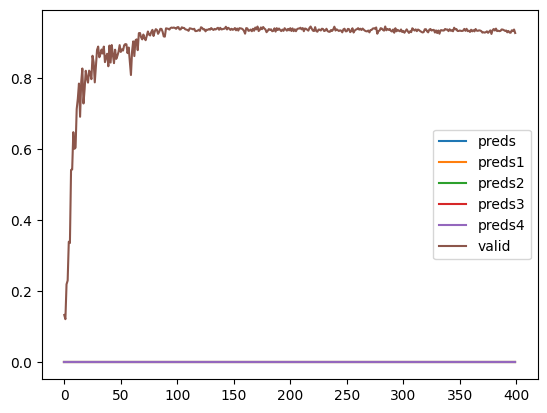

当前 [32, 0.0005, 10, 400, 25]
[0.9512643678160919, 0.9439080459770115, 0.9462068965517242]
0.9471264367816091
===
[0.9476711720938722, 0.9385483394431084, 0.9423479160147101]
0.9428558091838969
===
[0.9468911040526304, 0.9375416641381115, 0.9426275315676014]
0.9423534332527811
===
[0.9497943934205763, 0.946389781463493, 0.9432337321086223]
0.9464726356642306
===


In [10]:
def _freeze_norm_stats(net):
    for m in net.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
lr = 0.0001
batch_size = 8
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop((224,224), scale=(0.75, 1.0)),
        transforms.RandomRotation((-15,15)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(),
    ])
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

average_valid_results = []
average_f1_results = []
average_recall_results = []
average_precision_results = []

average_test_results = []
average_f1_results_test = []
average_recall_results_test = []
average_precision_results_test = []

for config in [[32,0.0005,10,400,25]]:
    
    alphas = [1,1,1,10]
    
    alpha1,alpha2,alpha3,alpha4 = alphas
    average_valid_results = []
    average_f1_results = []
    average_recall_results = []
    average_precision_results = []

    average_test_results = []
    average_f1_results_test = []
    average_recall_results_test = []
    average_precision_results_test = []
    for seed in [2,1,0]:
        distill_flag = False
        batch_size,lr,warmupepoch,epoch_num,select_batch_num = config
        alpha = 1
        
        lrcounter = 0
        seed4batch = seed
        T = 2
        cudnn.benchmark = False
        cudnn.deterministic = True
        torch.manual_seed(seed)  # 为CPU设置随机种子
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # 为所有GPU设置随机种子
        random.seed(seed)
        np.random.seed(seed)



        def get_num_correct(out, labels):  #求准确率
            return out.argmax(dim=1).eq(labels).sum().item()

        
        teacher = MSFIN_teacher().cuda()
        
        
        
        best_model_path = '/kaggle/input/statefarm-stage1/best'+str(seed)+'.pkl'  # 替换为实际的模型路径
        teacher.load_state_dict(torch.load(best_model_path))
        
        for p in teacher.parameters():
            p.requires_grad = False
        
        model_generator = MSFIN(teacher).cuda()
        

        optimizer_generator = torch.optim.Adam(model_generator.parameters(),lr=lr)
        
        scheduler_warmup_generator = GradualWarmupScheduler(optimizer_generator, multiplier=1, total_epoch=warmupepoch)
        optimizer_generator.zero_grad()
        optimizer_generator.step()
        
        
        maxval=0
        maxtest_followmaxval=0
        maxf1_followmaxval = 0
        maxrecall_followmaxval = 0
        maxprecision_followmaxval = 0
        
        maxf1_followmaxval_test = 0
        maxrecall_followmaxval_test = 0
        maxprecision_followmaxval_test = 0
        
        
        finaltestlabel_followmaxval = []
        finaltestlabel_pred_followmaxval = []

        earlystopcounter = 0

        T = 10
        minvalidloss = 99999

        val_loss_curve = []
        val_acc_curve = []
        test_acc_curve = []
        
        train_acc_1 = []
        train_acc_2 = []
        train_acc_3 = []
        train_acc_4 = []
        train_acc_5 = []
        
        idxlist = [i for i in range(train_len)]
        
        flag1 = 0
        flag2 = 0
        warm_end = False
        
        train_warmup_counter = 0
        max_train_acc = 0
        for epoch in tqdm(range(1,epoch_num+1)):

            scheduler_warmup_generator.step()
            np.random.seed(seed)
            np.random.shuffle(idxlist)
            
            total_loss=0
            total_loss1 = 0
            total_loss3 = 0
            valid_loss = 0
            train_correct=0
            test_correct = 0
            val_correct=0
            
            #model_generator.apply(_freeze_norm_stats)

            
            train_counter = 0
            
            #train_all = 0
            
            train_correct1 = 0
            train_correct2 = 0
            train_correct3 = 0
            train_correct4 = 0
            train_correct5 = 0
            
            def getBatch(len_dataset,batch_size):
                batch_num = len_dataset // batch_size
                batch_res = len_dataset % batch_size

                if batch_res>0:
                    batchlist = [batch_size] * batch_num + [batch_res]
                else:
                    batchlist = [batch_size] * batch_num
                return batchlist
            train_batch_list = getBatch(train_len,batch_size)
            
            for idx,b in enumerate(train_batch_list[:select_batch_num]):
                start = 0+sum(train_batch_list[:idx])
                end = 0+sum(train_batch_list[:idx+1])
                batchidxlist = idxlist[start:end]
                
            
                x = []
                y = []
                y2 = []
                for image_inbatch_id in batchidxlist:
                    d = trainset[image_inbatch_id]
                    x.append(train_transform(d[0]))
                    y.append(d[1])
                    y2.append(d[2])
                
                images = torch.stack(x,0).cuda()
                
                
                labels = torch.LongTensor(y).cuda()
                labels2 = torch.LongTensor(y2).cuda()
                
                model_generator.train()
                preds,loss = model_generator(images,labels)

                optimizer_generator.zero_grad()

                if distill_flag:
                    loss = F.cross_entropy(preds,labels) + loss
                else:
                    loss = F.cross_entropy(preds,labels)



                loss.backward()
                optimizer_generator.step()
    
                
                total_loss+=loss.item()
                total_loss1+=loss.item()
                total_loss3+=loss.item()
                train_correct+=get_num_correct(preds,labels)
            
            print('***训练集***')
            print(train_correct / select_batch_num / 32)
            #print('main branch：',train_correct1/select_batch_num/32)
            if train_correct / select_batch_num / 32 >= max_train_acc:
                max_train_acc = train_correct / select_batch_num / 32
                train_warmup_counter = 0
            else:
                train_warmup_counter += 1
                if train_warmup_counter == 10:
                    distill_flag = True
                    print('开始蒸馏')

            
            valid_preds = []
            valid_labels = []
                
            model_generator.eval()
            with torch.no_grad():
                validxlist = [i for i in range(valid_len)]
                valid_batch_list = getBatch(valid_len,batch_size)
                
                for idx,b in enumerate(valid_batch_list):
                    start = 0+sum(valid_batch_list[:idx])
                    end = 0+sum(valid_batch_list[:idx+1])
                    batchidxlist = validxlist[start:end]

                    x = []
                    y = []
                    y2 = []
                    for image_inbatch_id in batchidxlist:
                        #im_o = 
                        d = validset[image_inbatch_id]
                        #print()
                        x.append(test_transform(d[0]))
                        y.append(d[1])
                        y2.append(d[2])

                    images = torch.stack(x,0).cuda()#.permute(0,3,1,2) / 255
                    labels = torch.LongTensor(y).cuda()
                    #mask,preds3 = stage1(premodel,images)
                    #images = (images)

                    preds,_ = model_generator(images,labels)

                    #preds = model(images)
                    loss = F.cross_entropy(preds,labels)
                    
                    valid_loss+=loss.item()
                    val_correct+=get_num_correct(preds,labels)
                    
                    valid_preds += preds.argmax(-1).cpu().numpy().tolist()
                    valid_labels += y
            '''if val_correct/valid_len >= 0.85 and not warm_end:
                print('预热结束')
                warm_end = True'''
            F1=f1_score(valid_labels,valid_preds,average="macro")
            print("valid-f1:",F1)
            precision=precision_score(valid_labels,valid_preds,average="macro")
            print("valid-precision:",precision)
            recall=recall_score(valid_labels,valid_preds,average="macro")
            print("valid-recall:",recall)
            
            print('process:',epoch," loss:",total_loss," train_correct:",train_correct/train_len,'valid_loss',valid_loss," val_correct:",val_correct/valid_len)
            train_acc = train_correct/train_len
            val_acc=val_correct/valid_len
            
            train_acc_1.append(train_correct1/train_all)
            train_acc_2.append(train_correct2/train_all)
            train_acc_3.append(train_correct3/train_all)
            train_acc_4.append(train_correct4/train_all)
            train_acc_5.append(train_correct5/train_all)
            val_loss_curve.append(valid_loss)
            val_acc_curve.append(val_acc)
            #test_acc_curve.append(test_acc)
            
            
            
            
            if val_acc > maxval:
                
                maxval = val_acc
                maxf1_followmaxval = F1
                maxrecall_followmaxval = recall
                maxprecision_followmaxval = precision

                
                earlystopcounter = 0
                torch.save(model_generator.state_dict(), 'best'+str(seed)+'.pkl')
                print('The model has been saved!!')
                print('The best val_acc is ',maxval)
            '''else:
                earlystopcounter += 1
                if earlystopcounter == 10:
                    print('早停')
                    print('The best val_acc is ',maxval,'The best test_acc is ',best_test_acc)
                    break'''
        x = range(len(val_loss_curve))


        plt.figure()
        
        plt.plot(x, train_acc_1,label = 'preds')
        plt.plot(x, train_acc_2,label = 'preds1')
        plt.plot(x, train_acc_3,label = 'preds2')
        plt.plot(x, train_acc_4,label = 'preds3')
        plt.plot(x, train_acc_5,label = 'preds4')

        plt.plot(x, val_acc_curve,label = 'valid')

        plt.legend()
        plt.show()
        average_valid_results.append(maxval)
        average_f1_results.append(maxf1_followmaxval)
        average_recall_results.append(maxrecall_followmaxval)
        average_precision_results.append(maxprecision_followmaxval)

    def summary(average_valid_results):
        print(average_valid_results)
        print(sum(average_valid_results)/len(average_valid_results))
        print('===')

    print('当前',config)
    summary(average_valid_results)
    summary(average_f1_results)
    summary(average_recall_results)
    summary(average_precision_results)

